# Installs

In [2]:
#!pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu102
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu102.html
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https:/

# Reinforcement Learning Class

## RL Environment

In [3]:
# Copyright 2019 DeepMind Technologies Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Reinforcement Learning (RL) Environment for Open Spiel.

This module wraps Open Spiel Python interface providing an RL-friendly API. It
covers both turn-based and simultaneous move games. Interactions between agents
and the underlying game occur mostly through the `reset` and `step` methods,
which return a `TimeStep` structure (see its docstrings for more info).

The following example illustrates the interaction dynamics. Consider a 2-player
Kuhn Poker (turn-based game). Agents have access to the `observations` (a dict)
field from `TimeSpec`, containing the following members:
 * `info_state`: list containing the game information state for each player. The
   size of the list always correspond to the number of players. E.g.:
   [[0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]].
 * `legal_actions`: list containing legal action ID lists (one for each player).
   E.g.: [[0, 1], [0]], which corresponds to actions 0 and 1 being valid for
   player 0 (the 1st player) and action 0 being valid for player 1 (2nd player).
 * `current_player`: zero-based integer representing the player to make a move.

At each `step` call, the environment expects a singleton list with the action
(as it's a turn-based game), e.g.: [1]. This (zero-based) action must correspond
to the player specified at `current_player`. The game (which is at decision
node) will process the action and take as many steps necessary to cover chance
nodes, halting at a new decision or final node. Finally, a new `TimeStep`is
returned to the agent.

Simultaneous-move games follow analogous dynamics. The only differences is the
environment expects a list of actions, one per player. Note the `current_player`
field is "irrelevant" here, admitting a constant value defined in spiel.h, which
defaults to -2 (module level constant `SIMULTANEOUS_PLAYER_ID`).

See open_spiel/python/examples/rl_example.py for example usages.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

import enum
from absl import logging
import numpy as np

import pyspiel

SIMULTANEOUS_PLAYER_ID = pyspiel.PlayerId.SIMULTANEOUS

class TimeStep(
    collections.namedtuple(
        "TimeStep", ["observations", "rewards", "discounts", "step_type"])):
  """Returned with every call to `step` and `reset`.

  A `TimeStep` contains the data emitted by a game at each step of interaction.
  A `TimeStep` holds an `observation` (list of dicts, one per player),
  associated lists of `rewards`, `discounts` and a `step_type`.

  The first `TimeStep` in a sequence will have `StepType.FIRST`. The final
  `TimeStep` will have `StepType.LAST`. All other `TimeStep`s in a sequence will
  have `StepType.MID.

  Attributes:
    observations: a list of dicts containing observations per player.
    rewards: A list of scalars (one per player), or `None` if `step_type` is
      `StepType.FIRST`, i.e. at the start of a sequence.
    discounts: A list of discount values in the range `[0, 1]` (one per player),
      or `None` if `step_type` is `StepType.FIRST`.
    step_type: A `StepType` enum value.
  """
  __slots__ = ()

  def first(self):
    return self.step_type == StepType.FIRST

  def mid(self):
    return self.step_type == StepType.MID

  def last(self):
    return self.step_type == StepType.LAST

  def is_simultaneous_move(self):
    return self.observations["current_player"] == SIMULTANEOUS_PLAYER_ID

  def current_player(self):
    return self.observations["current_player"]


class StepType(enum.Enum):
  """Defines the status of a `TimeStep` within a sequence."""

  FIRST = 0  # Denotes the first `TimeStep` in a sequence.
  MID = 1  # Denotes any `TimeStep` in a sequence that is not FIRST or LAST.
  LAST = 2  # Denotes the last `TimeStep` in a sequence.

  def first(self):
    return self is StepType.FIRST

  def mid(self):
    return self is StepType.MID

  def last(self):
    return self is StepType.LAST


# Global pyspiel members
def registered_games():
  return pyspiel.registered_games()



class ChanceEventSampler(object):
  """Default sampler for external chance events."""

  def __init__(self, seed=None):
    self.seed(seed)

  def seed(self, seed=None):
    self._rng = np.random.RandomState(seed)

  def __call__(self, state):
    """Sample a chance event in the given state."""
    actions, probs = zip(*state.chance_outcomes())
    return self._rng.choice(actions, p=probs)


class ObservationType(enum.Enum):
  """Defines what kind of observation to use."""
  OBSERVATION = 0  # Use observation_tensor
  INFORMATION_STATE = 1  # Use information_state_tensor


class Environment(object):
  """Open Spiel reinforcement learning environment class."""

  def __init__(self,
               game,
               discount=1.0,
               chance_event_sampler=None,
               observation_type=None,
               include_full_state=False,
               distribution=None,
               mfg_population=None,
               enable_legality_check=False,
               **kwargs):
    """Constructor.

    Args:
      game: [string, pyspiel.Game] Open Spiel game name or game instance.
      discount: float, discount used in non-initial steps. Defaults to 1.0.
      chance_event_sampler: optional object with `sample_external_events` method
        to sample chance events.
      observation_type: what kind of observation to use. If not specified, will
        default to INFORMATION_STATE unless the game doesn't provide it.
      include_full_state: whether or not to include the full serialized
        OpenSpiel state in the observations (sometimes useful for debugging).
      distribution: the distribution over states if the game is a mean field
        game.
      mfg_population: The Mean Field Game population to consider.
      enable_legality_check: Check the legality of the move before stepping.
      **kwargs: dict, additional settings passed to the Open Spiel game.
    """
    self._chance_event_sampler = chance_event_sampler or ChanceEventSampler()
    self._include_full_state = include_full_state
    self._distribution = distribution
    self._mfg_population = mfg_population
    self._enable_legality_check = enable_legality_check

    if isinstance(game, str):
      if kwargs:
        game_settings = {key: val for (key, val) in kwargs.items()}
        logging.info("Using game settings: %s", game_settings)
        self._game = pyspiel.load_game(game, game_settings)
      else:
        logging.info("Using game string: %s", game)
        self._game = pyspiel.load_game(game)
    else:  # pyspiel.Game or API-compatible object.
      logging.info("Using game instance: %s", game.get_type().short_name)
      self._game = game

    self._num_players = self._game.num_players()
    self._state = None
    self._should_reset = True

    # Discount returned at non-initial  steps.
    self._discounts = [discount] * self._num_players

    # Determine what observation type to use.
    if observation_type is None:
      if self._game.get_type().provides_information_state_tensor:
        observation_type = ObservationType.INFORMATION_STATE
      else:
        observation_type = ObservationType.OBSERVATION

    # Check the requested observation type is supported.
    if observation_type == ObservationType.OBSERVATION:
      if not self._game.get_type().provides_observation_tensor:
        raise ValueError(f"observation_tensor not supported by {game}")
    elif observation_type == ObservationType.INFORMATION_STATE:
      if not self._game.get_type().provides_information_state_tensor:
        raise ValueError(f"information_state_tensor not supported by {game}")
    self._use_observation = (observation_type == ObservationType.OBSERVATION)

    if self._game.get_type().dynamics == pyspiel.GameType.Dynamics.MEAN_FIELD:
      assert distribution is not None
      assert mfg_population is not None
      assert 0 <= mfg_population < self._num_players

  def seed(self, seed=None):
    self._chance_event_sampler.seed(seed)

  def get_time_step(self):
    """Returns a `TimeStep` without updating the environment.

    Returns:
      A `TimeStep` namedtuple containing:
        observation: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        reward: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discount: list of discounts in the range [0, 1], or None if step_type is
          `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    observations = {
        "num_nodes":[],
        "info_state": [],
        "global_feature": [],
        "legal_actions": [],
        "current_player": [],
        "serialized_state": []
    }
    rewards = []
    step_type = StepType.LAST if self._state.is_terminal() else StepType.MID
    self._should_reset = step_type == StepType.LAST
    cur_rewards = self._state.rewards()
    for player_id in range(self.num_players):
      rewards.append(cur_rewards[player_id])
      observations["info_state"].append(self._state.info_state)
      '''observations["info_state"].append(
          self._state.observation_tensor(player_id) if self._use_observation
          else self._state.information_state_tensor(player_id))'''
      observations["legal_actions"].append(self._state.legal_actions(player_id))
    observations["num_nodes"] = self._state.num_nodes
    observations["global_feature"] = self._state.global_feature
    observations["current_player"] = self._state.current_player()
    discounts = self._discounts
    if step_type == StepType.LAST:
      # When the game is in a terminal state set the discount to 0.
      discounts = [0. for _ in discounts]

    if self._include_full_state:
      observations["serialized_state"] = pyspiel.serialize_game_and_state(
          self._game, self._state)

    return TimeStep(
        observations=observations,
        rewards=rewards,
        discounts=discounts,
        step_type=step_type)

  def _check_legality(self, actions):
    if self.is_turn_based:
      legal_actions = self._state.legal_actions()
      if actions[0] not in legal_actions:
        raise RuntimeError(f"step() called on illegal action {actions[0]}")
    else:
      for p in range(len(actions)):
        legal_actions = self._state.legal_actions(p)
        if legal_actions and actions[p] not in legal_actions:
          raise RuntimeError(f"step() by player {p} called on illegal " +
                             f"action: {actions[p]}")

  def step(self, actions):
    """Updates the environment according to `actions` and returns a `TimeStep`.

    If the environment returned a `TimeStep` with `StepType.LAST` at the
    previous step, this call to `step` will start a new sequence and `actions`
    will be ignored.

    This method will also start a new sequence if called after the environment
    has been constructed and `reset` has not been called. Again, in this case
    `actions` will be ignored.

    Args:
      actions: a list containing one action per player, following specifications
        defined in `action_spec()`.

    Returns:
      A `TimeStep` namedtuple containing:
        observation: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        reward: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discount: list of discounts in the range [0, 1], or None if step_type is
          `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    assert len(actions) == self.num_actions_per_step, (
        "Invalid number of actions! Expected {}".format(
            self.num_actions_per_step))
    if self._should_reset:
      return self.reset()

    if self._enable_legality_check:
      self._check_legality(actions)

    if self.is_turn_based:
      self._state.apply_action(actions[0])
    else:
      self._state.apply_actions(actions)
    self._sample_external_events()

    return self.get_time_step()

  def reset(self):
    """Starts a new sequence and returns the first `TimeStep` of this sequence.

    Returns:
      A `TimeStep` namedtuple containing:
        observations: list of dicts containing one observations per player, each
          corresponding to `observation_spec()`.
        rewards: list of rewards at this timestep, or None if step_type is
          `StepType.FIRST`.
        discounts: list of discounts in the range [0, 1], or None if step_type
          is `StepType.FIRST`.
        step_type: A `StepType` value.
    """
    self._should_reset = False
    if self._game.get_type(
    ).dynamics == pyspiel.GameType.Dynamics.MEAN_FIELD and self._num_players > 1:
      self._state = self._game.new_initial_state_for_population(
          self._mfg_population)
    else:
      self._state = self._game.new_initial_state()
    self._sample_external_events()

    observations = {
        "num_nodes":[],
        "info_state": [],
        "global_feature":[],
        "legal_actions": [],
        "current_player": [],
        "serialized_state": []
    }
    for player_id in range(self.num_players):
      observations["info_state"].append(self._state.info_state)
      '''observations["info_state"].append(
          self._state.observation_tensor(player_id) if self._use_observation
          else self._state.information_state_tensor(player_id))'''
      observations["legal_actions"].append(self._state.legal_actions(player_id))
    observations["num_nodes"]= self._state.num_nodes
    observations["global_feature"]= self._state.global_feature
    observations["current_player"] = self._state.current_player()
    if self._include_full_state:
      observations["serialized_state"] = pyspiel.serialize_game_and_state(
          self._game, self._state)
    return TimeStep(
        observations=observations,
        rewards=None,
        discounts=None,
        step_type=StepType.FIRST)

  def _sample_external_events(self):
    """Sample chance events until we get to a decision node."""
    while self._state.is_chance_node() or (self._state.current_player()
                                           == pyspiel.PlayerId.MEAN_FIELD):
      if self._state.is_chance_node():
        outcome = self._chance_event_sampler(self._state)
        self._state.apply_action(outcome)
      if self._state.current_player() == pyspiel.PlayerId.MEAN_FIELD:
        dist_to_register = self._state.distribution_support()
        dist = [
            self._distribution.value_str(str_state, default_value=0.0)
            for str_state in dist_to_register
        ]
        self._state.update_distribution(dist)

  def observation_spec(self):
    """Defines the observation per player provided by the environment.

    Each dict member will contain its expected structure and shape. E.g.: for
    Kuhn Poker {"info_state": (6,), "legal_actions": (2,), "current_player": (),
                "serialized_state": ()}

    Returns:
      A specification dict describing the observation fields and shapes.
    """
    return dict(
        info_state=(),
        num_nodes=(),
        global_feature=(),
        legal_actions=(self._game.num_distinct_actions(),),
        current_player=(),
        serialized_state=(),
    )

  def action_spec(self):
    """Defines per player action specifications.

    Specifications include action boundaries and their data type.
    E.g.: for Kuhn Poker {"num_actions": 2, "min": 0, "max":1, "dtype": int}

    Returns:
      A specification dict containing per player action properties.
    """
    return dict(
        num_actions=self._game.num_distinct_actions(),
        min=0,
        max=self._game.num_distinct_actions() - 1,
        dtype=int,
    )

  # Environment properties
  @property
  def use_observation(self):
    """Returns whether the environment is using the game's observation.

    If false, it is using the game's information state.
    """
    return self._use_observation

  # Game properties
  @property
  def name(self):
    return self._game.get_type().short_name

  @property
  def num_players(self):
    return self._game.num_players()

  @property
  def num_actions_per_step(self):
    return 1 if self.is_turn_based else self.num_players

  # New RL calls for more advanced use cases (e.g. search + RL).
  @property
  def is_turn_based(self):
    return ((self._game.get_type().dynamics
             == pyspiel.GameType.Dynamics.SEQUENTIAL) or
            (self._game.get_type().dynamics
             == pyspiel.GameType.Dynamics.MEAN_FIELD))

  @property
  def max_game_length(self):
    return self._game.max_game_length()

  @property
  def is_chance_node(self):
    return self._state.is_chance_node()

  @property
  def game(self):
    return self._game

  def set_state(self, new_state):
    """Updates the game state."""
    assert new_state.get_game() == self.game, (
        "State must have been created by the same game.")
    self._state = new_state

  @property
  def get_state(self):
    return self._state

## Replay Buffer

In [4]:
# Copyright 2019 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Replay buffer of fixed size with a FIFI replacement policy."""

import random


class ReplayBuffer(object):
  """ReplayBuffer of fixed size with a FIFO replacement policy.
  Stored transitions can be sampled uniformly.
  The underlying datastructure is a ring buffer, allowing 0(1) adding and
  sampling.
  """

  def __init__(self, replay_buffer_capacity):
    self._replay_buffer_capacity = replay_buffer_capacity
    self._data = []
    self._next_entry_index = 0

  def add(self, element):
    """Adds `element` to the buffer.
    If the buffer is full, the oldest element will be replaced.
    Args:
      element: data to be added to the buffer.
    """
    if len(self._data) < self._replay_buffer_capacity:
      self._data.append(element)
    else:
      self._data[self._next_entry_index] = element
      self._next_entry_index += 1
      self._next_entry_index %= self._replay_buffer_capacity

  def sample(self, num_samples):
    """Returns `num_samples` uniformly sampled from the buffer.
    Args:
      num_samples: `int`, number of samples to draw.
    Returns:
      An iterable over `num_samples` random elements of the buffer.
    Raises:
      ValueError: If there are less than `num_samples` elements in the buffer
    """
    if len(self._data) < num_samples:
      raise ValueError("{} elements could not be sampled from size {}".format(
          num_samples, len(self._data)))
    return random.sample(self._data, num_samples)

  def reset(self):
    """Resets the contents of the replay buffer."""
    self._data = []
    self._next_entry_index = 0

  def __len__(self):
    return len(self._data)

  def __iter__(self):
    return iter(self._data)

## DQN PyTorch

In [5]:
# Copyright 2019 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""DQN agent implemented in PyTorch."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import numpy as np
from scipy import sparse
from torch._C import dtype
import torch
from torch import nn
from torch_geometric import nn as gnn
from torch.nn import functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch.nn import Flatten, Linear
from torch_geometric.utils import convert

from open_spiel.python import rl_agent
#from open_spiel.python.utils.replay_buffer import ReplayBuffer

Transition = collections.namedtuple(
    "Transition", "info_state global_feature action reward next_info_state next_global_feature is_final_step legal_actions_mask")

ILLEGAL_ACTION_LOGITS_PENALTY = -1e9


class GraphNN(nn.Module):
  """A simple network built from nn.linear layers."""

  def __init__(self,
               feature_size,
               hidden_sizes,global_size):
    """Create the MLP.
    Args:
      input_size: (int) number of inputs
      hidden_sizes: (list) sizes (number of units) of each hidden layer
      output_size: (int) number of outputs
      activate_final: (bool) should final layer should include a ReLU
    """
    super(GraphNN, self).__init__()
    hidden_conv, hidden_global, hidden_final = hidden_sizes[0], hidden_sizes[1], hidden_sizes[2]
    
    #2 GAT layer
    self.conv1 = GATv2Conv(feature_size, hidden_conv[0],add_self_loops = True) 
    self.conv1bn = gnn.BatchNorm(hidden_conv[0])
    self.conv2 = GATv2Conv(hidden_conv[0],hidden_conv[1],add_self_loops = True) 
    self.conv2bn = gnn.BatchNorm(hidden_conv[1])
    
    #Global_Linear Layer
    self.linear_global1 = nn.Linear(global_size, hidden_global[0])
    self.linear_global2 = nn.Linear(hidden_global[0], hidden_global[1])
    
    
    #Join to Layer
    self.linear1 = nn.Linear(hidden_conv[-1]+hidden_global[-1],hidden_final[0])
    self.batchnorm1 = nn.BatchNorm1d(hidden_final[0])
    self.linear2 = nn.Linear(hidden_final[0], hidden_final[1])
    self.batchnorm2 = nn.BatchNorm1d(hidden_final[1])
    self.linear3 = nn.Linear(hidden_final[1], 1)
  
  def forward(self, node_feature, edge_index, global_x):
    x, edge_index = node_feature, edge_index
    #MLP for Global Features
    global_x = self.linear_global1(global_x)
    global_x = self.linear_global2(global_x)
    global_x = global_x.repeat(x.size()[0],1)
    
    #GAT Layer for Graphs
    x = F.relu(self.conv1(x, edge_index))
    x = self.conv1bn(x)
    x = F.relu(self.conv2(x, edge_index))
    x = self.conv2bn(x)
    
    #Combining Graph Feature Embedding and GAT Layer 
    x = F.relu(self.linear1(torch.hstack((x,global_x))))
    x = self.batchnorm1(x)
    x = F.relu(self.linear2(x))
    x = self.batchnorm2(x)
    x = F.relu(self.linear3(x))
    x = torch.softmax(x,dim=0)
    return x


class DQN(rl_agent.AbstractAgent):
  """DQN Agent implementation in PyTorch.
  See open_spiel/python/examples/breakthrough_dqn.py for an usage example.
  """

  def __init__(self,
               player_id,
               state_representation_size,
               global_feature_size,
               num_actions,
               hidden_layers_sizes=[[4,3],[5,3],[6,4,3]],
               output_layer_size =1,
               replay_buffer_capacity=10000,
               batch_size=128,
               replay_buffer_class=ReplayBuffer,
               learning_rate=0.001,
               power = 1.0,
               nsteps = 3,
               update_target_network_every=1000,
               learn_every=10,
               discount_factor=1.0,
               min_buffer_size_to_learn=1000,
               epsilon_start=1.0,
               epsilon_end=0.1,
               epsilon_decay_duration=int(1e6),
               optimizer_str="adam",
               loss_str="huber"):
    """Initialize the DQN agent."""

    # This call to locals() is used to store every argument used to initialize
    # the class instance, so it can be copied with no hyperparameter change.
    self._kwargs = locals()

    self.player_id = player_id
    self._num_actions = num_actions
    """if isinstance(hidden_layers_sizes, int):
      hidden_layers_sizes = [hidden_layers_sizes]"""
    self.num_feature = state_representation_size
    self.global_feature_size = global_feature_size
    self._layer_sizes = hidden_layers_sizes
    self._batch_size = batch_size
    self._update_target_network_every = update_target_network_every
    self._learn_every = learn_every
    self._min_buffer_size_to_learn = min_buffer_size_to_learn
    self._discount_factor = discount_factor
    self._epsilon_start = epsilon_start
    self._epsilon_end = epsilon_end
    self._epsilon_decay_duration = epsilon_decay_duration
    self.power = power
    self.n_steps =  nsteps
    self.nstep_buffer = []
    # TODO(author6) Allow for optional replay buffer config.
    if not isinstance(replay_buffer_capacity, int):
      raise ValueError("Replay buffer capacity not an integer.")
    self._replay_buffer = replay_buffer_class(replay_buffer_capacity)
    self._prev_timestep = None
    self._prev_action = None

    # Step counter to keep track of learning, eps decay and target network.
    self._step_counter = 0

    # Keep track of the last training loss achieved in an update step.
    self._last_loss_value = None

    # Create the Q-network instances
    self._q_network = GraphNN(state_representation_size, self._layer_sizes,self.global_feature_size) #num_actions

    self._target_q_network = GraphNN(state_representation_size, self._layer_sizes,self.global_feature_size)
    # Q network outputs approx single feature embedded value = approx q value for each Noder
    if loss_str == "mse":
      self.loss_class = F.mse_loss
    elif loss_str == "huber":
      self.loss_class = F.smooth_l1_loss
    else:
      raise ValueError("Not implemented, choose from 'mse', 'huber'.")

    if optimizer_str == "adam":
      self._optimizer = torch.optim.Adam(
          self._q_network.parameters(), lr=learning_rate)
    elif optimizer_str == "sgd":
      self._optimizer = torch.optim.SGD(
          self._q_network.parameters(), lr=learning_rate)
    else:
      raise ValueError("Not implemented, choose from 'adam' and 'sgd'.")

  def step(self, time_step, is_evaluation=False, add_transition_record=True):
    """Returns the action to be taken and updates the Q-network if needed.
    Args:
      time_step: an instance of rl_environment.TimeStep.
      is_evaluation: bool, whether this is a training or evaluation call.
      add_transition_record: Whether to add to the replay buffer on this step.
    Returns:
      A `rl_agent.StepOutput` containing the action probs and chosen action.
    """

    # Act step: don't act at terminal info states or if its not our turn.
    if (not time_step.last()) and (
        time_step.is_simultaneous_move() or
        self.player_id == time_step.current_player()):
      num_nodes = time_step.observations["num_nodes"]
      info_state = time_step.observations["info_state"][self.player_id]
      legal_actions = time_step.observations["legal_actions"][self.player_id]
      global_feature = time_step.observations["global_feature"]
      self.epsilon = self._get_epsilon(is_evaluation,power=self.power)
      action, probs = self._epsilon_greedy(num_nodes,info_state,global_feature, legal_actions, self.epsilon)
    else:
      action = None
      probs = []
    #if legal_actions <= 5
    # Don't mess up with the state during evaluation.
    if not is_evaluation:
      self._step_counter += 1

      if self._step_counter % self._learn_every == 0:
        self._last_loss_value = self.learn()

      if self._step_counter % self._update_target_network_every == 0:
        # state_dict method returns a dictionary containing a whole state of the
        # module.
        self._target_q_network.load_state_dict(self._q_network.state_dict())

      if self._prev_timestep and add_transition_record:
        # We may omit record adding here if it's done elsewhere.
        self.add_transition(self._prev_timestep, self._prev_action, time_step)

      if time_step.last():  # prepare for the next episode.
        self._prev_timestep = None
        self._prev_action = None
        return
      else:
        self._prev_timestep = time_step
        self._prev_action = action

    return rl_agent.StepOutput(action=action, probs=probs)

  def add_transition(self, prev_time_step, prev_action, time_step):
    """Adds the new transition using `time_step` to the replay buffer.
    Adds the transition from `self._prev_timestep` to `time_step` by
    `self._prev_action`.
    Args:
      prev_time_step: prev ts, an instance of rl_environment.TimeStep.
      prev_action: int, action taken at `prev_time_step`.
      time_step: current ts, an instance of rl_environment.TimeStep.
    """
    assert prev_time_step is not None
    self.nstep_buffer.append((prev_time_step, prev_action, time_step))
    if(len(self.nstep_buffer)<self.n_steps):
        return
    _num_actions = time_step.observations["num_nodes"]
    legal_actions = (time_step.observations["legal_actions"][self.player_id])
    legal_actions_mask = np.zeros(_num_actions)
    legal_actions_mask[legal_actions] = 1.0
    
    #looping over the nstep buffer to get reward from G_{t:t+n}
    sum_reward = 0 
    for i in range(self.n_steps):
        step = self.nstep_buffer[i][2]
        sum_reward += step.rewards[self.player_id]*( self._discount_factor**i) 
    prev_time_step, prev_action, _ = self.nstep_buffer.pop(0)
    transition = Transition(
        info_state=prev_time_step.observations["info_state"][self.player_id],
        global_feature = prev_time_step.observations["global_feature"],
        action=prev_action,
        reward=sum_reward,
        #reward=time_step.rewards[self.player_id],
        next_info_state=time_step.observations["info_state"][self.player_id],
        next_global_feature = time_step.observations["global_feature"],
        is_final_step=float(time_step.last()),
        legal_actions_mask=legal_actions_mask)
    self._replay_buffer.add(transition)
    if time_step.last():
        while len(self.nstep_buffer) > 0:
            sum_reward = 0 
            for i in range(len(self.nstep_buffer)):
                step = self.nstep_buffer[i][2]
                sum_reward += step.rewards[self.player_id]*( self._discount_factor**i) 
            prev_time_step, prev_action, _ = self.nstep_buffer.pop(0)
            transition = Transition(
                info_state=prev_time_step.observations["info_state"][self.player_id],
                global_feature = prev_time_step.observations["global_feature"],
                action=prev_action,
                reward=sum_reward,
                #reward=time_step.rewards[self.player_id],
                next_info_state=time_step.observations["info_state"][self.player_id],
                next_global_feature = time_step.observations["global_feature"],
                is_final_step=float(time_step.last()),
                legal_actions_mask=legal_actions_mask)
            self._replay_buffer.add(transition)
        

  def _epsilon_greedy(self,num_nodes, info_state,global_feature,legal_actions, epsilon):
    """Returns a valid epsilon-greedy action and valid action probs.
    Action probabilities are given by a softmax over legal q-values.
    Args:
      info_state: hashable representation of the information state.
      legal_actions: list of legal actions at `info_state`.
      epsilon: float, probability of taking an exploratory action.
    Returns:
      A valid epsilon-greedy action and valid action probabilities.
    """
    size = int(num_nodes)
    probs = np.zeros(size)
    if np.random.rand() < epsilon:
      action = np.random.choice(legal_actions)
      probs[legal_actions] = 1.0 / len(legal_actions)
    else:
      q_values = self._q_network(info_state.x,info_state.edge_index,global_feature).detach()
      legal_q_values = q_values[legal_actions]
      action = legal_actions[torch.argmax(legal_q_values)]
      probs[action] = 1.0
    return action, probs

  def _get_epsilon(self, is_evaluation, power=1.0):
    """Returns the evaluation or decayed epsilon value."""
    if is_evaluation:
      return 0.0
    '''if float(self._step_counter) <= self._epsilon_decay_duration:
        decayed_epsilon = self._epsilon_start
    else:'''
    #decayed_epsilon = self._epsilon_start
    decay_steps = min(self._step_counter, self._epsilon_decay_duration)
    decayed_epsilon = (
        self._epsilon_end + (self._epsilon_start - self._epsilon_end) *
        (1 - decay_steps / self._epsilon_decay_duration)**power)
    return decayed_epsilon
  def max_next_q_value(self,target_q,legal_actions_mask):
    illegal_actions = 1 - legal_actions_mask
    illegal_logits = illegal_actions * ILLEGAL_ACTION_LOGITS_PENALTY
    all_target_q = target_q.numpy()+ illegal_logits
    max_target_q = np.amax(all_target_q)
    return max_target_q
  
  def learn(self):
    """Compute the loss on sampled transitions and perform a Q-network update.
    If there are not enough elements in the buffer, no loss is computed and
    `None` is returned instead.
    Returns:
      The average loss obtained on this batch of transitions or `None`.
    """
    if (len(self._replay_buffer) < self._batch_size or
        len(self._replay_buffer) < self._min_buffer_size_to_learn):
      return None     
    transitions = self._replay_buffer.sample(self._batch_size)
    actions =[]
    rewards = []
    are_final_steps = []
    q_values = []
    target_q_values = []
    max_next_q = []
    for t in transitions:
        info_states = t.info_state
        global_feature = t.global_feature
        q_values.append(torch.flatten(self._q_network(info_states.x,info_states.edge_index,global_feature)))
        actions.append(t.action)
        rewards.append(t.reward)
        next_info_states = t.next_info_state 
        next_global_feature = t.next_global_feature
        target_q_values.append(torch.flatten(self._target_q_network(next_info_states.x,next_info_states.edge_index,next_global_feature)))
        are_final_steps.append(t.is_final_step)
        max_next_q.append(self.max_next_q_value(target_q_values[-1].detach(),t.legal_actions_mask))
    actions = torch.LongTensor(np.array(actions))
    rewards = torch.Tensor(np.array(rewards))
    are_final_steps = torch.Tensor(np.array(are_final_steps))
    max_next_q = torch.Tensor(np.array(max_next_q))
    self._q_values = q_values
    self._target_q_values = target_q_values
    #print('Qvalues', self._q_values)
    #print("illegallogits",illegal_logits)
    #print('targetvalues', self._target_q_values)
    target=[]
    prediction=[]
    nstep_gamma = (self._discount_factor**self.n_steps)
    for i in range(self._batch_size):
        target.append((rewards[i] + (1 - are_final_steps[i]) * nstep_gamma * max_next_q[i]))
        prediction.append(self._q_values[i][actions[i].item()])
    target = torch.stack(target)
    prediction = torch.stack(prediction)
    loss = self.loss_class(prediction, target)
    self._optimizer.zero_grad()
    loss.backward()
    self._optimizer.step()
    return loss


  @property
  def q_values(self):
    return self._q_values

  @property
  def replay_buffer(self):
    return self._replay_buffer

  @property
  def loss(self):
    return self._last_loss_value

  @property
  def prev_timestep(self):
    return self._prev_timestep

  @property
  def prev_action(self):
    return self._prev_action

  @property
  def step_counter(self):
    return self._step_counter

  def get_weights(self):
    variables = [m.weight for m in self._q_network.model]
    variables.append([m.weight for m in self._target_q_network.model])
    return variables

  def copy_with_noise(self, sigma=0.0, copy_weights=True):
    """Copies the object and perturbates it with noise.
    Args:
      sigma: gaussian dropout variance term : Multiplicative noise following
        (1+sigma*epsilon), epsilon standard gaussian variable, multiplies each
        model weight. sigma=0 means no perturbation.
      copy_weights: Boolean determining whether to copy model weights (True) or
        just model hyperparameters.
    Returns:
      Perturbated copy of the model.
    """
    _ = self._kwargs.pop("self", None)
    copied_object = DQN(**self._kwargs)

    q_network = getattr(copied_object, "_q_network")
    target_q_network = getattr(copied_object, "_target_q_network")
    if copy_weights:
      with torch.no_grad():
        for q_model in q_network.model:
          q_model.weight *= (1 + sigma * torch.randn(q_model.weight.shape))
        for tq_model in target_q_network.model:
          tq_model.weight *= (1 + sigma * torch.randn(tq_model.weight.shape))
    return copied_object

# Game Environment

In [6]:
#from open_spiel.python import rl_environment
from open_spiel.python.algorithms import random_agent

def eval_model(env, trained_agents):
    """Evaluates `trained_agents` against a new graph."""
    cur_agents = [agent for agent in trained_agents]
    time_step = env.reset()
    episode_rewards = []
    action_lists = []
    i = 0
    while not time_step.last():
        agents_output = [
            agent.step(time_step, is_evaluation=True) for agent in cur_agents
        ]
        action_list = [agent_output.action for agent_output in agents_output]
        action_lists.append(action_list[0])
        time_step = env.step([action_list[0],action_list[0]])
        i+=1
        #print(action_list[0],env.get_state)
        #print("action sequence",time_step.observations["legal_actions"])
        episode_rewards.append(env.get_state._rewards[0])
    lcc = env.get_state.lcc
    return episode_rewards, lcc, action_lists

def eval_ACTION(env, action_list):
    """Evaluates the env for given action_list"""
    env.reset()
    episode_rewards = []
    i = 0
    lcc = []
    actions_used = []
    for action in action_list:
        actions_used.append(action)
        if action == None :
            print(action)
            continue
        time_step = env.step([action,action])
        i+=1
        episode_rewards.append(env.get_state._rewards[0])
        if env.get_state._is_terminal == True:
            break
    lcc = env.get_state.lcc
    return episode_rewards, lcc, actions_used

In [7]:
 # Copyright 2019 DeepMind Technologies Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an

#  "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as python3
""" Graph Attack and Defense implemented in Python.
This is a simple demonstration of implementing a game in Python, featuring
chance and imperfect information.
Python games are significantly slower than C++, but it may still be suitable
for prototyping or for small games.
It is possible to run C++ algorithms on Python implemented games, This is likely
to have good performance if the algorithm simply extracts a game tree and then
works with that. It is likely to be poor if the algorithm relies on processing
and updating states as it goes, e.g. MCTS.
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric import utils
from open_spiel.python.observation import IIGObserverForPublicInfoGame
import pyspiel
from scipy.stats import entropy
from sklearn.metrics import auc


# Helper functions for game details.
def get_lcc(g):
        subGraph = g #g.subgraph(np.arange(len(g)-1))
        return len(max(nx.connected_components(subGraph), key=len))

def molloy_reed(g):
  all_degree =   np.array(g.degree())[:,1]
  #degs = all_degree
  nonmax_lcc = list(set(g.nodes()).difference(set(max(nx.connected_components(g), key=len))))
  degs = np.delete(all_degree,nonmax_lcc)#for non max LCC
  #degs = np.delete(all_degree,-1)#for supernode
  k = degs.mean()
  k2 = np.mean(degs** 2)
  if k ==0:
    beta = 0
  else:
    beta = k2/k
  return beta
def global_feature(g): 
    subGraph = g#g.subgraph(np.arange(len(g)-1)) #for supernode
    M = len(subGraph.edges())
    N = len(subGraph)
    degs =   np.array(subGraph.degree())[:,1]
    k1 = degs.mean()
    k2 = np.mean(degs** 2)
    div = k2 - k1**2
    if k1 != 0:
        heterogeneity = div/k1
        density = (2*M)/(N*(N-1))
        resilience = k2/k1
        sorted_degs = sorted(degs)
        gini = sum([(i+1) * sorted_degs[i] for i in range(N)])/(M*N) - (N+1)/N
        entrop = entropy(degs/M)/N
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    else:
        heterogeneity = 0
        density = (2*M)/(N*(N-1))
        resilience = 0
        gini = 0
        entrop = 0
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    global_properties = np.hstack((density,resilience,heterogeneity,gini,entrop,transitivity))
    #global_properties = np.hstack((density,resilience,heterogeneity))
    global_properties = torch.from_numpy(global_properties.astype(np.float32))
    return global_properties

def get_centrality_features(g):
    degree_centrality = list(nx.degree_centrality(g).values())
    #precolation_centrality = list(nx.percolation_centrality(g,attribute='active').values())
    #closeness_centrality = list(nx.closeness_centrality(g).values())
    eigen_centrality = list(nx.eigenvector_centrality(g,tol=1e-03).values())
    clustering_coeff = list(nx.clustering(g).values())
    core_num = list(nx.core_number(g).values())
    pagerank = list(nx.pagerank(g).values())
    active = np.array(g.nodes.data("active"))[:,1]
    #x = np.column_stack((degree_centrality,clustering_coeff,pagerank, core_num ))
    x = np.column_stack((degree_centrality,eigen_centrality,pagerank,clustering_coeff, core_num,active ))
    #x = np.column_stack((degree_centrality,eigen_centrality,pagerank))
    return x

def features(g): 
    #actualGraph = g.subgraph(np.arange(len(g)-1)) #for actual graph
    #x_actual = get_centrality_features(actualGraph) #with supernode
    x = get_centrality_features(g)
    #x[:-1,:] =x_actual
    scaler = StandardScaler()
    x_normed = scaler.fit_transform(x)#Standardize features
    #active_nodes =  np.where(np.array(list(g.nodes(data="active")))[:,1] == 0)[0]
    #x_normed[active_nodes,:]=np.zeros(np.shape(x_normed)[1])
    x = torch.from_numpy(x_normed.astype(np.float32))
    return x

def _network_dismantle(board,init_lcc):
    """Checks if a line exists, returns "x" or "o" if so, and None otherwise."""
    all_nodes =  np.array(list(board.nodes(data="active")))[:,1]
    active_nodes =  np.where(all_nodes == 1)[0]
    largest_cc = get_lcc(board)
    cond = True if len(board.edges()) == 1 or len(active_nodes)<=1 or largest_cc/init_lcc<=0.1 else False
    return cond, largest_cc


def _board_to_string(board):
    """Returns a string representation of the board."""
    value = np.array(list(board.nodes(data="active")))
    return " ".join("("+str(e)+", "+str(f)+")" for e, f in value)
def add_super_node(graph):
    x = len(graph)
    ebunch = [(x,i) for i in range(x)]
    graph.add_node(x)
    graph.add_edges_from(ebunch)
    return graph
def reset(graph):
    active = 1
    nx.set_node_attributes(graph,active, "active")
    return graph  

def area_under_curve(number_nodes,lcc):
    return auc(number_nodes,lcc)

def visual_evaluation(filepath,file_list,attacker_differentGraph, attacker_BATypeGraph,attacker_ERTypeGraph=None,attacker_SWTypeGraph=None):    
    #GRAPH_MEASURE= ['density','resilience','heterogeneity','gini','entropy','transitivity'] 
    #CENTRALITY_MEASURE= ['degree_centrality','eigen_centrality','pagerank','clustering_coefficient','core_number'] 
    AUC  = []
    for name in file_list:
        file = filepath+name+".txt"
        _NUM_PLAYERS = 2
        fh = open(file, "rb")
        GRAPH = nx.read_edgelist(fh)
        fh.close()
        nodes = GRAPH.nodes()
        map = {n:int(i) for i, n in enumerate(nodes)}
        #GRAPH = reset(add_super_node(nx.relabel_nodes(GRAPH, map)))
        GRAPH = reset(nx.relabel_nodes(GRAPH, map))
        GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
        #GRAPH = reset(nx.relabel_nodes(GRAPH, map))
        _NUM_CELLS = len(GRAPH)
        game_name = "graph_attack_defend"

        _GAME_TYPE = pyspiel.GameType(
            short_name=game_name,
            long_name="Python Attack Defend",
            dynamics=pyspiel.GameType.Dynamics.SIMULTANEOUS,
            chance_mode=pyspiel.GameType.ChanceMode.EXPLICIT_STOCHASTIC,
            information=pyspiel.GameType.Information.IMPERFECT_INFORMATION,
            utility=pyspiel.GameType.Utility.ZERO_SUM,
            reward_model=pyspiel.GameType.RewardModel.REWARDS,
            max_num_players=_NUM_PLAYERS,
            min_num_players=_NUM_PLAYERS,
            provides_information_state_string=True,
            provides_information_state_tensor=True,
            provides_observation_string=False,
            provides_observation_tensor=False,
            provides_factored_observation_string=True)

        _GAME_INFO = pyspiel.GameInfo(
            num_distinct_actions=_NUM_CELLS,
            max_chance_outcomes=0,
            num_players=2,
            min_utility=-1.0,
            max_utility=1.0,
            utility_sum=0.0,
            max_game_length=_NUM_CELLS)
 
        class GraphGame(pyspiel.Game):
            """A Python version of the Graph game."""

            def __init__(self, params=None):
                super().__init__(_GAME_TYPE, _GAME_INFO, params or dict())

            def new_initial_state(self):
                """Returns a state corresponding to the start of a game."""
                return GraphState(self)

            def make_py_observer(self, iig_obs_type=None, params=None):
                """Returns an object used for observing game state."""
                return BoardObserver(params)

        class GraphState(pyspiel.State):
          """A python version of the Tic-Tac-Toe state."""
          def __init__(self, game):
            """Constructor; should only be called by Game.new_initial_state."""
            super().__init__(game)
            self._is_terminal = False
            self.Graph = GRAPH.copy()
            self.num_nodes = len(self.Graph)
            self.num_feature = 5
            self.info_state = utils.from_networkx(self.Graph)
            self.info_state.x = features(self.Graph)
            self.global_feature = global_feature(self.Graph)
            self._rewards = np.zeros(_NUM_PLAYERS)
            self._returns = np.zeros(_NUM_PLAYERS)
            self.lcc = [get_lcc(self.Graph)]
            self.r = []
            self.alpha = (1-nx.density(self.Graph))
            self.beta = [molloy_reed(self.Graph)]

          # OpenSpiel (PySpiel) API functions are below. This is the standard set that
          # should be implemented by every perfect-information sequential-move game.

          def current_player(self):
            """Returns id of the next player to move, or TERMINAL if game is over."""
            #return pyspiel.PlayerId.TERMINAL if self._is_terminal else pyspiel.PlayerId.SIMULTANEOUS
            return pyspiel.PlayerId.TERMINAL if self._is_terminal else pyspiel.PlayerId.SIMULTANEOUS


          def _legal_actions(self, player):
            """Returns a list of legal actions, sorted in ascending order."""
            all_nodes = np.array(list(self.Graph.nodes(data="active")))[:,1]
            active_nodes = np.where(all_nodes == 1)[0]
            if player == 0 :
                action_sequence = np.squeeze(np.append(active_nodes,np.where(all_nodes == 3)))
            elif player == 1:
                action_sequence = active_nodes 
            else:
                action_sequence =  active_nodes
            #return np.delete(action_sequence,-1) #for supernode
            return action_sequence

          def _apply_actions(self, actions):
            """Applies the specified action to the state."""
            #attack_node = self.board.nodes[actions[0]]["index"]
            attack_node = actions[0]
            #defend_node = self.board.nodes[actions[1]]["index"]
            defend_node = actions[1]
            if (actions[0] == actions[1]):
                self.Graph.nodes[attack_node]["active"] = 0
            else: 
                self.Graph.nodes[attack_node]["active"] = 0
                self.Graph.nodes[defend_node]["active"] = 2
            ebunch = list(self.Graph.edges(attack_node))
            self.Graph.remove_edges_from(ebunch)
            cond, l = _network_dismantle(self.Graph, self.lcc[0])
            self.info_state = utils.from_networkx(self.Graph)
            self.info_state.x = features(self.Graph)
            self.global_feature = global_feature(self.Graph)
            beta = molloy_reed(self.Graph)
            if beta == 0:
              beta = self.beta[-1]
            reward_1 = (self.lcc[-1] - l)/self.lcc[-1]
            reward_2 = (self.beta[-1] - beta)/self.beta[-1]
            self._rewards[0] = ((self.num_nodes-len(self.lcc))/self.num_nodes)* (self.alpha * reward_1 +(1-self.alpha)*reward_2)
            self._rewards[1] = -self._rewards[0]
            self._returns += self._rewards
            self.beta.append(beta)  
            self.lcc.append(l)
            self.r.append(self._rewards[0])
            self._is_terminal = cond

          def _action_to_string(self, player, action):
            """Action -> string."""
            return "{}({})".format(0 if player == 0 else 1, action)

          def is_terminal(self):
            """Returns True if the game is over."""
            return self._is_terminal

          def returns(self):
            """Total reward for each player over the course of the game so far."""
            return self._returns
          def rewards(self):
            """Total reward for each player over the course of the game so far."""
            return self._rewards

          def __str__(self):
            """String for debug purposes. No particular semantics are required."""
            return _board_to_string(self.Graph)

          def new_initial_state(self):
              self.Graph = GRAPH
              self.info_state = utils.from_networkx(self.Graph)
              self.info_state.x = features(self.Graph)
              self.global_feature = global_feature(self.Graph)
              self.lcc = [get_lcc(self.Graph)]
              self.r = []
              #self.alpha = (1-nx.density(self.Graph.subgraph(np.arange(len(self.Graph)-1))))
              self.alpha = (1-nx.density(self.Graph))
              self.beta = [molloy_reed(self.Graph)]
        class BoardObserver:
              """Observer, conforming to the PyObserver interface (see observation.py)."""

              def __init__(self,params):
                """Initializes an empty observation tensor."""
                if params:
                  raise ValueError(f"Observation parameters not supported; passed {params}")
                # The observation should contain a 1-D tensor in `self.tensor` and a
                # dictionary of views onto the tensor, which may be of any shape.
                # Here the observation is indexed `(cell state, row, column)
                self.tensor = np.array([])
                self.dict = {"observation":self.tensor}
                #self.dict = {"observation":self.tensor}


              def set_from(self, state, player):
                """Updates `tensor` and `dict` to reflect `state` from PoV of `player`."""
                # We update the observation via the shaped tensor since indexing is more
                # convenient than with the 1-D tensor. Both are views onto the same memory.
                obs = self.dict["observation"]
                obs = np.zeros((state.Graph.N))
                all_nodes = np.array(list(state.Graph.G.nodes(data="active")))
                self.tensor =all_nodes
                return self.tensor

              def string_from(self, state, player):
                """Observation of `state` from the PoV of `player`, as a string."""
                return _board_to_string(state.Graph.G)

        pyspiel.register_game(_GAME_TYPE, GraphGame)
        game = game_name 
        env = Environment(game)
        num_actions = env.action_spec()["num_actions"]
        attacker = DQN(player_id=0,state_representation_size=6,hidden_layers_sizes= [[5,3],[5,3],[6,4,3]],global_feature_size =6,num_actions=num_actions)
        # Attacker trained alone
        if attacker_differentGraph != None:
            attacker._q_network.load_state_dict(attacker_differentGraph["_q_network"])
            attacker._optimizer.load_state_dict(attacker_differentGraph["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards_differentGraph, lcc_differentGraph, actions = eval_model(env, agents)
            print("Trained Attacker",actions)
        
        # Attacker trained alone BA graph type
        if attacker_BATypeGraph != None:
            attacker._q_network.load_state_dict(attacker_BATypeGraph["_q_network"])
            attacker._optimizer.load_state_dict(attacker_BATypeGraph["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards_BAGraphType, lcc_BAGraphType, actions = eval_model(env, agents)
            print("Trained Attacker [BA model]",actions)
        
        if attacker_ERTypeGraph != None:
            attacker._q_network.load_state_dict(attacker_ERTypeGraph["_q_network"])
            attacker._optimizer.load_state_dict(attacker_ERTypeGraph["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards_ERGraphType, lcc_ERGraphType, actions = eval_model(env, agents)
            print("Trained Attacker [ER model]",actions)
        
        if attacker_SWTypeGraph != None:
            attacker._q_network.load_state_dict(attacker_SWTypeGraph["_q_network"])
            attacker._optimizer.load_state_dict(attacker_SWTypeGraph["_optimizer"])
            agents = [attacker,random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
            rewards_SWGraphType, lcc_SWGraphType, actions = eval_model(env, agents)
            print("Trained Attacker [SW model]",actions)
        
        # random agents for evaluation
        '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
        lcc_random = None
        #FINDER MODEl
        path = "./FINDER/FINDER_PreTrained/None/"
        fname = path+name+".txt"
        if not os.path.exists(fname):
            lcc_FinderPreTrained = None
        else:
            action_list = np.loadtxt(fname, dtype=int)
            action_list= [map.get(str(a)) for a in action_list]
            rewards_FinderPreTrained, lcc_FinderPreTrained, actions = eval_ACTION(env, action_list)
            print("FINDER Pre-Trained",actions)
        
        #FINDER Trained 100,000 iteration
        path = "./FINDER/FINDER_100000/None/"
        fname = path+name+".txt"
        if not os.path.exists(fname):
            lcc_Finder1 = None
        else:
            action_list = np.loadtxt(fname, dtype=int)
            action_list= [map.get(str(a)) for a in action_list]
            rewards_Finder1, lcc_Finder1, actions = eval_ACTION(env, action_list)
            print("FINDER 100,000",actions)
            path = "./FINDER/"
        
        #FINDER Trained 200,000 iteration
        path = "./FINDER/FINDER_200000/None/"
        fname = path+name+".txt"
        if not os.path.exists(fname):
            lcc_Finder2 = None
        else:
            action_list = np.loadtxt(fname, dtype=int)
            action_list= [map.get(str(a)) for a in action_list]
            rewards_Finder2, lcc_Finder2, actions = eval_ACTION(env, action_list)
            print("FINDER 200,000",actions)
        
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+name+".txt"
        if not os.path.exists(fname):
            lcc_FinderReTrained = None
            rewards_FinderReTrained = None
        else:
            action_list = np.loadtxt(fname, dtype=int)
            action_list= [map.get(str(a)) for a in action_list]
            rewards_FinderReTrained, lcc_FinderReTrained, actions = eval_ACTION(env, action_list)
            print("FINDER ReTrained",actions)
            
        #CI
        path = "./CI/"
        fname = path+name+".txt"
        if not os.path.exists(fname):
            lcc_CI = None
            rewards_CI = None
        else:
            action_list = np.loadtxt(fname, dtype=int)
            action_list= [map.get(str(a)) for a in action_list]
            rewards_CI, lcc_CI, actions = eval_ACTION(env, action_list)
            print("CI",actions)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+name+".txt"
        if not os.path.exists(fname):
            lcc_CoreHD = None
            rewards_CoreHD = None
        else:
            action_list = np.loadtxt(fname, dtype=int)
            action_list= [map.get(str(a)) for a in action_list]
            rewards_CoreHD, lcc_CoreHD, actions = eval_ACTION(env, action_list)
            print("CoreHD",actions)
        
        x =  np.flip(np.arange(_NUM_CELLS)[_NUM_CELLS:0:-1]/_NUM_CELLS)
        
        #Plot LCC Decrease
        if attacker_differentGraph != None: plt.plot(x[:len(lcc_differentGraph)],np.array(lcc_differentGraph)/_NUM_CELLS, 'green',label='Trained Attacker')
        if attacker_BATypeGraph != None: plt.plot(x[:len(lcc_BAGraphType)],np.array(lcc_BAGraphType)/_NUM_CELLS, 'red',label='Trained Attacker [BA model]')
        if attacker_ERTypeGraph != None: plt.plot(x[:len(lcc_ERGraphType)],np.array(lcc_ERGraphType)/_NUM_CELLS, 'purple',label='Trained Attacker [ER model]')
        if attacker_SWTypeGraph != None: plt.plot(x[:len(lcc_SWGraphType)],np.array(lcc_SWGraphType)/_NUM_CELLS, 'yellow',label='Trained Attacker [SW model]')
        if lcc_FinderPreTrained != None: plt.plot(x[:len(lcc_FinderPreTrained)],np.array(lcc_FinderPreTrained)/_NUM_CELLS, 'blue',label='FINDER PreTrained')
        if lcc_FinderReTrained != None: plt.plot(x[:len(lcc_FinderReTrained)],np.array(lcc_FinderReTrained)/_NUM_CELLS, 'aquamarine',label='FINDER ReTrained')
        if lcc_CI != None: plt.plot(x[:len(lcc_CI)],np.array(lcc_CI)/_NUM_CELLS, 'pink',label='CI')
        if lcc_CoreHD != None: plt.plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/_NUM_CELLS, 'brown',label='CoreHD')
        #if lcc_Finder1 != None: plt.plot(x[:len(lcc_Finder1)],np.array(lcc_Finder1)/_NUM_CELLS, 'pink',label='FINDER 100,000')
        #if lcc_Finder2 != None: plt.plot(x[:len(lcc_Finder2)],np.array(lcc_Finder2)/_NUM_CELLS, 'brown',label='FINDER 200,000')
        if lcc_random != None: plt.plot(x[:len(lcc_random)],np.array(lcc_random)/_NUM_CELLS, 'orange', label='Random Agent')
        plt.legend()
        plt.title("LCC vs No. of Nodes for Agents  -"+ name +" Dataset")
        plt.savefig("./figure/LCC_vs_No_Nodes_"+name)
        plt.show()
        plt.clf()
        ## Plot Reward
        if attacker_differentGraph != None: plt.plot(np.cumsum(rewards_differentGraph), 'green',label='Trained Attacker')
        if attacker_BATypeGraph != None: plt.plot(np.cumsum(rewards_BAGraphType), 'red',label='Trained Attacker [BA model]')
        if attacker_ERTypeGraph != None: plt.plot(np.cumsum(rewards_ERGraphType), 'purple',label='Trained Attacker [ER model]')
        if attacker_SWTypeGraph != None: plt.plot(np.cumsum(rewards_SWGraphType), 'yellow',label='Trained Attacker [SW model]')
        if lcc_FinderPreTrained != None: plt.plot(np.cumsum(rewards_FinderPreTrained), 'blue',label='FINDER PreTrained')
        if lcc_FinderReTrained != None: plt.plot(np.cumsum(rewards_FinderReTrained), 'aquamarine',label='FINDER ReTrained')
        if lcc_CI != None: plt.plot(np.cumsum(rewards_CI), 'pink',label='CI')
        if lcc_CoreHD != None: plt.plot(np.cumsum(rewards_CoreHD), 'brown',label='CoreHD')
        if lcc_Finder1 != None: plt.plot(np.cumsum(rewards_Finder1), 'pink',label='FINDER 100,000')
        if lcc_Finder2 != None: plt.plot(np.cumsum(rewards_Finder2), 'brown',label='FINDER 200,000')
        if lcc_random != None: plt.plot(np.cumsum(rewards_random), 'orange', label='Random Agent')
        plt.legend()
        plt.title("Rewards for Agents -"+ name +" Dataset")
        plt.savefig("./figure/Rewards_"+name)
        plt.show()
        #Compute Area under the curve
        auc_differentGraph = float('-inf') if attacker_differentGraph == None else area_under_curve(x[:len(lcc_differentGraph)],lcc_differentGraph)
        auc_BAGraph = float('-inf') if attacker_BATypeGraph == None else area_under_curve(x[:len(lcc_BAGraphType)],lcc_BAGraphType)
        auc_ERGraph = float('-inf') if attacker_ERTypeGraph == None else area_under_curve(x[:len(lcc_ERGraphType)],lcc_ERGraphType)
        auc_SWGraph = float('-inf') if attacker_SWTypeGraph == None else area_under_curve(x[:len(lcc_SWGraphType)],lcc_SWGraphType)
        auc_FinderPreTrained = float('-inf') if lcc_FinderPreTrained == None else area_under_curve(x[:len(lcc_FinderPreTrained)],lcc_FinderPreTrained)
        auc_FinderReTrained = float('-inf') if lcc_FinderReTrained == None else area_under_curve(x[:len(lcc_FinderReTrained)],lcc_FinderReTrained)
        auc_Finder1 = float('-inf') if lcc_Finder1 == None else area_under_curve(x[:len(lcc_Finder1)],lcc_Finder1)
        auc_Finder2 = float('-inf') if lcc_Finder2 == None else area_under_curve(x[:len(lcc_Finder2)],lcc_Finder2)
        auc_CI = float('-inf') if lcc_CI == None else area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = float('-inf') if lcc_CoreHD == None else area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        auc_Random = float('-inf') if lcc_random == None else area_under_curve(x[:len(lcc_random)],lcc_random)
        auc_all = np.array([auc_differentGraph,auc_BAGraph,auc_ERGraph,auc_SWGraph,auc_FinderPreTrained,auc_FinderReTrained,auc_Finder1,auc_Finder2,auc_CI,auc_Random],dtype='O')
        auc_all = np.asarray(auc_all[auc_all > 0])
        AUC.append(np.insert(auc_all,0,name))
    AUC = np.array(AUC)
    return AUC

# Results

In [20]:
BA = 150000
MIX = 9you
6500
attacker_BATypeGraph= torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA))#255000
attacker_differentGraph= torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))#104000(Motifs)
print(BA,MIX)

150000 96500


## Real World Network

Trained Attacker [2970, 75, 76, 357, 358, 363, 53, 287, 369, 606, 89, 1708, 2326, 3060, 1674, 393, 1916, 3371, 68, 3217, 844, 119, 112, 3778, 302, 723, 3398, 127, 25, 3143, 544, 1080, 3858, 28, 87, 3859, 3860, 2311, 581, 519, 722, 742, 663, 845, 1159, 370, 286, 1261, 359, 1434, 1435, 1463, 1464, 1466, 1465, 923, 4, 3776, 11, 846, 1392, 702, 2636, 2656, 2733, 2163, 3291, 2599, 296, 770, 44, 2294, 17, 3349, 2295, 1424, 713, 22, 85, 641, 88, 1810, 2150, 380, 108, 3141, 3329, 704, 3333, 1844, 1214, 1868, 39, 1769, 99, 2024, 531, 55, 3761, 1789, 2914, 13, 304, 3273, 91, 2307, 2471, 3991, 3992, 2905, 1876, 51, 1747, 2203, 2507, 374, 1581, 77, 2862, 3507, 727, 1735, 1620, 3213, 617, 364, 2048, 114, 2327, 1072, 1791, 1778, 103, 1090, 168, 1144, 520, 583, 698, 1775, 1942, 1181, 1941, 167, 849, 283, 2931, 9, 665, 371, 3318, 309, 2653, 37, 718, 1173, 126, 78, 1220, 72, 98, 82, 242, 292, 779, 628, 96, 579, 1153, 34, 365, 661, 362, 1771, 412, 892, 1037, 423, 3396, 3397, 2019, 2018, 90, 257, 827, 18

CI [91, 1749, 1786, 779, 2659, 98, 628, 606, 358, 2203, 698, 76, 75, 519, 1729, 366, 1461, 845, 363, 357, 28, 827, 119, 727, 44, 1620, 604, 849, 720, 704, 85, 1581, 722, 661, 302, 1769, 1728, 287, 369, 663, 723, 770, 359, 1791, 1053, 89, 581, 342, 750, 1619, 108, 127, 11, 1638, 1726, 844, 2002, 846, 161, 2318, 37, 280, 1072, 699, 361, 544, 1789, 68, 17, 154, 374, 236, 7, 1080, 1701, 1815, 730, 3179, 112, 88, 1173, 34, 25, 283, 168, 78, 274, 90, 1392, 121, 2311, 1579, 20, 582, 1747, 1499, 284, 3273, 167, 3255, 3805, 3317, 713, 13, 531, 114, 1153, 87, 564, 1778, 53, 242, 700, 77, 170, 96, 267, 1771, 309, 590, 609, 1144, 684, 95, 1738, 1666, 4010, 371, 1723, 1090, 787, 99, 1025, 1162, 370, 296, 1799, 742, 1844, 380, 681, 393, 878, 643, 1830, 1832, 2594, 1833, 1835, 1077, 1697, 1412, 122, 717, 1419, 1145, 635, 1535, 1416, 82, 579, 427, 1840, 373, 714, 470, 295, 43, 689, 1829, 1810, 1084, 286, 1908, 1895, 1905, 1898, 1891, 282, 1689, 390, 129, 607, 2023, 724, 134, 362, 292, 1086, 508, 107, 

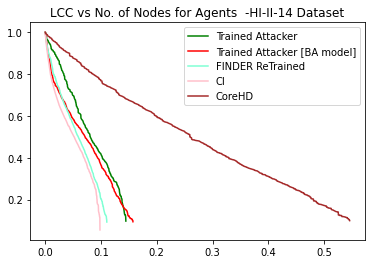

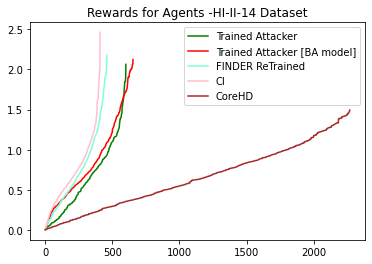

Trained Attacker [191, 160, 53, 170, 2161, 2383, 4191, 4419, 5017, 5181, 6644, 7243, 7615, 7619, 6086, 2916, 192, 1297, 5186, 6330, 200, 174, 756, 177, 221, 1115, 1269, 1317, 1320, 1319, 1380, 1381, 1364, 1365, 1524, 1971, 2074, 3180, 529, 3284, 3590, 2004, 5940, 6206, 1522, 1523, 150, 417, 6903, 6554, 2692, 4101, 203, 659, 758, 246, 644, 1263, 1277, 2051, 8948, 8943, 8882, 1220, 7429, 2315, 140, 296, 153, 155, 145, 334, 147, 656, 330, 1344, 1737, 1475, 188, 418, 1266, 165, 772, 2036, 6365, 7782, 2235, 258, 458, 507, 769, 154, 273, 1124, 134, 377, 1980, 5767, 707, 2044, 193, 167, 1102, 2045, 255, 5, 483, 528, 6657, 214, 2037, 4342, 338, 168, 2764, 765, 4309, 8478, 7921, 7480, 2604, 194, 4340, 8125, 3880, 8124, 195, 1873, 8895, 137, 502, 795, 268, 565, 285, 158, 1254, 1469, 426, 3872, 6083, 6879, 201, 176, 3, 8586, 581, 4088, 196, 1491, 3855, 3294, 73, 1140, 197, 2473, 598, 3212, 961, 8582, 8502, 8587, 337, 270, 8146, 1188, 651, 2035, 4187, 247, 8130, 287, 628, 611, 441, 40, 265, 646, 1

Trained Attacker [BA model] [170, 8036, 6620, 5912, 5135, 2459, 4309, 6315, 7332, 7530, 3788, 2750, 7614, 5758, 5124, 3948, 5652, 3723, 5161, 4784, 7306, 4917, 5672, 5651, 4180, 2046, 5188, 8258, 160, 191, 1266, 756, 334, 130, 463, 418, 5936, 283, 3567, 565, 174, 192, 1016, 273, 1524, 1220, 6554, 612, 1522, 5181, 188, 2234, 6644, 337, 8150, 656, 708, 5184, 203, 154, 1523, 200, 2035, 150, 258, 145, 1737, 1475, 147, 2037, 758, 507, 1063, 649, 1102, 165, 655, 140, 920, 255, 4898, 155, 3586, 3587, 2235, 707, 40, 1706, 7920, 167, 2604, 296, 246, 2036, 2993, 285, 426, 3976, 7765, 772, 528, 211, 186, 2795, 795, 2409, 628, 1124, 2764, 2635, 918, 1980, 193, 1254, 729, 6089, 176, 2356, 214, 1792, 268, 80, 2044, 201, 338, 194, 3294, 134, 765, 2045, 646, 1469, 1188, 247, 2473, 3114, 5, 377, 502, 458, 1964, 483, 158, 8112, 2318, 677, 441, 252, 769, 168, 529, 8125, 561, 970, 1873, 2671, 1277, 581, 1725, 3880, 2489, 4697, 822, 598, 611, 3284, 2961, 270, 3212, 2641, 73, 5096, 3196, 8130, 196, 1271, 39

FINDER ReTrained [160, 170, 130, 334, 191, 2234, 200, 463, 756, 612, 1266, 192, 174, 283, 565, 203, 418, 656, 1016, 296, 165, 140, 155, 458, 150, 2235, 507, 769, 2409, 145, 931, 188, 134, 708, 154, 273, 72, 1491, 1124, 377, 195, 193, 337, 772, 920, 1220, 1475, 178, 1063, 487, 2035, 502, 147, 5, 758, 144, 765, 603, 649, 770, 483, 651, 80, 194, 189, 137, 338, 258, 1737, 2099, 133, 528, 303, 187, 787, 374, 2604, 40, 196, 1132, 2037, 168, 1049, 1102, 918, 167, 785, 176, 2057, 925, 282, 255, 214, 1019, 707, 795, 186, 211, 628, 1873, 2036, 2795, 1254, 246, 3294, 491, 2356, 1706, 285, 3114, 1792, 650, 426, 4280, 158, 970, 1465, 2961, 1140, 2764, 263, 1469, 268, 3, 2635, 646, 441, 2473, 1188, 299, 287, 1600, 3872, 611, 494, 4340, 3204, 2318, 1088, 197, 4342, 3513, 1271, 247, 529, 1020, 1057, 1021, 598, 910, 4001, 1964, 280, 729, 682, 992, 4775, 1060, 4370, 1277, 2044, 201, 822, 578, 442, 561, 4905, 1276, 4341, 302, 2313, 2045, 3196, 294, 291, 3024, 3017, 581, 1939, 3949, 1087, 2489, 232, 2004,

CI [130, 283, 708, 2234, 1063, 2409, 337, 80, 677, 1016, 463, 167, 191, 83, 170, 334, 147, 612, 1220, 1266, 1792, 3819, 565, 758, 3114, 918, 707, 2489, 656, 285, 186, 177, 160, 418, 211, 529, 795, 2700, 5757, 273, 920, 3180, 2540, 1835, 426, 1363, 1706, 40, 1271, 649, 1491, 1102, 2635, 214, 822, 1412, 566, 6049, 2795, 1254, 1680, 5490, 1451, 154, 145, 528, 247, 2318, 598, 3024, 3196, 2356, 3204, 3949, 3284, 3188, 3490, 4697, 3225, 4469, 2035, 192, 628, 502, 1964, 1737, 2037, 2036, 2044, 2045, 1725, 2961, 678, 232, 3724, 1344, 2737, 1674, 2764, 634, 4708, 3786, 1598, 1226, 4843, 540, 3787, 784, 2811, 5728, 3974, 1955, 3181, 5014, 22, 3870, 4849, 1316, 4530, 1633, 1977, 8600, 2235, 1277, 1787, 200, 140, 268, 5, 611, 3243, 605, 2652, 258, 255, 201, 729, 1188, 441, 2641, 4685, 3178, 646, 581, 168, 970, 1612, 73, 561, 326, 6293, 3017, 1263, 328, 644, 1283, 1289, 4220, 1400, 4001, 2335, 374, 2845, 3839, 5102, 174, 155, 59, 2, 1279, 2962, 1979, 1417, 2074, 575, 3722, 547, 457, 1738, 4155, 136

In [ ]:
file_list = ['HI-II-14','bio-grid-human']#['Digg_LCC']#['Gnutella31']
#file_list = ['GeneInteraction','ReliableInteraction']#['Gnutella31']bio-grid-human.txt
#file_list = ["test","testTrain","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience']
#file_list = ['powergrid']
file_path =  "./real/"
AUC = visual_evaluation(file_path,file_list,attacker_differentGraph, attacker_BATypeGraph)


In [ ]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','Core','Random']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','RAND''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

## Synthetic Motifs

Trained Attacker [325, 324, 320, 0, 309, 70, 6, 225, 45, 15, 23, 125, 5, 4, 73, 10, 12, 1, 27, 2, 214, 8, 71, 124, 22, 141, 287, 167, 226, 7, 75, 102, 28, 154, 9, 126, 13, 155, 180, 181, 103, 217, 19, 206, 3, 128, 85, 17, 250, 80, 208, 31, 248, 234, 35, 14, 143, 178, 254, 101, 26, 259, 216, 168, 18, 130, 119, 228, 40, 219, 177, 142, 151, 246, 215, 184, 83, 76, 25, 29, 176, 283, 227, 16, 72, 260, 32, 105, 77, 236, 146, 253, 263, 30, 129, 114, 78, 109, 171, 302, 90, 39, 131, 284, 153, 277, 110, 306, 295, 317, 312, 198, 173, 321, 319, 264, 261, 21, 136, 156, 282, 65, 316, 54]
Trained Attacker [BA model] [0, 6, 1, 70, 125, 10, 214, 4, 225, 27, 2, 12, 22, 7, 141, 15, 73, 71, 226, 124, 8, 9, 102, 75, 5, 28, 13, 17, 154, 85, 126, 180, 3, 103, 167, 35, 234, 23, 206, 181, 248, 56, 128, 168, 254, 143, 119, 155, 177, 25, 14, 215, 26, 80, 178, 246, 208, 19, 40, 287, 31, 78, 217, 130, 259, 219, 194, 105, 34, 29, 184, 60, 32, 51, 72, 54, 236, 176, 227, 216, 153, 30, 76, 46, 228, 151, 263, 146, 101, 

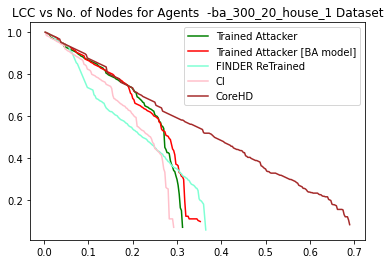

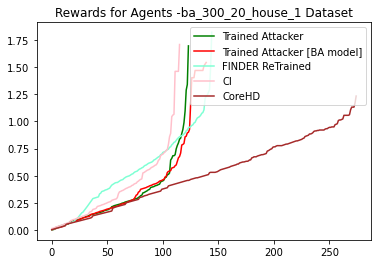

Trained Attacker [20, 0, 287, 113, 8, 6, 56, 228, 2, 109, 61, 4, 79, 178, 10, 14, 114, 225, 13, 9, 169, 16, 104, 354, 7, 58, 82, 25, 76, 238, 117, 156, 11, 18, 59, 80, 284, 17, 115, 308, 200, 212, 272, 121, 81, 182, 187, 105, 188, 83, 183, 84, 125, 60, 234, 24, 171, 158, 208, 57, 259, 128, 150, 167, 62, 192, 64, 46, 160, 119, 134, 34, 254, 130, 65, 5, 12, 301, 204, 116, 201, 288, 152, 306, 35, 85, 118, 277, 248, 268, 205, 227, 249, 203, 87, 133, 193, 159, 93, 239, 336, 312, 328, 49, 170, 148, 44, 27, 290, 224, 26, 173, 120, 211, 317, 218, 330, 335, 197, 244, 151, 347, 28, 310, 149, 233, 322, 321, 340, 230, 298, 29]
Trained Attacker [BA model] [6, 0, 56, 79, 10, 14, 4, 8, 16, 169, 58, 13, 114, 18, 117, 82, 2, 86, 7, 178, 225, 165, 104, 113, 59, 156, 80, 20, 238, 25, 210, 11, 200, 57, 9, 24, 83, 105, 188, 284, 81, 183, 212, 182, 121, 158, 171, 60, 190, 272, 84, 61, 125, 234, 130, 259, 76, 187, 150, 174, 64, 12, 261, 115, 65, 148, 208, 5, 254, 203, 128, 227, 172, 268, 257, 93, 237, 224, 1

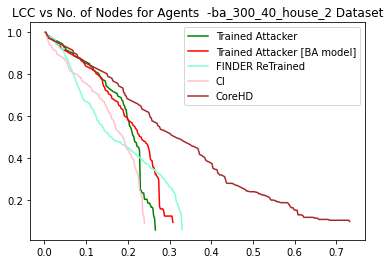

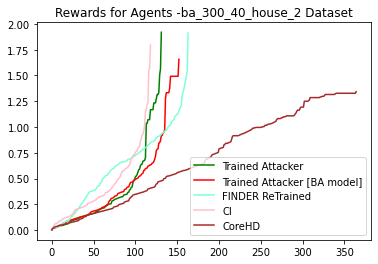

Trained Attacker [359, 7, 4, 1, 369, 367, 368, 13, 185, 90, 24, 0, 6, 320, 56, 152, 22, 9, 140, 2, 70, 239, 128, 17, 158, 188, 251, 23, 82, 21, 171, 81, 11, 35, 25, 31, 199, 138, 356, 10, 202, 172, 8, 77, 42, 19, 39, 16, 86, 221, 333, 227, 96, 162, 27, 106, 20, 252, 28, 177, 26, 30, 104, 294, 214, 5, 207, 88, 18, 131, 290, 43, 187, 156, 110, 40, 15, 206, 175, 95, 153, 57, 135, 14, 107, 279, 94, 269, 109, 84, 127, 293, 271, 193, 133, 264, 268, 161, 54, 306, 163, 195, 130, 235, 167, 189, 105, 91, 126, 173, 215, 29, 114, 66, 47, 316, 157, 330, 282, 355, 200, 201, 296, 363, 184, 329, 348, 347, 253, 93, 340, 352, 317, 335, 361, 364, 351, 83, 312, 322, 360]
Trained Attacker [BA model] [0, 9, 4, 13, 7, 140, 17, 1, 2, 21, 6, 81, 82, 11, 188, 128, 171, 8, 152, 86, 221, 172, 202, 158, 10, 251, 106, 199, 31, 39, 25, 16, 24, 22, 131, 20, 42, 28, 77, 292, 23, 26, 162, 33, 252, 177, 104, 214, 88, 18, 144, 206, 209, 43, 92, 290, 95, 5, 234, 294, 127, 30, 289, 107, 161, 27, 35, 126, 187, 135, 175, 19,

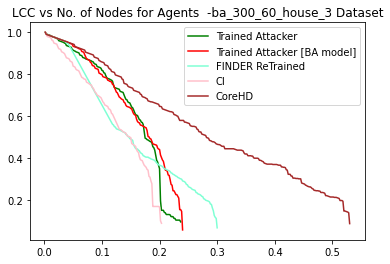

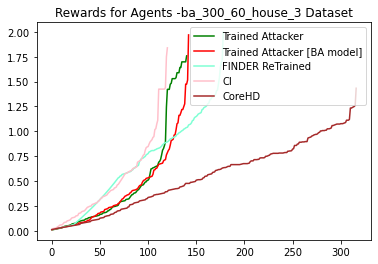

Trained Attacker [364, 1, 106, 14, 9, 162, 0, 3, 6, 8, 7, 75, 119, 5, 13, 143, 22, 12, 174, 17, 15, 83, 131, 53, 101, 10, 431, 429, 430, 146, 144, 172, 77, 148, 29, 2, 11, 4, 243, 248, 270, 25, 173, 123, 155, 79, 19, 178, 387, 28, 35, 34, 102, 94, 249, 294, 81, 38, 107, 104, 213, 43, 121, 134, 86, 26, 230, 103, 21, 18, 44, 253, 195, 118, 201, 129, 132, 16, 84, 352, 214, 170, 286, 31, 110, 247, 32, 24, 124, 133, 281, 263, 98, 46, 87, 631, 632, 630, 218, 184, 76, 275, 60, 250, 61, 298, 111, 108, 33, 200, 20, 288, 331, 329, 78, 301, 252, 245, 314, 344, 68, 280, 23, 336, 41, 627, 326, 374, 153, 327, 464, 368, 236, 396, 370, 130, 382, 321, 363, 231]
Trained Attacker [BA model] [0, 6, 7, 17, 75, 9, 8, 14, 143, 1, 158, 5, 13, 101, 148, 243, 25, 285, 162, 119, 181, 3, 144, 79, 172, 62, 192, 106, 155, 170, 178, 22, 241, 12, 318, 4, 77, 46, 295, 83, 11, 29, 386, 19, 67, 87, 235, 123, 381, 2, 272, 245, 323, 431, 110, 103, 15, 99, 94, 21, 102, 174, 53, 270, 43, 10, 201, 28, 249, 81, 173, 165, 16, 

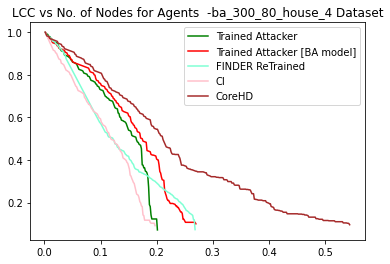

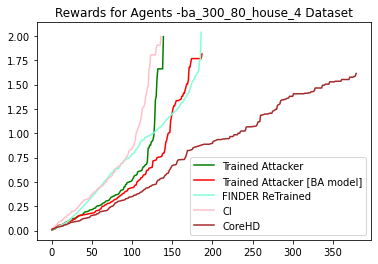

Trained Attacker [106, 387, 411, 409, 410, 0, 7, 4, 14, 107, 423, 421, 422, 9, 419, 417, 418, 6, 427, 425, 426, 11, 24, 108, 331, 159, 8, 23, 2, 370, 190, 310, 1, 141, 5, 13, 10, 15, 16, 31, 173, 274, 172, 221, 17, 224, 352, 91, 29, 33, 12, 43, 20, 176, 135, 28, 180, 164, 18, 207, 175, 25, 188, 260, 36, 46, 136, 80, 273, 19, 281, 134, 21, 345, 26, 112, 165, 114, 47, 139, 201, 210, 90, 38, 284, 40, 83, 79, 109, 211, 22, 258, 227, 177, 94, 302, 87, 76, 323, 57, 232, 39, 120, 315, 84, 137, 297, 217, 382, 167, 300, 115, 191, 256, 199, 179, 166, 95, 301, 105, 34, 82, 157, 151, 226, 298, 218, 55, 234, 110, 133, 60, 313, 233, 346, 58, 98, 445, 156, 62, 101, 263, 41, 376, 392, 526, 295, 453, 365, 220, 354, 53]
Trained Attacker [BA model] [0, 6, 9, 11, 159, 331, 23, 332, 8, 24, 14, 17, 2, 13, 107, 213, 300, 157, 108, 190, 12, 156, 5, 135, 130, 4, 164, 204, 15, 274, 304, 141, 7, 25, 16, 1, 180, 79, 33, 172, 297, 28, 29, 260, 514, 515, 513, 211, 90, 21, 176, 43, 31, 281, 175, 126, 80, 91, 221, 36

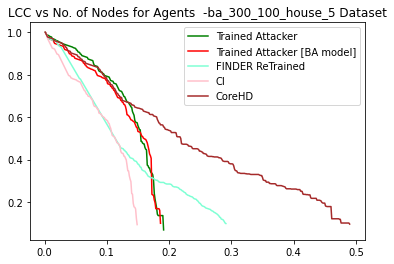

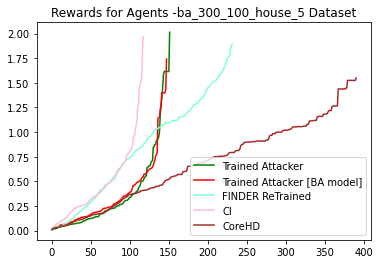

Trained Attacker [184, 10, 8, 6, 7, 288, 16, 13, 233, 108, 0, 4, 195, 93, 53, 60, 206, 9, 11, 65, 61, 39, 183, 12, 106, 86, 107, 95, 1, 180, 17, 64, 69, 103, 150, 43, 66, 21, 15, 172, 197, 182, 198, 67, 145, 3, 26, 5, 70, 68, 133, 20, 122, 35, 24, 14, 18, 194, 36, 141, 269, 44, 47, 117, 134, 282, 37, 105, 33, 228, 231, 71, 56, 199, 217, 298, 242, 104, 226, 152, 2, 151, 252, 255, 272, 131, 157, 235, 97, 312, 205, 32, 236, 23, 80, 254, 209, 92, 343, 72, 268, 114, 125, 227, 311, 373, 160, 27, 171, 317, 277, 175, 325, 429, 392, 451, 443, 57, 384, 400, 416, 474, 218, 140, 329, 346, 367, 360, 376, 466, 212, 342, 267, 305, 261, 85, 337, 352, 408, 436, 286, 423, 143, 220, 101, 48, 173]
Trained Attacker [BA model] [0, 7, 6, 93, 4, 49, 11, 86, 9, 8, 10, 150, 13, 66, 17, 64, 12, 106, 15, 16, 1, 108, 95, 103, 25, 69, 172, 26, 195, 67, 18, 182, 70, 197, 24, 133, 35, 233, 145, 21, 68, 105, 5, 198, 65, 20, 37, 107, 117, 141, 130, 14, 3, 99, 207, 71, 80, 206, 47, 217, 183, 282, 2, 272, 110, 134, 218, 

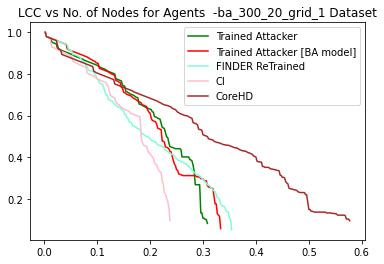

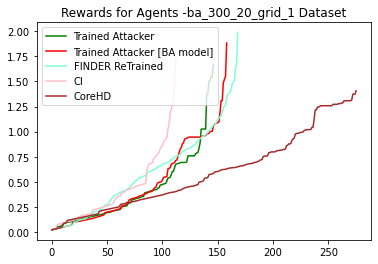

Trained Attacker [13, 2, 15, 6, 331, 44, 175, 0, 14, 120, 130, 5, 54, 126, 7, 165, 9, 45, 266, 10, 19, 11, 90, 4, 333, 210, 12, 334, 17, 212, 57, 321, 134, 104, 382, 383, 93, 327, 135, 3, 47, 220, 214, 139, 92, 56, 133, 105, 131, 91, 262, 192, 46, 125, 100, 145, 48, 128, 173, 8, 140, 251, 162, 166, 20, 142, 107, 196, 63, 122, 82, 1, 206, 235, 68, 276, 241, 55, 16, 215, 305, 144, 225, 228, 31, 24, 255, 289, 306, 69, 349, 66, 108, 146, 269, 194, 250, 246, 132, 59, 151, 72, 26, 163, 282, 76, 275, 285, 616, 478, 341, 106, 430, 326, 213, 119, 109, 324, 98, 605, 58, 620, 319, 346, 83, 547, 632, 422, 415, 570, 555, 624, 593, 585, 455, 407, 654, 193, 347, 337, 352, 317, 360, 368, 376, 392, 399, 439, 447, 463, 471, 492, 516, 296, 136, 600, 267, 303, 642, 505, 529, 544, 567, 582, 615, 508, 74, 290, 257, 345, 154, 485, 647, 260, 23, 148, 500, 524, 539, 562, 577, 610, 603, 259]
Trained Attacker [BA model] [7, 6, 54, 2, 44, 45, 0, 9, 12, 13, 90, 4, 17, 130, 93, 11, 19, 10, 104, 210, 111, 15, 91, 26

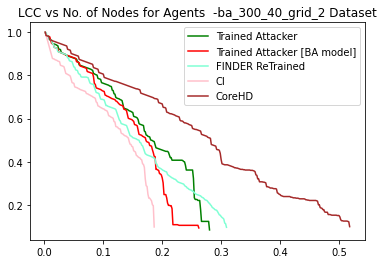

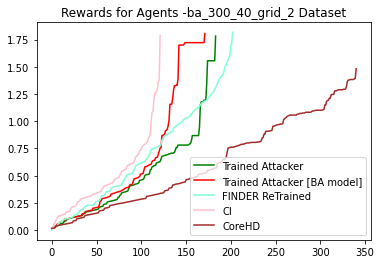

Trained Attacker [7, 115, 103, 233, 4, 9, 0, 8, 102, 6, 335, 144, 1, 12, 250, 106, 55, 14, 59, 177, 16, 87, 295, 357, 11, 2, 89, 78, 5, 21, 307, 18, 211, 216, 155, 195, 196, 32, 108, 140, 180, 15, 142, 17, 119, 23, 141, 182, 40, 163, 27, 181, 113, 104, 114, 337, 188, 29, 80, 77, 85, 157, 341, 30, 219, 356, 107, 110, 154, 25, 88, 239, 36, 60, 71, 286, 61, 10, 273, 265, 167, 297, 99, 212, 220, 26, 267, 122, 256, 33, 253, 31, 288, 56, 274, 164, 43, 202, 246, 28, 271, 261, 13, 198, 50, 171, 365, 105, 735, 686, 184, 423, 500, 661, 818, 400, 567, 173, 130, 346, 430, 352, 309, 367, 722, 519, 156, 121, 342, 556, 512, 748, 333, 330, 524, 638, 781, 575, 727, 757, 670, 662, 599, 542, 812, 623, 797, 654, 827, 143, 572, 511, 83, 703, 789, 305, 268, 422, 376, 384, 392, 408, 416, 441, 449, 457, 473, 481, 489, 503, 534, 550, 583, 146, 607, 695, 496, 159, 63, 200, 84, 120, 372, 283, 561, 303, 252, 563, 470, 596, 620, 635, 651, 683, 747, 770, 778, 358, 226, 240]
Trained Attacker [BA model] [9, 4, 6, 0, 

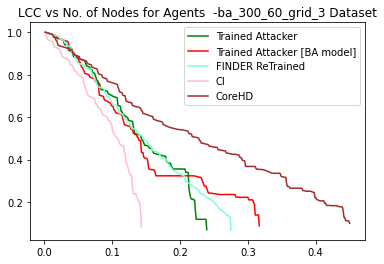

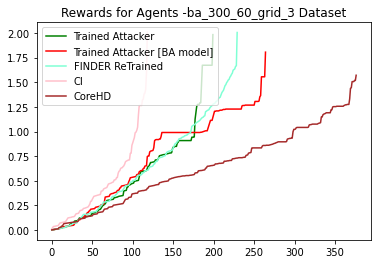

Trained Attacker [0, 15, 6, 10, 247, 5, 8, 9, 368, 29, 11, 127, 7, 319, 45, 86, 51, 18, 446, 447, 4, 108, 105, 14, 88, 357, 87, 208, 26, 488, 487, 27, 463, 462, 123, 2, 397, 398, 3, 21, 24, 175, 13, 206, 519, 520, 34, 166, 387, 200, 19, 103, 50, 157, 199, 356, 107, 126, 131, 188, 340, 32, 135, 37, 338, 44, 721, 722, 298, 22, 17, 179, 527, 528, 156, 23, 28, 178, 52, 230, 234, 78, 155, 239, 303, 291, 25, 120, 20, 262, 40, 189, 36, 113, 41, 277, 383, 106, 244, 129, 112, 213, 43, 273, 159, 227, 304, 69, 286, 60, 35, 211, 218, 61, 342, 240, 254, 312, 12, 109, 110, 289, 72, 1, 214, 553, 595, 301, 888, 334, 100, 377, 358, 225, 264, 848, 203, 337, 438, 700, 370, 384, 470, 515, 345, 65, 90, 1006, 704, 966, 632, 740, 592, 331, 504, 407, 763, 137, 707, 834, 810, 851, 669, 756, 771, 929, 899, 715, 859, 456, 729, 328, 391, 415, 423, 431, 473, 481, 496, 537, 545, 562, 570, 584, 601, 609, 616, 624, 677, 732, 748, 802, 818, 826, 842, 874, 907, 921, 952, 974, 982, 1014, 437, 216, 959, 49, 313, 117, 513

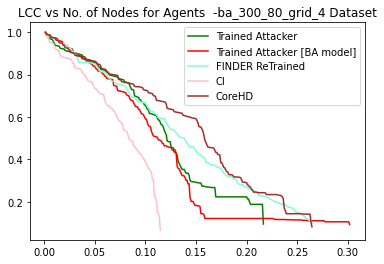

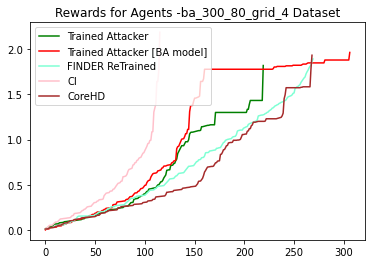

Trained Attacker [0, 4, 8, 6, 11, 33, 9, 54, 3, 67, 7, 93, 240, 19, 349, 5, 117, 86, 119, 132, 283, 53, 343, 10, 191, 137, 87, 380, 55, 118, 371, 102, 90, 101, 72, 252, 360, 16, 391, 688, 17, 32, 2, 24, 251, 572, 573, 26, 12, 393, 394, 133, 136, 14, 56, 159, 13, 149, 18, 357, 69, 162, 359, 362, 50, 276, 148, 153, 103, 22, 269, 15, 229, 78, 385, 77, 691, 36, 216, 539, 284, 540, 23, 57, 68, 179, 173, 91, 131, 403, 246, 37, 206, 381, 982, 388, 983, 218, 226, 156, 140, 1, 105, 310, 121, 556, 557, 203, 29, 215, 83, 21, 333, 175, 122, 62, 25, 164, 204, 48, 58, 157, 314, 330, 320, 111, 248, 279, 139, 82, 45, 89, 316, 254, 257, 195, 1159, 249, 604, 549, 585, 912, 898, 429, 1186, 306, 706, 875, 402, 887, 1147, 1078, 180, 351, 839, 669, 129, 812, 372, 379, 514, 353, 530, 960, 387, 329, 499, 748, 1110, 945, 1141, 732, 1180, 976, 1133, 582, 804, 1024, 590, 907, 1032, 1156, 700, 1070, 1094, 325, 630, 1017, 258, 866, 406, 607, 411, 419, 435, 443, 451, 459, 467, 475, 483, 491, 507, 550, 566, 598, 614

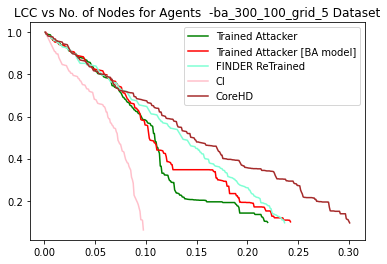

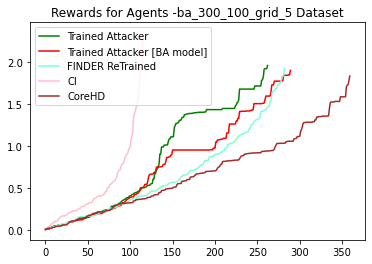

In [15]:
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3', 'tree_8_80_grid_4', 'tree_8_100_grid_5']
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
#file_list = ['tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3', 'tree_8_80_grid_4', 'tree_8_100_grid_5']
file_path = "./Cross_Validation/GNNexplanation/"
AUC = visual_evaluation(file_path,file_list,attacker_differentGraph, attacker_BATypeGraph)

In [16]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','Random']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','RAND''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 RAND	 BEST
ba_300_20_house_1 => 	91.93 	95.30 	85.38 	80.32 	CI

ba_300_40_house_2 => 	93.54 	100.97 	90.34 	79.47 	CI

ba_300_60_house_3 => 	94.65 	98.57 	96.31 	77.22 	CI

ba_300_80_house_4 => 	95.01 	111.39 	94.78 	77.09 	CI

ba_300_100_house_5 => 	110.31 	106.61 	109.31 	77.01 	CI

ba_300_20_grid_1 => 	99.37 	101.08 	96.27 	76.94 	CI

ba_300_40_grid_2 => 	114.62 	99.53 	107.49 	77.50 	CI

ba_300_60_grid_3 => 	120.85 	132.63 	126.91 	78.34 	CI

ba_300_80_grid_4 => 	124.45 	122.50 	142.50 	76.38 	CI

ba_300_100_grid_5 => 	130.28 	145.55 	158.91 	74.30 	CI



# New Synthetic Mortif

Trained Attacker [47, 19, 15, 6, 12, 0, 9, 2, 8, 11, 44, 5, 16, 24, 10, 1, 61, 21, 49, 46, 45, 56, 14, 43, 64, 70, 69, 71, 40]
Trained Attacker [BA model] [6, 0, 12, 9, 11, 8, 19, 2, 16, 5, 10, 24, 44, 43, 46, 1, 23, 21, 56, 45, 14, 54, 49, 47, 15, 64, 40, 70, 69]
FINDER ReTrained [0, 6, 12, 9, 64, 69, 71, 68, 67, 66, 70, 43, 76, 14, 79, 33, 8, 19, 27, 21, 20, 54, 11, 16, 49, 15, 47, 24, 10, 45, 56, 1, 44, 2, 5, 46, 40]
CI [44, 68, 71, 69, 64, 70, 43, 19, 12, 0, 47, 6, 15, 24, 13, 9, 8, 2, 46, 61, 21, 18, 10, 38, 37, 1, 40, 16, 56, 22, 35, 57, 72, 73, 76, 77, 27, 20, 59, 63, 4]
CoreHD [6, 0, 12, 9, 11, 8, 15, 16, 47, 2, 45, 10, 5, 20, 28, 19, 34, 37, 46, 29, 61, 4, 22, 18, 31, 27, 35, 54, 1, 42, 32, 38, 50, 7, 3, 23, 60, 59, 53, 79, 109, 108, 33, 106, 107, 40, 24, 36, 63, 70, 103, 21, 17, 101, 58, 39, 105, 62, 44, 48]


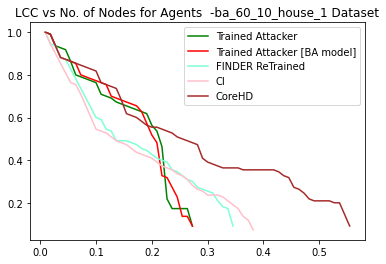

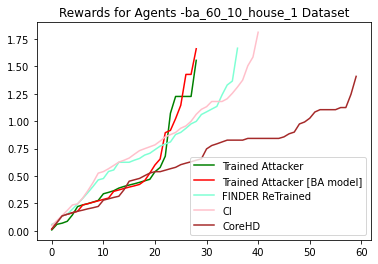

Trained Attacker [1, 51, 9, 6, 0, 8, 10, 47, 11, 7, 61, 19, 17, 59, 25, 60, 48, 2, 5, 13, 3, 74, 29, 72, 35, 67, 98, 71, 78, 68, 80, 79, 70, 66, 73, 50]
Trained Attacker [BA model] [0, 47, 1, 6, 9, 8, 11, 10, 51, 17, 41, 7, 59, 61, 25, 3, 48, 13, 2, 5, 136, 74, 29, 72, 35, 67, 79, 78, 71, 68, 66, 73, 80, 70, 76, 98, 50]
FINDER ReTrained [0, 47, 6, 1, 74, 9, 68, 73, 71, 80, 66, 70, 79, 76, 72, 78, 49, 75, 69, 67, 10, 51, 77, 35, 5, 61, 81, 56, 62, 98, 33, 52, 17, 19, 11, 58, 8, 48, 3, 7, 2, 59, 25, 13, 50]
CI [0, 6, 9, 17, 3, 47, 1, 8, 48, 5, 59, 51, 11, 25, 29, 7, 13, 50, 10, 2, 61, 19, 35, 32, 38, 22, 23]
CoreHD [0, 39, 6, 1, 9, 19, 8, 10, 47, 7, 14, 29, 18, 58, 41, 81, 37, 22, 5, 43, 3, 32, 33, 52, 31, 2, 28, 11, 55, 54, 20, 24, 91, 76, 138, 141, 139, 89, 132, 131, 130, 129, 48, 53, 23, 94, 150, 79, 149, 152, 86, 121, 71, 119, 124, 88, 83, 120, 117, 118, 65, 157, 159, 156, 60, 158, 38, 36, 92, 133, 134, 74, 136, 85, 115, 114, 51, 116, 70, 90, 30, 75, 57, 137, 135, 140, 95, 154, 27, 1

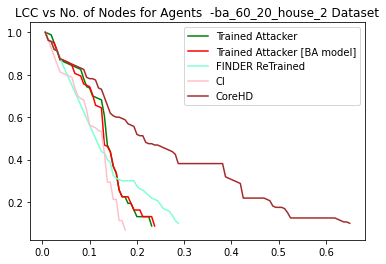

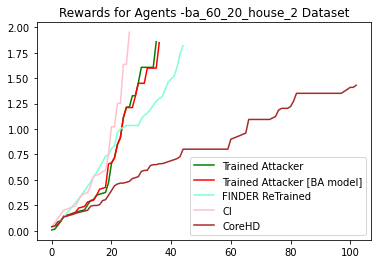

Trained Attacker [7, 12, 36, 11, 28, 0, 6, 9, 46, 45, 15, 88, 13, 8, 44, 53, 29, 37, 1, 27, 43, 2, 32, 52, 41, 4, 34, 64, 5, 139, 47, 74]
Trained Attacker [BA model] [0, 6, 7, 9, 46, 45, 12, 15, 28, 36, 53, 11, 13, 27, 29, 8, 2, 16, 43, 57, 37, 41, 1, 44, 34, 64, 5, 52, 47, 87, 83, 4]
FINDER ReTrained [0, 6, 11, 36, 64, 7, 12, 88, 83, 80, 77, 75, 85, 82, 90, 78, 81, 74, 86, 89, 79, 91, 84, 70, 48, 61, 66, 76, 28, 42, 73, 69, 71, 87, 2, 9, 29, 92, 56, 104, 15, 135, 46, 27, 44, 16, 51, 45, 52, 43, 13, 47, 35, 34, 8]
CI [0, 6, 15, 2, 7, 28, 11, 12, 36, 29, 45, 13, 46, 9, 27, 43, 44, 52, 5, 8, 37, 34, 32, 4, 35, 64, 47]
CoreHD [0, 6, 11, 58, 7, 27, 9, 49, 24, 19, 46, 36, 34, 12, 1, 22, 8, 2, 52, 15, 33, 29, 18, 3, 45, 54, 42, 62, 4, 53, 30, 65, 50, 94, 133, 134, 72, 132, 38, 44, 106, 82, 173, 175, 172, 109, 187, 85, 190, 37, 185, 39, 61, 176, 83, 31, 178, 177, 35, 107, 168, 170, 93, 167, 25, 95, 66, 207, 57, 206, 208, 209, 20, 21, 23, 99, 154, 201, 88, 198, 115, 28]


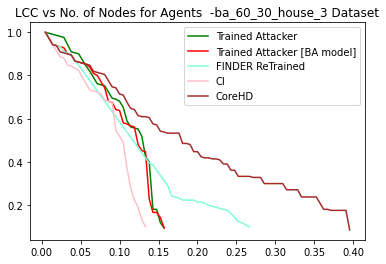

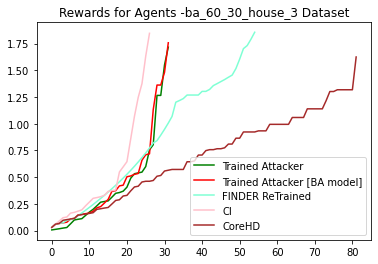

Trained Attacker [67, 0, 7, 5, 10, 6, 69, 44, 22, 55, 11, 35, 17, 9, 13, 42, 14, 45, 8, 47, 24, 32, 12, 4, 48, 26, 20, 54, 49, 3, 38, 2, 25, 19, 51, 15, 40]
Trained Attacker [BA model] [39, 0, 7, 5, 6, 65, 44, 10, 22, 17, 35, 9, 12, 45, 42, 11, 26, 24, 3, 8, 47, 13, 32, 48, 20, 19, 14, 15, 25]
FINDER ReTrained [0, 7, 6, 5, 12, 10, 47, 22, 44, 26, 24, 17, 9, 13, 32, 20, 11, 35, 42, 16, 14, 8, 48, 45, 15, 28, 3, 2]
CI [60, 47, 51, 44, 0, 12, 22, 10, 7, 58, 17, 55, 26, 5, 24, 11, 42, 35, 48, 1, 45, 6, 54, 39, 9, 41, 38, 25, 4, 43, 40]
CoreHD [0, 7, 5, 6, 10, 31, 26, 35, 9, 20, 40, 11, 19, 13, 14, 58, 56, 46, 22, 41, 57, 4, 30, 54, 51, 66, 18, 39, 49, 55, 12, 34, 59, 36, 32, 61, 45, 44, 62, 38, 43, 21, 15, 48, 3, 42, 23, 29, 2, 60, 17, 33, 8, 47, 28]


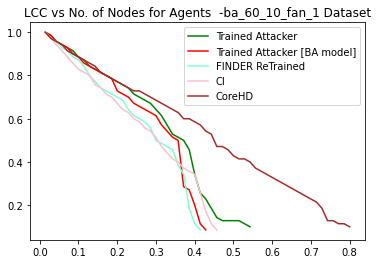

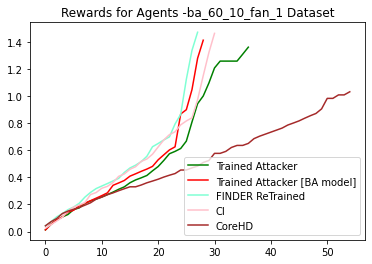

Trained Attacker [77, 0, 6, 79, 10, 11, 8, 38, 32, 5, 12, 40, 2, 7, 70, 4, 13, 17, 43, 34, 63, 16, 18, 20, 28, 9, 19, 51, 22, 55, 29]
Trained Attacker [BA model] [0, 6, 11, 12, 79, 10, 60, 71, 19, 32, 38, 8, 40, 72, 2, 75, 43, 7, 13, 34, 16, 17, 9, 20, 51, 4, 63, 28, 70, 18, 14, 29, 66, 15, 36]
FINDER ReTrained [0, 6, 12, 13, 20, 16, 11, 43, 46, 34, 28, 40, 10, 3, 38, 5, 18, 15, 14, 8, 4, 9, 7, 2, 70, 55, 17, 19, 29, 32, 22]
CI [29, 53, 52, 43, 9, 3, 11, 6, 41, 40, 0, 10, 7, 12, 18, 63, 28, 32, 60, 8, 2, 37, 38, 5, 14, 36, 70, 34, 20, 45, 30, 17, 31, 50, 46, 47, 55]
CoreHD [0, 6, 11, 4, 30, 8, 21, 2, 10, 36, 28, 70, 49, 7, 57, 42, 52, 32, 48, 65, 71, 22, 25, 9, 50, 55, 56, 24, 18, 3, 63, 20, 12, 14, 26, 27, 35, 19, 51, 23, 47, 45, 39, 37, 38, 1, 34, 41, 33, 31, 13, 5, 16]


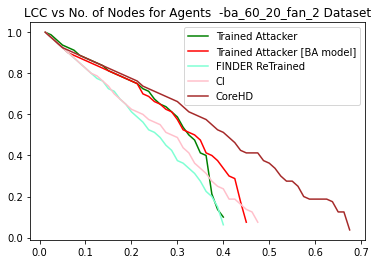

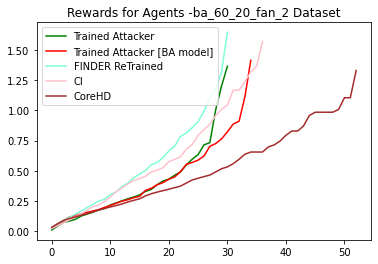

Trained Attacker [76, 78, 7, 6, 2, 8, 0, 26, 46, 1, 9, 11, 23, 13, 47, 35, 17, 25, 12, 19, 38, 54, 48, 33, 49, 55, 50, 64, 77, 83, 39, 87, 14, 16]
Trained Attacker [BA model] [6, 7, 2, 0, 8, 26, 9, 46, 11, 1, 23, 35, 12, 25, 38, 83, 54, 48, 13, 17, 67, 3, 55, 10, 88, 61, 53, 50, 15, 14, 52, 87, 19]
FINDER ReTrained [6, 2, 7, 0, 12, 54, 10, 33, 48, 50, 14, 42, 26, 9, 25, 17, 38, 1, 23, 35, 8, 39, 52, 46, 64, 13, 24, 34, 49, 63]
CI [63, 26, 11, 8, 2, 48, 64, 42, 25, 60, 12, 39, 29, 46, 23, 6, 30, 9, 50, 7, 32, 33, 0, 35, 27, 38, 47, 28, 49, 31, 24, 22]
CoreHD [6, 7, 2, 0, 5, 1, 8, 26, 20, 9, 66, 18, 22, 41, 55, 30, 51, 61, 34, 12, 3, 46, 39, 15, 23, 27, 40, 21, 32, 63, 60, 76, 33, 72, 28, 57, 37, 16, 19, 29, 43, 14, 45, 13, 64, 25, 10, 50, 59, 58, 17, 35, 62, 52, 48, 4, 47, 54, 11]


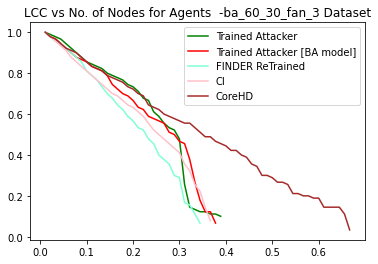

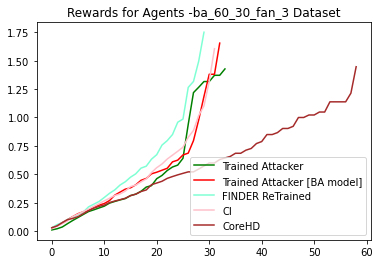

Trained Attacker [6, 1, 5, 37, 0, 3, 11, 38, 10, 8, 18, 49, 23, 25, 39, 27, 7, 58, 15, 42, 28, 52, 44, 12, 40, 14, 4, 17]
Trained Attacker [BA model] [6, 37, 0, 1, 5, 3, 11, 38, 8, 10, 49, 25, 23, 7, 33, 28, 39, 15, 58, 27, 12, 32, 29, 14, 42, 18, 16, 45, 40, 2]
FINDER ReTrained [6, 37, 0, 3, 1, 5, 11, 8, 44, 15, 28, 49, 25, 60, 38, 10, 7, 34, 23, 56, 39, 14, 22, 27, 42, 12, 9, 36]
CI [43, 28, 18, 27, 15, 14, 6, 42, 56, 40, 5, 49, 36, 7, 39, 41, 10, 25, 34, 11, 0, 26, 3, 20, 8, 58, 13, 23, 44, 29, 31, 38, 33, 12, 9, 24, 48]
CoreHD [6, 30, 0, 3, 1, 5, 24, 10, 58, 17, 37, 51, 9, 35, 32, 40, 48, 15, 53, 25, 7, 57, 47, 4, 46, 42, 20, 43, 16, 28, 18, 19, 55, 60, 14, 50, 52, 59, 13, 11, 22, 36, 29, 2, 41, 26, 31, 33, 45, 12, 44, 34]


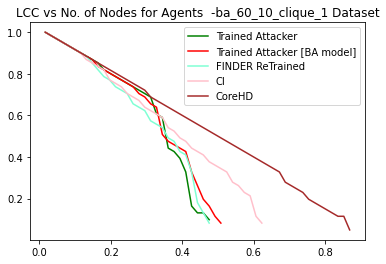

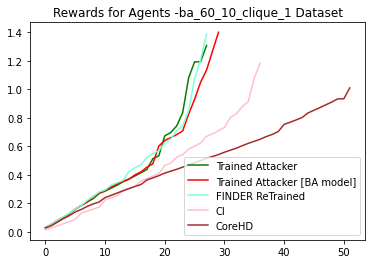

Trained Attacker [2, 25, 1, 21, 9, 23, 6, 0, 20, 26, 45, 43, 3, 8, 40, 54, 10, 13, 7, 12, 57, 36, 50, 14, 5, 16, 32, 35, 19, 38, 22, 55]
Trained Attacker [BA model] [9, 6, 2, 37, 21, 20, 0, 23, 25, 8, 1, 3, 40, 7, 10, 50, 13, 12, 35, 54, 48, 36, 38, 32, 56, 33, 47, 60, 15, 57, 27, 31, 49, 51, 19, 26]
FINDER ReTrained [9, 6, 0, 23, 20, 2, 1, 50, 21, 10, 40, 5, 25, 24, 53, 12, 27, 22, 47, 36, 48, 3, 8, 14, 33, 55, 32, 51, 38, 46, 35, 54, 56]
CI [51, 38, 3, 49, 23, 21, 13, 12, 32, 33, 25, 8, 46, 10, 40, 36, 27, 48, 6, 16, 47, 14, 0, 9, 19, 31, 54, 7, 35, 57, 1, 15, 20, 5, 39, 18, 26]
CoreHD [9, 6, 26, 12, 0, 53, 8, 1, 2, 40, 13, 3, 7, 17, 21, 38, 28, 23, 10, 25, 32, 42, 55, 59, 43, 47, 33, 51, 20, 34, 41, 36, 57, 46, 24, 35, 56, 45, 11, 16, 4, 52, 54]


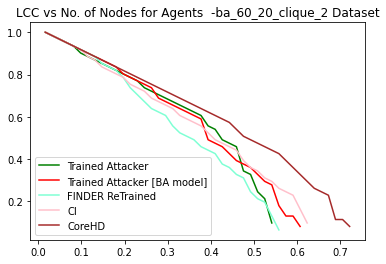

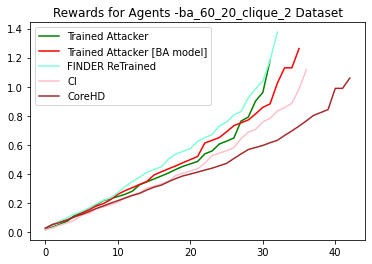

Trained Attacker [6, 57, 20, 7, 23, 9, 8, 22, 2, 11, 13, 10, 0, 36, 56, 25, 48, 21, 40, 4, 34, 19, 16, 60, 52, 58, 14, 53, 3, 51, 31, 50, 30]
Trained Attacker [BA model] [20, 6, 7, 23, 9, 8, 0, 10, 2, 13, 11, 22, 36, 48, 21, 60, 52, 4, 56, 34, 16, 14, 51, 40, 57, 19, 53, 15, 58, 18, 54]
FINDER ReTrained [6, 20, 7, 8, 9, 23, 4, 56, 10, 18, 2, 58, 57, 13, 16, 55, 15, 11, 22, 21, 0, 48, 52, 14, 19, 36, 34, 60, 54, 40]
CI [20, 56, 9, 23, 6, 4, 58, 18, 10, 57, 7, 2, 55, 13, 22, 36, 52, 34, 8, 21, 60, 48, 0, 5, 15, 45, 26, 29, 25, 27, 12, 44, 59, 46, 43]
CoreHD [14, 6, 7, 8, 9, 25, 0, 10, 53, 36, 2, 23, 60, 43, 32, 1, 57, 17, 41, 20, 16, 38, 49, 13, 46, 33, 11, 21, 34, 5, 30, 48, 15, 55, 47, 44, 18, 39, 4, 52, 54, 42, 29, 12, 37, 22, 28, 3]


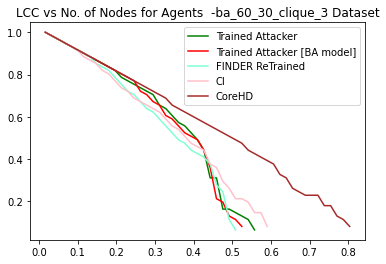

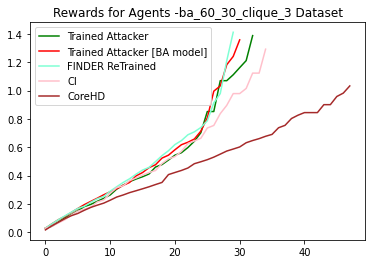

Trained Attacker [7, 13, 9, 45, 6, 0, 27, 3, 8, 10, 43, 36, 15, 5, 30, 24, 34, 26, 66, 69, 12, 29, 54, 53, 67, 78, 70, 110, 56, 16, 25, 60, 63, 65, 106, 2, 23, 44]
Trained Attacker [BA model] [7, 0, 45, 3, 6, 10, 27, 9, 8, 43, 13, 15, 36, 44, 64, 5, 51, 26, 30, 11, 34, 24, 16, 38, 12, 25, 66, 54, 1, 14, 18, 19, 20, 21, 40, 41, 48, 49, 46, 4, 37, 39, 47, 35, 57, 63, 61, 32, 33, 53, 28, 50, 56, 23, 55, 31]
FINDER ReTrained [7, 0, 3, 45, 6, 11, 27, 13, 9, 22, 2, 26, 15, 44, 30, 5, 10, 29, 17, 34, 36, 57, 43, 8, 64, 33, 12, 70, 65, 69, 96, 114, 119, 67, 105, 92, 24, 104, 116, 113, 72, 71]
CI [45, 3, 13, 27, 9, 0, 6, 7, 11, 15, 44, 29, 34, 30, 26, 2, 10, 5, 17, 36, 43, 16, 33, 37, 48, 55, 69, 8, 71, 22, 65, 19]
CoreHD [7, 0, 3, 48, 6, 10, 9, 45, 8, 35, 33, 20, 21, 5, 23, 32, 28, 43, 26, 30, 29, 62, 39, 44, 1, 77, 2, 52, 80, 63, 78, 74, 12, 76, 59, 72, 87, 53, 18, 4, 57, 38, 19, 97, 86, 50, 49, 37, 13, 51, 40, 75, 65, 88, 107, 92, 67, 118, 70, 114, 82, 27, 47, 56, 17, 71, 36]


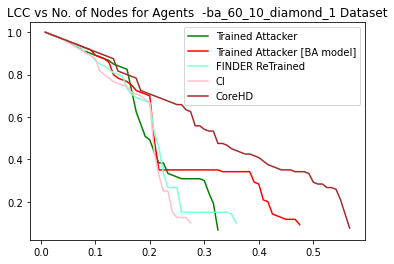

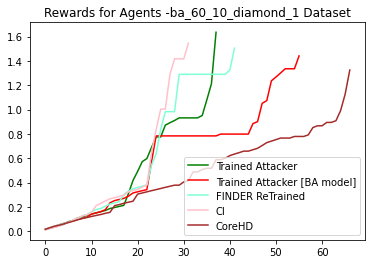

Trained Attacker [23, 8, 7, 15, 45, 6, 10, 36, 22, 11, 13, 9, 0, 5, 14, 40, 60, 61, 4, 31, 42, 57, 41, 51, 155, 52, 84, 80, 82, 69, 72, 156, 67, 76, 68, 79, 93, 107, 146, 49, 50, 66, 70, 71, 75, 26, 28, 63, 46]
Trained Attacker [BA model] [42, 6, 13, 11, 0, 22, 8, 23, 45, 15, 7, 5, 10, 39, 36, 14, 16, 4, 60, 9, 40, 26, 57, 61, 69, 118, 119, 2, 33, 37, 48, 58, 120, 121, 122, 25, 24, 41, 65, 35, 18, 51, 19, 46, 53, 20, 44]
FINDER ReTrained [13, 6, 8, 11, 0, 23, 7, 9, 15, 10, 45, 27, 28, 93, 22, 59, 36, 4, 26, 1, 14, 46, 18, 73, 42, 72, 137, 82, 179, 30, 39, 5, 57, 68, 35, 53, 77, 52, 67]
CI [6, 45, 9, 26, 57, 15, 10, 13, 23, 22, 11, 36, 8, 0, 7, 61, 4, 27, 59, 30, 14, 1, 42, 31, 5, 46, 18, 41, 39, 77, 43, 62]
CoreHD [6, 13, 11, 8, 0, 44, 16, 7, 2, 26, 22, 33, 5, 83, 54, 32, 51, 10, 37, 14, 85, 17, 60, 63, 30, 3, 47, 23, 87, 94, 20, 42, 36, 102, 59, 100, 96, 84, 12, 62, 9, 97, 41, 99, 90, 49, 74, 111, 153, 165, 73, 167, 127, 174, 89, 150, 159, 136, 162, 1, 15, 27, 45, 149, 121, 109, 178, 

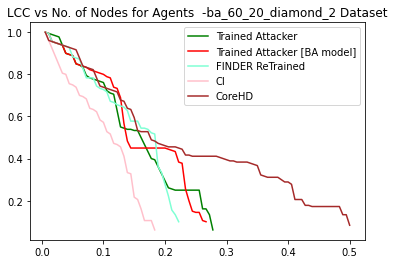

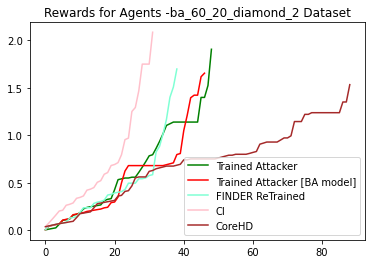

Trained Attacker [9, 8, 70, 40, 2, 7, 4, 0, 28, 43, 16, 1, 44, 10, 11, 6, 30, 106, 42, 31, 45, 34, 46, 13, 12, 201, 87, 131, 86, 79, 84, 149, 83, 89, 67, 91, 216, 197, 90, 139, 182, 26, 48, 51, 56, 61, 63, 65, 72, 73, 74, 75, 78, 82, 212, 193, 148, 222, 17, 27, 77, 195, 69, 25, 35, 85, 96, 101, 52, 107, 112, 117, 122, 127, 130, 138, 147, 158, 163, 168, 173, 176, 187, 54]
Trained Attacker [BA model] [2, 0, 8, 10, 7, 6, 28, 9, 30, 16, 40, 34, 1, 4, 45, 14, 5, 12, 43, 66, 11, 23, 54, 15, 21, 3, 60, 131, 128, 129, 130, 132, 42, 64, 58, 18, 53, 39, 49, 46]
FINDER ReTrained [0, 7, 2, 10, 8, 9, 44, 6, 16, 14, 45, 13, 40, 34, 43, 12, 27, 35, 4, 30, 11, 76, 85, 49, 28, 216, 87, 91, 54, 221, 239, 84, 211, 70, 147, 1, 77, 89, 182, 229, 38, 60, 177, 83, 206, 42, 31, 90, 82, 88]
CI [0, 2, 8, 6, 16, 44, 7, 10, 9, 12, 43, 1, 30, 40, 54, 4, 34, 45, 28, 14, 32, 37, 64, 52, 39, 11, 27, 35, 49, 88, 66]
CoreHD [0, 2, 8, 10, 7, 6, 9, 25, 1, 39, 5, 4, 49, 44, 16, 33, 54, 64, 12, 29, 11, 47, 15, 13, 40, 42, 

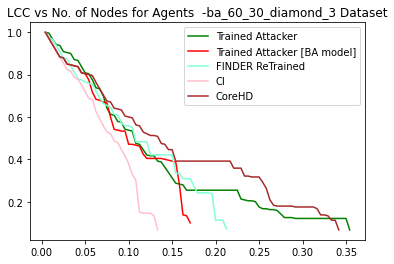

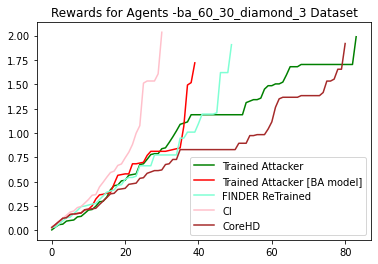

Trained Attacker [43, 24, 6, 2, 14, 7, 4, 0, 1, 49, 10, 8, 30, 11, 12, 48, 27, 19, 9, 50, 28, 13, 33, 16, 61, 36, 21, 51, 32]
Trained Attacker [BA model] [2, 6, 24, 0, 10, 7, 14, 36, 4, 11, 8, 30, 12, 27, 48, 32, 28, 19, 20, 50, 13, 43, 35, 33, 16, 61, 42, 38]
FINDER ReTrained [2, 24, 6, 0, 16, 35, 30, 11, 40, 61, 13, 38, 33, 50, 9, 28, 8, 27, 20, 14, 12, 10, 4, 7, 48, 43, 19]
CI [43, 26, 40, 38, 16, 35, 19, 47, 2, 33, 10, 11, 0, 17, 31, 24, 30, 50, 9, 37, 7, 59, 49, 53, 22, 56, 8, 5, 28, 4, 61, 51, 46, 32, 13, 25, 44, 29]
CoreHD [2, 16, 6, 0, 9, 24, 27, 25, 20, 11, 7, 10, 18, 32, 59, 51, 40, 4, 33, 28, 30, 3, 55, 36, 41, 44, 58, 21, 60, 8, 22, 46, 69, 39, 17, 1, 61, 54, 48, 31, 37, 26, 34, 14, 57, 5, 13]


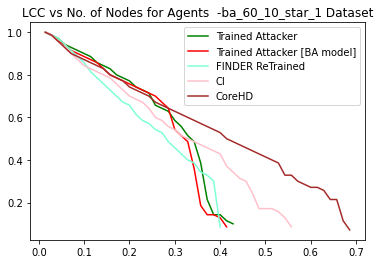

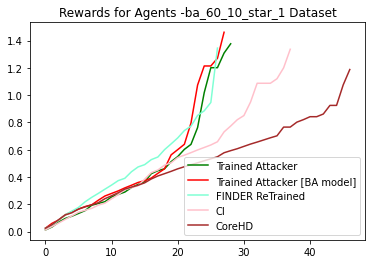

Trained Attacker [6, 47, 8, 3, 10, 77, 7, 0, 75, 38, 14, 11, 45, 49, 2, 9, 16, 41, 55, 63, 13, 58, 31, 53, 52, 4, 62, 28, 5, 25, 40, 1, 57, 17]
Trained Attacker [BA model] [6, 7, 0, 8, 3, 38, 11, 10, 45, 14, 31, 30, 72, 13, 49, 16, 21, 9, 75, 63, 2, 41, 20, 53, 52, 12, 28, 19, 46, 54, 57]
FINDER ReTrained [6, 7, 0, 8, 30, 22, 36, 63, 47, 3, 45, 13, 14, 57, 11, 31, 35, 28, 19, 10, 52, 53, 9, 2, 41, 38, 17, 49, 4, 62, 46]
CI [63, 22, 19, 53, 47, 45, 3, 11, 6, 0, 1, 10, 9, 8, 7, 57, 31, 14, 13, 30, 35, 62, 32, 33, 34, 40, 17, 64, 49, 4, 55]
CoreHD [6, 7, 0, 8, 29, 9, 10, 12, 3, 63, 32, 2, 36, 52, 22, 64, 30, 37, 18, 17, 60, 33, 11, 42, 34, 59, 53, 75, 58, 35, 45, 4, 40, 55, 57, 23, 28, 48, 16, 26, 46, 14, 13, 62, 15, 31]


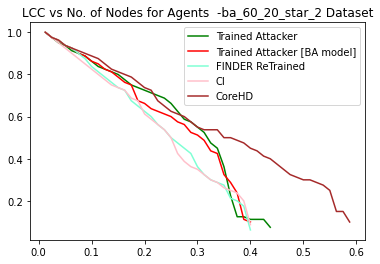

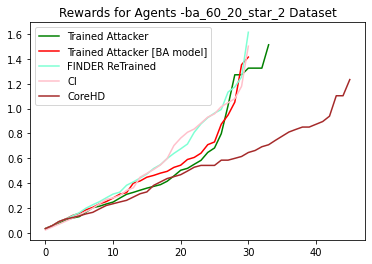

Trained Attacker [82, 0, 5, 16, 9, 1, 68, 17, 80, 18, 51, 14, 3, 7, 47, 2, 10, 36, 63, 8, 46, 35, 19, 6, 45, 42, 54, 31, 65, 28, 52, 12, 30, 56, 50]
Trained Attacker [BA model] [0, 5, 6, 8, 68, 17, 80, 51, 1, 14, 61, 3, 9, 64, 42, 49, 7, 36, 18, 10, 46, 35, 83, 45, 19, 16, 63, 54, 30, 2, 65, 24, 31, 59, 20, 12, 13]
FINDER ReTrained [0, 5, 7, 46, 36, 24, 2, 1, 42, 59, 10, 63, 55, 52, 19, 17, 6, 35, 54, 45, 18, 8, 3, 50, 22, 41, 14, 48, 9, 51, 16, 65]
CI [36, 63, 55, 54, 46, 35, 59, 45, 10, 0, 40, 50, 5, 18, 8, 7, 3, 42, 31, 2, 1, 16, 25, 65, 56, 19, 28, 9, 33, 48, 52, 4, 51, 66, 78, 47, 6]
CoreHD [0, 5, 16, 62, 13, 1, 9, 7, 3, 29, 43, 17, 8, 6, 36, 10, 25, 14, 51, 61, 15, 37, 22, 34, 52, 60, 53, 12, 30, 64, 56, 11, 18, 68, 20, 79, 2, 42, 23, 59, 65, 38, 50, 41, 39, 57, 4, 67, 28, 27, 21, 55, 45, 54, 48, 33, 24, 40, 19, 69]


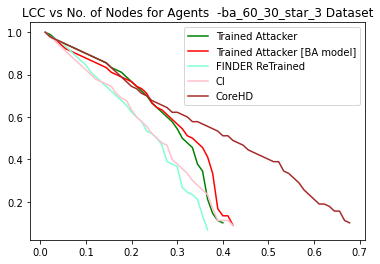

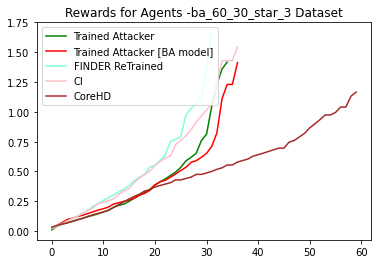

Trained Attacker [19, 0, 25, 7, 1, 6, 23, 42, 41, 40, 39, 14, 10, 8, 26, 38, 9, 12, 28, 11, 20, 24, 51, 70, 31, 120, 47, 87, 129, 137, 114, 74, 81, 98, 106, 93, 35, 4, 56, 17]
Trained Attacker [BA model] [7, 25, 0, 1, 6, 42, 23, 38, 31, 24, 61, 40, 12, 28, 35, 9, 11, 10, 39, 41, 19, 8, 20, 26, 27, 70, 71, 120, 14, 46, 51, 17, 92, 66, 69, 74, 81, 98, 106, 129, 89, 114, 142, 47, 138, 137, 95]
FINDER ReTrained [7, 1, 6, 25, 0, 120, 71, 81, 114, 66, 129, 68, 106, 65, 98, 64, 74, 62, 137, 69, 70, 67, 93, 88, 9, 23, 35, 19, 30, 32, 12, 11, 4, 14, 26, 28, 29, 17, 8, 47, 40, 39, 20, 51, 42, 10, 24]
CI [116, 113, 112, 118, 91, 88, 93, 87, 96, 97, 100, 102, 25, 20, 13, 6, 11, 12, 7, 19, 32, 51, 0, 10, 122, 124, 126, 121, 58, 41, 69, 80, 79, 40, 39, 42, 9, 27, 17, 26, 8, 33, 23, 14, 24, 28, 31, 34, 44]
CoreHD [7, 43, 1, 6, 0, 56, 17, 61, 51, 25, 29, 35, 30, 24, 58, 16, 2, 41, 40, 8, 26, 5, 14, 15, 9, 47, 21, 57, 23, 55, 20, 36, 49, 80, 53, 27, 44, 45, 38, 72, 125, 87, 132, 83, 113, 54, 67, 101, 1

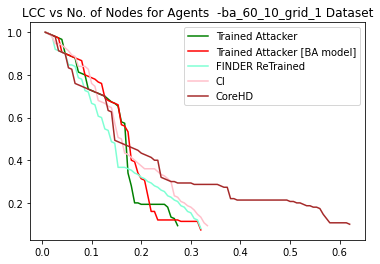

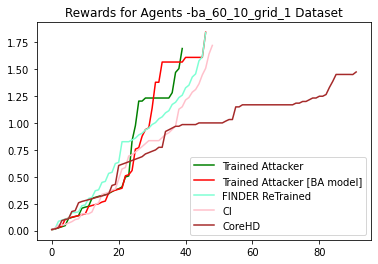

Trained Attacker [77, 7, 35, 8, 5, 4, 55, 10, 6, 0, 26, 29, 9, 33, 32, 27, 15, 38, 72, 40, 12, 22, 121, 31, 61, 78, 3, 79, 226, 195, 187, 234, 116, 156, 83, 92, 100, 108, 132, 140, 148, 172, 179, 51, 169, 208, 216, 223, 122, 86, 16, 164, 203, 127, 212, 41]
Trained Attacker [BA model] [0, 29, 32, 5, 7, 4, 6, 10, 9, 55, 35, 27, 15, 26, 8, 1, 38, 40, 14, 33, 51, 12, 25, 80, 61, 89, 85, 87, 20, 42, 43, 46, 60, 83, 84, 86, 88, 65, 122, 31, 2, 77, 53, 24, 39, 13, 58, 54, 30, 124, 17, 22, 28, 56, 11, 3, 21, 220, 211, 75, 64]
FINDER ReTrained [0, 5, 32, 4, 29, 80, 7, 211, 78, 108, 148, 100, 35, 57, 195, 226, 76, 81, 179, 187, 74, 55, 75, 10, 116, 164, 72, 64, 156, 132, 68, 71, 172, 203, 73, 140, 69, 92, 37, 234, 82, 219, 79, 123, 66, 121, 61, 77, 8, 26, 9, 58, 40, 51, 33, 6, 15, 38, 27, 12]
CI [32, 6, 55, 35, 10, 4, 27, 29, 7, 15, 61, 9, 26, 51, 0, 5, 33, 40, 12, 31, 11, 3, 8, 67, 38, 56]
CoreHD [0, 30, 5, 50, 7, 6, 9, 32, 4, 51, 36, 14, 18, 31, 20, 40, 25, 52, 60, 42, 39, 11, 67, 26, 19, 8, 2

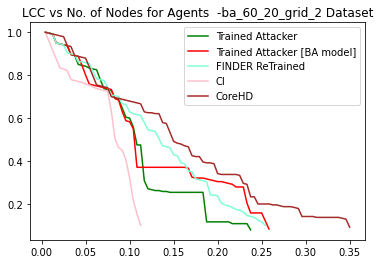

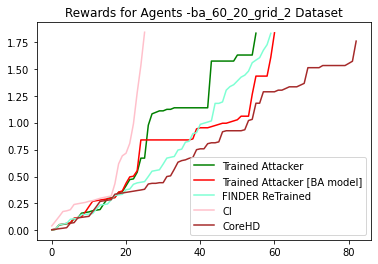

Trained Attacker [77, 7, 0, 6, 8, 76, 5, 31, 33, 26, 64, 4, 43, 90, 17, 9, 100, 101, 15, 69, 1, 52, 49, 83, 42, 172, 173, 30, 55, 87, 40, 57, 56, 21, 58, 141, 142, 80, 12, 84, 3, 75, 27, 51, 73, 28, 82, 13, 32, 10, 48, 23, 34]
Trained Attacker [BA model] [74, 6, 0, 8, 5, 7, 43, 2, 55, 35, 31, 13, 9, 4, 10, 46, 51, 27, 64, 1, 26, 52, 32, 12, 30, 33, 20, 91, 48, 203, 42, 22, 56, 45, 53, 273, 270, 272, 269, 271, 267, 268, 40, 54, 66, 298, 251, 16, 220, 77, 257, 256, 303, 252, 255, 253, 254, 258, 17, 81, 117, 138, 83, 137, 139, 65, 132, 133, 136, 134, 135, 175, 178, 71, 173, 172, 177, 174, 176, 223, 222, 221, 224, 225, 226, 11, 15, 44, 243, 85, 75, 73, 76, 86]
FINDER ReTrained [6, 5, 0, 7, 26, 8, 203, 94, 126, 83, 253, 109, 81, 47, 4, 245, 284, 276, 85, 84, 80, 292, 189, 308, 88, 73, 63, 300, 102, 118, 39, 87, 214, 76, 181, 159, 69, 72, 316, 89, 261, 229, 82, 78, 143, 67, 197, 237, 79, 206, 324, 90, 75, 151, 117, 149, 134, 221, 49, 74, 91, 77, 86, 167, 43, 138, 70, 12, 35, 10, 3, 172, 9, 3

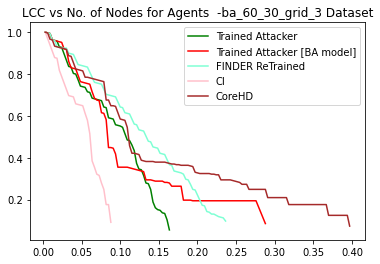

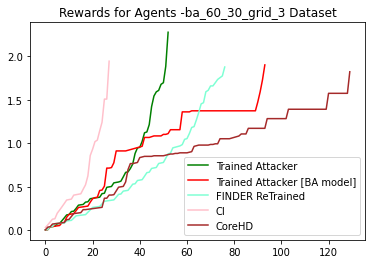

In [17]:
#file_list =['ba_60_10_house_1', 'ba_60_20_house_2', 'ba_60_30_house_3', 'ba_60_10_fan_1', 'ba_60_20_fan_2', 'ba_60_30_fan_3', 'ba_60_10_clique_1', 'ba_60_20_clique_2', 'ba_60_30_clique_3', 'ba_60_10_diamond_1', 'ba_60_20_diamond_2', 'ba_60_30_diamond_3', 'ba_60_10_cycle_1', 'ba_60_20_cycle_2', 'ba_60_30_cycle_3', 'ba_60_10_star_1', 'ba_60_20_star_2', 'ba_60_30_star_3', 'ba_60_10_grid_1', 'ba_60_20_grid_2', 'ba_60_30_grid_3']
file_list =['ba_60_10_house_1', 'ba_60_20_house_2', 'ba_60_30_house_3', 'ba_60_10_fan_1', 'ba_60_20_fan_2', 'ba_60_30_fan_3', 'ba_60_10_clique_1', 'ba_60_20_clique_2', 'ba_60_30_clique_3', 'ba_60_10_diamond_1', 'ba_60_20_diamond_2', 'ba_60_30_diamond_3', 'ba_60_10_star_1', 'ba_60_20_star_2', 'ba_60_30_star_3', 'ba_60_10_grid_1', 'ba_60_20_grid_2', 'ba_60_30_grid_3']
file_path = "./Cross_Validation/GNNexplanation/New/"
AUC = visual_evaluation(file_path,file_list,attacker_differentGraph, attacker_BATypeGraph)

In [18]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','Random']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','RAND''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 RAND	 BEST
ba_60_10_house_1 => 	18.18 	18.29 	18.33 	18.25 	differentGraph

ba_60_20_house_2 => 	20.32 	20.15 	20.64 	16.00 	CI

ba_60_30_house_3 => 	22.26 	21.47 	26.07 	17.75 	CI

ba_60_10_fan_1 => 	21.76 	19.43 	18.00 	18.56 	FinderReTrained

ba_60_20_fan_2 => 	21.55 	22.93 	18.33 	20.40 	FinderReTrained

ba_60_30_fan_3 => 	21.44 	21.17 	18.01 	19.91 	FinderReTrained

ba_60_10_clique_1 => 	18.81 	19.52 	18.51 	22.18 	FinderReTrained

ba_60_20_clique_2 => 	21.61 	22.30 	19.93 	22.50 	FinderReTrained

ba_60_30_clique_3 => 	20.76 	20.31 	19.42 	20.82 	FinderReTrained

ba_60_10_diamond_1 => 	24.24 	29.84 	23.88 	21.54 	CI

ba_60_20_diamond_2 => 	27.44 	28.25 	25.73 	17.53 	CI

ba_60_30_diamond_3 => 	32.30 	23.51 	26.68 	17.53 	CI

ba_60_10_star_1 => 	19.22 	18.50 	17.19 	21.40 	FinderReTrained

ba_60_20_star_2 => 	20.95 	20.09 	18.41 	18.18 	CI

ba_60_30_star_3 => 	24.03 	24.84 	19.79 	21.03 	FinderReTrained

ba_60_10_grid_1 => 	22.57 	24.22 	22.88 	26.01 	

# Gene DataSet

Trained Attacker [1, 2, 3, 4, 6, 18, 297, 7, 437, 13, 438, 3196, 2445, 321, 2147, 443, 2145, 38, 873, 1168, 1362, 1477, 902, 2892, 2657, 2161, 300, 229, 4113, 3024, 292, 2500, 3235, 2656, 970, 3909, 938, 1923, 2151, 701, 304, 2149, 450, 803, 1284, 145, 1925, 2501, 296, 2456, 2167, 2447, 94, 446, 309, 1048, 999, 386, 1532, 2171, 121, 349, 969, 319, 439, 415, 2156, 239, 742, 2157, 383, 431, 930, 819, 2639, 457, 2160, 293, 2175, 3360, 452, 693, 79, 566, 1194, 307, 283, 897, 2141, 1541, 1002, 2169, 227, 805, 497, 56, 427, 1135, 3780, 2172, 1099, 61, 346, 278, 1200, 3865, 330, 420, 2838, 940, 814, 453, 445, 694, 2197, 384, 341, 888, 713, 2164, 224, 2148, 345, 1335, 5, 1363, 799, 1015, 899, 2198, 403, 1092, 1799, 295, 728, 616, 887, 388, 2152, 352, 1889, 2189, 4123, 85, 316, 1882, 1166, 649, 541, 3977, 1800, 2637, 626, 4125, 755, 305, 1621, 147, 115, 2446, 157, 595, 1161, 168, 1088, 255, 141, 138, 1321, 252, 247, 436, 954, 8, 2245, 972, 798, 933, 756, 490, 894, 441, 787, 646, 154, 905, 1571,

FINDER ReTrained [319, 8, 490, 2, 297, 6, 18, 438, 38, 7, 902, 321, 3, 388, 13, 349, 457, 300, 4, 296, 1363, 437, 2147, 1392, 5, 1, 443, 2161, 94, 2447, 653, 292, 2445, 229, 1621, 1168, 145, 2157, 439, 2145, 897, 803, 626, 1362, 121, 1284, 346, 431, 1532, 566, 2501, 330, 2175, 2151, 1955, 446, 1083, 450, 2149, 1882, 970, 316, 304, 420, 819, 905, 309, 1166, 2639, 2058, 1541, 295, 302, 2148, 2171, 283, 341, 452, 293, 2637, 2167, 305, 386, 2156, 742, 352, 497, 701, 735, 597, 403, 124, 462, 1321, 383, 930, 694, 207, 324, 436, 1497, 291, 147, 2645, 182, 1335, 89, 384, 935, 1200, 1194, 2141, 2446, 814, 1135, 595, 1028, 239, 1002, 406, 428, 1834, 2152, 541, 652, 1048, 2164, 307, 79, 56, 1801, 1318, 1015, 693, 521, 2245, 345, 1800, 415, 954, 1078, 616, 756, 2172, 1088, 2451, 2160, 1179, 713, 755, 1487, 445, 354, 2169, 969, 279, 805, 227, 85, 887, 61, 1395, 1099, 422, 278, 338, 288, 1092, 940, 400, 771, 933, 2189, 224, 1799, 2069, 1571, 948, 1530, 1161, 728, 427, 1317, 1218, 575, 357, 799, 972,

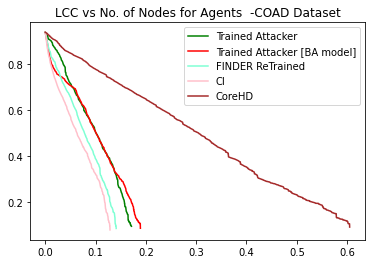

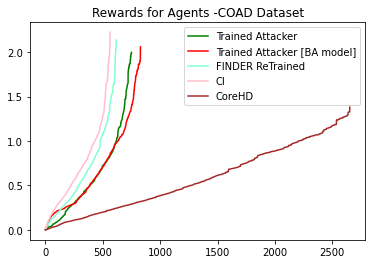

Trained Attacker [1463, 1466, 1475, 1481, 1482, 1484, 1489, 1498, 1672, 2754, 2890, 3961, 3962, 2427, 1476, 4519, 1491, 1531, 1150, 1494, 2882, 4903, 4207, 134, 2889, 1490, 3129, 1795, 2658, 3145, 1458, 1468, 1797, 3130, 1215, 1483, 1488, 623, 1495, 1799, 159, 1470, 129, 686, 1212, 1099, 268, 757, 1790, 944, 240, 286, 1627, 1465, 1464, 1471, 1687, 1474, 1497, 1480, 841, 4370, 112, 1747, 2060, 1493, 82, 712, 2419, 1784, 458, 1485, 1761, 1472, 1492, 1742, 1702, 936, 1798, 1585, 1670, 1479, 1608, 1694, 1722, 1680, 1727, 1635, 1487, 1789, 1636, 1756, 1596, 1681, 1752, 1728, 1704, 1633, 1530, 1774, 1686, 1755, 1677, 1595, 1678, 1767, 1620, 1496, 1762, 1610, 1499, 1598, 1609, 1660, 1665, 1781, 1469, 1714, 5097, 1358, 1679, 1692, 1602, 1540, 1757, 1477, 1808, 1462, 1707, 1564, 1765, 1621, 1604, 1708, 1723, 1710, 1763, 1766, 1590, 1814, 1668, 1648, 1535, 1527, 1589, 1717, 1693, 1662, 1773, 1690, 1511, 1601, 1516, 1792, 1557, 1683, 1514, 1779, 1505, 1786, 1560, 1594, 1810, 1750, 1778, 1637, 161

FINDER ReTrained [1169, 1468, 1491, 1465, 1470, 1490, 1481, 1476, 1795, 1494, 1488, 1797, 1531, 1495, 1483, 1474, 1799, 101, 1498, 1627, 1790, 1480, 1479, 1493, 1687, 1784, 1492, 1466, 1761, 1722, 1464, 1670, 1742, 1747, 1798, 1702, 1694, 1635, 1680, 1728, 1704, 1530, 1686, 1756, 1789, 1485, 1487, 1752, 1677, 1633, 1595, 1672, 1755, 1714, 1774, 1610, 1469, 1781, 1767, 1678, 1496, 1723, 1698, 1477, 1681, 1762, 1620, 1757, 1590, 1621, 1708, 1602, 1563, 1707, 1763, 1710, 1701, 1607, 1630, 1473, 1766, 1463, 1727, 1668, 1475, 1583, 1740, 1768, 1734, 1546, 1593, 25, 1587, 1661, 1636, 1512, 1525, 1612, 1472, 1513, 1616, 1754, 1715, 1652, 1484, 1667, 1489, 2175, 1482, 39, 27, 1273, 762, 801, 45, 1471, 188, 380, 13, 1676, 1545, 1703, 1655, 1597, 1571, 1764, 1579, 1744, 720, 1600, 1700, 1685, 130, 830, 1737, 2422, 1699, 1664, 1800, 1497, 1656, 1611, 1735, 1549, 1541, 1718, 124, 1760, 1666, 1888, 1499, 406, 21, 290, 1345, 1688, 824, 273, 1675, 1286, 208, 141, 320, 843, 131, 394, 3543, 623, 106, 8

CoreHD [1275, 1402, 4220, 4275, 4066, 407, 4187, 400, 2310, 107, 3372, 301, 983, 823, 1948, 2253, 390, 3277, 4272, 4295, 3448, 1403, 2645, 1218, 339, 2794, 4028, 1029, 4294, 2762, 1451, 44, 2698, 3193, 506, 4159, 1548, 2635, 2983, 1017, 4146, 385, 4504, 235, 328, 4535, 4168, 1934, 31, 526, 1367, 2454, 349, 3114, 887, 3072, 1204, 1726, 473, 1530, 1734, 3151, 3320, 1477, 1157, 1705, 3411, 2060, 920, 3106, 2950, 527, 3358, 1519, 2799, 3331, 1688, 772, 709, 692, 3279, 866, 1656, 1675, 3159, 320, 1888, 3126, 1523, 3084, 54, 353, 1437, 2968, 1906, 1099, 117, 1036, 2530, 4410, 679, 2653, 4372, 4239, 535, 4595, 479, 167, 590, 2137, 838, 2061, 3667, 201, 4451, 4274, 2652, 2779, 3666, 1257, 1015, 4342, 3643, 1335, 4479, 2636, 3433, 248, 3343, 675, 2231, 384, 3544, 4471, 1090, 934, 4037, 1078, 4472, 4282, 2567, 1086, 2162, 935, 1100, 903, 1345, 225, 2646, 1956, 4505, 1333, 386, 3399, 265, 4013, 3160, 4500, 1210, 4501, 338, 4388, 4496, 1486, 3152, 3668, 195, 4529, 3698, 2409, 729, 3697, 139, 4324,

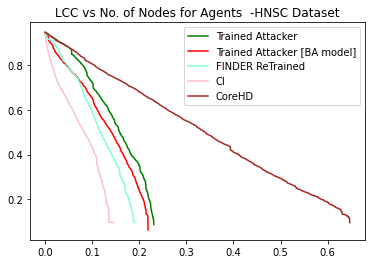

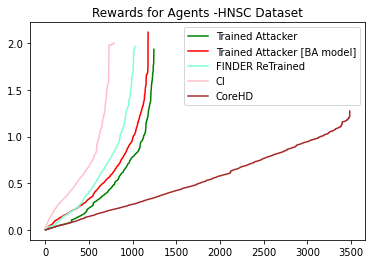

Trained Attacker [103, 104, 105, 106, 123, 110, 145, 128, 129, 182, 210, 225, 173, 183, 201, 227, 259, 273, 674, 742, 1861, 1869, 1870, 1879, 1889, 396, 138, 31, 174, 179, 242, 211, 249, 274, 309, 856, 884, 914, 131, 664, 890, 368, 285, 156, 169, 660, 50, 57, 84, 388, 436, 340, 518, 523, 526, 679, 272, 687, 98, 1014, 1145, 1422, 1611, 437, 1612, 1878, 1060, 1643, 945, 968, 1333, 1891, 609, 1127, 143, 424, 867, 662, 900, 2314, 2236, 72, 1427, 1058, 831, 1216, 1057, 1227, 1142, 1671, 887, 631, 702, 775, 601, 380, 1299, 1756, 1310, 1095, 34, 1543, 1788, 432, 1332, 96, 1555, 1697, 1736, 1693, 1737, 1647, 1114, 1769, 1544, 24, 79, 1667, 78, 714, 1518, 108, 773, 364, 384, 381, 376, 382, 383, 385, 386, 387, 1156, 35, 53, 82, 87, 99, 332, 377, 378, 1176, 406, 423, 610, 4, 26, 28, 840, 1120, 1121, 613, 1139, 1551, 1645, 1646, 1387, 1752, 1753, 1126, 833, 871, 886, 1457, 1461, 2227, 339, 1450, 1548, 946, 16, 1318, 1404, 1224, 1263, 1313, 1910, 1912, 1970, 878, 1375, 1613, 68, 839, 860, 879, 83, 

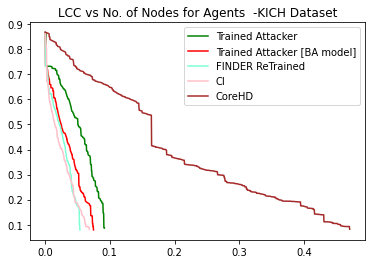

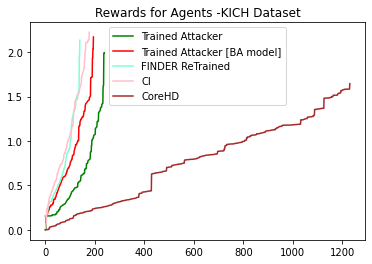

Trained Attacker [1769, 1754, 1756, 1755, 1743, 1843, 1760, 1741, 1837, 1821, 1782, 6121, 1766, 1740, 1757, 1759, 1805, 1795, 1891, 1696, 1748, 1758, 1879, 1752, 1768, 1744, 1686, 1842, 1745, 1579, 1691, 1631, 1829, 1658, 1796, 1836, 1887, 1828, 1747, 1633, 1659, 1833, 1803, 1883, 1881, 1672, 1886, 1885, 1583, 1778, 1643, 1718, 1908, 1916, 1901, 1780, 1791, 1850, 1699, 1751, 1619, 6012, 6013, 6014, 6015, 6017, 3117, 4260, 2341, 5886, 4037, 6016, 2020, 930, 1367, 2299, 3882, 5001, 1005, 254, 2601, 2602, 1007, 1047, 2351, 2667, 4, 866, 818, 144, 1616, 3300, 1806, 3700, 579, 1762, 1919, 1907, 1905, 270, 1578, 1577, 1641, 1787, 1793, 1804, 1009, 1597, 1599, 1727, 1329, 1810, 1898, 1910, 1913, 1624, 1914, 1790, 1213, 1770, 1799, 1609, 1705, 1639, 1594, 1715, 1750, 1678, 1688, 1587, 1784, 1920, 1902, 1676, 3856, 1652, 3854, 1807, 1679, 1903, 1630, 1894, 1663, 1719, 1591, 1690, 1911, 1615, 1702, 1682, 1729, 5230, 1882, 1890, 1763, 1731, 1684, 1668, 1651, 1917, 1692, 3848, 1706, 1585, 1785, 15

Trained Attacker [BA model] [107, 356, 1743, 1769, 1754, 6325, 1770, 1760, 1755, 6507, 1821, 1757, 1891, 1843, 1837, 1752, 1759, 1257, 41, 1782, 1762, 1879, 1768, 334, 1735, 1805, 1791, 1758, 1887, 1766, 1691, 1842, 5738, 1751, 3799, 1740, 1761, 1741, 1736, 354, 4488, 1748, 642, 4805, 1795, 111, 1696, 1659, 1756, 1658, 1631, 291, 357, 1686, 1579, 1767, 1742, 1699, 1745, 1622, 1587, 1690, 5090, 1692, 1750, 1799, 1679, 1591, 6487, 1824, 1723, 530, 1141, 1142, 3089, 1149, 1765, 1178, 336, 927, 547, 1064, 6056, 3602, 4116, 1164, 6324, 5104, 526, 5890, 1139, 745, 5718, 6277, 6493, 1965, 610, 612, 670, 2095, 2117, 2118, 2122, 2128, 2208, 2216, 2218, 2228, 2229, 2235, 2239, 2244, 2246, 2247, 2252, 2254, 2262, 2264, 2434, 2436, 2440, 3727, 3731, 3733, 3849, 4508, 4509, 4514, 4516, 4517, 5709, 5585, 5987, 5712, 5231, 4773, 2704, 4098, 4099, 6413, 5384, 4733, 5354, 5195, 4900, 6045, 4592, 2116, 6566, 342, 6122, 6576, 5314, 651, 5270, 5116, 4901, 5383, 4812, 6715, 5741, 6221, 2338, 3230, 6232, 33

CI [619, 2108, 356, 334, 1089, 860, 113, 991, 648, 111, 1087, 818, 406, 2601, 329, 916, 903, 291, 520, 160, 1073, 1070, 516, 2959, 460, 518, 522, 673, 517, 515, 3097, 1405, 1525, 738, 803, 521, 2428, 809, 114, 761, 767, 1510, 1009, 753, 1047, 115, 2915, 192, 5128, 191, 220, 159, 426, 2023, 276, 768, 999, 355, 4168, 1257, 1148, 142, 107, 1298, 1258, 354, 586, 352, 1256, 348, 1252, 1254, 41, 1253, 1271, 344, 343, 1251, 400, 749, 346, 1231, 1297, 1299, 1327, 1232, 503, 131, 883, 1146, 206, 97, 132, 330, 1567, 562, 784, 470, 3851, 3509, 2611, 96, 3120, 1941, 347, 3963, 167, 911, 1380, 2612, 2109, 990, 3685, 2618, 2948, 437, 3163, 2916, 2883, 1008, 1499, 1566, 593, 2613, 2467, 2909, 5311, 1140, 4383, 2466, 1001, 2635, 92, 6391, 579, 611, 147, 775, 1240, 264, 1211, 2112, 280, 1369, 459, 148, 582, 977, 76, 1376, 552, 434, 814, 1205, 174, 3384, 2071, 730, 801, 1059, 790, 110, 43, 980, 908, 557, 956, 384, 1520, 849, 2602, 1928, 3672, 1128, 3507, 3982, 2324, 974, 1116, 2300, 182, 2760, 2729, 521

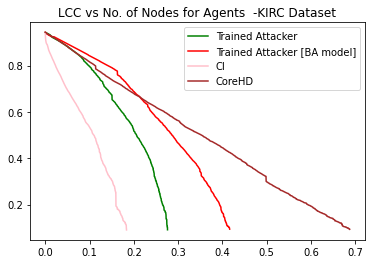

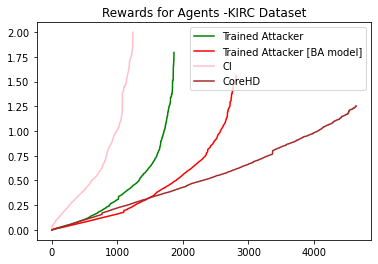

Trained Attacker [415, 1247, 1248, 1249, 1250, 1252, 1253, 1254, 1256, 1258, 1260, 1261, 1262, 1265, 1266, 1268, 1270, 1271, 1272, 1274, 1276, 1280, 1281, 1259, 522, 1279, 1287, 1291, 425, 1246, 1255, 1286, 1298, 1307, 1309, 1310, 1314, 1318, 1267, 1324, 1308, 1327, 1257, 1331, 1335, 1312, 1336, 440, 1251, 1288, 1339, 1328, 1345, 1352, 1358, 1360, 1316, 1329, 1361, 1349, 1363, 1315, 1366, 1381, 1383, 1385, 1296, 1334, 1387, 1389, 1391, 1341, 1397, 1400, 506, 1305, 396, 1395, 1407, 1289, 1294, 1347, 1353, 32, 1384, 1408, 1371, 1411, 137, 42, 1301, 29, 1368, 1370, 1377, 1427, 1434, 1437, 1440, 1442, 143, 1447, 1449, 1451, 704, 1452, 1494, 34, 230, 593, 1511, 23, 706, 3810, 1320, 544, 1471, 1458, 849, 549, 228, 1508, 899, 37, 1078, 2504, 379, 3045, 93, 1459, 1372, 50, 3464, 138, 1264, 892, 419, 87, 1516, 1896, 716, 553, 2879, 398, 395, 26, 3867, 681, 547, 637, 2562, 204, 1512, 917, 1844, 101, 765, 105, 89, 314, 898, 998, 397, 1895, 2557, 633, 423, 4567, 19, 168, 3082, 930, 847, 221, 196, 

FINDER ReTrained [1259, 1248, 1266, 1261, 1260, 1256, 1254, 1258, 1247, 1271, 1383, 1309, 1265, 1361, 1270, 1307, 415, 1268, 1360, 1262, 1400, 1253, 1250, 1407, 1385, 1318, 1339, 1274, 1272, 1249, 1451, 1291, 1276, 1298, 1287, 1252, 1327, 1397, 1381, 1391, 396, 1281, 1336, 1279, 1458, 143, 29, 1324, 1411, 1280, 42, 1358, 1314, 1512, 551, 1516, 1352, 1331, 1363, 93, 1255, 1345, 1387, 1310, 138, 1286, 1408, 1257, 204, 440, 1267, 1251, 105, 141, 1335, 1442, 1334, 1288, 1312, 24, 23, 34, 605, 1329, 115, 26, 1511, 1296, 1315, 1366, 1148, 593, 2557, 32, 379, 50, 168, 397, 998, 230, 1078, 1081, 892, 37, 3018, 847, 1117, 716, 228, 395, 8, 1494, 704, 544, 87, 246, 89, 547, 637, 706, 553, 899, 390, 419, 305, 888, 549, 1459, 167, 1401, 394, 19, 20, 567, 2562, 1896, 849, 27, 611, 1844, 681, 293, 196, 1301, 1376, 627, 14, 271, 1282, 314, 137, 1080, 2931, 1426, 7, 1518, 1275, 906, 133, 1984, 1449, 232, 917, 2865, 1365, 154, 101, 765, 974, 1264, 3, 574, 633, 1388, 898, 2894, 1395, 1438, 450, 388, 53,

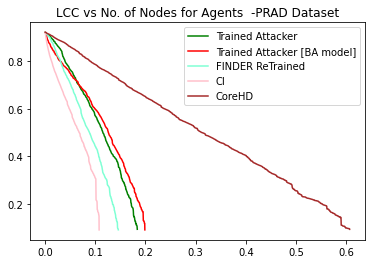

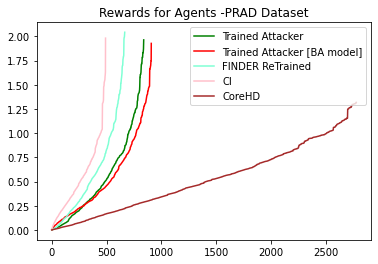

Trained Attacker [1707, 3758, 1407, 1420, 1718, 1458, 1412, 1403, 3756, 1460, 3750, 3755, 1551, 1388, 1396, 1712, 1710, 1428, 3757, 1413, 1694, 1374, 1400, 1453, 3752, 1719, 1434, 1463, 1703, 1395, 1416, 1708, 1426, 3749, 1466, 1387, 5750, 1398, 1689, 1704, 1442, 1390, 1717, 3754, 3753, 1406, 1423, 1430, 1415, 3751, 1706, 1457, 1389, 3760, 3761, 1709, 1425, 1437, 1375, 1594, 1699, 1705, 1697, 1419, 1702, 1380, 1624, 1626, 1379, 1716, 1638, 1427, 1391, 1635, 1634, 1445, 1711, 1435, 1459, 1405, 1678, 1464, 1686, 1698, 1611, 1616, 1537, 1382, 1629, 1692, 1409, 1609, 1443, 3762, 1456, 1661, 1623, 2812, 1641, 1667, 1597, 1676, 1647, 1612, 3769, 1393, 1433, 1639, 1591, 1615, 1465, 1424, 1449, 1636, 1381, 1438, 1377, 1410, 1622, 1685, 1411, 1637, 2071, 1404, 1376, 1446, 1385, 1539, 1517, 1444, 1674, 1402, 1587, 1646, 1642, 1684, 1461, 1383, 1384, 1408, 1414, 1417, 1220, 1386, 1421, 1392, 1373, 1451, 1455, 1488, 1501, 1436, 1462, 1394, 1512, 1432, 1439, 1440, 1540, 1549, 1561, 1562, 1578, 1586

Trained Attacker [BA model] [4982, 2589, 4062, 4098, 2211, 778, 1812, 3765, 6331, 5728, 5892, 6586, 5810, 5691, 1453, 4063, 2189, 1395, 1400, 1423, 1718, 1420, 1403, 3752, 1689, 3758, 1707, 1721, 6508, 3796, 1466, 1374, 1407, 1004, 1387, 1422, 1388, 1412, 1396, 1458, 1460, 1416, 3749, 1738, 1013, 1708, 1463, 1426, 1428, 1719, 3757, 1398, 3756, 1701, 1704, 1703, 1712, 3751, 1434, 3750, 1551, 3755, 1413, 1437, 3556, 1442, 1694, 1389, 1390, 1406, 1710, 6369, 1375, 1415, 1709, 1594, 1399, 1706, 1425, 3555, 1717, 1430, 1827, 1457, 3753, 1705, 1702, 1626, 1716, 1699, 3754, 1435, 1883, 1711, 1419, 6408, 6474, 1634, 1697, 1379, 1427, 1635, 1380, 5081, 1464, 1409, 2170, 647, 1686, 1698, 1678, 1405, 470, 5653, 5811, 6433, 1855, 1872, 1953, 1956, 1959, 1960, 1964, 1976, 1989, 1992, 2002, 2209, 2210, 2907, 2909, 2910, 2914, 3779, 6868, 6581, 5117, 6360, 6771, 2051, 5818, 5118, 4188, 5146, 6436, 6284, 5025, 6794, 4003, 4368, 5144, 3383, 6412, 6285, 4986, 5440, 6949, 6242, 6563, 4853, 3180, 3183, 62

FINDER ReTrained [2535, 1029, 470, 1376, 1384, 1402, 1541, 1637, 1615, 1578, 1567, 1621, 1646, 1506, 1438, 1583, 1650, 1444, 1488, 1562, 1386, 1666, 1614, 1543, 1546, 1549, 1433, 1451, 1440, 1454, 1586, 1518, 1491, 1602, 1432, 1539, 1385, 1574, 1411, 1653, 1421, 1561, 1383, 1565, 1439, 1560, 1394, 1681, 1404, 1377, 1577, 1603, 1657, 1674, 1628, 1670, 1622, 1410, 1630, 1692, 1382, 1446, 1564, 1592, 1613, 1392, 1643, 1649, 1668, 477, 647, 1611, 1378, 1465, 1445, 1671, 1482, 1405, 1709, 1682, 1617, 1391, 1425, 1540, 1675, 1656, 1545, 1696, 1431, 1456, 1627, 1680, 1678, 346, 1659, 1608, 1461, 1660, 1685, 1534, 1598, 1588, 1436, 1408, 1459, 1636, 1609, 1644, 1677, 1640, 1462, 1616, 1568, 1607, 1593, 1691, 1585, 1579, 1606, 1610, 1658, 1449, 1584, 1684, 1625, 1664, 1418, 1599, 1590, 1605, 1600, 1651, 1469, 1414, 1587, 1638, 1624, 1537, 77, 606, 662, 331, 1429, 1883, 1447, 1450, 451, 965, 2021, 1430, 1533, 1397, 1409, 685, 296, 1424, 1457, 1381, 778, 1466, 2211, 831, 1428, 1503, 1612, 1623, 1

CI [2535, 1029, 470, 477, 676, 606, 176, 101, 789, 212, 520, 473, 526, 210, 523, 524, 522, 3726, 518, 527, 257, 525, 4244, 521, 1115, 662, 283, 1262, 531, 647, 1031, 824, 859, 2168, 532, 1785, 265, 312, 3759, 858, 597, 609, 889, 3114, 638, 90, 631, 4340, 948, 1039, 14, 1269, 1258, 224, 623, 67, 2768, 730, 931, 2414, 291, 2056, 133, 6434, 457, 337, 2184, 4077, 488, 937, 3705, 4800, 3391, 4801, 346, 541, 282, 2769, 928, 914, 659, 259, 942, 917, 596, 2021, 296, 2437, 128, 821, 1276, 2030, 551, 883, 1738, 331, 462, 1174, 1912, 1827, 1817, 333, 1721, 302, 639, 807, 1233, 1883, 778, 4063, 1005, 1007, 1013, 1004, 2189, 1008, 2186, 2211, 728, 1028, 2582, 4062, 4098, 746, 1012, 1911, 1011, 1812, 2589, 4980, 967, 2032, 499, 229, 2031, 60, 230, 111, 4231, 995, 3251, 5116, 945, 4982, 2935, 3050, 3062, 5687, 2930, 80, 5502, 3778, 2397, 847, 3127, 1880, 1261, 3587, 1291, 1290, 4303, 4259, 6021, 5688, 4819, 5080, 4260, 254, 3867, 965, 77, 584, 1237, 886, 1246, 1085, 255, 735, 682, 626, 2159, 78, 362,

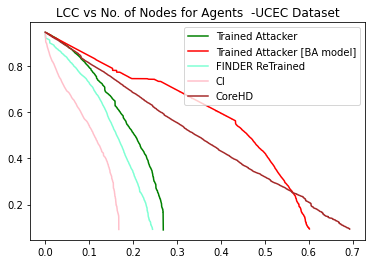

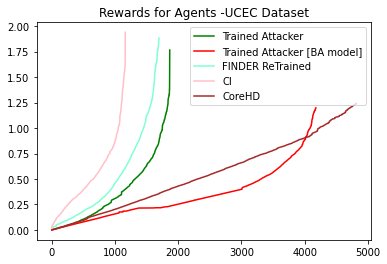

/tmp/ipykernel_148453/2507520658.py:490: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  AUC = np.array(AUC)


In [22]:
file_path = "./Gene_Network/"
file_list =  ["COAD","HNSC","KICH","KIRC","PRAD","UCEC"]
AUC = visual_evaluation(file_path,file_list,attacker_differentGraph, attacker_BATypeGraph)

In [ ]:
#GeneInteraction
#Trained Attacker [7605, 3316, 1710, 1867, 7963, 1420, 2, 13, 27, 30, 40, 41, 42, 50, 52, 56, 96, 93, 36, 94, 95, 97, 98, 57, 101, 107, 108, 110, 114, 125, 137, 152, 176, 183, 188, 197, 287, 291, 304, 321, 109, 262, 358, 360, 76, 322, 378, 376, 380, 384, 386, 385, 420, 51, 368, 439, 481, 483, 489, 787, 1842, 1997, 2534, 3619, 4190, 4217, 4226, 4231, 7539, 7749, 7871, 7907, 7964, 7965, 7966, 4799, 7662, 3088, 7899, 7898, 748, 594, 3846, 1909, 2380, 149, 5, 26, 29, 31, 35, 60, 61, 65, 91, 99, 100, 102, 103, 104, 105, 106, 120, 148, 5945, 3209, 5946, 2182, 5683, 5628, 3587, 4006, 11472, 11373, 11343, 1720, 11364, 11365, 11367, 10381, 11360, 11359, 11362, 689, 4798, 10574, 11166, 10235, 5298, 11471, 11340, 5140, 5145, 4658, 6150, 2036, 2039, 5341, 11371, 11355, 2038, 10788, 4011, 11587, 15, 9767, 6266, 8167, 8168, 7798, 5670, 6822, 6686, 6724, 6827, 6689, 6622, 6664, 6618, 6592, 6590, 6644, 6751, 6646, 5963, 6859, 6784, 6411, 6717, 6868, 5964, 4598, 6585, 6673, 6907, 5665, 2297, 6771, 6873, 6591, 6669, 6672, 6676, 6744, 6955, 2298, 6630, 5779, 6755, 6788, 6814, 5424, 5793, 6555, 6901, 3358, 5707, 6254, 5809, 6356, 4363, 3594, 1442, 6593, 6649, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6697, 6610, 6611, 6612, 6613, 6614, 6710, 6615, 6616, 6617, 6619, 6620, 6621, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6645, 6647, 6648, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6665, 6666, 6667, 6668, 6670, 6671, 6674, 6675, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6687, 6688, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6711, 6712, 6713, 6714, 6715, 6716, 6718, 6719, 6720, 6721, 6722, 6723, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6745, 6746, 6747, 6748, 6749, 6750, 6752, 6753, 6754, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6785, 6786, 6787, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 994, 1906, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6815, 650, 6816, 6817, 6818, 9647, 9993, 9700, 10082, 10085, 10129, 694, 728, 1113, 3468, 6364, 6819, 6459, 6820, 6480, 6821, 6483, 6823, 6485, 6824, 6825, 6486, 6826, 6828, 6489, 6829, 9668, 1003, 3584, 6456, 6830, 6474, 6831, 6479, 6832, 6833, 6500, 9644, 135, 4538, 6457, 6834, 6835, 394, 6253, 6836, 6473, 6837, 400, 6494, 6838, 520, 3718, 6481, 6839, 1288, 3702, 6478, 1734, 6840, 3667, 3629, 758, 6841, 2331, 3689, 6842, 757, 44, 3656, 643, 4580, 6843, 3518, 759, 6844, 5094, 3765, 760, 6845, 1343, 6482, 2046, 3879, 6846, 1265, 562, 3628, 6847, 1267, 4273, 6476, 299, 6848, 972, 359, 1151, 492, 6849, 3727, 6492, 6501, 2556, 6850, 525, 331, 4059, 1747, 4591, 6851, 130, 6852, 290, 6049, 6853, 399, 6854, 6190, 1266, 9845, 2608, 645, 4766, 1268, 3484, 6855, 935, 926, 6856, 6300, 429, 933, 77, 6857, 6858, 934, 372, 968, 6447, 4757, 6860, 427, 375, 9872, 5381, 2735, 2247, 2251, 1019, 6461, 523, 931, 362, 6861, 1393, 5404, 524, 4738, 335, 6862, 10362, 10365, 5351, 4714, 971, 6469, 6863, 64, 3810, 4708, 3657, 6864, 1263, 6465, 134, 3514, 6865, 63, 1259, 693, 2519, 5379, 4694, 4607, 3552, 6866, 5402, 90, 3258, 3553, 4577, 6867, 1148, 3648, 4696, 721, 175, 6869, 6031, 1260, 136, 3649, 3240, 634, 6870, 5130, 2455, 3650, 1421, 3867, 4712, 6871, 1600, 3651, 4233, 70, 145, 147, 6872, 5678, 4724, 3652, 3890, 5372, 4024, 6874, 326, 603, 3653, 3393, 951, 298, 3923, 1297, 1256, 1258, 6875, 4740, 129, 1257, 364, 1254, 1255, 1264, 3654, 1287, 393, 1143, 999, 6350, 1662, 4718, 5314, 6876, 3655, 1666, 337, 4721, 4499, 6877, 6475, 1145, 4733, 3658, 126, 6094, 6878, 4735, 3681, 10427, 530, 3659, 4726, 6879, 664, 6503, 6502, 3660, 4731, 1029, 411, 6880, 497, 4693, 3661, 536, 1599, 1660, 1367, 1205, 6493, 4699, 6881, 4684, 775, 773, 1110, 3662, 4719, 6488, 6882, 9634, 9711, 6498, 440, 4698, 1661, 3663, 10246, 649, 493, 6496, 4465, 774, 6883, 4700, 769, 2596, 3700, 4711, 4704, 5677, 5479, 4758, 1331, 3868, 6884, 3246, 1801, 1800, 3701, 3238, 4440, 6471, 1797, 257, 167, 6885, 3869, 4682, 3250, 32, 33, 3703, 772, 4788, 1275, 4223, 770, 4513, 921, 9715, 6886, 4697, 3871, 1314, 1760, 4753, 3705, 771, 1206, 6468, 268, 6887, 4707, 670, 5395, 3706, 2547, 3, 10348, 2837, 4258, 932, 330, 6495, 6888, 2291, 6497, 4016, 1337, 3707, 894, 9989, 10227, 381, 38, 6889, 3892, 3431, 4685, 3708, 89, 9671, 62, 541, 5264, 6890, 3709, 1014, 6025, 598, 925, 3454, 1101, 1419, 28, 4716, 5361, 6891, 3710, 2555, 256, 1318, 739, 266, 3236, 4743, 1031, 5360, 6892, 545, 10135, 3711, 3870, 10409, 1407, 5405, 1404, 3259, 9731, 1149, 611, 5377, 6893, 10301, 10293, 9745, 1197, 3712, 1686, 9764, 9619, 9704, 3245, 618, 5378, 3247, 6448, 6894, 4062, 1416, 6463, 5561, 6462, 5103, 5988, 3713, 1322, 3242, 786, 3534, 10247, 10863, 10256, 9751, 9616, 9733, 9678, 2823, 617, 511, 766, 6895, 4751, 2824, 1751, 1705, 995, 1277, 1403, 3714, 4680, 75, 1000, 382, 10159, 1013, 1141, 1368, 1494, 195, 6896, 3244, 6297, 9677, 9680, 9963, 9649, 1929, 5478, 4033, 3715, 4681, 4754, 71, 6897, 3249, 2830, 4343, 3716, 992, 180, 3872, 1004, 116, 4710, 6898, 5396, 1312, 88, 4179, 3717, 3243, 604, 10070, 10244, 3849, 6899, 2315, 1303, 3252, 5349, 5494, 286, 756, 9746, 9734, 9729, 9638, 9641, 3719, 4689, 4432, 991, 6900, 3254, 297, 410, 2270, 1890, 635, 665, 962, 1018, 1150, 3422, 2661, 1261, 3720, 74, 527, 4683, 2516, 1415, 1373, 6902, 1020, 1716, 3255, 407, 4679, 490, 3721, 1291, 1394, 6096, 3885, 2197, 6903, 2307, 494, 4702, 7110, 6472, 3722, 4675, 403, 47, 6904, 1908, 4673, 9762, 3866, 4701, 1106, 284, 506, 39, 1557, 1022, 3723, 1211, 1847, 132, 210, 1347, 10012, 10018, 9925, 9825, 10086, 73, 6905, 397, 1289, 7162, 9730, 1918, 6317, 1348, 3724, 10184, 4695, 317, 7168, 2572, 3349, 6298, 9897, 3901, 6906, 401, 1212, 1204, 1349, 55, 2692, 4209, 1030, 746, 2471, 2484, 3725, 2183, 5755, 1021, 1023, 1815, 2020, 7011, 10178, 58, 585, 370, 738, 2199, 4703, 6908, 2697, 612, 2842, 325, 402, 404, 398, 1602, 1278, 1544, 3726, 2821, 529, 9849, 283, 288, 1161, 367, 425, 4454, 4674, 6909, 7007, 2708, 5276, 2818, 5778, 644, 83, 997, 417, 537, 966, 293, 891, 1194, 495, 548, 3325, 377, 79, 741, 1116, 1180, 2198, 2006, 270, 3728, 5891, 4676, 6910, 2569, 81, 86, 138, 1371, 1320, 48, 1509, 1147, 371, 1108, 1210, 3886, 4023, 3729, 1423, 4055, 6911, 4677, 396, 7167, 3903, 1179, 3730, 6998, 4678, 72, 4350, 119, 1142, 2736, 2794, 2792, 2784, 2594, 265, 6912, 4761, 6275, 3904, 3731, 1511, 274, 5251, 80, 4686, 6913, 6467, 1537, 3905, 4344, 4687, 4688, 3732, 2175, 1273, 9682, 2593, 2008, 7031, 6914, 4464, 1744, 3906, 1862, 5374, 4275, 3733, 5548, 2250, 9683, 6915, 3277, 7005, 3907, 6466, 1306, 3734, 423, 742, 222, 2695, 1228, 4755, 1490, 2827, 779, 2835, 1553, 6916, 2773, 1200, 1290, 2029, 2728, 45, 4692, 1332, 2096, 2730, 5973, 5979, 3735, 6999, 2774, 8012, 3899, 2734, 412, 3778, 1523, 1524, 124, 2733, 3463, 1877, 3034, 1025, 341, 2021, 6917, 2727, 1201, 312, 2729, 9818, 232, 9870, 6351, 9873, 2118, 3031, 4713, 3736, 668, 2769, 1309, 296, 2732, 4756, 4706, 1806, 692, 258, 259, 1006, 2744, 2731, 5947, 6095, 295, 3902, 316, 7019, 6110, 1827, 6918, 2720, 2606, 123, 2285, 2714, 1124, 3737, 1672, 7004, 6464, 169, 1563, 514, 1144, 6919, 4349, 2780, 1328, 2738, 2277, 1351, 9796, 2826, 2770, 3738, 2237, 6358, 2151, 2200, 1937, 2698, 2793, 6920, 6423, 1682, 7402, 1604, 3452, 1547, 154, 2148, 2150, 2149, 7163, 2280, 1, 68, 1047, 87, 3739, 2595, 6470, 6921, 205, 413, 9911, 7164, 3898, 1379, 1274, 3740, 269, 2425, 2235, 5861, 10003, 9666, 2791, 7165, 348, 3451, 10067, 4028, 3083, 1304, 2722, 6922, 4445, 2746, 5350, 1336, 2771, 5354, 1676, 1675, 6451, 5202, 1243, 5355, 6337, 3639, 498, 5200, 3741, 6504, 4446, 9632, 2745, 5356, 5357, 5358, 5362, 2353, 1342, 3794, 2121, 2611, 2238, 5363, 2466, 1522, 6923, 181, 10245, 442, 3900, 2761, 1344, 2785, 3685, 2762, 3742, 3170, 5206, 6299, 2371, 1670, 4348, 783, 2603, 5912, 5914, 5915, 8011, 8013, 5913, 4861, 2517, 3205, 2076, 3415, 3203, 6359, 988, 6424, 601, 6924, 5364, 1252, 170, 9770, 3428, 1366, 1044, 1294, 3743, 450, 373, 2759, 2485, 1270, 9766, 1913, 1933, 5183, 49, 528, 338, 1008, 1140, 1486, 2612, 6319, 3897, 5365, 9779, 2358, 1878, 6925, 1338, 1753, 2003, 2715, 9944, 2598, 3744, 3131, 1422, 7144, 767, 2701, 163, 5366, 5285, 6059, 5528, 2300, 4722, 4723, 4728, 4729, 4739, 4747, 4745, 6926, 4481, 1308, 2286, 5040, 5042, 1603, 642, 2233, 526, 3745, 4474, 4741, 5287, 2662, 2694, 2693, 9765, 3151, 546, 5452, 518, 1253, 745, 2287, 1326, 3471, 211, 3430, 4366, 1939, 5301, 5302, 2713, 1843, 1907, 6927, 1520, 2696, 4438, 3792, 4764, 10164, 1411, 2279, 4821, 1998, 1165, 6055, 1607, 9748, 3664, 1891, 1667, 3686, 1114, 1102, 9912, 10352, 9819, 9820, 9863, 9850, 10415, 168, 4536, 1357, 4298, 302, 1417, 6928, 2825, 967, 4800, 1039, 3078, 3079, 10294, 1269, 648, 9681, 9656, 82, 2296, 2833, 2764, 5277, 34, 3551, 2740, 2786, 3077, 173, 976, 1410, 3665, 2232, 504, 2718, 5278, 5300, 1045, 2190, 5580, 435, 2507, 4801, 702, 896, 3512, 365, 3436, 652, 4017, 987, 6929, 201, 1271, 1639, 1214, 1133, 5244, 1153, 1154, 691, 332, 336, 1606, 4070, 2187, 1916, 4715, 1712, 1339, 4672, 9719, 1372, 2024, 499, 1027, 2607, 2706, 2707, 2268, 2817, 5367, 3210, 2345, 1109, 5368, 4051, 10152, 9890, 10395, 1082, 659, 5401, 1040, 3147, 2234, 2236, 3228, 563, 484, 200, 2170, 10153, 3746, 1841, 140, 9669, 6930, 1236, 2737, 160, 9629, 10297, 5369, 3157, 2805, 900, 542, 5446, 1884, 3987, 1940, 9960, 1859, 9923, 10173, 2005, 1380, 1028, 14, 10470, 5370, 9611, 3163, 3838, 2299, 1685, 2801, 1012, 1816, 1755, 112, 1605, 5197, 2717, 2134, 1609, 1262, 1209, 571, 1529, 1325, 9763, 3747, 324, 6245, 7773, 2686, 3129, 570, 6240, 2243, 6931, 2750, 2748, 4437, 117, 78, 361, 1767, 2216, 2215, 2217, 750, 3076, 3524, 9747, 5911, 5456, 7146, 1873, 560, 1680, 1814, 2169, 865, 3208, 219, 9840, 9955, 9630, 9651, 5371, 478, 4013, 2188, 2027, 2419, 2375, 3528, 3859, 869, 452, 10657, 10258, 174, 10303, 2632, 1323, 2460, 2615, 10002, 9954, 9914, 2653, 1876, 6314, 6315, 3748, 10230, 4460, 1001, 177, 2783, 17, 1803, 9966, 6932, 9851, 9755, 1562, 1307, 684, 736, 2802, 1321, 1598, 5519, 10451, 10255, 10394, 2465, 1397, 67, 1508, 1506, 250, 196, 1507, 118, 2367, 1756, 419, 190, 2795, 1128, 6157, 6452, 1203, 4439, 6453, 3193, 1384, 2743, 1805, 6454, 5373, 3677, 1166, 1525, 10068, 500, 1009, 6455, 1213, 342, 3749, 6458, 10515, 6460, 9834, 10315, 9833, 451, 2289, 3942, 3149, 6477, 3475, 9637, 2789, 2478, 6933, 2278, 2274, 1872, 1865, 6158, 146, 1105, 1775, 4284, 2788, 9884, 9883, 9631, 2057, 10295, 998, 3825, 418, 3346, 10662, 1083, 10523, 379, 1295, 1554, 9817, 9816, 3237, 285, 5375, 2787, 5811, 438, 5447, 602, 5288, 4669, 5646, 320, 2790, 2647, 3527, 9672, 9913, 9612, 9615, 1408, 6065, 2010, 2839, 1517, 1519, 1518, 408, 608, 162, 1386, 10299, 6239, 3865, 5201, 3750, 1864, 3424, 622, 6484, 2741, 443, 6934, 19, 2145, 3817, 3153, 1888, 1162, 2355, 3283, 2767, 937, 1995, 11049, 10612, 9879, 9951, 1758, 6019, 7726, 7114, 5376, 7774, 1745, 2573, 1746, 2574, 2575, 5630, 204, 165, 2409, 2429, 2803, 4047, 4135, 895, 369, 323, 1920, 10231, 10232, 9703, 2845, 1561, 1398, 4523, 10531, 9737, 5449, 1293, 3535, 974, 59, 3816, 455, 2155, 1707, 189, 9788, 9800, 9720, 9718, 1460, 3035, 1174, 1919, 4759, 1434, 1279, 5743, 2153, 2210, 9821, 9712, 9716, 9942, 366, 2840, 1375, 4520, 476, 1048, 3751, 3359, 5576, 2321, 1377, 3687, 4521, 122, 761, 1595, 4054, 4610, 4353, 1369, 5756, 1376, 9686, 6935, 10305, 4789, 2376, 1684, 731, 2766, 9710, 9717, 9822, 10396, 9893, 9889, 9891, 9892, 9741, 9962, 9618, 9617, 9679, 9620, 9707, 2074, 6050, 3540, 4169, 1317, 2007, 1532, 1528, 1530, 1531, 1515, 835, 3420, 1195, 2448, 2304, 3982, 6131, 3075, 1679, 6034, 5167, 5165, 2404, 3640, 1073, 1032, 159, 392, 1766, 740, 477, 3911, 700, 496, 3137, 5742, 2241, 1365, 10783, 9815, 10606, 10593, 4771, 515, 1234, 3983, 5067, 3752, 1409, 2765, 7506, 7507, 7508, 656, 1240, 2099, 2275, 10187, 319, 920, 54, 1889, 3590, 1926, 11174, 2551, 4565, 762, 768, 600, 191, 6936, 10364, 10375, 11215, 10916, 10768, 10611, 3241, 3984, 4433, 1956, 131, 3692, 7483, 9885, 737, 5065, 2723, 1548, 2642, 6, 300, 4171, 4063, 2453, 2623, 2456, 4855, 4212, 9792, 2724, 46, 463, 9856, 5948, 9844, 3130, 2101, 1721, 3617, 9743, 9749, 3248, 2725, 3698, 10053, 10450, 9964, 10141, 4177, 1011, 1663, 2721, 516, 4000, 6134, 1104, 10774, 9702, 9701, 8629, 979, 3753, 9875, 5380, 6961, 4775, 6280, 5066, 10851, 10350, 9860, 10378, 9929, 10811, 855, 1453, 6149, 5359, 7775, 5621, 6354, 2726, 1130, 3985, 2487, 5283, 4829, 4027, 1292, 6937, 2742, 3251, 5495, 1917, 3379, 2704, 161, 3395, 198, 2705, 595, 5877, 5647, 212, 133, 2386, 8445, 8536, 8537, 3675, 10982, 1202, 2344, 2426, 2311, 784, 11017, 10537, 10387, 10702, 10660, 11237, 5470, 5875, 1115, 8307, 5965, 1139, 1811, 7365, 1977, 1978, 2660, 1911, 7542, 1103, 696, 6296, 4522, 10524, 10022, 8188, 9921, 11005, 2447, 3365, 3366, 263, 3364, 482, 3363, 1991, 1400, 233, 11502, 9894, 9898, 9895, 9900, 9949, 1875, 5577, 1474, 3503, 7583, 11464, 6374, 3302, 9068, 9069, 9288, 3305, 11397, 10322, 9169, 9170, 8403, 11578, 11554, 11585, 8657, 9070, 3526, 8019, 11522, 7988, 8989, 9383, 9233, 11064, 3917, 9248, 8462, 8463, 8464, 8689, 8154, 8194, 9171, 5090, 7504, 8020, 9424, 9427, 7068, 7433, 7852, 9444, 9425, 9426, 9017, 9586, 11612, 1677, 5304, 7779, 9587, 11493, 5638, 9077, 4501, 9247, 3564, 3779, 5112, 6161, 6572, 7354, 4558, 5305, 7223, 7704, 7780, 9582, 9588, 11494, 11555, 11627, 10533, 11613, 8421, 8958, 7496, 7989, 7872, 11042, 3173, 4407, 4629, 4823, 5306, 5714, 7224, 7385, 7705, 7781, 8321, 9291, 9346, 9418, 9421, 9508, 9583, 9589, 9735, 10000, 10419, 10675, 11232, 11274, 11303, 11467, 11475, 11495, 11610, 7653, 5555, 7858, 8895, 8195, 11326, 4831, 11455, 9259, 9384, 8181, 5739, 8762, 7652, 9289, 5639, 9090, 3978, 6249, 5738, 4313, 11457, 10006, 7869, 3200, 3282, 5863, 4279, 4289, 11074, 7866, 533, 512, 8243, 8246, 8247, 8248, 11352, 8613, 10140, 10833, 2495, 7497, 10838, 8223, 8786, 11369, 8422, 11043, 10889, 6443, 9016, 5418, 6444, 8959, 11348, 11349, 11351, 11356, 11357, 599, 8593, 7979, 1774, 10953, 3561, 9024, 4235, 7054, 591, 4594, 4773, 8140, 9249, 3562, 11586, 8896, 8760, 7976, 5152, 7454, 8658, 9071, 9571, 11615, 9180, 7793, 5763, 10353, 10698, 10031, 11341, 8111, 6986, 8733, 10134, 8756, 7443, 4281, 10354, 8666, 10331, 8607, 8606, 2133, 8471, 10328, 10764, 4671, 4153, 8586, 8712, 9083, 7173, 10093, 10117, 10119, 10122, 10092, 8196, 7414, 4144, 1250, 6238, 9224, 10878, 10891, 5774, 10893, 7308, 7215, 8880, 8787, 11047, 4373, 5690, 5704, 6064, 8702, 5640, 2763, 7098, 11285, 10495, 10496, 10642, 3544, 7505, 6336, 9252, 9172, 8831, 3286, 3986, 3884, 9232, 10558, 8206, 8009, 5295, 5111, 5297, 5296, 7190, 4259, 7625, 1696, 2139, 8767, 3836, 7624, 3834, 3104, 10196, 1923, 10874, 3786, 11611, 11337, 4593, 564, 5477, 7141, 7139, 7133, 7134, 7137, 7138, 7140, 2080, 5602, 9038, 6568, 2207, 1810, 9329, 7194, 8423, 6141, 8426, 4199, 1882, 10342, 7730, 8420, 10886, 10555, 10827, 10828, 10829, 10830, 10831, 10459, 10506, 3802, 3806, 7711, 3522, 3207, 3803, 3805, 5178, 6962, 6965, 6963, 6966, 6960, 6997, 7001, 2739, 2208, 1837, 4720, 5199, 5972, 4725, 3754, 4168, 2295, 1283, 10456, 1844, 1484, 2747, 10457, 9874, 9732, 4717, 5382, 2753, 6938, 7003, 2768, 2772, 3156, 6320, 7006, 2775, 4727, 2778, 1614, 3158, 6004, 5425, 7008, 2779, 5974, 7009, 2798, 4730, 2804, 2004, 7012, 2806, 3840, 3755, 4732, 2218, 7013, 2828, 9673, 3847, 2832, 6939, 3848, 2834, 4734, 3850, 3080, 5383, 7014, 2841, 1112, 6001, 7015, 3032, 10309, 4297, 4064, 6305, 3033, 447, 3887, 5975, 3036, 4736, 1757, 7016, 4035, 3851, 3037, 3852, 4311, 3159, 3853, 3756, 3066, 3854, 3855, 7017, 3067, 3856, 3857, 6940, 9805, 2265, 9965, 1459, 3068, 2002, 5476, 10536, 7018, 2258, 3069, 5384, 7020, 3070, 4705, 876, 158, 5448, 7021, 2846, 2293, 5210, 5497, 7022, 3757, 3682, 3858, 2079, 3845, 3071, 7023, 3160, 4369, 1364, 3171, 5976, 10551, 9798, 9654, 9660, 3072, 6941, 3073, 20, 4255, 9740, 3253, 9736, 1749, 9685, 897, 329, 7010, 7024, 1610, 1444, 5397, 3548, 235, 10502, 3975, 5159, 549, 6439, 3976, 877, 3977, 874, 3081, 3637, 2349, 8226, 3941, 829, 3758, 10876, 267, 5551, 1924, 2263, 2262, 2052, 2269, 2267, 2264, 3860, 2261, 3141, 9, 6147, 3598, 840, 6942, 1002, 5977, 9823, 5485, 517, 4195, 788, 1881, 10008, 9793, 3256, 6056, 3142, 3138, 7025, 10072, 9626, 9621, 3980, 6352, 3140, 24, 289, 213, 2231, 3303, 66, 2490, 9858, 2328, 199, 2310, 3861, 7469, 9662, 5882, 2679, 5161, 1334, 9953, 9861, 1427, 1333, 9930, 9706, 1311, 2829, 5978, 4709, 5883, 224, 5884, 3759, 1979, 1752, 5885, 9917, 5886, 6051, 6057, 6943, 1315, 3330, 6957, 3257, 5524, 3693, 2836, 1310, 10605, 194, 1173, 7026, 666, 4041, 3150, 227, 681, 2481, 229, 1678, 115, 3862, 2781, 661, 3875, 2025, 3402, 927, 3351, 1313, 84, 294, 2271, 5980, 5164, 9698, 9699, 4256, 9624, 9613, 9650, 3531, 1624, 6487, 1340, 3599, 7770, 4215, 4219, 574, 575, 1370, 3760, 10349, 10374, 10665, 4595, 1378, 547, 10290, 10055, 10594, 9847, 1156, 3589, 6005, 2831, 9968, 6490, 726, 6944, 1341, 2168, 983, 7695, 4586, 6303, 1015, 5342, 9905, 9908, 9713, 715, 0, 4288, 534, 1912, 8073, 5115, 3516, 1387, 1412, 2482, 1131, 2195, 7390, 3222, 10928, 1316, 6283, 7394, 685, 5791, 1921, 5859, 3795, 7382, 7149, 6262, 1619, 141, 3690, 2581, 3434, 3455, 3863, 1706, 431, 1615, 2364, 9992, 11020, 10242, 10241, 10259, 2458, 9978, 9855, 10391, 9807, 3823, 5981, 5765, 3844, 3152, 6306, 5166, 8203, 10167, 1733, 223, 1763, 383, 3194, 2760, 9829, 513, 678, 2309, 3288, 2559, 6310, 1659, 461, 3397, 1155, 5840, 1185, 3442, 4476, 6973, 1762, 4214, 3910, 4670, 3432, 1795, 426, 10075, 10777, 9990, 2777, 6313, 9721, 9941, 3666, 6945, 11007, 3699, 10146, 3260, 7536, 4140, 5689, 1863, 978, 1683, 2617, 1227, 10610, 8922, 10236, 2588, 7764, 5533, 10397, 3783, 2633, 3997, 10571, 10902, 6304, 3387, 3799, 3389, 5853, 3798, 3815, 607, 3812, 3621, 192, 6964, 7000, 8696, 3085, 2510, 9784, 2782, 4450, 10005, 6446, 596, 1068, 9785, 3082, 4425, 5952, 3864, 2348, 7688, 2709, 6312, 10865, 7618, 5775, 1915, 2326, 5987, 9786, 6316, 2776, 10894, 339, 7161, 9797, 6318, 6079, 5203, 9974, 11024, 6111, 3143, 7027, 561, 3588, 4208, 3691, 3627, 6209, 4378, 1345, 7166, 3154, 9804, 6449, 1840, 7284, 11189, 226, 4526, 246, 3761, 6946, 1713, 143, 2229, 5547, 646, 9794, 1092, 85, 522, 7261, 247, 10262, 6450, 5838, 4005, 225, 5480, 248, 9696, 10360, 4742, 3604, 1860, 1430, 1665, 7471, 7602, 1708, 1845, 9787, 5343, 3464, 1545, 3641, 2281, 2282, 2283, 2284, 5520, 5626, 5999, 1846, 1497, 5344, 6491, 8692, 1498, 6322, 10, 9791, 1601, 2819, 10367, 725, 434, 444, 445, 3586, 1505, 5953, 9801, 2719, 6000, 6008, 11319, 9809, 1866, 679, 5204, 2248, 5490, 157, 2749, 2104, 7285, 4657, 7316, 9967, 7598, 8397, 1198, 446, 3164, 9708, 9635, 1715, 1499, 6499, 6133, 9824, 3172, 3762, 6947, 7002, 1324, 9973, 10009, 3538, 10284, 655, 1613, 6058, 11321, 7043, 7352, 1987, 10453, 2411, 11006, 10020, 1435, 1215, 9645, 9653, 2461, 3839, 6003, 2602, 2604, 10460, 864, 5581, 9802, 4744, 3694, 271, 228, 2483, 193, 139, 111, 4203, 5769, 3218, 7958, 6135, 2325, 10463, 10371, 9959, 1927, 949, 1026, 5430, 1299, 3106, 2568, 10883, 10872, 10302, 9846, 1880, 543, 616, 1046, 3819, 1632, 1093, 3878, 69, 505, 10346, 1549, 2144, 4232, 10439, 4080, 5121, 156, 1452, 3638, 10452, 633, 1305, 8026, 2605, 10441, 9830, 2242, 142, 153, 3292, 155, 733, 144, 4272, 3458, 5579, 1694, 3601, 940, 2427, 4830, 6204, 6205, 6206, 6207, 9667, 6409, 5858, 2117, 5792, 2400, 1992, 2100, 2403, 818, 3446, 3421, 2103, 5897, 3219, 1239, 10454, 3620, 5205, 5157, 3631, 1402, 9658, 10143, 10563, 7849, 5669, 209, 3093, 890, 9648, 10565, 6417, 1381, 2820, 2847, 2597, 8832, 8209, 4624, 10298, 730, 3602, 3165, 10057, 3936, 3933, 3927, 3763, 3775, 3873, 5345, 6948, 7028, 8432, 8398, 605, 2646, 10228, 6958, 8399, 4202, 3595, 1861, 164, 5408, 1463, 5578, 886, 236, 8027, 9932, 10920, 1111, 8833, 7302, 4218, 582, 609, 1346, 1451, 4038, 11228, 2412, 8768, 10264, 11214, 5998, 10144, 5082, 7227, 502, 628, 1300, 6541, 5224, 9628, 113, 2405, 3915, 10058, 2254, 6208, 10667, 10678, 10673, 1871, 4746, 10300, 8834, 8555, 11115, 2418, 3477, 4072, 1783, 5546, 723, 1327, 4545, 2406, 870, 871, 2352, 5522, 3924, 1928, 3950, 10578, 1176, 8400, 675, 5089, 6349, 7604, 7603, 9987, 565, 10697, 1689, 964, 5682, 906, 4053, 2421, 8126, 1005, 2089, 4278, 4434, 1352, 8835, 3483, 11425, 4601, 10585, 969, 837, 10059, 822, 6039, 185, 10306, 1773, 676, 1067, 3381, 421, 4506, 4134, 5045, 2385, 7061, 7062, 7935, 4319, 1098, 1037, 922, 4042, 5187, 7234, 3642, 2162, 11325, 3217, 677, 7216, 705, 2084, 2339, 4034, 1363, 2037, 2677, 1175, 7651, 3273, 1627, 53, 936, 10351, 4074, 6073, 10792, 8836, 7051, 7784, 1730, 647, 6442, 507, 2256, 1874, 1418, 10407, 237, 1159, 4621, 663, 10238, 10707, 10310, 10455, 963, 10060, 7686, 1634, 1621, 8286, 5540, 1792, 1438, 3348, 4660, 3118, 1043, 567, 10823, 3934, 5207, 8218, 4029, 22, 7, 970, 7911, 5989, 2209, 5804, 207, 1189, 1286, 8166, 2113, 688, 10852, 9896, 9928, 10438, 2143, 4216, 2430, 4181, 7994, 8837, 2351, 3764, 3888, 5346, 6949, 7029, 7765, 3166, 1448, 10793, 10376, 2051, 2577, 712, 387, 1931, 2107, 10835, 11066, 1572, 1125, 2359, 9756, 3456, 1405, 2125, 1069, 5505, 780, 4599, 7253, 6033, 11202, 9947, 6526, 2324, 4269, 10304, 6140, 2245, 4205, 6578, 10497, 4401, 6415, 2172, 2129, 8474, 3520, 1414, 2306, 2252, 7368, 9886, 9670, 10785, 8838, 3939, 4395, 4085, 10248, 5776, 7487, 7060, 2342, 4048, 2591, 1578, 1396, 9774, 9984, 10480, 10815, 10402, 6115, 4822, 9906, 4276, 3928, 6292, 4690, 1374, 4748, 7554, 4142, 7431, 2609, 5949, 4691, 1491, 7037, 460, 1464, 9646, 3135, 10128, 10090, 3281, 3797, 2255, 7287, 4241, 878, 2366, 872, 441, 501, 10071, 10253, 10254, 10252, 10498, 3881, 3830, 1782, 9952, 3814, 349, 11258, 1503, 7637, 11262, 6225, 8, 597, 5271, 2468, 6186, 7092, 2381, 6214, 754, 4220, 1612, 6976, 5814, 7606, 10170, 5245, 2130, 4384, 3335, 1791, 8459, 390, 4136, 1673, 1450, 2266, 5225, 569, 580, 3643, 391, 5388, 793, 1950, 5569, 4, 5843, 2230, 10380, 2369, 6155, 6959, 8048, 5289, 5092, 1994, 2520, 344, 10398, 800, 3098, 6201, 8745, 9970, 238, 459, 2634, 7635, 4382, 5246, 6993, 3314, 6247, 5035, 6202, 2810, 2146, 2158, 6988, 7564, 4791, 1136, 1869, 1543, 6527, 1237, 7619, 3371, 4576, 5474, 5521, 5675, 5787, 2599, 1329, 4242, 1070, 8488, 11062, 10257, 10771, 6066, 11263, 7235, 10355, 10910, 10904, 251, 7981, 10801, 10099, 363, 5645, 1054, 10373, 5247, 975, 2109, 2110, 2108, 11328, 6082, 6071, 1465, 6293, 4792, 3404, 9776, 9633, 7307, 5064, 5243, 4347, 1238, 11593, 10243, 3801, 5968, 802, 803, 749, 3287, 3396, 10007, 9862, 8204, 10102, 9768, 10400, 10403, 10819, 4361, 577, 6203, 2357, 10802, 6291, 3410, 6370, 4667, 8661, 5785, 1458, 1539, 3995, 10169, 2135, 5279, 5208, 5706, 6971, 4358, 2663, 5812, 6435, 4596, 10587, 6295, 9867, 4244, 5417, 5844, 9918, 9726, 5453, 448, 3766, 3889, 4392, 5347, 6950, 7030, 7694, 7766, 8634, 8123, 9610, 9659, 3167, 4613, 4617, 4368, 7559, 5226, 3459, 5835, 4581, 6196, 1566, 272, 4786, 7829, 5705, 4557, 5870, 11008, 2318, 3828, 1187, 3107, 10186, 9795, 10142, 9868, 10326, 1738, 10939, 10446, 9880, 9995, 4668, 474, 1244, 5572, 9173, 471, 5899, 7824, 4238, 1879, 4525, 552, 2288, 5454, 11588, 11596, 10659, 305, 2012, 8456, 9808, 10130, 1138, 10275, 10139, 654, 8293, 5644, 5227, 307, 1695, 5783, 623, 10308, 485, 4131, 5612, 2477, 3831, 4398, 531, 1090, 7198, 1580, 5458, 2514, 5634, 3772, 701, 1857, 3405, 3496, 778, 7955, 2712, 4197, 2017, 4213, 4749, 2022, 8049, 2797, 1658, 1406, 1057, 11072, 11077, 2042, 1356, 6116, 6117, 2489, 521, 572, 573, 2638, 3605, 3272, 5252, 10334, 10370, 10160, 9642, 4065, 10188, 8233, 4337, 1830, 4292, 7197, 11259, 3557, 4856, 6016, 7641, 1168, 1167, 576, 345, 292, 5502, 1620, 8761, 8116, 7678, 1385, 4436, 5240, 8468, 8448, 727, 6035, 10416, 5661, 10810, 10809, 1567, 902, 10566, 7538, 3429, 5594, 6241, 6242, 7315, 1750, 687, 1061, 491, 8316, 5440, 7282, 9979, 9655, 9661, 631, 230, 10270, 7066, 2710, 990, 2226, 8288, 7130, 9916, 1828, 10844, 10888, 9852, 10094, 3521, 8469, 3331, 4058, 10234, 10931, 8131, 3146, 10905, 821, 554, 2294, 873, 8457, 4267, 415, 4782, 893, 2378, 8466, 10683, 629, 2191, 8515, 7607, 7975, 10567, 2354, 5662, 1616, 5469, 5310, 948, 2422, 10121, 10166, 10481, 10366, 10701, 7712, 1944, 8660, 3704, 553, 3994, 3560, 2043, 9040, 11329, 5518, 128, 7246, 831, 7268, 1350, 1936, 8290, 7531, 8025, 7286, 1848, 9739, 9744, 3684, 8494, 11523, 10579, 4196, 3981, 6053, 1718, 10890, 3168, 11589, 3596, 2600, 2601, 8124, 9471, 5209, 3192, 5686, 449, 1446, 3278, 3618, 3767, 3891, 5185, 5348, 6951, 7032, 7696, 7767, 249, 9780, 252, 5708, 9940, 1748, 4239, 10052, 7219, 6212, 5442, 11528, 1868, 7288, 5994, 10357, 10576, 9888, 9915, 9899, 5896, 2276, 10311, 10296, 10292, 10942, 5595, 3616, 10076, 10073, 4045, 7592, 1664, 8815, 9663, 583, 4184, 8055, 10327, 10804, 2362, 2576, 7404, 977, 3108, 2341, 3550, 437, 2011, 2584, 2013, 7831, 7186, 10384, 3326, 1719, 5270, 5292, 8234, 5293, 10568, 10892, 5194]
#Trained Attacker [BA model] [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 10, 13, 14, 15, 16, 17, 19, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 83, 84, 85, 87, 88, 89, 90, 91, 110, 112, 113, 114, 115, 116, 119, 122, 123, 124, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 142, 143, 145, 146, 147, 148, 149, 126, 150, 151, 152, 153, 157, 165, 167, 170, 172, 182, 189, 190, 196, 198, 200, 202, 197, 203, 208, 212, 214, 215, 218, 220, 221, 222, 232, 233, 236, 238, 251, 253, 256, 257, 262, 271, 272, 273, 279, 280, 281, 283, 267, 284, 136, 285, 286, 287, 288, 258, 290, 199, 245, 282, 293, 297, 303, 306, 309, 312, 314, 321, 93, 144, 201, 205, 228, 243, 266, 298, 313, 322, 323, 333, 337, 338, 342, 346, 347, 350, 351, 352, 358, 274, 339, 359, 360, 292, 301, 319, 328, 327, 361, 364, 366, 368, 369, 370, 371, 372, 375, 436, 742, 1275, 2159, 2593, 1421, 2594, 376, 377, 378, 380, 386, 388, 392, 393, 406, 410, 411, 2595, 412, 414, 415, 416, 418, 419, 420, 421, 424, 428, 430, 431, 432, 461, 463, 485, 489, 1389, 1473, 2686, 2717, 2836, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 4788, 2837, 2817, 985, 1471, 1483, 3033, 7949, 772, 4258, 3037, 2828, 2826, 3081, 3080, 3078, 3079, 3077, 3083, 4233, 2760, 2722, 1390, 2834, 2782, 2833, 3032, 2740, 2786, 7954, 4223, 2781, 2724, 2798, 2832, 1485, 2715, 1439, 1420, 21, 22, 33, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 235, 326, 330, 332, 334, 335, 348, 381, 384, 394, 396, 397, 398, 399, 400, 401, 402, 403, 404, 407, 426, 429, 471, 479, 490, 492, 493, 494, 495, 496, 497, 504, 511, 520, 523, 524, 525, 526, 530, 534, 536, 537, 541, 545, 546, 548, 549, 574, 584, 585, 594, 556, 572, 603, 166, 217, 240, 604, 278, 611, 612, 616, 617, 618, 625, 635, 636, 643, 644, 645, 662, 664, 539, 666, 669, 668, 682, 683, 684, 692, 694, 696, 703, 704, 713, 714, 720, 724, 728, 735, 736, 739, 741, 336, 433, 440, 482, 667, 744, 746, 756, 769, 634, 770, 771, 773, 774, 775, 776, 838, 861, 924, 932, 922, 951, 954, 961, 967, 970, 982, 991, 992, 994, 255, 491, 690, 995, 999, 1000, 1003, 422, 654, 778, 817, 878, 880, 894, 905, 904, 968, 670, 717, 721, 760, 971, 1019, 879, 1020, 1021, 1022, 1023, 1029, 1045, 1102, 1106, 1108, 1110, 340, 1111, 1112, 1142, 781, 874, 876, 877, 553, 1144, 1145, 1147, 1148, 1149, 1150, 779, 757, 1151, 1153, 1154, 1204, 1212, 1252, 1253, 1254, 926, 1255, 1256, 972, 304, 302, 1283, 1303, 1304, 1306, 1307, 1310, 1318, 1351, 1367, 918, 1311, 1373, 1393, 1394, 1407, 1333, 1415, 1417, 1419, 1423, 331, 1194, 1441, 1460, 1514, 1570, 1315, 1598, 1599, 1625, 1643, 1645, 1646, 1648, 1649, 1650, 1651, 1653, 1662, 1680, 1741, 1743, 1843, 1844, 1905, 1907, 1929, 1933, 1939, 1940, 2034, 2047, 2058, 2096, 1345, 2147, 2182, 2190, 2194, 2261, 2262, 2263, 2296, 2315, 2331, 2360, 2428, 2453, 2455, 2555, 1710, 2556, 2572, 2592, 2596, 2014, 2597, 2598, 2599, 2465, 2573, 2574, 2600, 2601, 1380, 1827, 2602, 2603, 1746, 2604, 1747, 2466, 2605, 2516, 2606, 2607, 1564, 2462, 2558, 2608, 1601, 3131, 3173, 3174, 3277, 3351, 3468, 3484, 3507, 3534, 3584, 3788, 3810, 3879, 3925, 4016, 4023, 4053, 4059, 4062, 4063, 4064, 4179, 4273, 4298, 4349, 4350, 4373, 4464, 4520, 4521, 4538, 4577, 4580, 4607, 4647, 5094, 5103, 3949, 3607, 5255, 5343, 5344, 5405, 5494, 5519, 5548, 5561, 5630, 1744, 1972, 1262, 1269, 1270, 1261, 1258, 759, 1271, 1259, 1266, 1264, 1260, 1268, 1267, 2233, 1257, 2234, 1263, 2235, 758, 5677, 5678, 5690, 1031, 3434, 5580, 2713, 6025, 6031, 6049, 6052, 6053, 6095, 6096, 6190, 6253, 6282, 6325, 6327, 6330, 6447, 6448, 6449, 6450, 6452, 6453, 6454, 6458, 6460, 6580, 6581, 7704, 7706, 8091, 8092, 8094, 8410, 8437, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 3781, 2237, 2236, 1734, 2238, 1217, 1250, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 6487, 9639, 766, 9640, 9641, 4300, 4495, 6491, 8083, 9642, 9643, 6499, 9644, 470, 460, 467, 469, 468, 1312, 1346, 1930, 2329, 3847, 3848, 3850, 3851, 3852, 3866, 1973, 5908, 6455, 2672, 4028, 6457, 1572, 1350, 6477, 7401, 8146, 9645, 9646, 9647, 8147, 9648, 9649, 1116, 1313, 1785, 4032, 4060, 4407, 4629, 5350, 5354, 3853, 6473, 299, 1334, 1974, 3854, 5355, 5356, 5704, 6064, 6483, 6484, 3855, 5357, 8085, 8148, 8702, 9291, 9346, 9418, 9421, 9508, 1342, 9582, 9583, 5358, 9586, 9587, 9588, 3856, 9589, 6486, 9650, 4671, 9651, 9652, 2015, 5362, 9653, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 2206, 9661, 9662, 9665, 9666, 9667, 9668, 72, 176, 289, 962, 1248, 1287, 1308, 1205, 1314, 1322, 1327, 1328, 1340, 1488, 1498, 1499, 748, 1602, 1975, 1984, 2446, 3102, 3103, 3564, 3615, 3617, 3619, 3690, 3627, 3691, 3824, 3849, 1341, 3857, 3858, 3860, 3867, 4445, 4515, 4839, 5133, 5258, 5363, 5364, 5365, 5471, 6054, 6194, 3887, 5366, 6230, 6218, 6256, 6275, 6351, 6459, 5367, 6462, 6470, 5385, 6475, 6488, 6517, 6579, 4202, 3153, 7122, 7161, 7166, 7176, 1484, 7273, 7322, 7680, 3861, 7997, 8309, 8312, 8461, 8462, 8463, 8464, 8479, 8902, 8907, 9669, 4183, 5368, 9670, 9671, 7012, 7013, 7014, 7015, 7016, 7017, 8149, 9672, 9673, 7018, 9674, 3862, 7020, 5369, 6490, 9677, 1331, 7021, 9678, 5370, 7022, 9679, 9680, 9681, 9682, 881, 1251, 1293, 1321, 1343, 2437, 3138, 3150, 3152, 3154, 3412, 3495, 3635, 3863, 3864, 3873, 4081, 3156, 4200, 4391, 4465, 3822, 5166, 5203, 5204, 3888, 5359, 5371, 5373, 5377, 5627, 5987, 6463, 6464, 6469, 6476, 1904, 6498, 6547, 5215, 6960, 6997, 5375, 7001, 7008, 7009, 3158, 7010, 7019, 7023, 7024, 9169, 9683, 1766, 1446, 3241, 3886, 3248, 3408, 5376, 5607, 3678, 4717, 1952, 3251, 6257, 7025, 7168, 7163, 2577, 2012, 1330, 2013, 1064, 3159, 4720, 5380, 1489, 5582, 6465, 4725, 3889, 5205, 7164, 5382, 5889, 4727, 1358, 7026, 7165, 6466, 8204, 4737, 5383, 9685, 9689, 9691, 3155, 9694, 9695, 9696, 4718, 9697, 9699, 9701, 3160, 9702, 9703, 4730, 6472, 4540, 1324, 5384, 5499, 9704, 9705, 4732, 9706, 434, 787, 2009, 2354, 2432, 3164, 3242, 3244, 3245, 3433, 3891, 4734, 4801, 1335, 1361, 4840, 444, 4736, 5208, 5345, 5397, 3893, 6467, 3247, 4234, 6496, 5398, 7027, 7331, 8403, 9707, 4735, 7028, 9708, 9709, 2566, 2636, 4693, 4740, 445, 9710, 2561, 2801, 2802, 3249, 3252, 3259, 4685, 4139, 4045, 4673, 4842, 5346, 3894, 3165, 4698, 4699, 4695, 446, 3309, 3246, 3243, 3250, 1902, 2371, 2248, 1323, 649, 437, 3119, 3121, 3253, 3254, 2569, 3255, 3256, 3257, 3258, 1336, 3516, 3511, 4450, 4591, 2584, 1752, 4683, 4694, 4696, 4697, 4454, 4700, 4680, 3337, 3895, 4701, 4702, 4703, 4705, 4713, 4716, 4719, 4293, 4721, 4722, 3176, 4723, 4724, 1677, 579, 3840, 2325, 4726, 4728, 4729, 4731, 4733, 4706, 4739, 4741, 4742, 4674, 4743, 4749, 4752, 4755, 5122, 5209, 5304, 5347, 5348, 5379, 5399, 5472, 5619, 1507, 316, 447, 277, 448, 449, 453, 454, 275, 456, 443, 156, 451, 450, 423, 726, 1353, 1582, 1777, 455, 1866, 1931, 2002, 2007, 2162, 2312, 1490, 1329, 2424, 2445, 3113, 161, 3161, 3166, 3645, 3865, 5211, 5400, 3577, 4756, 5685, 5756, 3338, 5972, 5973, 3896, 3793, 6136, 6295, 6296, 6301, 4676, 6468, 1387, 6276, 6277, 6479, 6482, 3555, 6959, 6962, 6963, 6358, 6994, 7002, 3695, 7003, 7029, 2436, 7223, 7765, 7766, 7030, 7852, 8090, 8243, 7224, 8421, 8986, 2286, 1200, 527, 529, 1002, 1076, 1878, 2693, 2694, 1201, 2695, 2175, 1087, 2697, 2696, 2692, 2698, 1309, 3094, 3307, 242, 2227, 3311, 3302, 3345, 3384, 3492, 3622, 4656, 3141, 4744, 4826, 5207, 3903, 5403, 4765, 5491, 6008, 6137, 6310, 6406, 6442, 6502, 7767, 7811, 5883, 8691, 9068, 3802, 1180, 1041, 385, 942, 3697, 5974, 3142, 6530, 6965, 2271, 4677, 5520, 7032, 7225, 3904, 8377, 8378, 8379, 9069, 9383, 5882, 9443, 9444, 944, 7666, 4751, 3144, 8974, 6000, 7385, 9684, 5418, 9711, 693, 3207, 5212, 2519, 7768, 4392, 3552, 3553, 3518, 3648, 3649, 562, 738, 395, 175, 1238, 2292, 1297, 1326, 1977, 2427, 3143, 3162, 3205, 3328, 3650, 3651, 2046, 3652, 3653, 931, 1685, 3654, 3655, 2010, 3656, 3657, 3658, 1244, 3659, 3660, 3661, 3662, 3663, 935, 3664, 3665, 3666, 3667, 2001, 3684, 3683, 3689, 3700, 933, 3701, 3702, 3703, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 2297, 3623, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3333, 3594, 1583, 2020, 3688, 3727, 3728, 3729, 3730, 3731, 2057, 3732, 3733, 2281, 1047, 1237, 1347, 1606, 1054, 3583, 3638, 3734, 3735, 3736, 3737, 3738, 1059, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3642, 3750, 3751, 3167, 2282, 3752, 3753, 3754, 3755, 1442, 3756, 3757, 3758, 2298, 1338, 3759, 1831, 3208, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3885, 3331, 1676, 2283, 2481, 3358, 2005, 2172, 3905, 3906, 2022, 1325, 3389, 3804, 3915, 1745, 2210, 4244, 3907, 4311, 4363, 1075, 4383, 4425, 4440, 4598, 1481, 4711, 4715, 4738, 4057, 4745, 4746, 4684, 4763, 1729, 4773, 2284, 4818, 2003, 4830, 2134, 1609, 1234, 1240, 1242, 2390, 3464, 3769, 4283, 3100, 3526, 2077, 5041, 5119, 5185, 5213, 5251, 5286, 2310, 1274, 4558, 5115, 5116, 3305, 5289, 5305, 4074, 5349, 5351, 1348, 3122, 4168, 5361, 1800, 5214, 5175, 3817, 5424, 3456, 665, 1143, 2011, 3524, 81, 2308, 3168, 3641, 3422, 4297, 4344, 4526, 4747, 4848, 5124, 5306, 1239, 839, 2811, 5374, 708, 2285, 5104, 5074, 5257, 5505, 5453, 3801, 3626, 3450, 5507, 5665, 2239, 3902, 5666, 5707, 5714, 1172, 5755, 1961, 5779, 4551, 2008, 2340, 4471, 4678, 857, 4764, 5793, 862, 4760, 1359, 1535, 5396, 5454, 5884, 5626, 5885, 1540, 2351, 5886, 5952, 5809, 1584, 3548, 3140, 3704, 5458, 5953, 5186, 5975, 1433, 3628, 500, 4369, 2348, 5963, 4000, 5976, 5977, 5978, 2316, 1290, 234, 1164, 1497, 2174, 2198, 1797, 1763, 2240, 1011, 2426, 3306, 3424, 3775, 3806, 3846, 439, 1349, 966, 1670, 1871, 1978, 2490, 3466, 4065, 4246, 1072, 1069, 1070, 1071, 1913, 652, 1169, 648, 1383, 1660, 1030, 1884, 1912, 2276, 3448, 2417, 3986, 4238, 4239, 2670, 3694, 3394, 3551, 2506, 4240, 4343, 4704, 4437, 4748, 4865, 3169, 5173, 5201, 2368, 3634, 5293, 5489, 5502, 5528, 1386, 3522, 2024, 5485, 5210, 5621, 5090, 5948, 3600, 4475, 5979, 5999, 1185, 891, 1247, 3225, 3439, 3640, 4007, 4686, 4750, 5294, 3618, 3227, 5537, 5837, 6001, 5947, 3687, 499, 1517, 2790, 5283, 6003, 6051, 3147, 2376, 184, 1519, 2051, 2585, 3770, 1506, 252, 118, 1528, 3803, 3917, 4279, 4831, 5196, 3610, 4754, 5295, 5440, 5676, 5964, 6006, 1096, 1033, 1664, 3503, 325, 512, 1553, 1691, 1695, 1859, 1870, 3392, 3544, 1937, 3603, 3897, 1161, 2571, 2429, 1265, 1717, 1890, 2170, 2266, 3470, 4008, 1690, 1095, 4241, 1007, 4382, 4553, 4555, 3531, 1422, 1897, 2293, 2078, 3215, 4687, 4707, 1411, 4838, 3200, 2587, 1171, 3616, 4652, 5082, 5111, 873, 3202, 1600, 3278, 391, 390, 901, 1013, 1505, 1932, 3816, 3562, 4050, 4688, 5188, 5287, 5314, 452, 164, 1455, 2402, 177, 250, 249, 246, 247, 755, 977, 2384, 3596, 4709, 2353, 4753, 4455, 4798, 1099, 5141, 888, 1811, 4035, 5245, 5246, 4761, 5339, 3845, 4019, 5360, 269, 248, 599, 3834, 4522, 2377, 3236, 1508, 4269, 906, 2403, 981, 984, 3199, 3370, 3157, 3625, 1581, 3884, 2681, 2004, 3363, 427, 3646, 1806, 1124, 3201, 1861, 2294, 1762, 2136, 4281, 4313, 4511, 4679, 2404, 3826, 980, 1050, 1701, 897, 3458, 1561, 3898, 1123, 1412, 2075, 2524, 3090, 296, 226, 1779, 3330, 2199, 2167, 2357, 1109, 3798, 207, 975, 1026, 1077, 1187, 1847, 488, 2139, 2352, 3350, 3463, 1060, 1613, 1525, 2327, 3105, 1903, 3372, 3606, 1120, 3636, 1537, 3430, 3926, 2326, 3934, 1848, 1689, 2840, 1179, 373, 1146, 2345, 2515, 3096, 3129, 187, 841, 1170, 1556, 1867, 2586, 1399, 1684, 1992, 3597, 3833, 3930, 3987, 4010, 4071, 4148, 4033, 4272, 3859, 3436, 2138, 2259, 4319, 4439, 3805, 1288, 1062, 1619, 2069, 2319, 2449, 2291, 655, 519, 1018, 1474, 2679, 2076, 1951, 2407, 1475, 2218, 163, 1048, 225, 745, 1452, 1636, 1922, 2098, 2146, 1405, 2418, 2680, 2776, 3149, 3385, 1713, 2274, 1876, 3446, 2420, 3452, 3593, 3681, 1376, 2311, 1459, 1891, 2480, 2006, 2788, 3359, 2797, 3364, 86, 481, 702, 941, 1101, 1544, 1574, 1590, 1603, 1092, 1805, 2100, 832, 719, 767, 798, 893, 1751, 1915, 1404, 768, 1925, 1928, 1981, 2299, 1332, 2342, 2344, 345, 2118, 1512, 1661, 2145, 295, 206, 518, 583, 989, 1125, 1707, 554, 997, 1768, 1782, 2121, 2347, 2356, 1114, 2415, 2541, 2701, 2710, 3128, 586, 3234, 3237, 3334, 3344, 3393, 1672, 1920, 173, 1681, 2099, 1428, 3329, 3487, 3335, 2183, 836, 213, 1001, 1418, 3383, 3428, 1799, 2557, 3240, 575, 1562, 3322, 3397, 3455, 1165, 239, 1454, 2350, 2442, 2743, 1758, 1427, 2187, 2643, 1687, 2341, 1775, 2349, 1524, 2152, 2158, 1381, 1416, 2270, 1043, 1068, 1369, 930, 1364, 1605, 837, 1291, 374, 700, 1210, 1429, 1557, 1571, 1862, 186, 1279, 737, 620, 840, 1807, 1547, 2036, 1104, 627, 2112, 501, 2171, 2191, 1213, 2275, 168, 925, 1679, 438, 2097, 1025, 2255, 2358, 2421, 715, 1410, 1918, 1339, 2304, 607, 2140, 2419, 268, 259, 659, 425, 709, 1141, 797, 1214, 1523, 317, 902, 1686, 1696, 1923, 2113, 2133, 647, 2306, 2378, 2416, 2431, 1202, 2309, 1294, 209, 1448, 1633, 2045, 1385, 1436, 1655, 2197, 2085, 2433, 2444, 2454, 2279, 2460, 2489, 2613, 1061, 2682, 1873, 1073, 2169, 2689, 2690, 1040, 2517, 1155, 2704, 2422, 2691, 786, 474, 1908, 2307, 2658, 3035, 3217, 642, 996, 793, 1049, 1079, 2035, 1721, 2458, 3104, 1384, 3219, 3365, 1511, 1305, 1083, 1090, 1816, 1755, 1840, 561, 515, 1103, 1355, 1604, 1273, 1320, 1739, 1078, 1377, 1767, 1845, 1846, 1875, 1206, 263, 1127, 1211, 818, 1409, 305, 626, 1610, 1716, 1301, 1841, 1008, 1278, 1495, 1881, 1464, 1560, 1895, 1014, 1374, 1821, 2042, 563, 2250, 1810, 2278, 2280, 2305, 2367, 2241, 1006, 1403, 1292, 2017, 2288, 2366, 732, 1532, 2381, 1105, 1344, 1885, 1986, 2395, 2185, 2090, 630, 1136, 365, 2482, 294, 622, 1731, 382, 362, 270, 514, 570, 571, 725, 291, 1118, 1130, 1285, 1365, 1627, 1750, 1607, 835, 1802, 1849, 1927, 2039, 2040, 2081, 349, 2168, 750, 1362, 2215, 2216, 140, 681, 1796, 1818, 2209, 896, 831, 1196, 829, 1809, 1865, 1949, 2115, 2217, 1675, 551, 1280, 1780, 2065, 2232, 1162, 1513, 788, 1733, 1666, 2122, 701, 1882, 887, 791, 1227, 1469, 1872, 1999, 1445, 1644, 300, 2178, 2253, 949, 383, 619, 621, 1450, 1778, 1944, 2258, 2295, 2321, 169, 794, 1044, 417, 780, 1408, 1626, 1697, 1934, 1935, 1549, 1372, 2247, 886, 2322, 895, 795, 920, 478, 974, 998, 1430, 1166, 1119, 2074, 1724, 2380, 2394, 2413, 2135, 1286, 109, 1035, 2439, 2447, 624, 1749, 533, 159, 1113, 1137, 1197, 1948, 329, 216, 473, 1817, 2300, 2363, 1546, 1906, 1094, 1186, 1277, 2254, 2289, 651, 23, 646, 679, 729, 790, 796, 550, 754, 1522, 1711, 1941, 194, 507, 1132, 623, 188, 547, 650, 1435, 964, 1608, 1203, 1337, 1614, 1559, 1694, 1529, 601, 602, 1893, 764, 1027, 1538, 1139, 1987, 458, 484, 1784, 2019, 1357, 730, 171, 1052, 1091, 1663, 577, 1509, 1295, 1883, 1917, 1010, 689, 1942, 610, 2089, 2208, 442, 476, 1518, 1793, 2025, 1032, 1635, 1228, 1813, 1860, 2055, 2101, 1370, 2277, 2314, 2396, 2410, 1434, 505, 706, 2355, 978, 869, 1375, 1880, 2080, 2117, 2369, 2370, 2386, 1402, 1727, 521, 573, 1874, 1914, 2027, 1082, 1235, 1938, 2423, 927, 1595, 597, 513, 483, 783, 1220, 1533, 1534, 1515, 1530, 1637, 191, 1798, 1911, 1712, 1368, 937, 765, 898, 1877, 1175, 1753, 210, 1916, 1921, 2031, 1656, 1954, 2082, 656, 1830, 2153, 2165, 2041, 503, 2137, 2361, 2450, 2474, 2483, 2494, 1426, 1316, 1046, 464, 1888, 1909, 784, 691, 1748, 1414, 472, 477, 2144, 2503, 1222, 2510, 801, 1531, 2125, 2181, 2323, 2425, 938, 2411, 1596, 2512, 1722, 685, 1438, 723, 1628, 2287, 2461, 1667, 2488, 2514, 1791, 2471, 158, 2525, 1837, 1756, 762, 1354, 1174, 1892, 1789, 1545, 1004, 979, 1924, 1725, 1958, 363, 435, 661, 678, 1479, 1168, 1991, 1622, 1371, 1783, 1209, 1566, 1081, 2116, 2409, 2399, 2534, 2535, 731, 2545, 2186, 2547, 2084, 2393, 1486, 2229, 2559, 1795, 976, 993, 2563, 2111, 320, 154, 631, 2388, 2575, 2364, 2578, 2582, 1039, 916, 733, 531, 1057, 1223, 1400, 1578, 1189, 1665, 939, 987, 1131, 1683, 1730, 1998, 1720, 1467, 2043, 2054, 1300, 1759, 2110, 2155, 2387, 2507, 1074, 2219, 2549, 193, 923, 1738, 2463, 595, 963, 1160, 1674, 1465, 609, 532, 528, 900, 1058, 1167, 230, 1198, 1363, 2207, 2251, 1621, 1632, 1298, 576, 1245, 2195, 1543, 324, 1936, 2252, 2498, 2591, 2615, 2620, 1107, 2621, 2623, 855, 2628, 1097, 936, 1156, 1183, 598, 1232, 1615, 1616, 1640, 928, 929, 1647, 2630, 2632, 1563, 2408, 2633, 1693, 1009, 564, 885, 1236, 1577, 2493, 2526, 1352, 174, 1098, 608, 506, 1093, 1080, 1208, 2264, 155, 1461, 2143, 1994, 2373, 2412, 2438, 2612, 183, 2359, 2617, 2627, 2641, 2642, 2646, 2568, 629, 1487, 2230, 1833, 1863, 413, 2385, 2611, 2647, 1366, 367, 1889, 789, 1176, 2400, 2456, 1317, 441, 1591, 2029, 2243, 2103, 718, 265, 1012, 1425, 1548, 1659, 2313, 2375, 2389, 2485, 1550, 2257, 2487, 569, 405, 660, 1378, 1195, 2087, 2609, 2635, 538, 2648, 2650, 2430, 2653, 408, 1406, 1246, 1946, 2180, 2659, 2660, 2661, 2662, 2671, 2677, 2685, 2131, 522, 2176, 1801, 2212, 1943, 1671, 1864, 2213, 2527, 1634, 2548, 1453, 264, 1457, 2441, 1133, 2667, 2703, 2324, 2242, 2188, 864, 600, 956, 903, 1219, 502, 111, 1379, 510, 952, 1612, 1289, 1815, 1835, 1950, 2318, 820, 2448, 2468, 2528, 740, 2576, 1397, 921, 2434, 2391, 2164, 2166, 195, 2652, 606, 2708, 2727, 2130, 1140, 2226, 2414, 1015, 2728, 1803, 2021, 308, 307, 892, 1447, 2729, 1034, 1215, 1624, 2730, 983, 1869, 2443, 566, 821, 872, 870, 749, 871, 1502, 1705, 567, 1392, 705, 1957, 1976, 2049, 761, 223, 2066, 2079, 1828, 2127, 2405, 318, 822, 1388, 2500, 1879, 565, 2731, 2732, 2733, 2734, 2735, 2073, 35, 940, 2088, 2739, 2744, 2479, 2745, 1735, 2746, 2748, 782, 727, 2749, 2758, 2761, 712, 2762, 2769, 1732, 1822, 1173, 185, 1554, 192, 1723, 542, 2244, 125, 1055, 1085, 1451, 1056, 1356, 1432, 555, 1458, 1708, 486, 2770, 2570, 2050, 1678, 204, 2105, 934, 1241, 237, 2588, 1138, 2634, 2774, 2780, 2783, 663, 2784, 2789, 2791, 2339, 2714, 1542, 2509, 1718, 543, 1719, 1558, 1715, 2026, 866, 1814, 1567, 2132, 2440, 1444, 560, 2610, 2712, 219, 1682, 2785, 2792, 1199, 2119, 638, 803, 1024, 1794, 899, 108, 2663, 2793, 802, 475, 1398, 1401, 1995, 2320, 1159, 1391, 1016, 1028, 1521, 1896, 2406, 890, 2622, 2249, 1468, 2795, 2818, 498, 1276, 686, 973, 1611, 2819, 1527, 181, 828, 1688, 2048, 1947, 2070, 2290, 1424, 2765, 559, 2820, 2821, 2822, 2823, 671, 1243, 2824, 2829, 2830, 1618, 2831, 2842, 2844, 2846, 1919, 2847, 2848, 2849, 2850, 2851, 2201, 2383, 2511, 2520, 1639, 2852, 2328, 1463, 2706, 462, 2838, 2362, 2853, 1638, 2854, 1792, 988, 459, 117, 1576, 1698, 2265, 2435, 1857, 1462, 2107, 2108, 2109, 2459, 2827, 2855, 1760, 2202, 2651, 2856, 1979, 2699, 1299, 2736, 1673, 1128, 1395, 2200, 2267, 2893, 2960, 3031, 3075, 3076, 3085, 3086, 2052, 3087, 3089, 3091, 540, 20, 580, 1503, 1005, 800, 517, 1117, 1182, 1437, 2129, 2203, 2452, 1496, 2665, 688, 1476, 1620, 1592, 1699, 1703, 2032, 1122, 227, 865, 379, 596, 1067, 1449, 1629, 1492, 1757, 1296, 162, 1319, 180, 1774, 1842, 986, 1764, 1956, 2071, 2148, 1115, 1249, 2231, 2303, 82, 2157, 2382, 2477, 2542, 1360, 1555, 1630, 1771, 1773, 2106, 957, 856, 1642, 1829, 2149, 160, 211, 141, 311, 341, 516, 672, 1017, 1121, 1207, 1284, 1456, 1493, 344, 639, 120, 1051, 1233, 1494, 1617, 7, 92, 224, 229, 552, 633, 680, 707, 722, 734, 813, 844, 863, 945, 955, 990, 1063, 1065, 1086, 509, 1134, 487, 1135, 1152, 1177, 1190, 1216, 1478, 1491, 1504, 1520, 1526, 1536, 1396, 1631, 1539, 1641, 1669, 1700, 1702, 605, 1706, 1740, 343, 1772, 1776, 1804, 1808, 1820, 1832, 1834, 1480, 1868, 1886, 1887, 1926, 1945, 1955, 1960, 1990, 2000, 2018, 2028, 2037, 2038, 2059, 2072, 2083, 1983, 1129, 2095, 2104, 2150, 2151, 2163, 2204, 2205, 2214, 2245, 965, 2268, 2269, 1551, 1910, 2161, 2317, 2330, 2336, 2338, 2343, 2346, 2379, 2392, 2401, 2457, 2464, 2469, 2470, 2473, 2475, 2484, 1470, 2491, 2492, 2495, 2496, 2505, 1382, 2518, 2523, 2530, 2540, 2564, 2567, 2529, 2589, 2614, 2626, 1953, 2629, 2638, 2644, 2649, 2656, 2664, 2666, 2668, 2669, 2673, 2675, 2687, 2124, 2702, 2718, 2720, 2741, 2750, 2751, 2752, 557, 2759, 2763, 2764, 2767, 2773, 2787, 2803, 2812, 2813, 2815, 2835, 2843, 2874, 2894, 2922, 3034, 3074, 3092, 3093, 3095, 3097, 3098, 3099, 3101, 3106, 3107, 3108, 3109, 3111, 3112, 3118, 3120, 3123, 3125, 3126, 3127, 3130, 3132, 3133, 3134, 3135, 3136, 3137, 3139, 3145, 3146, 3151, 3170, 3171, 3172, 3177, 3178, 3179, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3193, 3194, 3195, 3196, 3198, 3203, 3204, 3206, 3209, 3210, 3214, 3218, 3221, 3222, 3223, 3226, 3228, 3235, 3238, 3239, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3298, 3299, 3300, 3301, 3303, 3312, 3313, 3314, 3315, 3316, 3324, 3325, 3326, 3332, 3336, 3340, 3341, 3346, 3347, 3348, 3349, 3352, 3354, 3355, 3357, 3360, 3366, 3367, 3368, 3369, 3371, 3379, 3380, 3381, 3386, 3387, 3390, 3395, 3396, 3398, 3401, 3402, 3404, 3405, 3406, 3409, 3410, 3411, 3413, 3414, 3415, 3419, 3420, 3421, 3425, 3429, 3431, 3432, 3435, 3437, 3440, 3441, 3442, 3443, 3444, 3445, 3449, 3451, 3453, 3454, 3457, 3459, 3462, 3465, 3467, 3471, 3473, 3474, 3475, 3476, 3477, 3478, 3483, 3485, 3488, 3490, 3494, 3496, 3497, 3498, 3504, 3506, 3512, 3513, 3514, 3515, 3519, 3520, 3521, 3523, 3525, 3527, 3528, 3529, 3530, 3533, 3535, 3536, 3537, 3538, 3540, 3541, 3542, 3543, 3546, 3547, 3549, 3550, 3554, 3556, 3557, 3559, 3560, 3561, 3563, 3567, 3568, 3569, 3574, 3575, 3582, 3585, 3586, 3587, 3588, 3589, 3590, 3592, 3595, 3598, 3599, 3601, 3602, 3604, 3605, 3608, 3611, 3612, 3613, 3620, 3621, 3624, 3629, 12, 18, 121, 178, 179, 231, 241, 244, 254, 260, 261, 276, 310, 315, 353, 354, 355, 356, 357, 387, 389, 409, 457, 465, 466, 480, 508, 535, 544, 558, 568, 578, 581, 582, 587, 588, 589, 590, 591, 592, 593, 613, 614, 615, 628, 632, 637, 640, 641, 653, 657, 658, 673, 674, 675, 676, 677, 687, 695, 697, 698, 699, 710, 711, 716, 743, 747, 751, 752, 753, 763, 777, 785, 792, 799, 804, 805, 806, 807, 808, 809, 810, 811, 812, 814, 815, 816, 819, 823, 824, 825, 826, 827, 830, 833, 834, 842, 843, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 858, 859, 860, 867, 868, 875, 882, 883, 884, 889, 907, 908, 909, 910, 911, 912, 913, 914, 915, 917, 919, 943, 946, 947, 948, 950, 953, 958, 959, 960, 969, 1036, 1037, 1038, 1042, 1053, 1066, 1084, 1088, 1089, 1100, 1126, 1157, 1158, 1163, 1178, 1181, 1184, 1188, 1191, 1192, 1193, 1218, 1221, 1224, 1225, 1226, 1229, 1230, 1231, 1272, 1281, 1282, 1302, 1413, 1431, 1440, 1443, 1466, 1472, 1477, 1482, 1500, 1501, 1510, 1516, 1541, 1552, 1565, 1568, 1569, 1573, 1575, 1579, 1580, 1585, 1586, 1587, 1588, 1589, 1593, 1594, 1597, 1623, 1652, 1654, 1657, 1658, 1668, 1692, 1704, 1709, 1714, 1726, 1728, 1736, 1737, 1742, 1754, 1761, 1765, 1769, 1770, 1781, 1786, 1787, 1788, 1790, 1812, 1819, 1823, 1824, 1825, 1826, 1836, 1838, 1839, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1858, 1894, 1898, 1899, 1900, 1901, 1959, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1980, 1982, 1985, 1988, 1989, 1993, 1996, 1997, 2016, 2023, 2030, 2033, 2044, 2053, 2056, 2060, 2061, 2062, 2063, 2064, 2067, 2068, 2086, 2091, 2092, 2093, 2094, 2102, 2114, 2120, 2123, 2126, 2128, 2141, 2142, 2154, 2156, 2160, 2173, 2177, 2179, 2184, 2189, 2192, 2193, 2196, 2211, 2220, 2221, 2222, 2223, 2224, 2225, 2228, 2246, 2256, 2260, 2272, 2273, 2301, 2302, 2332, 2333, 2334, 2335, 2337, 2365, 2372, 2374, 2397, 2398, 2451, 2467, 2472, 2476, 2478, 2486, 2497, 2499, 2501, 2502, 2504, 2508, 2513, 2521, 2522, 2531, 2532, 2533, 2536, 2537, 2538, 2539, 2543, 2544, 2546, 2550, 2551, 2552, 2553, 2554, 2560, 2562, 2565, 2579, 2580, 2581, 2583, 2590, 2616, 2618, 2619, 2624, 2625, 2631, 2637, 2639, 2640, 2645, 2654, 2655, 2657, 2674, 2676, 2678, 2683, 2684, 2688, 2700, 2705, 2707, 2709, 2711, 2716, 2719, 2721, 2723, 2725, 2726, 2737, 2738, 2742, 2747, 2753, 2754, 2755, 2756, 2757, 2766, 2768, 2771, 2772, 2775, 2777, 2778, 2779, 2794, 2796, 2799, 2800, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2814, 2816, 2825, 2839, 2841, 2845, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3036, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3082, 3084, 3088, 3110, 3114, 3115, 3116, 3117, 3124, 3148, 3163, 3175, 3180, 3192, 3197, 3211, 3212, 3213, 3216, 3220, 3224, 3229, 3230, 3231, 3232, 3233, 3274, 3275, 3276, 3292, 3293, 3294, 3295, 3296, 3297, 3304, 3308, 3310, 3317, 3318, 3319, 3320, 3321, 3323, 3327, 3339, 3342, 3343, 3353, 3356, 3361, 3362, 3373, 3374, 3375, 3376, 3377, 3378, 3382, 3388, 3391, 3399, 3400, 3403, 3407, 3416, 3417, 3418, 3423, 3426, 3427, 3438, 3447, 3460, 3461, 3469, 3472, 3479, 3480, 3481, 3482, 3486, 3489, 3491, 3493, 3499, 3500, 3501, 3502, 3505, 3508, 3509, 3510, 3517, 3532, 3539, 3545, 3558, 3565, 3566, 3570, 3571, 3572, 3573, 3576, 3578, 3579, 3580, 3581, 3591, 3609, 3614, 3630, 3631, 3632, 3633, 3637, 3639, 3643, 3644, 3647, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3679, 3680, 3682, 3685, 3686, 3692, 3693, 3696, 3698, 3699, 3771, 3772, 3773, 3774, 3776, 3777, 3778, 3779, 3780, 3782, 3783, 3784, 3785, 3786, 3787, 3789, 3790, 3791, 3792, 3794, 3795, 3796, 3797, 3799, 3800, 3807, 3808, 3809, 3811, 3812, 3813, 3814, 3815, 3818, 3819, 3820, 3821, 3823, 3825, 3827, 3828, 3829, 3830, 3831, 3832, 3835, 3836, 3837, 3838, 3839, 3841, 3842, 3843, 3844, 3868, 3869, 3870, 3871, 3872, 3874, 3875, 3876, 3877, 3878, 3880, 3881, 3882, 3883, 3890, 3892, 3899, 3900, 3901, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3916, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3927, 3928, 3929, 3931, 3932, 3933, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4001, 4002, 4003, 4004, 4005, 4006, 4009, 4011, 4012, 4013, 4014, 4015, 4017, 4018, 4020, 4021, 4022, 4024, 4025, 4026, 4027, 4029, 4030, 4031, 4034, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4046, 4047, 4048, 4049, 4051, 4052, 4054, 4055, 4056, 4058, 4061, 4066, 4067, 4068, 4069, 4070, 4072, 4073, 4075, 4076, 4077, 4078, 4079, 4080, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4180, 4181, 4182, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4201, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4235, 4236, 4237, 4242, 4243, 4245, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4259, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4270, 4271, 4274, 4275, 4276, 4277, 4278, 4280, 4282, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4294, 4295, 4296, 4299, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4312, 4314, 4315, 4316, 4317, 4318, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4345, 4346, 4347, 4348, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4364, 4365, 4366, 4367, 4368, 4370, 4371, 4372, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4438, 4441, 4442, 4443, 4444, 4446, 4447, 4448, 4449, 4451, 4452, 4453, 4456, 4457, 9722, 9727, 9728, 9757, 9758, 9759, 9760, 9761, 9767, 9723, 9747, 9764, 9768, 9769, 9776, 9845, 9872, 9921, 9926, 9941, 9943, 9987, 9988, 9993, 9779, 10097, 10103, 10129, 4458, 4459, 4460, 4461, 4462, 4463, 4466, 4467, 4468, 4469, 4470, 4472, 4473, 4474, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4512, 4513, 4514, 4516, 4517, 4518, 4519, 4523, 4524, 4525, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4539, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4552, 4554, 4556, 4557, 4559, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4576, 4578, 4579, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4592, 4593, 4594, 4595, 4596, 4597, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4648, 4649, 4650, 4651, 4653, 4654, 4655, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4672, 4675, 4681, 4682, 4689, 4690, 4691, 4692, 4708, 4710, 4712, 4714, 4757, 4758, 4759, 4762, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4774, 4775, 9715, 9717, 9734, 9762, 9823, 9897, 9910, 9973, 10070, 10164, 10177, 10178, 10227, 9967, 10244, 10245, 10246, 10247, 10256, 10184, 10292, 10293, 10303, 10307, 10313, 10314, 10315, 10348, 6254, 6356, 6411, 6555, 6585, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 5145, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6364, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 8905, 9721, 9729, 9730, 9741, 9745, 9743, 9746, 9749, 9751, 9753, 9756, 9765, 9766, 9788, 9794, 9805, 9825, 9834, 9870, 9873, 9889, 9890, 9849, 9917, 9924, 9940, 9963, 9970, 9971, 9989, 10026, 10133, 10362, 10365, 6159, 6302, 6798, 6799, 6800, 6801, 6802, 6803, 6300, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6497, 6828, 6829, 6830, 5912, 4861, 5913, 5914, 5915, 6337, 6423, 6424, 6831, 6832, 6833, 6834, 6350, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6094, 6843, 6844, 6845, 6846, 6847, 6848, 8011, 8012, 8013, 6849, 9733, 9735, 9742, 9754, 9755, 9770, 6850, 7146, 5456, 5911, 9798, 9807, 9808, 9816, 9740, 9739, 9744, 9817, 9785, 9786, 9797, 9818, 9833, 9850, 6851, 9863, 9878, 9883, 9884, 9891, 9855, 9892, 9893, 9923, 9951, 9962, 9966, 6852, 6303, 10002, 10135, 10141, 10153, 10173, 10258, 6853, 10294, 10296, 10298, 10231, 10299, 10300, 10301, 10364, 6854, 10378, 10381, 6855, 6856, 6857, 9687, 9814, 10415, 6858, 6859, 6860, 6861, 9793, 10067, 10409, 6862, 6863, 10076, 10073, 10427, 5065, 5811, 5791, 6239, 6354, 6359, 6451, 6461, 6471, 6478, 6480, 6492, 6864, 5157, 6865, 6240, 6866, 5891, 6867, 6868, 6869, 5165, 6870, 6871, 6872, 6873, 5183, 6874, 6875, 6495, 6876, 6877, 6878, 6879, 6880, 5042, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6493, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 5292, 6898, 6899, 6900, 6901, 6902, 6503, 6903, 6999, 7000, 7005, 7144, 7773, 8445, 8536, 8537, 9700, 6904, 9712, 9714, 9718, 7114, 9720, 6905, 9731, 5247, 5066, 9732, 9737, 9738, 9750, 9752, 9784, 6955, 9787, 9792, 9800, 7506, 7507, 7508, 9790, 9821, 9844, 9846, 9847, 9851, 9859, 9860, 6906, 9868, 9861, 9819, 9871, 9874, 5142, 5143, 9858, 9875, 9885, 9888, 9894, 9895, 9898, 9899, 9900, 6907, 9903, 9815, 9763, 6158, 6157, 6245, 5442, 7135, 9713, 9822, 9906, 6908, 9907, 9908, 9911, 9912, 9914, 9925, 9771, 9830, 9929, 9836, 6909, 9937, 9968, 9974, 9820, 5495, 9978, 9985, 9995, 10001, 10003, 5378, 9954, 10005, 10012, 10018, 10022, 5861, 6910, 10053, 10011, 10054, 10055, 10068, 6964, 10052, 10072, 6474, 6911, 9783, 9928, 10086, 10102, 10152, 10159, 6912, 9856, 10165, 10166, 7678, 10171, 10172, 10175, 10191, 6957, 9979, 10210, 10222, 10241, 5068, 5244, 6913, 7726, 10008, 10242, 10253, 10254, 6914, 6304, 7033, 10255, 10257, 10259, 10260, 10264, 5243, 10267, 10272, 10284, 10295, 6915, 10304, 10352, 5159, 10354, 10238, 10357, 10363, 10374, 10174, 10375, 10387, 7774, 10394, 6916, 4855, 8632, 8226, 9824, 10266, 10277, 10395, 10396, 10059, 10441, 6312, 7694, 10505, 6485, 9922, 10325, 10407, 10429, 10431, 10470, 5161, 5778, 5888, 6055, 6917, 5040, 6918, 7006, 9686, 9796, 10057, 10234, 10308, 10455, 6919, 6316, 6079, 10302, 7695, 10243, 11337, 10573, 10785, 6958, 10557, 10369, 11066, 7034, 11589, 11174, 8073, 10593, 11459, 6481, 10060, 10598, 10707, 11330, 10551, 10622, 10859, 11319, 6057, 5164, 11273, 4822, 6920, 10688, 10074, 10351, 10865, 10599, 10350, 10902, 11503, 5743, 6322, 7282, 10846, 6134, 5551, 10605, 10929, 7390, 5407, 10366, 10878, 10536, 11083, 10236, 7696, 10932, 7958, 10271, 6131, 11590, 7035, 11324, 10579, 10783, 6058, 10495, 6306, 6921, 8693, 5846, 9748, 6973, 8026, 10950, 10594, 4799, 10667, 10766, 8633, 10678, 9953, 10077, 8027, 5804, 5706, 10769, 6318, 10991, 10801, 5401, 5285, 7599, 10823, 8123, 7697, 10414, 10232, 6922, 10399, 11196, 6056]
#CI [1420, 489, 149, 148, 9767, 50, 15, 57, 96, 93, 36, 95, 94, 98, 97, 101, 102, 104, 107, 106, 105, 103, 99, 100, 10129, 9993, 321, 1124, 4861, 1806, 6423, 6337, 5913, 6424, 8012, 8013, 8011, 5915, 5914, 5912, 9845, 9668, 2608, 9872, 10362, 10365, 10427, 9644, 511, 618, 617, 634, 420, 766, 2169, 9764, 1873, 5456, 5911, 7146, 51, 3846, 756, 5145, 10381, 5, 9649, 9989, 1019, 3629, 10184, 570, 2215, 2217, 2216, 571, 360, 10470, 287, 4672, 1421, 530, 2597, 2598, 1108, 2600, 2601, 2599, 2602, 284, 2594, 2593, 2595, 2603, 2596, 2605, 2604, 4135, 304, 9897, 2547, 874, 3977, 3976, 3975, 358, 994, 2713, 2190, 1045, 1151, 384, 5580, 10394, 116, 1003, 147, 337, 411, 1021, 1599, 769, 1022, 1023, 64, 779, 38, 63, 770, 65, 87, 2029, 176, 114, 2662, 439, 393, 10256, 10247, 10246, 9671, 2606, 2607, 326, 330, 932, 772, 1110, 1662, 4233, 4223, 4258, 10244, 1275, 10227, 10070, 4788, 2837, 10415, 604, 2409, 1553, 1744, 5378, 5377, 3534, 10135, 2573, 10348, 6359, 2574, 5630, 490, 529, 1201, 2698, 6245, 2175, 2692, 1200, 527, 2693, 2694, 2696, 2697, 2695, 2286, 2701, 6157, 6158, 5183, 52, 56, 1746, 767, 10409, 7144, 2020, 10916, 6364, 13, 1020, 1419, 1660, 775, 1747, 1318, 9730, 738, 10178, 9715, 10153, 1203, 3129, 10523, 10002, 9929, 1384, 9863, 741, 9900, 9895, 9898, 9894, 10387, 10982, 75, 385, 81, 86, 11237, 10702, 5858, 1147, 1161, 359, 603, 83, 746, 548, 612, 1180, 786, 1116, 1082, 920, 2423, 2422, 2418, 2421, 940, 6133, 6135, 4378, 5775, 290, 372, 257, 999, 1290, 536, 1083, 495, 33, 1287, 1031, 968, 1367, 1165, 440, 299, 17, 286, 331, 931, 1847, 1600, 325, 3524, 934, 933, 935, 1141, 3428, 1404, 9762, 9765, 9766, 9770, 995, 9923, 9833, 9834, 2182, 925, 10657, 9788, 9672, 9711, 10258, 921, 10067, 4006, 9700, 1734, 380, 9704, 3079, 3078, 1044, 3081, 3080, 9763, 771, 787, 9963, 2661, 4215, 9962, 10571, 4220, 4218, 4219, 7227, 2, 774, 62, 42, 773, 10018, 10374, 10012, 10865, 1377, 1444, 10152, 4829, 2435, 61, 382, 40, 10774, 11017, 4319, 8188, 10407, 7583, 26, 39, 375, 1297, 47, 594, 1101, 71, 1557, 35, 29, 175, 48, 72, 73, 373, 423, 1663, 1520, 412, 1523, 1524, 408, 601, 1515, 173, 1531, 1530, 1529, 66, 1532, 2109, 2110, 602, 1518, 1525, 1528, 1519, 1517, 7216, 1572, 2108, 2107, 664, 31, 497, 152, 1878, 1578, 1288, 3628, 728, 4538, 1197, 1179, 386, 335, 183, 1194, 3686, 492, 1371, 1434, 496, 3687, 283, 739, 1294, 2287, 1309, 4460, 399, 398, 396, 400, 394, 397, 402, 401, 403, 404, 407, 545, 1321, 1143, 82, 520, 3503, 494, 1544, 1716, 5474, 1307, 740, 9779, 222, 9951, 1, 49, 169, 202, 203, 269, 34, 204, 232, 10245, 249, 1505, 250, 177, 252, 3, 611, 270, 79, 44, 1490, 316, 78, 118, 295, 67, 296, 1508, 1506, 1509, 10293, 9683, 1507, 2632, 650, 10255, 9706, 9940, 9971, 9970, 9682, 10300, 10298, 1369, 10515, 10259, 643, 10173, 9734, 9731, 9883, 9746, 9884, 10164, 9733, 1279, 4433, 41, 1409, 70, 119, 145, 45, 5121, 126, 1142, 55, 265, 1751, 9717, 9710, 9825, 1998, 10531, 418, 190, 9925, 3238, 476, 2242, 10159, 1372, 499, 1624, 500, 9966, 1632, 1621, 4005, 120, 160, 76, 211, 158, 159, 1115, 3911, 161, 1909, 5811, 9844, 4561, 5042, 10073, 10076, 5065, 7546, 4595, 3085, 1889, 9686, 1277, 7635, 1363, 5066, 9856, 481, 1006, 3208, 652, 4801, 9647, 10378, 648, 9912, 11215, 10851, 10524, 9928, 11214, 4000, 9913, 6134, 10811, 10477, 10593, 1759, 645, 1603, 1604, 565, 1039, 547, 302, 11174, 4271, 553, 877, 876, 880, 3106, 879, 878, 11115, 371, 88, 146, 138, 139, 720, 1680, 9174, 9173, 8041, 5550, 8005, 4802, 3462, 7907, 5511, 1666, 332, 1450, 336, 9751, 2188, 10612, 3436, 1114, 1917, 3092, 1103, 4222, 4147, 5875, 11011, 8504, 11346, 11049, 7203, 5857, 9056, 7114, 2180, 705, 2290, 9438, 2145, 427, 188, 154, 1607, 3359, 80, 1561, 7135, 5440, 5442, 6973, 258, 7136, 6451, 7678, 8277, 8279, 8278, 2219, 8281, 8276, 8280, 130, 1148, 366, 259, 4047, 1554, 5551, 256, 1407, 322, 32, 541, 1106, 6463, 525, 702, 5644, 1351, 1012, 1918, 1906, 1291, 748, 28, 137, 1145, 762, 1995, 523, 528, 524, 1267, 1259, 2359, 368, 129, 136, 1256, 364, 1257, 1265, 1268, 1266, 376, 642, 1260, 1258, 1255, 1254, 6335, 504, 1209, 1140, 5040, 926, 200, 197, 1563, 124, 1503, 3590, 1273, 110, 1379, 167, 1274, 3621, 1236, 3810, 1303, 1289, 3942, 2274, 2278, 3794, 1397, 30, 1867, 1149, 2121, 992, 1605, 1606, 1511, 233, 6485, 108, 2507, 4017, 3838, 6297, 3692, 1183, 1182, 27, 2195, 1174, 4476, 5988, 413, 3631, 3527, 865, 417, 1547, 998, 2429, 2313, 997, 2425, 3098, 2322, 1295, 1713, 1014, 3643, 3644, 362, 378, 3680, 2509, 2232, 745, 1916, 1205, 1206, 537, 1162, 125, 5684, 1458, 5242, 5241, 5240, 560, 1451, 7483, 891, 3535, 268, 4062, 210, 4169, 293, 1674, 60, 135, 1548, 1402, 1175, 274, 622, 1919, 2623, 3228, 4601, 3699, 2321, 1905, 1204, 6039, 2197, 2818, 7592, 649, 5840, 4799, 1320, 1109, 1013, 768, 3987, 4358, 1940, 2198, 4142, 2460, 2199, 262, 937, 9656, 3540, 2345, 9908, 9905, 659, 758, 757, 5518, 4134, 5517, 9618, 759, 422, 5526, 4855, 760, 1424, 970, 2419, 1113, 9617, 9861, 9987, 783, 691, 784, 9641, 291, 9638, 9619, 9870, 5130, 10187, 9677, 1679, 2187, 377, 5275, 4870, 9679, 10301, 1595, 9873, 4051, 338, 10364, 483, 498, 3431, 91, 526, 9680, 9729, 1609, 9678, 9745, 9620, 9634, 442, 9616, 342, 219, 1213, 2307, 1211, 2821, 561, 2852, 2819, 2820, 2856, 2855, 2854, 2853, 2847, 2851, 2850, 2849, 2848, 1846, 1840, 1845, 869, 4024, 10086, 563, 1173, 1102, 1375, 9720, 9707, 2251, 484, 3792, 9885, 2840, 3420, 9702, 9701, 482, 9699, 9875, 10299, 9661, 1615, 9655, 379, 4284, 9698, 10375, 9632, 1292, 1368, 2575, 3195, 5892, 3170, 9748, 9890, 9800, 9666, 191, 9793, 10537, 1667, 9750, 9738, 9752, 9737, 7394, 661, 9891, 9889, 9893, 5965, 1000, 288, 2380, 1128, 9892, 9681, 9755, 9911, 2647, 10451, 7958, 2642, 3617, 9960, 425, 367, 967, 9741, 9914, 9631, 3619, 9718, 289, 9990, 4474, 5082, 10003, 1685, 3210, 109, 10055, 9820, 1758, 4034, 2426, 10611, 3589, 5861, 7115, 4669, 9819, 4181, 2096, 9643, 7726, 9921, 8827, 9636, 8728, 2247, 1775, 9992, 2157, 10141, 3471, 3783, 7651, 3379, 1328, 9630, 9613, 9624, 9621, 635, 1325, 962, 1324, 1329, 1326, 1335, 1330, 1327, 1332, 4255, 6322, 6958, 9626, 10783, 8722, 9640, 267, 4177, 5480, 1694, 3171, 3795, 2353, 1365, 298, 1841, 1920, 3812, 3093, 5165, 3798, 2482, 6131, 5446, 4439, 2245, 3128, 10502, 2250, 9822, 5859, 1139, 1278, 1105, 2386, 1296, 4058, 736, 1004, 2375, 1104, 690, 1684, 3364, 3363, 3365, 7368, 5067, 1792, 2646, 9838, 2074, 3366, 10350, 180, 9792, 10852, 10785, 3260, 1560, 58, 168, 1877, 9851, 9794, 10939, 10146, 987, 1991, 10396, 1352, 3147, 54, 10399, 1678, 10598, 10169, 10130, 2376, 616, 4789, 9852, 5669, 1400, 727, 10170, 608, 9953, 3140, 9817, 9816, 9615, 10053, 9716, 9874, 9703, 9645, 9635, 3389, 10229, 9942, 3548, 5844, 9974, 5743, 991, 9732, 9849, 9611, 1046, 9651, 9648, 10449, 11461, 7316, 4353, 1683, 9995, 10024, 1376, 9776, 10188, 9836, 4348, 9835, 4621, 10351, 2144, 10180, 737, 9669, 10321, 10320, 10007, 10323, 988, 1994, 10410, 7935, 10068, 580, 731, 9, 569, 692, 1706, 10305, 10815, 2589, 19, 3950, 3913, 2448, 4312, 2364, 10768, 1842, 410, 518, 2168, 2130, 320, 10594, 7536, 895, 11053, 1814, 10290, 4422, 10056, 10020, 2117, 11326, 189, 1011, 10606, 9880, 1002, 10264, 7665, 10143, 9918, 598, 162, 2153, 2135, 2081, 2082, 3191, 9612, 10876, 2158, 117, 9850, 607, 9818, 9949, 10902, 9846, 11425, 9653, 132, 9719, 10304, 10294, 10296, 10295, 10308, 10311, 185, 187, 10370, 186, 10872, 111, 195, 9673, 9796, 9829, 9685, 9708, 419, 68, 1756, 9747, 9821, 10236, 9830, 9991, 9709, 11219, 3184, 3183, 77, 972, 140, 324, 1263, 516, 174, 9670, 9902, 10349, 9697, 687, 800, 4610, 2129, 1710, 266, 1857, 10072, 1566, 10894, 10667, 9231, 2155, 10678, 1300, 3172, 1210, 3772, 5726, 2252, 1928, 9736, 10795, 1950, 5778, 487, 11005, 4226, 2458, 9740, 1558, 9739, 9744, 7871, 5546, 5045, 2663, 1449, 10810, 1464, 8307, 10248, 2113, 694, 2671, 5285, 9663, 5675, 4399, 1733, 2146, 9868, 10254, 5705, 307, 1631, 4216, 3134, 10770, 6244, 2391, 3371, 10071, 9795, 10253, 1895, 6385, 7443, 7686, 9886, 10343, 2626, 9799, 10769, 7577, 9930, 966, 3845, 4438, 5448, 1111, 1112, 595, 5447, 2842, 4437, 2545, 1027, 5279, 2715, 1047, 2439, 1522, 285, 5449, 1396, 9824, 5194, 1125, 1001, 5220, 2381, 835, 2080, 5791, 780, 9832, 5577, 9831, 1030, 4361, 836, 6186, 9954, 1299, 1068, 2079, 10367, 6079, 10371, 10360, 9837, 5595, 7060, 517, 8685, 2362, 9859, 1202, 1025, 10673, 10366, 2614, 10668, 10361, 1122, 341, 6971, 2127, 429, 638, 7148, 8150, 8454, 5089, 2669, 7092, 1155, 1316, 4536, 2487, 4759, 3108, 142, 10654, 3927, 3879, 1317, 2344, 2471, 2367, 2838, 3209, 3109, 1670, 1486, 69, 2371, 4288, 3193, 4256, 7201, 2118, 2826, 3194, 3181, 3196, 3182, 2143, 5274, 1093, 1398, 4658, 6527, 151, 3292, 2342, 3520, 2052, 1722, 2612, 734, 5064, 2393, 365, 1705, 2408, 7529, 781, 4825, 347, 3419, 381, 562, 271, 153, 2505, 2046, 6181, 6073, 6540, 5147, 7709, 2054, 59, 370, 1911, 3519, 6100, 1024, 1956, 2370, 1628, 4775, 9304, 2468, 733, 369, 323, 3549, 2073, 2720, 5901, 1521, 2609, 2306, 8110, 2638, 2568, 7531, 3560, 2874, 455, 7963, 9330, 7373, 8492, 8467, 1979, 2355, 2230, 1791, 3538, 10823, 1208, 5202, 5206, 3498, 24, 7722, 5581, 2304, 3799, 798, 1740, 8820, 5556, 6090, 3801, 3804, 9570, 1682, 196, 1926, 502, 6065, 2835, 9451, 1686, 312, 5804, 704, 2037, 2231, 5579, 10241, 10900, 5891, 10884, 3518, 10665, 5547, 5818, 10920, 10697, 6035, 1681, 9881, 9887, 9811, 9803, 4562, 2483, 9127, 9040, 7456, 8558, 1876, 10787, 5755, 1403, 4296, 3496, 3395, 3288, 2822, 668, 2021, 7198, 1319, 4664, 7197, 3429, 8072, 7154, 2027, 7183, 7824, 1233, 1948, 1366, 1721, 3118, 5960, 3273, 1864, 7239, 1848, 5482, 5484, 5483, 5769, 8375, 5221, 1933, 5711, 7282, 1394, 1865, 3474, 5683, 4048, 6049, 2455, 1304, 2453, 6239, 4063, 6240, 1939, 896, 3478, 3640, 2588, 3641, 2296, 6053, 6054, 6052, 1393, 6300, 6296, 5561, 6302, 6295, 6303, 6301, 6094, 3451, 6147, 5528, 1414, 2325, 300, 221, 220, 3933, 218, 4550, 3594, 6025, 5677, 4607, 2309, 1549, 4577, 6350, 3484, 4580, 6471, 1707, 2310, 1276, 2328, 4029, 3995, 2520, 6465, 4273, 6492, 6481, 1040, 2299, 1861, 1879, 2243, 7268, 2354, 5678, 4016, 6464, 6469, 3236, 90, 2311, 2241, 5271, 4786, 5494, 6459, 4136, 1073, 2289, 3901, 979, 1712, 5549, 7097, 2318, 8385, 6462, 696, 1915, 5524, 506, 181, 3675, 3512, 3875, 5689, 4506, 2270, 4694, 3422, 3442, 6489, 5647, 2758, 2517, 6409, 735, 3530, 951, 6447, 6555, 5405, 5103, 2326, 217, 2792, 8510, 314, 1374, 3454, 1908, 1144, 1416, 3452, 1860, 4655, 4287, 1630, 8583, 1415, 5947, 426, 1373, 2462, 1032, 339, 3455, 3456, 3430, 1405, 1417, 392, 1924, 3475, 2428, 684, 3346, 3432, 421, 1357, 361, 665, 493, 1422, 3463, 1874, 5417, 1474, 700, 609, 761, 9118, 2248, 3872, 2024, 3584, 348, 1418, 2331, 742, 6503, 1863, 4171, 3414, 964, 1805, 723, 2125, 1378, 978, 2727, 2104, 5843, 2479, 725, 4684, 1859, 134, 1408, 4054, 2516, 646, 647, 2297, 2298, 1410, 5094, 1891, 4366, 971, 1386, 163, 1730, 4446, 6561, 6096, 6461, 6482, 84, 969, 2770, 2708, 4070, 1037, 5742, 4470, 6978, 5120, 4345, 1406, 1098, 5899, 485, 6468, 5548, 6467, 6275, 6466, 6351, 6478, 2277, 6190, 7263, 6209, 477, 3287, 3303, 2420, 8116, 2731, 6495, 1196, 6474, 46, 6473, 1166, 5576, 4464, 1830, 4262, 3556, 3592, 3677, 1305, 3586, 4525, 1610, 3528, 4027, 8780, 685, 714, 2456, 1438, 1862, 3825, 1689, 5888, 3929, 3928, 5578, 1619, 3682, 2615, 5596, 1691, 1690, 5968, 8675, 4545, 3940, 6071, 5591, 7404, 1048, 1944, 1757, 7277, 7593, 5670, 5969, 3483, 8573, 5423, 7232, 1308, 4347, 1331, 5420, 1337, 1339, 1306, 1342, 3878, 4212, 1931, 1322, 1336, 1314, 7107, 1338, 165, 1334, 1312, 1333, 7487, 7261, 1672, 1343, 974, 4023, 7162, 3598, 8244, 3599, 6497, 3335, 1675, 1676, 7110, 2572, 6976, 3588, 3334, 7167, 3596, 3597, 2388, 6509, 8512, 4689, 8692, 663, 6977, 4762, 1018, 6470, 6472, 6031, 2556, 1344, 1349, 1348, 1347, 1341, 1350, 1346, 1345, 1340, 1315, 1311, 1313, 1310, 4715, 1430, 3604, 16, 7165, 7163, 7164, 8432, 5686, 317, 6456, 2358, 6502, 1452, 6501, 4349, 4581, 4072, 6588, 4350, 644, 1562, 4013, 6299, 1872, 963, 718, 3910, 3477, 549, 952, 1888, 4278, 6095, 6448, 6450, 6449, 2555, 6496, 4059, 6493, 6494, 6498, 6488, 1286, 1884, 1092, 1214, 5349, 6500, 3678, 5522, 452, 1453, 1354, 6486, 5351, 6480, 6110, 1395, 414, 5408, 1150, 3698, 6315, 3639, 3627, 1283, 1056, 1411, 2481, 5283, 415, 7066, 1412, 294, 4267, 4209, 721, 1871, 5287, 6439, 3385, 1387, 4771, 4773, 3515, 4710, 2025, 5286, 5288, 2185, 5671, 5812, 4085, 4667, 6442, 1370, 6483, 4513, 5289, 6476, 3523, 4275, 1665, 2066, 3396, 7230, 3681, 3531, 1198, 3440, 831, 1608, 864, 7845, 3459, 6253, 2461, 2209, 6457, 6038, 4298, 3468, 2183, 1656, 1947, 4690, 3349, 133, 1885, 1866, 6317, 1881, 2171, 1723, 14, 3866, 8427, 6298, 131, 1215, 6258, 112, 127, 1009, 1133, 128, 1699, 976, 7564, 1187, 8061, 2162, 1639, 4670, 7472, 1987, 803, 669, 1902, 1897, 7868, 1432, 5425, 1550, 7867, 3437, 802, 1423, 6530, 715, 1146, 242, 1749, 1661, 4362, 6314, 2043, 7849, 1927, 3840, 8629, 3458, 2271, 1870, 6255, 4499, 5495, 2258, 3839, 2279, 1426, 7168, 5533, 1381, 2617, 9978, 9968, 3939, 1355, 1380, 2845, 820, 7431, 1227, 1029, 1425, 3635, 2511, 4035, 3892, 3514, 5314, 1360, 1228, 213, 10326, 4317, 8169, 5663, 1936, 7533, 1015, 207, 9958, 1364, 10436, 1489, 4608, 4679, 1488, 9650, 205, 788, 5276, 730, 5967, 2712, 924, 5572, 3693, 6274, 5756, 8108, 7615, 4582, 900, 0, 7578, 438, 863, 478, 2677, 383, 435, 542, 1067, 4, 576, 567, 505, 577, 1154, 1153, 3685, 510, 1745, 1753, 726, 5278, 3778, 5277, 1907, 5300, 543, 201, 387, 1264, 5404, 7773, 3871, 1235, 1752, 2006, 198, 2028, 6, 228, 115, 329, 8049, 340, 2685, 1243, 5224, 870, 2699, 822, 513, 2634, 3281, 155, 7617, 1725, 3178, 5793, 3656, 6056, 3694, 1695, 566, 3394, 2295, 5167, 1043, 5396, 292, 600, 53, 2003, 212, 3130, 3638, 515, 1613, 461, 1195, 349, 157, 1701, 3219, 6349, 1618, 8768, 2759, 2485, 327, 193, 522, 328, 194, 2207, 3314, 6211, 192, 5470, 6305, 4297, 5290, 251, 6001, 5765, 4599, 1773, 902, 4814, 1465, 297, 6992, 3859, 6027, 1738, 5998, 631, 4588, 1671, 5233, 3369, 5092, 143, 2275, 319, 7637, 2103, 5984, 1123, 5467, 3325, 223, 1703, 4681, 5348, 5347, 5346, 5345, 5344, 5343, 122, 6319, 4440, 3981, 5292, 8274, 1261, 4708, 3865, 4064, 1026, 818, 4657, 1755, 2262, 1937, 540, 2099, 10284, 2101, 1596, 1611, 521, 1992, 2403, 3112, 2293, 6242, 9860, 2097, 10707, 1634, 1620, 2339, 2294, 3691, 3690, 3280, 3697, 3696, 3695, 3645, 4065, 1078, 10166, 2582, 575, 2100, 2399, 10167, 6259, 8022, 8023, 7631, 7630, 7629, 491, 1186, 1017, 2254, 10165, 1602, 9622, 1005, 5388, 2256, 10659, 2751, 4465, 4683, 3899, 1913, 3849, 5374, 4028, 9785, 5529, 1875, 3870, 983, 1094, 2218, 8555, 2253, 1512, 8909, 2404, 2570, 2559, 2576, 2525, 3608, 531, 5251, 3393, 2291, 3900, 3885, 3898, 3897, 3867, 1601, 3884, 3902, 1762, 797, 1763, 793, 6212, 5402, 3907, 3903, 3905, 3906, 3904, 1035, 3886, 732, 4521, 1748, 3890, 670, 4520, 585, 5199, 215, 2005, 4711, 1801, 4067, 5650, 4782, 5294, 5293, 3983, 3980, 3985, 3984, 3982, 3612, 3443, 2651, 1750, 459, 6334, 2008, 1240, 4712, 5360, 2261, 3308, 6229, 5139, 3239, 7770, 89, 4706, 2076, 2004, 4685, 4713, 5084, 4343, 3915, 5127, 3551, 345, 1539, 3201, 984, 1033, 10660, 5835, 5200, 538, 4753, 686, 981, 2347, 899, 3203, 7320, 2007, 9888, 8680, 3887, 2089, 2383, 6033, 7471, 458, 4680, 4755, 4756, 8594, 8621, 2084, 3272, 3101, 6981, 3217, 7975, 10, 6444, 3637, 7622, 8, 7826, 4175, 855, 3936, 5418, 2412, 6214, 4204, 2743, 2134, 8906, 7921, 4203, 656, 4856, 8943, 10942, 6420, 4150, 3100, 7186, 4549, 7848, 2680, 923, 4172, 801, 3370, 5672, 4434, 7485, 6280, 164, 236, 363, 5452, 5228, 4490, 2115, 9965, 9964, 2411, 5489, 7851, 7850, 10576, 2112, 11258, 2795, 9901, 2489, 3815, 4228, 2031, 5897, 10610, 7090, 8218, 6213, 11560, 1080, 8376, 10572, 7911, 11013, 1592, 7484, 4310, 10577, 655, 4001, 7598, 8708, 150, 8696, 2396, 406, 3237, 2542, 11006, 5682, 2365, 6961, 9866, 9627, 7202, 5168, 1999, 11578, 6510, 7712, 8073, 7946, 8001, 10243, 4217, 7407, 2140, 5272, 2465, 7715, 5900, 4184, 10297, 10928, 8695, 1868, 4068, 3326, 8691, 4522, 1883, 10551, 2226, 10931, 961, 10575, 507, 9924, 1545, 9695, 2667, 1687, 3921, 9899, 10303, 949, 5754, 8783, 3807, 2480, 8782, 2733, 10250, 2361, 10836, 4195, 956, 7390, 7870, 2431, 10128, 10121, 7869, 3222, 8720, 4146, 623, 11189, 9204, 4213, 7493, 1428, 2736, 8050, 6417, 10315, 424, 7130, 10689, 390, 2312, 986, 1764, 5866, 2308, 5044, 5655, 8763, 7854, 9724, 8024, 7600, 10377, 10669, 85, 1616, 10161, 7556, 230, 890, 7604, 5771, 9922, 4646, 9201, 1893, 8086, 4660, 8664, 1780, 10535, 10176, 7378, 7353, 7046, 7831, 10045, 5445, 755, 9904, 2176, 8813, 4839, 8499, 6415, 3095, 8701, 2521, 11193, 3522, 5880, 4469, 990, 11384, 4180, 3302, 10694, 7412, 5323, 2208, 10004, 4398, 11607, 3306, 957, 2268, 7382, 4369, 9944, 8267, 2229, 2438, 10158, 6192, 2780, 7603, 6129, 7113, 8006, 5256, 4285, 11176, 431, 1938, 8700, 10269, 4009, 5506, 10656, 4019, 7096, 2336, 9882, 7906, 9218, 3585, 8617, 7534, 512, 599, 10968, 7051, 6524, 533, 9941, 6263, 9242, 3818, 7542, 2774, 8025, 11242, 8870, 1199, 479, 7244, 7733, 2797, 8518, 8791, 9387, 4207, 10766, 7554, 2518, 5107, 9854, 922, 6989, 4533, 6578, 8487, 2178, 7691, 4404, 10266, 6397, 6972, 8474, 7749, 5959, 9158, 2357, 2827, 5946, 3380, 433, 4414, 5492, 1456, 2785, 5787, 6988, 688, 4412, 706, 1882, 7265, 8170, 2119, 7289, 8921, 9294, 7761, 8370, 2660, 7040, 3494, 8235, 6560, 5327, 6573, 9560, 1284, 9502, 7365, 8773, 7734, 3601, 7205, 8714, 3507, 1223, 1951, 5269, 4477, 6411, 8310, 6068, 5698, 2735, 6827, 6859, 6751, 1809, 11623, 6664, 6644, 2340, 6630, 8465, 8464, 8463, 8462, 3300, 3295, 7804, 3620, 6356, 7607, 9064, 7466, 3797, 5083, 2534, 5197, 2540, 11617, 11552, 10901, 11596, 9483, 6343, 6585, 6646, 10139, 10680, 10889, 10897, 5963, 10081, 9999, 10083, 10480, 3667, 3702, 9549, 9428, 2653, 11012, 309, 9382, 10008, 4696, 7469, 10398, 10052, 10061, 5525, 10202, 10186, 10845, 11314, 2569, 10650, 9867, 10603, 6059, 10835, 10829, 10830, 894, 9455, 5401, 9774, 5379, 9726, 5372, 9178, 2401, 4459, 3823, 3826, 6568, 9469, 5635, 9076, 6996, 5628, 8957, 2369, 3827, 9318, 564, 9468, 7618, 8251, 1401, 9283, 7339, 9160, 9161, 7936, 539, 9228, 8932, 8623, 2803, 6974, 8367, 2802, 7011, 5662, 8475, 9364, 2116, 2051, 7210, 2558, 7772, 7717, 8203, 7278, 2057, 7211, 6328, 1249, 1239, 1234, 7952, 8048, 8486, 1247, 6320, 1238, 1237, 7619, 7043, 5187, 1212, 7951, 4041, 7315, 7808, 5195, 1941, 1929, 3630, 450, 6998, 4598, 8632, 8633, 8634, 8630, 8124, 6955, 6744, 6669, 6672, 6676, 6591, 8123, 1892, 6901, 3934, 6247, 6873, 6822, 4363, 1442, 5809, 3358, 5707, 4055, 5424, 2276, 1537, 4761, 3255, 2282, 4450, 2281, 3240, 3516, 4454, 6475, 6479, 5626, 6477, 6490, 6484, 272, 5342, 6341, 1459, 441, 3476, 4764, 2514, 5270, 6499, 3146, 1298, 6491, 3624, 3338, 4167, 6487, 4763, 3258, 3350, 5602, 2350, 6316, 5426, 6460, 3254, 3252, 3257, 3256, 3253, 3243, 4479, 3671, 4745, 3634, 6248, 7215, 6455, 4478, 666, 4703, 4747, 3259, 3918, 7264, 3990, 4748, 6109, 6454, 5072, 6257, 4741, 4701, 4702, 4743, 4716, 4746, 4744, 4765, 4749, 4742, 554, 6318, 6453, 6261, 1441, 3351, 8111, 4487, 4750, 4724, 840, 5301, 8021, 5664, 6504, 6458, 6312, 6355, 8186, 8185, 8366, 5427, 7266, 8113, 4052, 4036, 6586, 2413, 3250, 4707, 624, 2414, 9798, 3277, 3421, 5949, 3704, 9797, 3896, 3891, 2700, 3246, 3895, 9786, 9804, 3894, 3863, 3893, 3864, 3668, 3861, 3889, 1077, 3858, 4726, 3888, 5201, 3847, 3775, 3244, 3249, 3242, 3854, 4700, 6964, 3853, 2235, 3852, 6970, 3873, 3646, 4004, 2360, 6969, 7769, 3848, 1455, 3137, 6968, 7778, 3862, 6966, 7777, 3860, 6962, 3856, 7765, 7782, 2010, 6965, 3857, 7768, 3771, 1514, 6004, 7780, 6963, 7767, 7779, 4705, 4586, 3392, 1096, 3917, 3506, 7781, 7766, 5640, 3855, 3832, 4754, 8035, 3833, 1543, 5638, 1285, 3851, 5157, 4751, 4344, 4449, 5319, 4182, 9084, 2352, 8923, 9181, 8387, 2327, 7976, 5639, 3876, 7591, 8534, 3850, 3235, 7683, 7682, 2349, 11374, 3935, 7597, 3448, 8254, 3930, 5311, 2264, 2316, 4436, 5540, 5715, 2749, 3938, 1986, 4038, 7791, 1556, 7688, 3328, 3937, 7166, 4329, 4037, 10389, 10302, 1510, 4593, 3415, 10441, 10582, 5987, 1446, 278, 7668, 2748, 5716, 11612, 11144, 11601, 11353, 9694, 9810, 2493, 2416, 10103, 10115, 10485, 9961, 9959, 11613, 171, 10292, 6967, 5537, 6387, 10818, 2166, 10929, 519, 11078, 11072, 11593, 5090, 395, 10883, 11112, 4651, 7667, 182, 2263, 8913, 11002, 2165, 10771, 9827, 11026, 1943, 10995, 5894, 10489, 5196, 7234, 3202, 2265, 8443, 5701, 10507, 10930, 3409, 5386, 3874, 10993, 10380, 10854, 9917, 10999, 10222, 10997, 7235, 4244, 10376, 10793, 10792, 10868, 11462, 374, 2042, 1361, 2348, 4196, 10171, 8697, 8208, 11609, 11113, 7974, 10991, 10821, 11196, 2405, 2406, 717, 4087, 2040, 7372, 7371, 10138, 10134, 3802, 10459, 9696, 2181, 2449, 2427, 8007, 8258, 1816, 10998, 4198, 4820, 10848, 3882, 11202, 11114, 591, 10181, 1054, 10314, 9842, 9841, 9840, 2747, 5985, 11381, 5459, 10333, 10622, 10767, 6368, 11380, 8694, 10573, 9919, 11221, 1058, 3113, 2152, 9982, 4246, 3836, 3122, 11201, 1280, 1061, 5848, 2444, 11518, 10578, 10641, 216, 10140, 7948, 2044, 4626, 11117, 227, 8479, 4101, 4596, 5320, 8582, 4817, 10157, 1091, 7830, 8291, 7872, 8677, 3603, 11229, 10466, 10452, 10462, 430, 10469, 5564, 11576, 10859, 10674, 11410, 3445, 10033, 8757, 11599, 8831, 8057, 11038, 2577, 11140, 10664, 5877, 5385, 5437, 10540, 4138, 6070, 3526, 1819, 7064, 5324, 8654, 544, 10251, 5902, 2643, 3214, 3323, 1132, 4170, 432, 7399, 7799, 8663, 2137, 11218, 606, 3533, 4838, 8666, 8689, 9639, 9674, 9427, 9848, 10034, 6985, 8206, 7237, 8777, 351, 1626, 7729, 2033, 11397, 1564, 7817, 4322, 9086, 3097, 7737, 7736, 6098, 8233, 9136, 3486, 7860, 8891, 8064, 3469, 7813, 8490, 5889, 11142, 8877, 8876, 7433, 7740, 7800, 4787, 9513, 7370, 7369, 9536, 9464, 11493, 8615, 5325, 7540, 7539, 4807, 8976, 5321, 8522, 8520, 11568, 8222, 8217, 8216, 8215, 7525, 7524, 7331, 8765, 8764, 9105, 8565, 8618, 3922, 7776, 2083, 123, 8210, 8608, 8511, 9221, 8126, 8125, 2078, 9478, 3449, 6075, 7439, 2639, 3438, 2072, 2071, 8668, 8759, 7377, 7375, 8139, 10814, 5298, 1253, 8082, 2065, 8746, 3574, 8723, 245, 8070, 11458, 2059, 9404, 7360, 7355, 7354, 4307, 2055, 2053, 5856, 6120, 1252, 4785, 7274, 5339, 4391, 7262, 7256, 7243, 6180, 7224, 7226, 6272, 7112, 6080, 4174, 8790, 4155, 8282, 10732, 6323, 4149, 8497, 7448, 9071, 9069, 9070, 7150, 9215, 11355, 8394, 4137, 9594, 7145, 6572, 5410, 9593, 1271, 4128, 1248, 4428, 6227, 8721, 4103, 4099, 8249, 1241, 7041, 7327, 7326, 4082, 235, 7759, 4075, 8710, 8709, 8707, 8455, 7543, 8516, 8705, 7594, 4066, 8392, 7865, 7864, 7820, 8569, 8704, 8703, 8702, 7943, 8508, 8507, 8505, 7250, 653, 7254, 4823, 7862, 9341, 6271, 7233, 6369, 7671, 234, 7188, 8960, 2742, 10805, 8074, 8481, 9722, 7858, 5109, 1983, 8480, 8180, 6571, 5059, 1220, 7087, 4073, 5250, 5249, 7065, 8439, 1974, 8246, 1218, 8245, 11587, 11473, 6580, 8405, 8403, 936, 8325, 8191, 8190, 1960, 7847, 4033, 1957, 8202, 3955, 1953, 8175, 7613, 8449, 8044, 7932, 7385, 7386, 7222, 7818, 7309, 7306, 5219, 9010, 5690, 6189, 6340, 454, 6321, 7038, 6179, 8554, 8283, 4097, 4096, 11044, 9170, 5648, 8792, 5208, 5213, 5204, 5205, 5215, 6434, 9310, 5665, 9523, 9413, 4548, 6390, 2013, 5696, 1190, 9606, 5693, 5704, 4364, 8878, 8649, 8650, 308, 8648, 8115, 4629, 11516, 7797, 5729, 8365, 11630, 9554, 8263, 7464, 5761, 7657, 7654, 7653, 7652, 1178, 5607, 1177, 4257, 5599, 4253, 11387, 8194, 4007, 4002, 9288, 10021, 11643, 4571, 9396, 4431, 8883, 9255, 8857, 9735, 7704, 5585, 8270, 8269, 8268, 6954, 6949, 6950, 6948, 6945, 6946, 6953, 9093, 6941, 3386, 6940, 6943, 6939, 6933, 6932, 6929, 6930, 6925, 6926, 6924, 6922, 6923, 6917, 6916, 2815, 6913, 6912, 6908, 6909, 6910, 6900, 6899, 6897, 6893, 6894, 6892, 6890, 6891, 6896, 6885, 6884, 6882, 6881, 6878, 6879, 6880, 6888, 6875, 2496, 6870, 6869, 6872, 11543, 6863, 6864, 6862, 6865, 6860, 6861, 6854, 6853, 6856, 6850, 6851, 6857, 6846, 6845, 6848, 6844, 6843, 6838, 6839, 6841, 6837, 6834, 6835, 6830, 6829, 6828, 6833, 11250, 6379, 6821, 6823, 6820, 6826, 6819, 6825, 6813, 6816, 5414, 6815, 6811, 6818, 6806, 6807, 6805, 6755, 6802, 6797, 6796, 6795, 6791, 6790, 6788, 6787, 6789, 6782, 6785, 6779, 6780, 6774, 6773, 6769, 6770, 6765, 6766, 6767, 6764, 6778, 8972, 4458, 6759, 6758, 6761, 6757, 6750, 5263, 6748, 6742, 6743, 6745, 6741, 6738, 6739, 6746, 5992, 6734, 6733, 6732, 6736, 11603, 6747, 6737, 6727, 6726, 6729, 6725, 6731, 6720, 6721, 6719, 6716, 11606, 6718, 6723, 6711, 6712, 6708, 6709, 6707, 5779, 6715, 6689, 6703, 6702, 6705, 6706, 6700, 6701, 6694, 6695, 6698, 6697, 6691, 6692, 6699, 6685, 5956, 6690, 6717, 6680, 6681, 6679, 6677, 6683, 6678, 6670, 6668, 6667, 11627, 6662, 6661, 6660, 4105, 6666, 6659, 6655, 6657, 6654, 6652, 6653, 6643, 6645, 6642, 6640, 6641, 6648, 6636, 6637, 6638, 6650, 6631, 4466, 680, 6629, 6627, 6626, 6621, 6623, 6651, 6620, 8885, 6625, 6614, 6611, 6613, 6607, 6608, 6605, 6606, 6604, 6600, 6599, 6598, 6597, 6592, 6603, 8410, 6673, 6595, 713, 9400, 7398, 8830, 8829, 7587, 10014, 683, 9494, 9378, 2764, 9535, 3344, 1776, 3343, 3342, 3340, 4106, 9604, 409, 3339, 3337, 8669, 1772, 9693, 6401, 9380, 8724, 7763, 3322, 5129, 6145, 1761, 9446, 4221, 9012, 3307, 8461, 9488, 11320, 11285, 1754, 5847, 5759, 3299, 5845, 3298, 2738, 3296, 8822, 8801, 10482, 7137, 4402, 8528, 8600, 5308, 5305, 3271, 5304, 7810, 8821, 3270, 3266, 6288, 6285, 3263, 6282, 9692, 1732, 7465, 11590, 4851, 8858, 7351, 7915, 7253, 7760, 1097, 9346, 4194, 9416, 3241, 3625, 3221, 3211, 3206, 5817, 10642, 9445, 1708, 7193, 3190, 9092, 9512, 2523, 7825, 1086, 5152, 3157, 3167, 10095, 3161, 3164, 3162, 3800, 10114, 9501, 3150, 5057, 3149, 9565, 7078, 4501, 851, 354, 10062, 3126, 11625, 8094, 6221, 10000, 11635, 2926, 7058, 1065, 9449, 7049, 1677, 8090, 3782, 7321, 10615, 10620, 1669, 3083, 4383, 8391, 8390, 6984, 6037, 4752, 4767, 7260, 1653, 4693, 7358, 6270, 4735, 4718, 4698, 9492, 4719, 4720, 8382, 8381, 8726, 8196, 7178, 9596, 7909, 6361, 7659, 1636, 7566, 10500, 2673, 1629, 5790, 6023, 6015, 980, 9538, 5842, 2960, 5898, 8667, 7446, 10353, 9368, 10630, 5879, 11495, 5318, 11266, 11553, 11558, 5874, 11248, 5862, 9124, 11232, 11497, 4419, 2649, 4566, 11083, 357, 11523, 11524, 1590, 10501, 355, 11224, 10495, 9407, 11475, 11464, 10499, 4245, 5534, 11289, 11275, 10116, 1016, 21, 11338, 4575, 4731, 7206, 5364, 4722, 11186, 11177, 10417, 10520, 11216, 6066, 10864, 10133, 10906, 10904, 1559, 4671, 9391, 10803, 4539, 1007, 9347, 10750, 9950, 5692, 10729, 2825, 10679, 10675, 10663, 11503, 9590, 9531, 10925, 8081, 4405, 3558, 11530, 10701, 10858, 10418, 11366, 4377, 11360, 8252, 9112, 7133, 10518, 11348, 11042, 9552, 10087, 11206, 10888, 5774, 10263, 10822, 7002, 5964, 11130, 11136, 3658, 9544, 6999, 9529, 7000, 7764, 9402, 9325, 6354, 10262, 10450, 10454, 9410, 9361, 9309, 10237, 11156, 8476, 11307, 9408, 11303, 10687, 9421, 10310, 845, 3773, 8643, 3766, 3768, 3764, 3767, 3763, 9123, 3759, 3758, 3757, 3762, 3751, 3747, 3743, 3742, 3745, 3740, 3741, 3746, 3735, 3734, 3731, 3730, 3739, 3738, 3725, 3726, 3756, 3720, 3721, 3722, 3718, 3717, 3716, 3712, 3713, 3710, 3711, 3708, 3703, 10627, 10780, 3700, 3664, 3665, 3707, 2616, 9420, 3659, 3660, 3661, 3663, 3662, 3651, 3653, 3654, 9465, 3552, 3655, 3649, 3657, 10658, 9609, 9580, 9447, 2578, 7852, 9573, 9506, 10557, 8352, 8351, 8642, 10710, 10413, 8348, 10267, 10646, 9039, 2658, 11021, 6115, 9392, 7067, 6113, 6114, 6117, 830, 9759, 9435, 2519, 790, 10249, 5837, 5839, 10984, 10882, 10487, 4729, 8973, 10257, 8888, 10328, 10950, 10772, 9411, 9577, 10584, 9048, 9516, 4850, 9249, 10058, 9477, 636, 743, 9934, 10015, 10010, 9443, 8935, 5460, 632, 10191, 6438, 6437, 9301, 6436, 2506, 9167, 629, 10644, 918, 11260, 8941, 11600, 10194, 8797, 4612, 9591, 8936, 9582, 9757, 11429, 5739, 9533, 10388, 9939, 9546, 8975, 9343, 9555, 9975, 9229, 4486, 8978, 9046, 6051, 6522, 5883, 5882, 10345, 7991, 1500, 9932, 9499, 10764, 1496, 9405, 8982, 7140, 7139, 10941, 10834, 10831, 10832, 5403, 5395, 11009, 9463, 9802, 8942, 5714, 11077, 2641, 2503, 9771, 5400, 1498, 9782, 9787, 1497, 5397, 5384, 9754, 9603, 1495, 5380, 10006, 5382, 9194, 5370, 5369, 5368, 9586, 5373, 5365, 5362, 5361, 5367, 5375, 9496, 5355, 5354, 5357, 9687, 7174, 9691, 9584, 9117, 4835, 2469, 8989, 2463, 9654, 9367, 9398, 1484, 8907, 8065, 1478, 4546, 11574, 10927, 697, 10456, 9588, 9047, 1470, 1467, 4531, 10705, 4497, 4014, 4012, 2430, 9090, 6215, 5498, 3674, 6382, 2689, 5124, 5123, 8373, 9260, 3606, 2782, 4527, 4416, 1445, 4462, 2395, 2392, 2390, 5531, 3719, 2773, 1436, 8969, 916, 8699, 8725, 9299, 2650, 4441, 9024, 9486, 7572, 9340, 514, 2351, 9558, 9166, 2338, 281, 9518, 8676, 8898, 8970, 9433, 8908, 9067, 8020, 279, 7499, 7497, 8659, 8658, 8805, 9278, 8660, 1392, 10368, 7971, 7898, 9287, 4873, 7962, 550, 5980, 2283, 9505, 273, 5986, 8299, 2280, 5973, 9601, 2273, 546, 3683, 11334, 8991, 9247, 9248, 5972, 6014, 11037, 8652, 8358, 8357, 5611, 2260, 10231, 8789, 10149, 7912, 7930, 2656, 8864, 10624, 8837, 8835, 8833, 2233, 8574, 4328, 7822, 9432, 8950, 4318, 11494, 9198, 4313, 8596, 4299, 1362, 8587, 3372, 8586, 2234, 7204, 8140, 4289, 11349, 4473, 9317, 8924, 8027, 2223, 8604, 8603, 7837, 9032, 9033, 7995, 8607, 11554, 8897, 6375, 7035, 7032, 7031, 7025, 7027, 7022, 7015, 7016, 7013, 7029, 7004, 8904, 6057, 6960, 7697, 7696, 7694, 11234, 8895, 8422, 8423, 8601, 11265, 11245, 11240, 8562, 11580, 5699, 10781, 2170, 11608, 8341, 2561, 6091, 4382, 2167, 10677, 9120, 8536, 9541, 9459, 5565, 8869, 9857, 7664, 8010, 9395, 7731, 3504, 255, 814, 9027, 7979, 5487, 8236, 9172, 3485, 11298, 11618, 253, 3464, 9280, 8500, 9909, 9206, 9269, 10355, 5226, 7560, 7190, 9599, 7934, 4813, 4811, 4808, 4806, 4804, 5159, 11172, 7855, 8521, 8519, 9583, 9839, 7993, 941, 7801, 5164, 9320, 2085, 1269, 930, 2794, 7966, 3444, 7413, 2067, 11628, 5280, 10322, 6543, 6545, 9415, 892, 4387, 7550, 8062, 3770, 10027, 6201, 4868, 7366, 7364, 7362, 7356, 9564, 4524, 1270, 5453, 7272, 5458, 5454, 11158, 243, 9422, 9587, 5115, 9475, 4154, 6329, 6326, 9381, 9042, 9337, 7785, 10909, 1245, 8220, 708, 4585, 9389, 9419, 9489, 2017, 7505, 9327, 2009, 7438, 7821, 3822, 6997, 2012, 1997, 1996, 1225, 1230, 7187, 4587, 11430, 9029, 1226, 7333, 1224, 6150, 5058, 4578, 1222, 1221, 1977, 7270, 8247, 8248, 8137, 3650, 7252, 1217, 5190, 5191, 5186, 7259, 1216, 1961, 3962, 3439, 7494, 1955, 6077, 7231, 456, 9527, 1945, 7307, 7119, 6187, 453, 7967, 1262, 9297, 451, 5214, 5212, 5296, 5211, 10937, 6384, 448, 7998, 5359, 4311, 3525, 7010, 445, 4630, 10117, 4623, 4618, 8644, 5731, 444, 5235, 8393, 3521, 10799, 9322, 906, 5687, 5977, 2524, 7444, 4279, 443, 11632, 8089, 4010, 3774, 4206, 8383, 4293, 7537, 5583, 6951, 6952, 6947, 4780, 6942, 6944, 6956, 6907, 6934, 6935, 6931, 6936, 6928, 6927, 6937, 6918, 6914, 6911, 6921, 1164, 434, 6902, 6898, 6904, 6895, 6905, 6886, 6883, 6876, 6877, 10870, 10093, 6871, 6867, 6874, 6866, 6855, 11333, 6852, 6858, 6847, 214, 6849, 6814, 6840, 6003, 6836, 6831, 6832, 6842, 6824, 6817, 3727, 6812, 6808, 6809, 6803, 6801, 6798, 6799, 6810, 6800, 6792, 6793, 6794, 4709, 6197, 2526, 4776, 3091, 5766, 350, 6252, 172, 2433, 4049, 6306, 1731, 8068, 2635, 1051, 5567, 5068, 6241, 1301, 6256, 7814, 6408, 8853, 5284, 8273, 7703, 4076, 8312, 6396, 7440, 2434, 1783, 2377, 3679, 640, 1127, 1034, 5530, 3529, 5674, 3843, 2442, 993, 8674, 7093, 3511, 2566, 2636, 4261, 8309, 2583, 334, 7381, 10505, 4129, 6083, 2793, 2211, 6218, 3926, 3932, 2665, 2688, 534, 5588, 3931, 5312, 2111, 11561, 10530, 10917, 3828, 11611, 3647, 10688, 678, 389, 10177, 10670, 11610, 8219, 10342, 2086, 11614, 4532, 10994, 305, 1087, 3626, 1323, 10319, 6517, 4060, 8631, 2378, 3192, 7559, 436, 2228, 948, 7713, 5178, 1796, 3508, 4769, 2141, 8517, 3505, 8040, 4421, 8039, 8038, 8036, 3502, 8255, 3501, 8741, 8740, 3500, 8854, 3499, 9143, 9142, 9141, 3495, 10271, 10973, 3493, 3492, 1565, 3491, 9138, 9137, 3489, 5023, 3487, 9135, 8134, 8133, 9134, 9133, 9132, 9131, 9130, 3480, 7828, 3479, 2128, 9129, 9128, 6243, 8589, 3472, 11063, 8590, 8053, 3470, 8817, 11514, 508, 8635, 3465, 9122, 9121, 3407, 7403, 8795, 8794, 8793, 8396, 8784, 1302, 4662, 8501, 11566, 2120, 8136, 5850, 8653, 5085, 11076, 10619, 10278, 8231, 5014, 8230, 8229, 8078, 2798, 7179, 7432, 7200, 10276, 7590, 7573, 2114, 5457, 6559, 6558, 5455, 7581, 958, 7518, 7516, 7515, 7567, 2564, 7558, 7557, 11365, 7509, 7293, 5451, 5450, 5338, 5337, 5333, 5182, 2106, 5181, 5329, 5180, 5331, 2921, 5328, 5179, 6119, 5177, 6575, 6574, 4502, 5175, 5174, 5173, 2102, 5172, 2528, 5171, 5170, 5234, 5169, 1293, 315, 8523, 9083, 5162, 7796, 10967, 9969, 5160, 11549, 7240, 2095, 5155, 5154, 2094, 11483, 2093, 8353, 946, 8343, 944, 2910, 7452, 7451, 9107, 9106, 8514, 9104, 9103, 9102, 8747, 7802, 5150, 2624, 5148, 7621, 2907, 7786, 6394, 2504, 5146, 10747, 7771, 928, 929, 6089, 7408, 7196, 7406, 6040, 3460, 1282, 4510, 1281, 9813, 10044, 10961, 812, 3447, 8272, 10521, 8257, 7436, 7429, 2075, 10947, 7427, 7425, 7423, 9193, 7421, 7419, 10430, 7416, 7417, 5971, 3427, 7411, 3426, 7409, 2070, 7544, 3423, 11169, 917, 8028, 5282, 10734, 5681, 2892, 8275, 4952, 8646, 11633, 8228, 8886, 2807, 3919, 7401, 5855, 7099, 5810, 2064, 2063, 11644, 7702, 7792, 5463, 2062, 2061, 5075, 7299, 8071, 8112, 2060, 7374, 4853, 4854, 2058, 4928, 121, 6231, 11170, 8135, 2056, 7359, 7357, 6230, 11622, 7346, 4503, 7301, 7300, 2867, 7292, 7276, 7275, 7273, 11070, 7271, 9440, 7258, 7255, 3418, 7903, 4406, 847, 7217, 7212, 10204, 1471, 7156, 8350, 7126, 7125, 7124, 10563, 10225, 5620, 7999, 10444, 7532, 2041, 7530, 4176, 4770, 11305, 8242, 8239, 7628, 11286, 4166, 7314, 7313, 7312, 4164, 7311, 8812, 7616, 4162, 7614, 7611, 7610, 8034, 6363, 6357, 7927, 7926, 7925, 7924, 7923, 4156, 241, 6333, 6331, 6330, 4152, 6327, 6325, 8496, 8495, 7973, 7221, 8380, 8379, 8378, 8377, 7447, 10751, 794, 7152, 10514, 4139, 8483, 853, 2775, 8489, 2880, 4133, 480, 5413, 5412, 5411, 11055, 8929, 5387, 4132, 6569, 6567, 4898, 4126, 9061, 9060, 9059, 9058, 9057, 9055, 4122, 488, 4121, 4120, 5444, 5443, 4119, 4118, 11257, 4117, 848, 4114, 8485, 8484, 4113, 4112, 4111, 7325, 7324, 4597, 4109, 4592, 4589, 4108, 4584, 4107, 7319, 4104, 7488, 4102, 8320, 6237, 6236, 6235, 8184, 4100, 8182, 7735, 4095, 8622, 4094, 7470, 4093, 8595, 8718, 7184, 9806, 4090, 4089, 5316, 10193, 7720, 4081, 7171, 4079, 4078, 2476, 809, 7842, 4881, 10042, 4420, 833, 846, 11167, 4061, 8261, 8452, 7575, 3417, 3416, 7918, 7127, 2001, 2868, 698, 10975, 7251, 4046, 7249, 7248, 8716, 4043, 11154, 4040, 4039, 8205, 7627, 7181, 8157, 10539, 6191, 5247, 10978, 5246, 5245, 5429, 6534, 7612, 8096, 8095, 8201, 4031, 4030, 8076, 11335, 11068, 469, 4859, 7177, 1989, 2878, 1988, 468, 7633, 7632, 4417, 4022, 3347, 1985, 7477, 467, 6152, 6151, 7676, 6576, 1984, 7857, 6087, 7677, 5062, 10189, 7098, 5041, 7095, 7094, 5037, 7089, 10752, 8000, 7083, 4151, 1976, 3993, 3992, 7045, 1975, 7044, 465, 3989, 8437, 3988, 464, 8434, 10974, 1972, 10881, 1971, 8433, 8416, 11080, 1970, 1969, 6307, 1968, 8404, 9450, 1967, 7522, 7521, 7520, 7108, 1966, 10762, 1964, 5222, 4645, 3974, 5193, 3971, 3972, 1963, 9936, 1962, 3973, 3970, 11640, 4641, 3968, 4643, 3967, 3966, 3969, 10213, 1959, 2552, 1958, 8224, 8155, 8145, 3960, 3959, 3958, 8361, 3957, 8360, 3956, 1954, 7042, 3954, 6515, 3953, 3952, 8266, 6273, 2640, 1952, 11099, 3949, 8178, 8177, 7467, 3946, 11291, 8174, 3945, 1949, 4934, 4772, 8447, 1541, 7317, 7389, 7388, 7387, 4869, 3944, 11277, 457, 6060, 6182, 11367, 10126, 11487, 1942, 4173, 7305, 4045, 5218, 11440, 8527, 5660, 4639, 8066, 5719, 5718, 5717, 7620, 5713, 5712, 5703, 5702, 5700, 11141, 5695, 5694, 5688, 7449, 7304, 4843, 7122, 7120, 6286, 2909, 7303, 7116, 4237, 7158, 1932, 7157, 6188, 3376, 5659, 1930, 5658, 8152, 7685, 11595, 11185, 5654, 5653, 8060, 7180, 8284, 4098, 8402, 1925, 5421, 8397, 4556, 4482, 5651, 2801, 7214, 6222, 6219, 6217, 6216, 2741, 8374, 3361, 2916, 8796, 7337, 7977, 8682, 8681, 10977, 6433, 6431, 6430, 6429, 6426, 11050, 10990, 7893, 10111, 4309, 6412, 4555, 4554, 6400, 6399, 6398, 11474, 6195, 6391, 6389, 1193, 1910, 6383, 2956, 7569, 4779, 8141, 5782, 5781, 5780, 5070, 5777, 5773, 5724, 5772, 5723, 5722, 5624, 5720, 11246, 10029, 5623, 4365, 2536, 10625, 911, 6533, 4611, 4864, 4115, 7172, 4359, 3374, 10038, 1901, 1900, 4357, 9910, 4356, 8114, 1899, 6407, 4354, 1898, 5757, 3481, 5752, 5746, 2934, 4622, 1890, 5737, 4352, 5735, 1894, 5728, 5725, 6294, 4374, 11086, 4283, 6264, 4346, 6159, 6156, 3781, 6581, 6154, 6153, 4429, 11282, 6507, 2501, 7269, 6251, 8265, 8264, 5610, 7576, 5609, 8260, 1886, 7209, 11231, 7207, 10461, 10684, 7655, 6365, 4069, 8043, 7692, 7650, 3408, 4604, 4958, 6536, 2891, 6535, 6532, 5606, 6529, 5605, 6525, 5604, 6523, 6521, 11373, 10543, 5603, 3555, 5601, 4264, 5600, 4252, 5598, 4210, 8850, 2865, 10951, 3998, 4600, 11180, 882, 9256, 3820, 8802, 9996, 1431, 8430, 10682, 7707, 11100, 7706, 1172, 5589, 11094, 5587, 5586, 1171, 3378, 6106, 6104, 6103, 6102, 5239, 5238, 5237, 5957, 1170, 11396, 1169, 10722, 2869, 1858, 10510, 10522, 4292, 2906, 10738, 1856, 1855, 10723, 1854, 1853, 11539, 1852, 4315, 1851, 3636, 842, 2860, 1850, 6022, 1849, 10182, 904, 1575, 8199, 2923, 11480, 11045, 2890, 5575, 5574, 1158, 1157, 11281, 1839, 1838, 10923, 1836, 10730, 1834, 2843, 3914, 1831, 11542, 2936, 6011, 5315, 10335, 6010, 6009, 1826, 11488, 1825, 11148, 1824, 867, 1823, 5133, 2897, 1821, 1570, 1820, 11426, 2918, 4371, 3570, 5997, 10731, 11484, 5627, 11280, 11479, 5441, 10746, 11605, 11279, 11110, 2898, 10926, 5955, 1137, 5954, 11442, 11482, 3609, 10516, 5608, 2914, 5950, 5970, 10695, 4050, 4290, 11456, 8766, 4021, 3466, 10110, 11184, 7400, 4071, 11102, 4057, 11407, 3461, 716, 1786, 1126, 4574, 4573, 6520, 6519, 710, 6516, 8189, 8187, 11111, 10985, 703, 5538, 8826, 1781, 8004, 9760, 682, 8828, 8625, 8173, 1779, 5017, 11532, 662, 660, 7380, 8771, 657, 4020, 4015, 11636, 7182, 10715, 3591, 6410, 8612, 1119, 8610, 8609, 1770, 3382, 1769, 6402, 2571, 11082, 7091, 9271, 3327, 7220, 4003, 6226, 7762, 7298, 7297, 7296, 6223, 7295, 3321, 11297, 3320, 3319, 5131, 4268, 3317, 6311, 6144, 6143, 6142, 9333, 3313, 11642, 6137, 6136, 8346, 3310, 8472, 10554, 3309, 9014, 3304, 9140, 11035, 2915, 808, 3297, 4923, 7861, 8753, 6380, 7723, 7724, 10778, 2799, 1107, 7836, 6139, 6982, 11451, 5262, 10210, 6979, 7257, 10559, 2947, 2565, 6173, 6171, 1743, 11445, 6169, 6168, 6167, 6166, 6165, 6164, 6163, 1741, 3276, 3274, 5309, 10066, 4840, 6290, 6289, 6287, 2883, 1736, 6281, 7716, 8259, 8159, 8364, 11085, 11402, 10763, 2876, 7640, 4430, 6105, 8547, 10754, 10924, 5419, 8545, 10458, 8550, 2683, 8214, 6557, 6556, 5734, 6377, 1100, 6554, 5887, 1729, 852, 6550, 6549, 11411, 11624, 6220, 2877, 11179, 6589, 5466, 7916, 4544, 804, 1724, 6198, 2859, 8151, 9479, 9397, 7138, 8149, 3231, 7662, 3230, 850, 4191, 3227, 4188, 4187, 4186, 4185, 9503, 3623, 3622, 843, 4183, 3220, 985, 10912, 8142, 7809, 6348, 6345, 6344, 3216, 7623, 5803, 5802, 5832, 7942, 7941, 3614, 3212, 5829, 5828, 5827, 5826, 5825, 5824, 2887, 11217, 858, 1709, 5816, 7985, 7940, 5808, 11450, 5801, 7939, 5800, 10492, 1089, 3198, 3197, 7636, 10203, 7344, 7343, 2654, 1088, 391, 11422, 8900, 8743, 4980, 7582, 7901, 9452, 915, 1085, 8016, 8077, 919, 4403, 9781, 3398, 7336, 1704, 7335, 2861, 7334, 11481, 5475, 1084, 5473, 5184, 3175, 9688, 3174, 5151, 3173, 5144, 699, 7902, 695, 953, 950, 388, 8192, 3925, 2935, 3813, 3809, 3808, 10183, 6539, 5994, 3796, 3793, 6376, 6224, 11118, 5439, 5438, 4201, 10956, 5434, 5433, 5431, 5248, 5236, 5666, 5428, 2551, 7405, 10545, 5074, 5055, 5073, 658, 5071, 10208, 1076, 5063, 5056, 5054, 5053, 5050, 10637, 5048, 1698, 5039, 5047, 7080, 7079, 5087, 5046, 3136, 5080, 2937, 5079, 7050, 5302, 9429, 4784, 11084, 11537, 5244, 8107, 8106, 8105, 8104, 8103, 8102, 8101, 8100, 8099, 8098, 8097, 11486, 6176, 6175, 3119, 3581, 11619, 3580, 3117, 3400, 3576, 2928, 3566, 3547, 3114, 3545, 11569, 3539, 3537, 3532, 3110, 7077, 10016, 1066, 7074, 7073, 7071, 6443, 5216, 5836, 7059, 3103, 3102, 5303, 4400, 6278, 1064, 10221, 2672, 2875, 5078, 3096, 5076, 11036, 8093, 7322, 8092, 11236, 8091, 3089, 7639, 2857, 7281, 11091, 11272, 5764, 11299, 5763, 3084, 5192, 9454, 8084, 3082, 1668, 10035, 5622, 5748, 11501, 7982, 7473, 7690, 6983, 7142, 7689, 8389, 3073, 3072, 4768, 3071, 1482, 3070, 3069, 11564, 3068, 3067, 10107, 3066, 4659, 907, 3065, 8388, 3064, 954, 3063, 3062, 2478, 2955, 3061, 3060, 5114, 5113, 3059, 5110, 3058, 1658, 3057, 1657, 3056, 5102, 3055, 1053, 3054, 5098, 3053, 3052, 5231, 3051, 3050, 1654, 3049, 7585, 3048, 3047, 3046, 1652, 10358, 3045, 3044, 1651, 3043, 10091, 3042, 1650, 3041, 6441, 3040, 3039, 1649, 3038, 1648, 3037, 1646, 8327, 9005, 827, 3030, 3029, 10281, 10737, 3028, 3027, 3026, 7491, 3025, 7228, 3024, 3023, 3022, 7669, 3021, 3020, 3019, 6362, 3018, 3017, 10547, 10713, 3016, 3015, 6570, 3014, 3013, 3012, 2930, 3011, 7128, 3010, 3009, 2879, 3008, 7673, 1633, 3007, 3006, 3005, 3004, 4950, 3003, 1042, 3002, 11359, 4542, 3001, 3000, 2999, 5680, 5679, 2998, 5799, 5798, 5797, 2996, 2995, 4570, 2994, 2993, 5788, 2992, 1625, 2991, 4654, 4653, 2990, 2989, 6041, 2988, 5132, 2987, 6024, 2986, 2985, 1038, 2984, 6017, 10759, 2983, 2982, 2981, 2980, 2979, 1036, 5939, 2978, 11294, 2977, 5934, 2976, 5933, 2975, 5930, 2974, 2973, 5926, 2972, 10079, 2971, 5922, 2970, 10197, 2969, 5919, 2968, 2537, 2967, 5916, 2966, 2965, 2964, 11638, 5910, 5909, 5852, 2962, 2961, 5841, 11135, 2959, 11058, 2957, 9575, 4537, 777, 7972, 11030, 4394, 4649, 5881, 2949, 4385, 2948, 3353, 1481, 5392, 5393, 5389, 11145, 2927, 5872, 5871, 2940, 2939, 5867, 11089, 11249, 11241, 5860, 2882, 4535, 1516, 2932, 11164, 806, 4500, 4504, 776, 2929, 8362, 1597, 4498, 10709, 11238, 1579, 2473, 4625, 10911, 11300, 7105, 5117, 11570, 11504, 5265, 11567, 5266, 5267, 11460, 11173, 5563, 11449, 5562, 356, 9559, 5436, 2911, 9003, 1588, 9284, 11227, 1586, 10561, 1587, 1584, 10125, 4250, 10113, 11222, 2900, 1583, 10109, 4236, 11641, 1582, 10428, 2896, 4230, 2895, 1580, 4227, 11163, 9448, 9778, 5536, 11296, 5532, 4224, 2889, 5516, 2888, 353, 10749, 7104, 4877, 11534, 2958, 1574, 10287, 352, 10155, 10288, 11123, 10154, 11220, 10491, 9156, 1571, 10445, 10443, 637, 1569, 10108, 11181, 11415, 10280, 4876, 815, 2809, 10422, 10421, 11190, 10412, 5081, 2912, 11468, 11470, 10424, 11467, 11160, 10862, 6061, 764, 10908, 10726, 10565, 9254, 3943, 4666, 10214, 10383, 10509, 7434, 10740, 4955, 10820, 2846, 9315, 9342, 10483, 6332, 10826, 11423, 2841, 4579, 11418, 11416, 11106, 11412, 2562, 11408, 11406, 11405, 11403, 1552, 9095, 6044, 2832, 6146, 9126, 2502, 10945, 7514, 2828, 11454, 8369, 10273, 7129, 3375, 10272, 11194, 860, 10698, 10532, 810, 11127, 10676, 11401, 11395, 11398, 11394, 11392, 11544, 11565, 10957, 8874, 4409, 4408, 4407, 912, 913, 11404, 11155, 10336, 10330, 10168, 10172, 4932, 10595, 2492, 10346, 10692, 11133, 11363, 11132, 11128, 11361, 11125, 10714, 10719, 901, 4636, 5091, 11347, 11344, 884, 5005, 8778, 10211, 6452, 10739, 11505, 2778, 3672, 10041, 8918, 2753, 10596, 2550, 11138, 10339, 11027, 4340, 3356, 8345, 4948, 11213, 8578, 4200, 10855, 10511, 2871, 10279, 10724, 10274, 10084, 10082, 10528, 10753, 11311, 11308, 11306, 11304, 10944, 11421, 11310, 11399, 8944, 10542, 10725, 10919, 10629, 11040, 2678, 2645, 10552, 9988, 10455, 10549, 10562, 10548, 2737, 10386, 10028, 10706, 10788, 9406, 7579, 10432, 10043, 2726, 11103, 11104, 11098, 11096, 2723, 2722, 2721, 10277, 10564, 10037, 10541, 11057, 11056, 10423, 10420, 10419, 11149, 5629, 10207, 10791, 6032, 10025, 10776, 2648, 5543, 2618, 8342, 2580, 10359, 10205, 2684, 10220, 11428, 9230, 975, 8334, 11197, 6528, 2513, 10226, 2675, 824, 11051, 11323, 10590, 10638, 10036, 3399, 811, 10841, 6267, 10513, 2922, 11032, 11031, 11029, 4857, 11023, 9066, 10588, 9268, 2905, 4968, 11507, 6445, 11081, 8769, 10952, 5016, 805, 10448, 11239, 2533, 10634, 4620, 8212, 2707, 10475, 10473, 6373, 4637, 9574, 7218, 4635, 9772, 10989, 10988, 10986, 4919, 10871, 10972, 10971, 5906, 5907, 5905, 10966, 10963, 10960, 10503, 10958, 4559, 7881, 8616, 2619, 4844, 3669, 10948, 2951, 639, 10195, 10282, 4992, 2746, 11093, 9079, 9769, 11435, 10936, 10935, 6276, 4841, 2810, 9363, 654, 10046, 744, 4830, 8160, 3388, 11039, 10023, 10433, 2637, 3883, 11301, 10224, 7750, 5462, 10050, 2590, 613, 6513, 5535, 10200, 10199, 6512, 10019, 10949, 893, 6208, 10048, 6205, 6206, 6204, 628, 7267, 9308, 11107, 7661, 310, 4978, 10142, 10943, 303, 2515, 8572, 9592, 625, 2886, 10151, 11478, 3607, 9945, 9943, 838, 10699, 9933, 9528, 4940, 9879, 9878, 5633, 2546, 9547, 9267, 9241, 9853, 8901, 9030, 10555, 9725, 11203, 10617, 10616, 9187, 11472, 10613, 8859, 9537, 8311, 9569, 10652, 10623, 10649, 3673, 9985, 10648, 9522, 10645, 11097, 9871, 10600, 10357, 9386, 10156, 10484, 10054, 4974, 11447, 7134, 5476, 11109, 10661, 9369, 3780, 11287, 5795, 10039, 9462, 2740, 9783, 4567, 9777, 9775, 10632, 9753, 10784, 9500, 2709, 9727, 9728, 5118, 9264, 2553, 5749, 9684, 11159, 3517, 4845, 2544, 4994, 819, 9115, 9607, 2652, 11436, 10063, 9642, 10736, 8940, 10922, 10874, 11108, 10393, 4551, 9551, 9050, 9295, 1477, 2457, 2908, 5553, 10047, 2866, 10636, 1475, 2454, 7562, 2755, 10628, 10640, 2451, 9144, 5013, 10758, 7459, 2579, 4435, 10198, 2446, 2445, 11073, 3784, 7458, 11271, 2941, 908, 10647, 11336, 2440, 4530, 4411, 4519, 1466, 4518, 2436, 9576, 4517, 10467, 4495, 592, 2432, 6099, 3546, 5515, 5514, 4908, 5508, 2467, 5257, 590, 4605, 10843, 5501, 589, 5500, 11230, 753, 4774, 1457, 2716, 11419, 11629, 588, 5051, 8715, 5122, 4388, 587, 10833, 2554, 4485, 8890, 4484, 586, 4483, 10215, 849, 4944, 3605, 584, 4472, 4867, 2402, 3600, 5004, 2863, 9393, 2398, 9561, 9532, 4467, 2397, 4463, 4457, 3577, 5637, 5636, 581, 3583, 2903, 4603, 3104, 10550, 8887, 2779, 6013, 1439, 6012, 11646, 3384, 11562, 579, 1437, 11364, 2379, 11489, 5908, 578, 7103, 7102, 11105, 10905, 1499, 2374, 6101, 5104, 2372, 3829, 8363, 8118, 8889, 2387, 8042, 9036, 9566, 2724, 7660, 8774, 6148, 10790, 1429, 6269, 5097, 9111, 5095, 3779, 7687, 5088, 4452, 4451, 2610, 11075, 875, 10635, 10105, 5435, 4444, 3579, 4442, 785, 6121, 2760, 5034, 5033, 5032, 5031, 5030, 5029, 11409, 5026, 2953, 5024, 5022, 5021, 5020, 5019, 5018, 2356, 10743, 4243, 11317, 568, 5010, 10112, 5008, 5007, 2913, 5003, 5002, 5001, 4998, 4997, 4996, 8974, 3916, 4993, 10860, 4990, 6505, 11226, 4987, 4986, 1413, 9157, 4981, 2341, 4945, 4976, 8867, 4973, 4972, 2335, 2333, 2334, 4967, 8294, 8619, 11188, 4963, 839, 9485, 2330, 11069, 8996, 4389, 4954, 4953, 4418, 7342, 9151, 4943, 4942, 2943, 4939, 4938, 4937, 4936, 4935, 558, 8045, 3633, 4931, 4930, 4929, 10001, 4926, 4925, 4924, 11508, 4922, 4921, 7496, 4915, 4914, 4913, 4912, 4911, 4910, 8808, 8804, 4905, 4904, 2303, 8873, 10212, 11178, 4896, 4895, 4894, 2539, 8662, 4887, 11434, 10718, 4886, 10728, 1389, 9065, 10765, 4879, 2292, 11639, 8308, 4872, 909, 11469, 8015, 333, 2870, 2288, 5991, 5990, 4193, 2864, 10426, 5983, 8567, 10148, 11153, 6048, 11060, 9556, 2816, 11536, 2272, 11533, 9323, 8905, 2885, 5740, 5617, 5614, 5613, 5612, 2259, 2257, 7638, 8354, 7913, 8894, 4333, 2655, 4327, 4982, 9920, 6210, 9515, 9498, 4306, 1536, 10219, 9114, 9098, 4294, 4984, 8656, 4286, 6108, 5000, 6506, 7990, 9096, 1356, 11046, 8171, 2745, 8752, 11124, 1353, 8323, 10218, 888, 5299, 11199, 10813, 9553, 11459, 10586, 6081, 4415, 11500, 7502, 11602, 5012, 11548, 6308, 8734, 11283, 11065, 4300, 11207, 868, 10681, 11171, 11168, 2938, 2189, 2186, 11243, 1591, 7888, 2893, 8749, 9504, 10711, 9211, 11583, 7288, 7285, 7286, 8533, 11594, 10775, 2179, 10429, 10332, 8080, 11126, 7479, 5727, 2800, 7460, 2919, 5523, 2873, 2884, 7743, 11538, 9956, 4393, 7490, 4901, 4569, 11252, 2954, 4888, 8544, 8541, 3787, 8540, 2161, 4902, 2664, 4453, 8686, 2159, 9285, 8825, 11146, 8627, 2227, 9100, 3572, 11452, 4656, 2150, 2657, 11292, 8119, 9517, 10693, 795, 7727, 7511, 10390, 5751, 5488, 6583, 2142, 3510, 7199, 10779, 8130, 8256, 10918, 2138, 5993, 10970, 9377, 2131, 3490, 8234, 3373, 10969, 4927, 301, 254, 3473, 8570, 10842, 9303, 10040, 4663, 2124, 6547, 7866, 8292, 6546, 6268, 9379, 7634, 7570, 825, 9409, 959, 1593, 4874, 6395, 7510, 7549, 9332, 5334, 5332, 5330, 5336, 7853, 5326, 10626, 7541, 5176, 9608, 11331, 8605, 5163, 5158, 9742, 5156, 947, 8146, 2092, 2091, 942, 943, 5996, 11647, 2090, 2472, 5149, 248, 9545, 1391, 813, 247, 3450, 5027, 4783, 3362, 2668, 7428, 7430, 7426, 7424, 7422, 7420, 3435, 7418, 7410, 6309, 246, 5011, 8990, 9344, 7891, 7794, 7793, 4631, 11095, 792, 11269, 244, 7347, 6042, 7318, 8872, 2047, 7225, 7223, 9497, 9571, 905, 4909, 4633, 9539, 9441, 8824, 8823, 4165, 2035, 4163, 4665, 4161, 4160, 4159, 817, 4157, 6353, 6986, 2034, 11579, 4145, 8865, 8560, 9072, 2030, 9068, 7153, 7151, 11235, 8491, 8988, 8318, 9598, 9431, 4131, 6565, 4127, 11485, 4125, 4124, 4123, 667, 11223, 2950, 2023, 7213, 6324, 5465, 238, 8322, 8321, 2018, 7905, 8183, 5758, 2016, 8037, 2015, 4092, 2872, 7185, 8863, 3632, 8657, 9773, 5869, 2781, 10980, 4979, 8851, 11274, 10597, 6406, 6112, 4634, 10744, 9316, 471, 7245, 9423, 470, 4424, 1993, 10051, 7843, 7445, 6371, 8899, 1990, 8075, 7176, 11318, 7476, 7475, 844, 5025, 5061, 8181, 4423, 5673, 466, 5493, 11496, 9430, 6194, 9388, 8438, 8436, 1973, 10574, 18, 463, 7574, 7523, 11520, 3979, 1965, 7435, 4642, 8636, 9186, 7968, 7944, 8688, 7241, 229, 7670, 6514, 2703, 9412, 8577, 11034, 8179, 2543, 9935, 1946, 2772, 889, 8446, 6587, 7310, 10742, 4084, 4083, 10700, 2944, 6392, 5697, 5904, 10761, 1935, 7123, 7121, 7159, 7111, 7109, 5657, 5656, 9399, 226, 8401, 8398, 4865, 5341, 5223, 3564, 9277, 10190, 225, 3785, 4251, 6446, 3434, 3433, 2945, 1914, 5477, 4962, 6413, 11253, 4553, 4077, 5643, 6388, 9236, 10840, 1192, 11499, 1191, 9955, 5768, 5767, 1904, 1188, 2532, 1573, 5641, 8946, 3482, 6440, 5736, 4351, 10216, 2522, 8225, 8637, 7526, 7798, 11087, 834, 8999, 7656, 11424, 10405, 5481, 11547, 8566, 6531, 5982, 9514, 10955, 5597, 4008, 9108, 8295, 4878, 5592, 5590, 5028, 4906, 7705, 5416, 4515, 4471, 11444, 11413, 8628, 11372, 10921, 914, 2531, 2674, 11437, 5582, 2901, 9585, 10030, 2508, 11626, 854, 11634]
#CoreHD [489, 6035, 5753, 3368, 6443, 5750, 5396, 7508, 4855, 4576, 4586, 5533, 4621, 7605, 5886, 6026, 5751, 4400, 7441, 3922, 5289, 3367, 5287, 7132, 3414, 5745, 4613, 5399, 5286, 5884, 3556, 3527, 8251, 4375, 6051, 6055, 5741, 6395, 8147, 4634, 7507, 4403, 4616, 6030, 6539, 5402, 7686, 4626, 7133, 5288, 7139, 6522, 4636, 4398, 5398, 4501, 4620, 4612, 4637, 4771, 7470, 8146, 5883, 6059, 4578, 4632, 6441, 7140, 6034, 3555, 8148, 5882, 7579, 3397, 7173, 6028, 5794, 5404, 5754, 7136, 7562, 7506, 7135, 6056, 5885, 5400, 6037, 4604, 5740, 6033, 6394, 5442, 5285, 6057, 5559, 7677, 3561, 4660, 4614, 4606, 5748, 8252, 6442, 3396, 7687, 6029, 6194, 3673, 8347, 7137, 5749, 5744, 5967, 5406, 3349, 5469, 4635, 4631, 5743, 7134, 5477, 7141, 4605, 4601, 5401, 6027, 5440, 4611, 5760, 5540, 5747, 7174, 4773, 5476, 3357, 4536, 5397, 6036, 4256, 6444, 6032, 5403, 7172, 5521, 4617, 4619, 4627, 4685, 6445, 6192, 5738, 8346, 6058, 5283, 7583, 5739, 4615, 7131, 6439, 7634, 6193, 4602, 148, 290, 1895, 4059, 4061, 3870, 4056, 149, 3062, 2930, 3016, 3022, 3021, 3034, 2944, 2911, 2958, 3106, 3109, 3099, 3036, 3012, 2927, 2938, 3100, 2963, 3107, 3040, 3094, 3114, 3084, 3033, 3011, 3117, 3097, 3110, 3069, 2912, 3068, 2956, 3113, 3074, 2975, 2914, 3092, 3024, 3105, 2974, 2996, 3103, 3055, 3026, 2993, 3093, 2995, 2978, 2923, 2950, 2991, 2984, 3047, 3018, 3005, 3108, 2981, 3070, 3078, 3118, 3104, 3054, 3048, 2990, 2922, 2985, 2939, 2973, 3080, 2915, 3083, 2942, 3001, 2951, 3049, 3029, 2977, 3060, 3028, 2921, 2987, 2969, 3065, 2992, 2925, 3046, 3116, 3063, 3035, 2916, 2989, 2919, 2979, 2943, 3009, 3030, 3064, 3051, 2953, 2924, 3102, 3095, 2971, 2952, 3025, 2935, 2970, 2967, 2986, 2934, 3004, 3075, 2982, 3076, 2964, 2937, 3015, 2998, 2920, 2941, 2962, 3119, 3081, 2968, 2913, 3096, 3042, 3020, 3000, 2983, 3057, 3037, 3098, 3071, 2933, 3044, 2954, 3045, 2946, 3061, 3111, 3003, 3007, 2929, 2932, 3041, 2988, 2966, 3013, 2960, 2955, 3115, 3052, 3002, 2957, 3039, 3073, 3038, 3079, 2994, 2997, 3008, 3101, 3043, 2936, 3053, 3067, 3066, 2961, 3059, 2949, 3027, 2959, 3082, 3023, 3010, 2917, 3006, 3032, 2972, 2945, 2999, 3058, 2940, 2965, 3112, 2926, 3050, 3056, 3072, 2918, 3077, 3031, 5423, 321, 3500, 3501, 959, 5450, 5043, 6248, 4663, 3825, 5066, 5630, 3470, 5499, 3494, 15, 614, 593, 1089, 592, 5881, 705, 894, 5092, 5618, 116, 2606, 2276, 2618, 6865, 6638, 7097, 4717, 358, 3574, 4303, 1249, 4332, 4285, 6837, 8149, 6749, 7383, 83, 4489, 5546, 6629, 7975, 4204, 6919, 8410, 9111, 8808, 8770, 6609, 6753, 360, 3683, 3628, 4355, 5351, 5983, 5980, 7594, 5990, 5343, 5344, 4874, 4872, 4876, 4879, 4878, 1016, 4887, 5489, 3639, 4354, 6682, 6641, 6611, 6634, 4718, 6871, 6689, 47, 1935, 6516, 4573, 7711, 5353, 6791, 62, 2225, 6654, 6637, 7773, 6720, 6709, 6832, 7710, 6778, 6736, 1600, 6748, 6812, 6590, 6592, 6807, 6886, 6715, 6747, 6642, 6792, 6633, 6843, 71, 4588, 6660, 5424, 6652, 6763, 6612, 6831, 6700, 6784, 6760, 372, 4962, 4969, 1822, 6817, 6685, 6697, 6800, 6847, 6678, 6594, 6870, 38, 1713, 6915, 6904, 6706, 6618, 6649, 6636, 1290, 8365, 5241, 5253, 3497, 4781, 6377, 7148, 6732, 8187, 6639, 57, 589, 2160, 1210, 2145, 5676, 7167, 6688, 617, 7431, 6858, 39, 1727, 1792, 6624, 6797, 6894, 6787, 6761, 6717, 6750, 6877, 6874, 2, 354, 457, 464, 310, 6610, 6597, 6711, 6703, 26, 1373, 1322, 1262, 6755, 7398, 6827, 6708, 8830, 1282, 5441, 976, 4544, 7105, 6895, 6893, 784, 6983, 903, 677, 6621, 6518, 6826, 6666, 6519, 6695, 6712, 1046, 5121, 6977, 3359, 4335, 6599, 6672, 6713, 7598, 6805, 429, 3847, 6849, 8186, 6819, 6773, 6804, 93, 2304, 1057, 1056, 1055, 6665, 6608, 594, 3648, 6311, 6756, 6617, 1392, 6752, 51, 2060, 2065, 2010, 1997, 2003, 2063, 2057, 2007, 2059, 2064, 2061, 2058, 892, 2062, 7730, 6869, 6881, 6670, 6887, 49, 179, 6694, 6714, 6650, 6591, 6692, 1, 618, 4786, 4729, 8222, 6133, 4748, 6856, 6740, 6878, 6735, 411, 6806, 6727, 126, 6863, 6657, 147, 2811, 2861, 2808, 6908, 6710, 530, 6677, 6686, 8189, 6626, 6906, 283, 6011, 50, 1964, 1140, 1945, 303, 1947, 590, 1967, 1963, 588, 1962, 6789, 6889, 6771, 6853, 257, 4674, 4006, 4673, 6701, 2652, 6834, 130, 2703, 2708, 2709, 6900, 6648, 375, 4989, 4988, 1701, 2651, 5853, 2654, 6739, 337, 6481, 2870, 6483, 6786, 6738, 2655, 6605, 2653, 5707, 6630, 6730, 75, 2306, 2303, 6620, 7713, 77, 6776, 775, 3442, 4766, 4767, 6828, 6743, 6745, 63, 6840, 6683, 114, 2585, 2592, 2546, 2597, 2576, 2553, 2590, 2556, 2593, 6687, 6793, 6645, 6855, 36, 613, 6795, 6635, 6770, 890, 6780, 6899, 299, 6680, 1073, 2810, 2869, 2863, 8634, 6897, 6880, 1005, 7255, 4574, 119, 736, 3550, 5231, 3729, 6821, 634, 4655, 8783, 90, 371, 4952, 4956, 8606, 6647, 7982, 2648, 8826, 5622, 6835, 1426, 381, 359, 5614, 4340, 6764, 79, 9882, 10733, 10716, 10676, 10706, 10717, 10695, 11400, 10727, 10734, 10737, 10738, 10731, 10693, 10732, 10698, 10729, 10728, 10532, 10735, 10273, 11394, 10686, 10722, 10679, 10281, 10718, 10691, 10700, 10730, 10740, 10741, 10713, 10671, 10704, 10742, 10723, 6767, 783, 2582, 2399, 7977, 6824, 44, 465, 6762, 2647, 6836, 8083, 4472, 6876, 6854, 2649, 380, 5005, 5025, 5018, 6898, 33, 1553, 691, 1642, 1551, 1273, 1630, 1637, 6619, 2656, 1261, 4428, 4422, 5336, 5779, 2657, 6601, 331, 3686, 4055, 6158, 6729, 6810, 61, 298, 5194, 6070, 6230, 6520, 6816, 256, 4321, 2727, 2530, 1554, 1394, 6920, 284, 4317, 5591, 3678, 3475, 5580, 6731, 5, 587, 6822, 137, 2327, 2728, 2732, 4088, 6765, 8188, 52, 6903, 64, 2260, 2256, 2244, 2262, 2247, 4283, 6884, 6598, 6872, 6602, 78, 6905, 6902, 96, 1965, 6758, 6199, 7755, 7749, 1857, 7748, 3669, 5390, 6777, 6658, 6775, 1828, 6112, 6794, 6044, 2650, 6593, 5813, 3468, 1052, 8109, 6718, 6656, 176, 366, 4944, 4943, 6667, 5805, 9641, 6866, 4659, 6846, 420, 5635, 2009, 2054, 2018, 2055, 2008, 828, 7332, 6505, 6825, 603, 6999, 7774, 5290, 4624, 6911, 42, 56, 2077, 2075, 5965, 8590, 6625, 368, 301, 6859, 966, 8327, 8386, 6063, 4436, 5536, 6086, 6690, 511, 4237, 868, 8829, 9638, 1861, 5714, 6860, 1075, 94, 1145, 1144, 6862, 1062, 4191, 41, 6868, 2659, 5816, 4924, 6813, 31, 5815, 1300, 6627, 1308, 129, 2658, 3123, 3126, 3120, 3122, 3125, 3127, 3124, 3121, 9682, 11008, 10456, 258, 3629, 6918, 1423, 5801, 525, 6421, 8330, 2730, 8509, 8594, 6861, 1078, 3591, 6631, 7070, 6088, 9198, 6265, 1257, 2931, 1063, 1079, 1858, 3091, 2809, 8004, 5814, 7989, 6719, 1425, 5726, 4871, 6698, 3763, 1424, 287, 4362, 4358, 3525, 4356, 3682, 3482, 4357, 3374, 4363, 2521, 4002, 5609, 4520, 6811, 3600, 2509, 497, 4838, 95, 1051, 6769, 1287, 8374, 4582, 5577, 135, 2722, 6725, 5858, 1280, 48, 1220, 6662, 1074, 2147, 9767, 11079, 11106, 11105, 10383, 10631, 11109, 10310, 10965, 10540, 10300, 10939, 10306, 10298, 10505, 3693, 4470, 8154, 6799, 7836, 72, 9644, 10011, 10389, 9911, 10142, 10451, 10027, 9874, 10393, 9893, 9924, 9963, 10394, 9892, 10028, 9962, 6783, 9706, 1222, 8370, 649, 330, 175, 6907, 1223, 6640, 6139, 134, 58, 2182, 1934, 6628, 3603, 1428, 6838, 6181, 384, 4877, 4452, 3641, 4875, 4651, 4890, 5112, 5091, 5976, 6754, 1317, 1429, 5003, 3564, 5197, 6130, 7235, 3559, 5592, 3815, 7690, 4913, 9677, 10997, 6796, 1224, 4044, 4144, 5165, 326, 1647, 10038, 11396, 10335, 11397, 11402, 10272, 11539, 11391, 11453, 6726, 759, 2540, 6418, 6417, 88, 1707, 4164, 4441, 4768, 8530, 6603, 335, 6472, 2243, 6875, 3828, 6873, 10474, 11536, 548, 412, 6691, 1692, 4192, 1472, 364, 4145, 304, 3421, 5146, 3460, 6149, 3427, 98, 6705, 700, 6744, 562, 4267, 9199, 1978, 5188, 687, 6668, 136, 604, 6225, 2181, 7068, 4961, 2161, 101, 2159, 6867, 3531, 27, 684, 1260, 4420, 523, 776, 4803, 6788, 6845, 3759, 13, 977, 1010, 995, 1006, 778, 1582, 2890, 6403, 2770, 1306, 3548, 5262, 7991, 5261, 6616, 3760, 266, 1568, 6141, 5129, 6145, 4888, 8387, 6142, 4532, 86, 2289, 6655, 3761, 6721, 2767, 5878, 3939, 394, 9734, 3762, 322, 102, 65, 3294, 6781, 97, 396, 1251, 3757, 1186, 5664, 2273, 4195, 3792, 6673, 3765, 3670, 10256, 10959, 11467, 11468, 10967, 10091, 399, 6746, 4169, 73, 3758, 3308, 492, 4600, 4593, 5462, 398, 981, 6785, 490, 4171, 4506, 5535, 6206, 6205, 5461, 4041, 400, 6671, 104, 3393, 6182, 1331, 5916, 5383, 5915, 5917, 5918, 5252, 5923, 5920, 4203, 6882, 397, 5303, 105, 4909, 99, 81, 2308, 2288, 2284, 2287, 2285, 1384, 2286, 635, 103, 9715, 106, 100, 1205, 1110, 1201, 885, 1206, 1106, 1163, 1131, 1107, 1125, 1143, 1207, 558, 1115, 1147, 1150, 1149, 1156, 1112, 731, 1126, 1119, 1146, 664, 1164, 508, 1124, 1154, 1141, 1108, 1111, 1116, 1200, 1109, 1132, 1123, 732, 1806, 6604, 4486, 6169, 2135, 524, 2704, 6782, 4128, 1805, 3311, 612, 7778, 6644, 3, 357, 352, 665, 7602, 6099, 6607, 9668, 9908, 10066, 9954, 10039, 10293, 10158, 1538, 6471, 29, 1328, 1372, 661, 1339, 1279, 3915, 3871, 9717, 9969, 10523, 10074, 737, 4986, 6220, 5806, 8143, 4827, 6742, 3615, 598, 1221, 5145, 4379, 1540, 6839, 3305, 6981, 6606, 403, 4083, 5515, 10534, 10287, 10286, 10288, 168, 2660, 110, 1081, 7395, 1077, 4327, 5395, 6411, 5843, 6982, 3307, 1305, 402, 9683, 10608, 10770, 6737, 317, 520, 4495, 4324, 404, 32, 167, 1732, 5696, 678, 7236, 6728, 152, 4438, 6351, 3613, 10835, 11125, 11362, 10265, 11128, 11159, 10822, 11356, 11363, 11166, 11351, 11343, 11258, 11358, 11355, 11360, 11348, 11276, 10714, 11361, 11126, 11174, 10872, 11359, 10021, 9970, 11325, 10368, 6722, 3310, 401, 5633, 6241, 7104, 7597, 3956, 6842, 9630, 3312, 836, 1580, 2529, 5113, 3823, 5986, 7543, 7545, 2567, 6499, 6723, 3392, 2661, 2852, 3989, 499, 7662, 1725, 1532, 118, 6699, 4997, 7187, 3297, 815, 8142, 4032, 1390, 5448, 46, 1128, 994, 1318, 2053, 5868, 4246, 5562, 3190, 5870, 5260, 1989, 4945, 5034, 719, 3504, 5742, 6676, 1386, 6018, 7273, 7722, 270, 3394, 3969, 9680, 2662, 8515, 6404, 7792, 2807, 2605, 7239, 2860, 2795, 8021, 2796, 3309, 642, 5695, 830, 6344, 7809, 7623, 6892, 4496, 8528, 8048, 4084, 1534, 3807, 9679, 4439, 6774, 847, 3306, 439, 6888, 4022, 1061, 8445, 197, 662, 9762, 835, 4485, 7053, 5269, 259, 5955, 6632, 1541, 1539, 1042, 4901, 809, 10416, 11154, 11153, 10291, 11274, 10961, 11067, 10433, 10155, 11148, 3974, 6643, 1860, 5697, 843, 3546, 6537, 7752, 7753, 410, 6013, 803, 7607, 6420, 7343, 1458, 6815, 3818, 4700, 9710, 10070, 10301, 11051, 10930, 781, 845, 493, 393, 3348, 202, 837, 6914, 4026, 4014, 1301, 1307, 5271, 7103, 3346, 8289, 5267, 8438, 5854, 3535, 5449, 7515, 1531, 4493, 5480, 6674, 3972, 844, 1091, 5412, 169, 76, 268, 4036, 850, 6596, 536, 6079, 1184, 3633, 504, 6409, 4665, 5689, 724, 5465, 1240, 4497, 825, 3622, 4447, 4889, 5207, 4343, 1535, 2699, 1070, 6060, 6766, 4012, 6980, 7751, 8921, 1483, 790, 2558, 3698, 4039, 1601, 9669, 10227, 6295, 2886, 8353, 670, 5374, 8388, 4208, 5698, 4954, 3851, 10975, 11382, 11383, 838, 3992, 6818, 2258, 4819, 1333, 10257, 11456, 11523, 10322, 11457, 11450, 11259, 11455, 11458, 11449, 1043, 1852, 6538, 3716, 4258, 4048, 4323, 373, 1533, 9620, 30, 1470, 1469, 1468, 5425, 1256, 1635, 3975, 6820, 6165, 1309, 3837, 4500, 6101, 3996, 6178, 3836, 4275, 4272, 9619, 1427, 6984, 8390, 1865, 3838, 4042, 814, 5660, 6802, 34, 241, 1658, 1653, 1657, 5599, 7849, 8105, 8817, 6975, 8241, 2414, 385, 5586, 4440, 5974, 5991, 6166, 1064, 7315, 6798, 3978, 1958, 10612, 829, 1973, 4839, 854, 970, 6233, 5668, 8097, 701, 91, 254, 481, 5314, 6885, 4028, 188, 2865, 3285, 1422, 5572, 5956, 4215, 5865, 2726, 2523, 265, 5998, 2080, 2105, 2634, 1702, 3505, 9729, 425, 1678, 1530, 2691, 2694, 1733, 6751, 5359, 6168, 852, 3994, 726, 316, 1316, 4514, 4173, 87, 6741, 866, 10244, 11475, 11513, 10269, 10497, 11223, 10683, 11222, 11077, 10597, 10124, 11225, 10119, 10498, 11227, 10496, 11226, 10126, 11224, 10115, 10632, 11218, 11563, 10630, 10499, 10495, 10122, 6488, 10842, 11406, 108, 2491, 2500, 1529, 2693, 1208, 138, 1931, 6167, 3986, 6891, 1679, 864, 810, 1484, 5053, 8373, 3518, 4103, 9704, 10435, 10414, 10360, 10413, 6151, 6830, 4096, 7370, 7368, 6558, 3805, 7581, 4972, 1420, 10645, 10906, 1076, 1060, 7620, 6976, 7114, 4714, 5547, 5550, 8350, 7471, 3415, 4761, 7263, 7218, 4751, 1283, 8158, 690, 6274, 3579, 6679, 4027, 654, 5028, 423, 579, 1919, 749, 3813, 529, 568, 865, 1833, 7037, 729, 6844, 6152, 1090, 2507, 672, 7672, 1350, 409, 10258, 11605, 10675, 10125, 10444, 9955, 11144, 11151, 2752, 4158, 541, 3552, 3650, 3553, 3652, 2601, 325, 436, 1095, 6448, 6109, 1400, 734, 2395, 1719, 2393, 1773, 6397, 2396, 1723, 2394, 203, 8828, 4856, 1479, 5300, 1439, 5582, 3677, 5581, 3908, 9678, 1555, 9859, 1482, 3379, 5048, 1310, 8118, 4193, 4503, 5908, 4269, 2584, 3829, 797, 3878, 6702, 40, 1485, 3995, 1820, 2891, 2814, 5109, 9858, 376, 2778, 2780, 4996, 2779, 5069, 55, 5846, 2350, 4643, 362, 4912, 4911, 4910, 5626, 382, 6545, 4990, 5030, 269, 261, 260, 6623, 3347, 545, 6547, 2609, 59, 897, 5041, 7987, 146, 2434, 2432, 774, 4739, 813, 107, 1204, 1142, 556, 1203, 1113, 1080, 535, 544, 1114, 1069, 1152, 645, 1068, 578, 1202, 2483, 7294, 7311, 8161, 611, 2340, 5178, 5061, 6912, 1044, 4581, 7692, 3883, 3948, 1831, 5147, 3597, 9764, 9938, 10831, 11064, 9933, 10604, 9925, 10524, 10045, 3867, 2836, 2831, 2826, 2827, 2895, 2829, 2777, 3136, 2832, 2835, 2833, 274, 5174, 4723, 8493, 7664, 6507, 6669, 1457, 1571, 2207, 5200, 3845, 1432, 9864, 10821, 10966, 10804, 10088, 10510, 10803, 10964, 10806, 1793, 3173, 7988, 3428, 1431, 6809, 4865, 5219, 4722, 3480, 7369, 3479, 1734, 4490, 4390, 5151, 5823, 1584, 407, 4915, 204, 1398, 3156, 3157, 1943, 7666, 6663, 3984, 9673, 5122, 7683, 2436, 2267, 70, 356, 353, 1009, 2142, 6979, 5680, 8185, 4038, 860, 4163, 67, 288, 5625, 1385, 121, 10646, 817, 2110, 2555, 1629, 1435, 5377, 4750, 2526, 1863, 6693, 3968, 537, 747, 946, 5015, 5595, 853, 6348, 6345, 5803, 6342, 1537, 651, 7526, 4667, 7269, 5452, 1565, 5081, 6069, 8077, 7698, 6850, 7160, 1867, 1536, 3728, 6270, 4416, 3545, 7072, 2014, 8247, 8245, 782, 4388, 295, 3970, 6696, 2750, 3681, 1312, 5237, 1408, 1319, 3262, 8822, 211, 2600, 1639, 9649, 10832, 10932, 10181, 10845, 10185, 9906, 9918, 10697, 10090, 10179, 10030, 10180, 10195, 10186, 6851, 3900, 4479, 6085, 3810, 1033, 985, 11029, 10082, 10490, 11120, 11441, 11531, 4830, 1314, 4376, 9746, 851, 10764, 11412, 11413, 11411, 11410, 6901, 3976, 757, 4512, 388, 4179, 4364, 2518, 2551, 7216, 4288, 4958, 842, 2442, 750, 8284, 7084, 68, 244, 2474, 518, 6082, 7861, 9197, 1859, 1579, 494, 4370, 2113, 2746, 6916, 3300, 3988, 873, 1216, 5427, 1638, 2281, 9765, 2280, 5494, 3587, 791, 3474, 7101, 4073, 6790, 1028, 4483, 293, 5951, 971, 5357, 5358, 4569, 158, 1736, 5011, 2265, 8714, 8470, 8469, 4365, 8008, 5238, 5574, 8396, 8219, 2627, 5713, 9779, 10375, 11303, 11302, 11312, 10886, 9781, 10276, 10879, 11304, 10317, 5943, 7938, 8323, 8751, 8750, 8961, 8752, 1488, 3993, 6595, 1825, 8276, 8400, 8763, 1475, 682, 4183, 2872, 1581, 3014, 2822, 2897, 2980, 5379, 2976, 2821, 3017, 10873, 2282, 6475, 1255, 4233, 4148, 10210, 180, 120, 6071, 6653, 4473, 6261, 5099, 2316, 10150, 9741, 8150, 2392, 6184, 3524, 5776, 4150, 3711, 291, 5671, 4063, 4091, 9656, 336, 6469, 6275, 936, 10357, 11340, 10644, 11341, 11342, 11349, 6757, 9681, 10844, 9877, 10473, 1285, 5531, 833, 1443, 5567, 5076, 6131, 3541, 3303, 1737, 5006, 2737, 5026, 5203, 2738, 893, 370, 4899, 1293, 6283, 7525, 5888, 6768, 1334, 3517, 6334, 10633, 10432, 10696, 2610, 5493, 8236, 60, 9732, 11319, 10071, 10143, 10147, 11043, 3606, 6284, 6287, 4609, 6104, 5658, 2118, 1783, 1782, 1756, 1781, 1779, 1780, 2123, 1777, 1776, 378, 4994, 4686, 5466, 6219, 1670, 1191, 4826, 5058, 6883, 758, 1008, 417, 738, 2628, 899, 794, 6154, 2067, 2076, 6294, 2748, 9766, 10419, 11444, 10152, 10914, 11447, 7728, 812, 140, 2744, 1942, 2302, 2740, 1646, 2090, 6542, 3808, 6814, 4484, 1004, 1685, 6106, 1397, 2319, 4919, 7285, 7286, 7283, 7018, 5073, 6540, 4155, 296, 276, 1686, 5570, 858, 9788, 10972, 10970, 10157, 10971, 10969, 10220, 4146, 8744, 159, 470, 2318, 1684, 10937, 10500, 10404, 10114, 10075, 10113, 11459, 10127, 10660, 11537, 10726, 10501, 10117, 3983, 6734, 5957, 5503, 527, 3364, 1740, 801, 1634, 4775, 7232, 2751, 5847, 1970, 1574, 3774, 9650, 10209, 1577, 2514, 7211, 7210, 4189, 3982, 2114, 4545, 6841, 1866, 978, 4657, 6562, 4494, 1564, 4221, 8472, 3952, 5384, 2747, 10602, 11366, 11370, 3134, 856, 9730, 10076, 10366, 1988, 9825, 11560, 10450, 2317, 2229, 5736, 7438, 8392, 7865, 8316, 4539, 6733, 3132, 4029, 6078, 4147, 7355, 846, 1298, 1735, 2252, 9998, 10522, 10006, 117, 972, 1900, 10980, 10367, 7833, 780, 3909, 673, 17, 1233, 1242, 1236, 1232, 1234, 1231, 1235, 9793, 5292, 6097, 3640, 5887, 413, 4471, 8173, 5502, 4045, 2266, 6103, 9817, 10724, 1478, 1527, 6279, 3592, 4683, 5366, 5683, 5356, 4499, 10976, 35, 1691, 6529, 1671, 3133, 2840, 3131, 2794, 3137, 6285, 5173, 7377, 8007, 2095, 7176, 1661, 2686, 4247, 4248, 4941, 4249, 2391, 1528, 294, 849, 1662, 112, 1663, 1890, 1883, 6833, 109, 2499, 2490, 2486, 6381, 3773, 5035, 7724, 1088, 7329, 4316, 2572, 165, 282, 7535, 1389, 7767, 3183, 7784, 6325, 365, 4917, 3565, 4920, 3794, 3371, 3881, 7326, 7528, 9611, 9657, 9731, 10385, 9927, 10380, 4149, 125, 6803, 5500, 3987, 821, 8457, 3616, 739, 743, 1047, 232, 8364, 506, 2000, 1917, 10173, 10055, 6500, 348, 10647, 5575, 4923, 3707, 820, 3981, 6724, 10014, 10538, 10339, 10596, 3298, 6102, 5710, 1664, 1886, 4007, 954, 1884, 986, 692, 262, 4540, 342, 931, 2455, 5486, 763, 1850, 7303, 827, 2355, 1291, 3483, 5496, 154, 3148, 680, 4320, 7693, 2527, 3372, 7903, 6430, 6948, 6659, 3295, 816, 3671, 795, 1952, 1726, 5470, 2431, 3175, 1487, 9631, 10626, 205, 10036, 2315, 745, 744, 1503, 1499, 1507, 1508, 1506, 4980, 9632, 1045, 1198, 1136, 3706, 7328, 198, 2255, 10767, 10460, 9770, 11069, 10420, 1794, 5927, 2749, 5233, 3404, 7460, 3405, 7392, 3406, 6801, 3775, 3985, 2097, 5370, 8456, 1393, 1067, 3302, 9785, 5155, 4231, 5516, 163, 9851, 9869, 9870, 386, 350, 2428, 3944, 327, 4979, 4131, 3366, 9745, 11000, 9850, 10887, 11505, 7330, 2376, 2421, 2408, 2357, 5720, 6857, 377, 4921, 3586, 8708, 8589, 1189, 4254, 3631, 3135, 2792, 2775, 2776, 2791, 819, 5497, 1071, 6209, 5900, 8009, 6196, 773, 1170, 4138, 181, 2602, 834, 7637, 8494, 10343, 11289, 10715, 11287, 2016, 9871, 11367, 10418, 11141, 10664, 11136, 3727, 8249, 9816, 10340, 3477, 7217, 4419, 8713, 4769, 4873, 2370, 1802, 5845, 6382, 4205, 6704, 3967, 3705, 6200, 160, 469, 467, 608, 7766, 324, 2625, 1868, 419, 2222, 9854, 3918, 1796, 6358, 10978, 10946, 3184, 9616, 9760, 9761, 9800, 3787, 8471, 848, 1083, 1784, 1117, 900, 2119, 1775, 1354, 1494, 212, 9615, 1036, 933, 7094, 1548, 6890, 4031, 1326, 5393, 5458, 4747, 4774, 1157, 5239, 9818, 10254, 11066, 2354, 1299, 5417, 1362, 173, 131, 907, 7617, 6267, 7644, 1329, 824, 6255, 2365, 3580, 11317, 11495, 11490, 1226, 7317, 7932, 526, 10242, 9907, 6174, 9797, 1101, 5062, 6896, 9883, 863, 4165, 392, 1817, 3663, 145, 2093, 333, 6924, 5162, 5522, 3789, 799, 369, 2180, 6210, 5460, 3296, 2270, 10827, 10129, 10434, 6772, 560, 5437, 7533, 4166, 3713, 3973, 1876, 861, 1330, 5210, 5318, 5877, 6316, 4648, 2050, 2889, 4366, 9796, 4121, 2419, 7665, 1729, 6967, 6969, 6968, 5272, 4788, 6570, 7811, 5479, 5960, 4682, 4866, 6361, 4709, 7566, 7178, 5485, 7909, 7908, 7626, 6428, 7812, 5961, 4689, 5478, 4715, 6360, 7669, 6362, 7648, 6577, 7659, 7649, 11024, 11163, 10913, 11308, 10163, 11132, 10757, 10097, 10759, 11221, 10162, 10758, 10407, 11131, 9716, 9728, 9722, 2894, 4974, 2569, 8728, 1573, 570, 996, 312, 2238, 9755, 11439, 6040, 3201, 8514, 7448, 3230, 3607, 733, 9671, 10958, 10824, 10382, 10607, 10621, 6917, 5184, 8523, 3289, 3777, 5040, 1050, 5612, 5932, 3712, 1183, 2314, 1525, 1495, 1502, 9995, 10361, 11324, 10707, 11323, 10665, 11112, 8031, 855, 5454, 3938, 3949, 1138, 1002, 2487, 10634, 2707, 302, 3946, 640, 2136, 2356, 7406, 2096, 4859, 8629, 2805, 9720, 10571, 2298, 9804, 162, 1708, 6096, 1986, 161, 433, 468, 196, 3176, 3180, 245, 1804, 3661, 2299, 3330, 10219, 10166, 11501, 11572, 11573, 10859, 10856, 7723, 440, 1552, 157, 708, 2024, 2031, 3499, 867, 6613, 4024, 3299, 3932, 9786, 3662, 3779, 7408, 9849, 10565, 10058, 10441, 10774, 10799, 10798, 11315, 10825, 3953, 5172, 3424, 8121, 5921, 5922, 1383, 6332, 5897, 5898, 5914, 5919, 2378, 4202, 2715, 4498, 5640, 8502, 5641, 10025, 10421, 11269, 10417, 10674, 10531, 11510, 11268, 11472, 11086, 11474, 905, 7960, 4186, 3897, 600, 9634, 10566, 10567, 10243, 1165, 8693, 4082, 8690, 8691, 323, 571, 3747, 3752, 3743, 3744, 3745, 3751, 3746, 3750, 3749, 3748, 2015, 3507, 183, 3274, 1932, 3265, 2358, 5821, 5822, 418, 3327, 3329, 3328, 1440, 4508, 4017, 6068, 8085, 4151, 5293, 3772, 818, 4763, 6864, 1368, 4697, 5638, 1560, 4701, 3422, 1976, 8389, 5186, 5530, 10369, 7563, 4380, 8650, 8557, 7407, 8458, 2371, 9672, 9806, 9814, 10974, 3675, 9798, 2026, 1214, 1474, 10652, 11438, 4104, 1572, 1677, 4253, 4264, 2439, 7443, 7950, 928, 7731, 2023, 2741, 4931, 4977, 5249, 1984, 5349, 6119, 4587, 10299, 10547, 6852, 14, 637, 6081, 4037, 7442, 8985, 9006, 927, 9879, 11240, 10263, 11528, 11242, 11152, 4703, 2069, 5725, 5407, 2066, 6292, 6262, 8225, 6083, 2068, 4212, 5101, 3217, 1359, 5453, 133, 1959, 859, 3609, 752, 949, 8192, 427, 4462, 5901, 7091, 10354, 10701, 10915, 10347, 10595, 10811, 4090, 8950, 8949, 9063, 7086, 4068, 7454, 5276, 5490, 8337, 8336, 7225, 8340, 2524, 8339, 2372, 930, 6087, 935, 8480, 910, 4932, 901, 4882, 6393, 6552, 6556, 5708, 9751, 10341, 339, 5608, 6347, 2022, 7062, 3780, 5511, 4505, 8404, 3360, 1641, 6622, 3191, 2083, 2850, 2381, 1699, 4301, 66, 5106, 5560, 1632, 7747, 10000, 164, 6315, 5705, 2154, 5256, 8197, 7267, 8198, 5839, 5837, 1645, 1609, 1520, 3804, 668, 3864, 822, 4530, 3177, 9915, 10188, 10002, 10929, 320, 2614, 5170, 1797, 4162, 6848, 5505, 4023, 1566, 3790, 4154, 5563, 5863, 10627, 10952, 10467, 10468, 10766, 10466, 10469, 1583, 3515, 7547, 9993, 10260, 11445, 11477, 11525, 7704, 222, 2755, 3402, 6208, 7805, 5459, 3924, 7262, 2406, 4900, 679, 4790, 2416, 1211, 3581, 4064, 8134, 1800, 2328, 8322, 8321, 8506, 696, 871, 2027, 5583, 3464, 9707, 10575, 10094, 10018, 10557, 11046, 3519, 1388, 3207, 9647, 10640, 10638, 10118, 9992, 10639, 11337, 9996, 1066, 3784, 1465, 1013, 5796, 3617, 7432, 7488, 6, 625, 7705, 3990, 4129, 8115, 839, 4427, 8508, 5512, 2878, 1595, 6589, 761, 4304, 6684, 4537, 28, 2525, 7226, 2562, 787, 8518, 10828, 10437, 10847, 11408, 10849, 10826, 11010, 11369, 10848, 11407, 11012, 4591, 9100, 3923, 10345, 483, 1523, 8753, 2478, 3203, 9711, 11425, 10303, 11326, 10995, 9812, 210, 710, 172, 4679, 132, 2039, 4712, 5226, 5227, 6243, 8394, 6588, 9821, 6485, 3668, 8698, 201, 174, 2359, 5510, 6227, 3292, 1286, 3936, 349, 4135, 3584, 5569, 6373, 7386, 6909, 9733, 9759, 11001, 9878, 1731, 5809, 4845, 4157, 3487, 3488, 10641, 3611, 1985, 6226, 1738, 5777, 695, 1771, 1716, 1718, 2701, 4668, 7735, 8270, 8801, 3880, 9637, 285, 5594, 1275, 3912, 4886, 3181, 4550, 721, 2085, 4385, 3910, 3179, 4433, 3799, 3567, 2716, 5157, 4652, 5156, 9057, 9700, 10854, 11026, 9910, 2877, 1669, 2884, 7312, 9651, 9652, 10349, 3601, 500, 7568, 1087, 5933, 1137, 2711, 3589, 2440, 318, 8378, 8379, 7671, 6135, 5222, 7521, 8325, 4645, 8170, 7435, 7523, 7901, 8191, 7522, 6972, 2702, 8190, 8403, 7108, 7520, 7107, 1546, 8821, 669, 3221, 3977, 1877, 2071, 8084, 5447, 5568, 6910, 478, 3893, 1987, 2056, 9913, 9939, 10203, 10902, 10292, 10869, 11157, 10239, 9984, 4255, 5455, 8702, 8818, 8127, 6371, 2427, 4259, 7785, 11019, 10535, 11529, 10817, 10788, 11511, 11538, 10131, 10488, 1591, 1599, 4018, 4019, 6385, 2251, 8029, 442, 2473, 1480, 5513, 3919, 1490, 5049, 5799, 10636, 11017, 11073, 10483, 11297, 9783, 4102, 4336, 1744, 477, 7761, 10981, 11527, 5418, 5666, 7946, 7629, 7033, 124, 2670, 2664, 6921, 9042, 7949, 9210, 8678, 5067, 484, 6257, 3935, 6157, 3220, 3781, 6681, 4009, 5060, 9622, 10249, 10609, 11206, 292, 4100, 2762, 2761, 5339, 2545, 5507, 3846, 1505, 122, 1195, 9792, 11004, 5836, 1974, 5171, 2477, 2663, 80, 1901, 2353, 1650, 1902, 753, 5142, 8356, 2405, 1982, 7295, 4093, 6247, 8361, 1995, 6504, 7725, 622, 5970, 8599, 5971, 9699, 10069, 11021, 2696, 960, 2729, 6073, 6511, 1940, 1395, 515, 6111, 11076, 5102, 823, 2479, 3493, 4130, 10619, 6615, 5085, 10187, 5420, 3222, 139, 498, 5525, 4998, 5767, 338, 6484, 6117, 3608, 2032, 7538, 1838, 8153, 8263, 6563, 190, 4891, 6376, 7352, 2313, 8182, 4840, 4842, 2480, 6363, 7926, 7596, 4653, 6041, 1263, 6120, 2098, 5712, 546, 585, 914, 584, 10355, 1007, 10968, 1954, 10977, 4127, 6364, 7005, 2476, 5277, 8338, 6965, 2632, 3742, 4959, 3513, 1908, 5808, 5278, 5824, 5952, 4062, 8895, 4051, 4565, 5802, 4078, 4696, 1830, 1433, 5299, 1313, 3839, 4464, 3791, 3223, 345, 3850, 4437, 2885, 7336, 7758, 1870, 3321, 3315, 3322, 3320, 3319, 3323, 3314, 3318, 3316, 3324, 3317, 5388, 6808, 4730, 1666, 4008, 5014, 5012, 7636, 9618, 9773, 9769, 9772, 9778, 3928, 286, 1218, 1230, 1217, 3264, 4930, 7002, 967, 5100, 4638, 8550, 2293, 11088, 1576, 1413, 3288, 3287, 9932, 10104, 10430, 11215, 10116, 10100, 11214, 4383, 4396, 2883, 2168, 1567, 3496, 5378, 3194, 2900, 3714, 2087, 7344, 2148, 7862, 4284, 3753, 975, 4538, 2446, 8495, 717, 5191, 1955, 2907, 2904, 2905, 1951, 1956, 2906, 2909, 2903, 1957, 2901, 2910, 2902, 2908, 4476, 7004, 9055, 8487, 1872, 5218, 950, 2387, 3672, 10029, 11583, 10408, 10709, 11582, 11300, 10530, 452, 3858, 1364, 3206, 9872, 9848, 3786, 4734, 9666, 4033, 9861, 10585, 10102, 10586, 11045, 10710, 10228, 1504, 3798, 4174, 6759, 10461, 11577, 10765, 11219, 4762, 2185, 8384, 8633, 9338, 1323, 1846, 9750, 911, 6553, 5519, 8213, 8328, 7459, 4957, 6215, 6533, 383, 1017, 4676, 8162, 8780, 8771, 5409, 251, 1755, 1048, 9613, 5879, 5330, 6134, 7055, 6978, 9807, 965, 8695, 3465, 4670, 3451, 4681, 1449, 5394, 2322, 1296, 4101, 4225, 1916, 2245, 2444, 595, 8055, 10253, 379, 416, 5838, 10617, 8034, 53, 1369, 5117, 5273, 5095, 768, 4435, 8030, 1687, 4628, 4995, 9153, 8793, 5963, 7089, 7093, 1481, 7080, 5039, 7078, 6368, 656, 7177, 2183, 1173, 300, 9886, 10909, 11113, 10406, 4338, 2512, 2049, 5804, 4098, 8103, 10415, 235, 2489, 2382, 5644, 4152, 4035, 3778, 2230, 3933, 1288, 4735, 553, 194, 2745, 2743, 6664, 9752, 1578, 9655, 10216, 3965, 195, 2197, 253, 37, 2192, 4477, 7391, 9945, 11473, 10412, 11270, 10857, 11470, 3301, 10791, 3192, 10838, 10763, 10760, 10761, 10762, 11532, 11403, 10949, 10396, 11368, 2669, 10174, 772, 840, 4647, 7777, 6440, 5757, 7063, 3354, 8320, 2800, 5070, 1022, 10983, 11137, 10224, 10405, 3690, 926, 2294, 1492, 4120, 943, 8100, 8101, 2497, 5360, 311, 944, 1703, 4973, 4883, 826, 367, 3431, 4922, 8951, 455, 3142, 9931, 1622, 3520, 8094, 1803, 1791, 6045, 4142, 3785, 8383, 5059, 4733, 2132, 5107, 5711, 5684, 2116, 4860, 7404, 3205, 10204, 10363, 11393, 10446, 11392, 11306, 9624, 5445, 7197, 6913, 263, 6017, 3534, 11430, 11541, 5624, 5514, 10843, 9713, 2165, 6997, 7248, 5198, 6339, 8729, 9119, 9146, 9294, 9222, 7393, 4463, 4851, 5195, 8408, 5259, 7743, 8920, 6092, 6944, 4580, 1039, 2765, 5769, 2503, 10477, 496, 4821, 4798, 5573, 3290, 3458, 2101, 1680, 9738, 10472, 11327, 11273, 127, 4298, 3453, 3441, 3446, 3444, 3447, 3443, 3449, 3450, 3362, 9702, 10736, 11032, 11030, 3852, 751, 5969, 831, 3739, 3735, 3741, 7900, 3740, 1809, 8450, 8074, 4242, 4239, 4551, 4558, 4561, 4241, 4240, 4552, 4556, 4562, 3388, 4559, 233, 4021, 543, 3660, 1038, 6922, 6579, 4521, 1100, 597, 3831, 6012, 6453, 895, 6550, 7371, 3432, 2622, 5756, 5907, 3954, 4389, 4113, 2300, 3234, 4467, 11318, 2115, 3445, 2464, 6004, 5685, 6132, 8023, 2019, 7061, 3696, 7476, 2051, 3768, 6147, 11330, 10563, 3448, 8694, 4207, 1268, 4161, 5812, 4160, 4897, 7954, 9267, 4176, 517, 6115, 9867, 10527, 54, 206, 1879, 2089, 2121, 3991, 3139, 8168, 8167, 9748, 11003, 10568, 10614, 4482, 10020, 908, 5523, 8549, 249, 10584, 10858, 9959, 11192, 4348, 9784, 10285, 9805, 3208, 9824, 4412, 7085, 788, 10297, 11588, 11568, 11503, 11535, 11544, 11220, 10238, 10784, 11566, 10324, 898, 6988, 4736, 1133, 6583, 6600, 1570, 5136, 5135, 2880, 6075, 3019, 219, 3336, 3452, 1213, 7155, 4004, 7387, 7388, 8622, 5829, 3247, 2331, 7324, 3252, 3577, 1558, 8463, 7729, 6466, 450, 3857, 3167, 11015, 11050, 5844, 4513, 5669, 9834, 11185, 11184, 10911, 11183, 10271, 0, 12, 5120, 888, 3853, 2366, 1603, 4434, 1705, 3455, 355, 1450, 3304, 1968, 6350, 6467, 1098, 1097, 902, 271, 6009, 1120, 984, 5328, 8135, 1925, 9653, 832, 1345, 1346, 5021, 1724, 4825, 7025, 9747, 10779, 11507, 10101, 84, 1456, 1741, 1754, 1862, 4904, 6829, 4465, 3684, 1379, 1442, 2094, 521, 1134, 9914, 11063, 3937, 9942, 9836, 9934, 4985, 3271, 2403, 8212, 6512, 4132, 5037, 4466, 4010, 10572, 10579, 3219, 792, 1243, 7582, 5655, 4579, 6517, 4649, 1448, 5656, 8281, 8022, 7469, 4702, 3699, 2337, 3528, 4170, 505, 1122, 5687, 7654, 7655, 7656, 4480, 1545, 2163, 1197, 1376, 5509, 1032, 3700, 5966, 904, 723, 8443, 3248, 6433, 4905, 7482, 5721, 10605, 11277, 10905, 11279, 11205, 10680, 10, 1003, 8719, 2643, 7641, 10561, 11409, 2140, 2309, 955, 10861, 11497, 11491, 11236, 2218, 2450, 1497, 1519, 3478, 3879, 3914, 6156, 3416, 5387, 6390, 8041, 5075, 9718, 10169, 11426, 10362, 10352, 4114, 4933, 1849, 5240, 7348, 4757, 10624, 10050, 10756, 10438, 9810, 5115, 3276, 727, 7214, 8060, 10319, 10245, 10164, 10839, 9815, 10073, 10084, 9974, 10085, 10390, 3395, 193, 644, 5352, 8229, 7800, 7740, 6170, 332, 4217, 875, 5558, 8536, 8541, 8538, 5518, 5628, 9643, 9972, 9975, 3605, 4525, 7813, 8625, 5657, 1787, 6582, 5964, 3788, 1037, 451, 1752, 1766, 1416, 11006, 10787, 11186, 4935, 6179, 10834, 11353, 10083, 11199, 11068, 10910, 2169, 7577, 6470, 9190, 6923, 7401, 8231, 4491, 1704, 5857, 8673, 8309, 8902, 8903, 8904, 8312, 8685, 8308, 1277, 2290, 3204, 5602, 7382, 8877, 1563, 214, 6312, 4318, 9661, 10225, 10065, 2714, 8179, 8177, 7414, 8176, 7467, 4608, 1922, 8178, 6318, 4963, 3892, 1190, 170, 9820, 11350, 2341, 10350, 11517, 11516, 11489, 10938, 11217, 3961, 883, 4058, 2684, 10829, 10864, 5501, 2017, 4938, 4360, 2710, 3283, 9621, 9692, 9688, 3599, 4949, 2196, 2864, 6305, 9856, 9857, 805, 2041, 4115, 2048, 7475, 7856, 2271, 5432, 5623, 2532, 6486, 2237, 7918, 1151, 9829, 10251, 9876, 6513, 4194, 476, 2092, 4918, 5308, 8296, 6950, 510, 2129, 6406, 1848, 653, 3345, 8381, 5646, 1387, 5487, 6273, 3695, 6277, 5791, 6173, 426, 252, 1561, 1770, 3925, 8862, 2437, 5532, 1155, 8513, 8363, 5937, 4140, 8072, 5850, 5057, 5385, 8500, 7871, 7867, 5647, 3884, 2187, 1452, 7159, 3860, 5216, 6286, 7302, 1953, 2120, 3725, 250, 226, 224, 247, 248, 1875, 1029, 246, 1672, 1253, 3260, 8464, 4268, 6254, 5215, 10236, 3273, 7524, 213, 1130, 1915, 2789, 2801, 8913, 693, 5732, 7090, 9801, 2788, 8274, 643, 8254, 4425, 4732, 1912, 9839, 9843, 11189, 3868, 6336, 10591, 11207, 1972, 8218, 5294, 5201, 4245, 3632, 1674, 3224, 1447, 5265, 8764, 1084, 2773, 5167, 8398, 8881, 5650, 7907, 9136, 6557, 1763, 5788, 7016, 3694, 1769, 9802, 9823, 9884, 3218, 10156, 8155, 8106, 4987, 8412, 4928, 1544, 8104, 8026, 3332, 4458, 7490, 4402, 8220, 4430, 5228, 7096, 2389, 2407, 4708, 5118, 5643, 5772, 2021, 155, 443, 6052, 3598, 6879, 10358, 10962, 10955, 10170, 10699, 10330, 1072, 7798, 5968, 769, 1869, 2082, 683, 714, 10086, 10672, 10376, 10893, 872, 887, 2846, 7143, 1511, 1396, 2674, 123, 2646, 629, 10945, 10556, 11198, 491, 1030, 1683, 8614, 10670, 45, 3621, 4250, 4688, 7447, 11332, 10951, 328, 1215, 1225, 10295, 2363, 5257, 3604, 2734, 5819, 4487, 4848, 6269, 4143, 7709, 8706, 5659, 7040, 5605, 7064, 549, 3532, 2435, 5029, 9881, 10161, 10392, 9789, 10144, 2671, 7169, 6024, 5281, 2311, 7389, 11389, 3272, 8054, 4159, 2536, 2785, 9719, 9103, 9345, 2184, 3588, 2797, 2515, 1760, 5869, 6438, 1289, 1361, 1360, 7083, 3147, 8823, 3150, 387, 2675, 1104, 482, 5368, 5369, 9809, 10009, 9698, 11023, 11022, 9780, 912, 2882, 5840, 8820, 3999, 6584, 1813, 5214, 1092, 3582, 4728, 7266, 646, 2830, 9736, 6925, 8357, 6159, 5529, 8710, 5444, 3959, 8755, 4936, 9128, 11014, 11202, 11172, 6707, 5677, 5475, 4387, 2338, 8721, 6324, 1823, 6214, 488, 7313, 9617, 9727, 9777, 9775, 5127, 8835, 7270, 4509, 1864, 575, 2465, 1549, 5309, 2564, 5856, 10378, 7815, 4522, 9703, 771, 2689, 2373, 3419, 9032, 9221, 8014, 8944, 8019, 1172, 4984, 3920, 1027, 4926, 5009, 9999, 11352, 10823, 5051, 9978, 4067, 6176, 5361, 870, 4034, 4752, 4721, 2571, 3259, 3258, 5953, 2723, 2172, 3709, 5992, 4368, 3391, 7942, 8368, 5993, 3340, 3343, 4325, 2786, 9701, 11031, 9725, 9724, 3596, 609, 2637, 557, 267, 9912, 10744, 10745, 5506, 5576, 6387, 7866, 445, 3926, 5153, 1643, 2799, 7433, 811, 2577, 4925, 9791, 4753, 4557, 2541, 5768, 10635, 11333, 10885, 9899, 11335, 11429, 10431, 9990, 5752, 4618, 4622, 2301, 513, 4167, 740, 389, 2498, 216, 8114, 8196, 2629, 5264, 2501, 3562, 4393, 4571, 742, 6523, 2216, 2191, 3242, 3241, 2139, 3239, 3244, 3521, 1489, 947, 2874, 561, 2873, 9636, 10622, 9726, 9844, 4745, 1512, 24, 641, 1250, 2896, 2673, 1451, 957, 3901, 5365, 8091, 10079, 486, 4724, 8253, 725, 4847, 2543, 7272, 11385, 4898, 7088, 4906, 607, 2508, 586, 841, 8707, 2700, 7808, 1575, 7297, 5248, 563, 5372, 361, 1894, 1873, 8043, 9686, 9961, 10925, 10863, 10637, 10087, 11084, 10922, 10876, 495, 1721, 1720, 676, 1717, 1722, 2510, 7126, 3625, 4553, 8520, 8058, 9124, 9123, 9240, 6991, 1332, 3619, 11442, 3664, 3585, 999, 3467, 4236, 5862, 6940, 9062, 760, 6426, 2278, 983, 10391, 9875, 998, 6928, 3610, 4349, 6496, 11155, 217, 715, 713, 191, 255, 3337, 3338, 8214, 6528, 3409, 6207, 2495, 2563, 6947, 1608, 82, 2364, 5631, 2764, 2595, 4528, 8013, 3647, 1065, 6498, 4292, 2044, 1096, 5123, 1999, 3855, 8137, 8377, 5492, 4978, 7179, 8781, 10284, 9670, 10772, 10274, 681, 6415, 2146, 1461, 1788, 1714, 6266, 3899, 3537, 4216, 5675, 8037, 8782, 9659, 10222, 10223, 10202, 10198, 10840, 6565, 9154, 9214, 5762, 1118, 534, 3154, 3159, 3185, 8649, 6297, 1340, 10315, 4222, 3355, 4136, 185, 3278, 1607, 178, 1819, 4469, 9956, 11233, 11149, 9832, 11320, 3931, 11381, 3957, 3964, 3370, 3962, 1012, 7639, 6970, 448, 10528, 1874, 280, 243, 7868, 9853, 10511, 2199, 8701, 7943, 2621, 2126, 2130, 3708, 9658, 9665, 3872, 5414, 4610, 777, 1811, 5508, 2040, 932, 2379, 6378, 3410, 1341, 2103, 5055, 1486, 4950, 9787, 10982, 6160, 10979, 8448, 10332, 10008, 10013, 5831, 8517, 10214, 10136, 11313, 638, 1841, 11567, 11483, 9648, 2636, 9782, 1814, 10790, 11095, 11108, 10465, 11085, 10177, 1906, 3859, 1302, 141, 2220, 2754, 1834, 9898, 11559, 10860, 10041, 11321, 10862, 9905, 74, 277, 234, 3821, 5064, 9080, 5347, 3834, 8664, 5994, 7548, 8812, 1011, 6049, 4948, 9189, 4746, 2423, 2078, 1700, 4680, 6370, 2210, 7575, 1513, 3802, 1665, 1810, 3575, 3573, 128, 279, 238, 461, 391, 735, 3087, 3086, 2893, 5997, 7840, 1933, 4395, 8556, 4805, 8558, 10663, 10268, 10666, 10278, 11288, 11257, 11193, 10479, 4707, 2851, 9922, 10601, 11357, 4595, 7822, 7069, 3533, 7206, 3572, 3593, 3602, 3472, 3282, 2561, 5007, 5013, 10064, 9880, 2195, 3172, 1477, 153, 1438, 3144, 6054, 2201, 5000, 7, 632, 20, 1199, 5024, 8547, 4177, 8992, 5787, 5786, 4382, 8548, 223, 2459, 2424, 765, 2875, 6416, 7857, 3715, 5119, 8677, 9976, 10296, 10145, 2170, 7250, 5674, 1176, 5093, 1751, 5426, 1881, 2682, 11237, 10898, 11338, 1160, 5818, 4312, 1493, 319, 289, 3941, 5648, 5651, 8709, 3275, 9069, 3571, 5305, 8584, 5306, 5307, 1847, 666, 463, 1856, 1406, 886, 1590, 9740, 10359, 7707, 4526, 3255, 6291, 3754, 8613, 9102, 10928, 10712, 10452, 9627, 4079, 7241, 6931, 1891, 5949, 237, 2790, 7703, 7742, 2731, 6985, 11574, 1463, 702, 789, 2330, 7819, 573, 1454, 6126, 7726, 5889, 3539, 408, 2570, 2511, 2594, 5131, 514, 5876, 3187, 3130, 6263, 3570, 2892, 7505, 8705, 6464, 3233, 11083, 10739, 11103, 11478, 11102, 11094, 5446, 9863, 3383, 422, 5636, 5637, 11379, 4599, 1121, 7227, 3764, 5116, 7238, 3456, 8791, 5945, 7955, 572, 2426, 3399, 5105, 5621, 8352, 6957, 8199, 5206, 11346, 1839, 1844, 221, 5498, 1889, 7818, 2312, 1893, 2106, 2781, 7428, 6289, 7041, 2277, 2528, 3418, 6180, 5179, 4353, 1829, 10529, 10081, 10080, 1015, 10943, 10395, 10302, 10331, 5864, 4809, 4319, 7334, 1854, 474, 3889, 3888, 10656, 10690, 10682, 3679, 2469, 7397, 1569, 6163, 1598, 4942, 9940, 11194, 11431, 730, 7653, 5690, 2239, 8278, 2241, 3471, 8329, 11115, 876, 10320, 10423, 11182, 10329, 10283, 10747, 5610, 7153, 8492, 4326, 7925, 8810, 5996, 4468, 7560, 5180, 6186, 9104, 5154, 8545, 4833, 9921, 10587, 11040, 10808, 10159, 10590, 144, 2481, 390, 215, 648, 1001, 6716, 7718, 8681, 9098, 7498, 7660, 11013, 9930, 10812, 10506, 9841, 10931, 10192, 10942, 11173, 9862, 10519, 4077, 2787, 4295, 5176, 8272, 3551, 2784, 2310, 11436, 11616, 11617, 1887, 3341, 10266, 10237, 10917, 4013, 2038, 8948, 880, 307, 2215, 308, 1623, 942, 938, 309, 3676, 6090, 6937, 8788, 8984, 5114, 4040, 9819, 10794, 9953, 1543, 5981, 8259, 1589, 6459, 988, 1267, 3657, 3654, 3653, 569, 1960, 3732, 3733, 1381, 4168, 5548, 1094, 532, 550, 4347, 8326, 8422, 8421, 9001, 9278, 236, 5520, 10600, 10211, 10307, 11091, 11101, 2824, 8630, 8226, 8598, 4293, 1014, 7832, 1983, 8696, 5579, 3626, 10462, 10780, 10783, 10850, 8181, 8891, 6493, 7612, 2134, 7240, 3378, 10478, 10502, 582, 4414, 8842, 8915, 6338, 8215, 4211, 10781, 10880, 10493, 11331, 10507, 6933, 4139, 11197, 6148, 5301, 2506, 5140, 4527, 6474, 7394, 2189, 4474, 8264, 1618, 6952, 4377, 2144, 1292, 485, 1462, 11310, 11448, 10689, 11033, 11165, 9803, 11211, 1610, 1585, 7257, 3934, 3326, 4691, 8825, 8331, 7067, 3568, 2228, 7821, 601, 4025, 8686, 7375, 4568, 2202, 3895, 5603, 2360, 4116, 10875, 10987, 10988, 3710, 6245, 5693, 5902, 686, 6223, 3145, 2613, 1667, 7363, 7360, 7364, 9305, 4824, 4263, 6423, 6185, 5934, 7716, 3342, 4282, 447, 3797, 7425, 2695, 8172, 11452, 616, 6487, 2879, 7119, 1855, 2447, 3162, 7781, 7782, 10279, 10657, 11177, 10771, 10916, 11344, 10233, 11044, 1749, 1370, 1882, 7308, 2685, 7310, 1888, 7309, 4981, 156, 1612, 1795, 11463, 9243, 10687, 11347, 11118, 363, 3245, 4076, 1675, 1990, 1592, 1613, 7814, 7314, 512, 5473, 8813, 7936, 6380, 9130, 9088, 1712, 6963, 7142, 6964, 6962, 6961, 8, 25, 5317, 785, 4196, 6072, 1593, 5874, 4197, 8834, 7205, 5958, 1227, 2725, 1021, 8138, 5615, 7245, 8206, 6340, 10673, 10308, 5545, 770, 716, 8267, 11388, 3293, 3502, 10574, 10789, 1905, 1904, 2681, 7222, 6053, 6476, 3325, 2581, 2538, 1909, 2072, 2346, 7585, 297, 4123, 4124, 9795, 10056, 10031, 10388, 1295, 1441, 722, 9794, 9642, 9757, 11002, 5892, 3637, 5223, 4209, 3457, 3439, 2484, 3429, 3438, 3436, 3435, 7402, 8648, 1711, 1971, 878, 4394, 9694, 9852, 10775, 11553, 11556, 187, 3281, 184, 6025, 647, 1382, 1401, 2339, 1402, 424, 1403, 220, 628, 2074, 5931, 8235, 2816, 968, 1265, 6646, 3352, 8449, 2793, 602, 1695, 1690, 1153, 1158, 2171, 305, 2438, 3246, 1871, 4346, 8789, 5989, 4543, 5089, 4756, 8042, 4706, 4180, 10043, 9917, 10503, 10603, 10643, 10642, 4453, 7519, 3152, 4837, 4836, 2383, 7464, 7473, 3143, 2928, 6992, 5071, 1491, 7877, 1414, 1853, 2296, 1415, 3286, 2305, 2295, 143, 2763, 2519, 2760, 3691, 8533, 4257, 7233, 4305, 7737, 1228, 4262, 1219, 10005, 9712, 10786, 10592, 10593, 10993, 2468, 6114, 7481, 9610, 9612, 9623, 9625, 9614, 9674, 2412, 1181, 5947, 3469, 4294, 5722, 1460, 1421, 1772, 10651, 11371, 10133, 10346, 1522, 1521, 1501, 4687, 7896, 4081, 8975, 8295, 5782, 8455, 7702, 8720, 2029, 4409, 5896, 5995, 5297, 6187, 2332, 7463, 8273, 9640, 10384, 9629, 4030, 5527, 5428, 7282, 3832, 11364, 10093, 10099, 10095, 10453, 10454, 10098, 10457, 10851, 4968, 8815, 2361, 1377, 4829, 5789, 3898, 2802, 7615, 4457, 1059, 4092, 6271, 7075, 10678, 11255, 11018, 10944, 9687, 5517, 6939, 3413, 7465, 454, 2253, 5183, 2635, 4279, 4281, 8151, 2630, 2037, 3263, 6298, 779, 4122, 698, 877, 6388, 924, 3536, 2560, 3623, 3814, 6204, 6278, 10034, 10048, 1105, 3726, 2157, 1093, 3624, 1254, 3376, 3783, 7940, 6549, 7645, 4893, 6932, 8848, 1842, 8402, 8152, 7113, 7010, 6039, 7405, 1710, 3236, 3250, 3216, 10884, 11167, 11562, 11414, 10830, 11512, 6958, 7323, 7540, 5950, 5325, 7154, 7145, 7541, 2736, 5023, 89, 415, 1693, 1082, 6531, 987, 10212, 10146, 5988, 4966, 2462, 1185, 659, 5435, 10573, 10325, 11097, 10458, 11575, 11584, 11232, 11585, 11599, 11604, 11386, 7399, 7536, 3680, 6614, 10990, 10411, 2143, 6251, 8157, 2137, 8200, 1801, 2234, 2250, 2232, 5942, 2233, 4549, 2235, 2418, 2380, 667, 2554, 5488, 8418, 8794, 7514, 5199, 8371, 8996, 7874, 7571, 8099, 5124, 2043, 9837, 11421, 11399, 10743, 10353, 4542, 766, 2242, 3896, 5355, 3907, 5363, 2603, 9966, 10484, 10089, 10217, 10748, 9935, 10199, 9866, 1542, 4534, 7534, 4535, 2739, 5126, 2269, 7719, 5220, 5783, 4982, 636, 2665, 2687, 10778, 10160, 9822, 6455, 9749, 4065, 7207, 4066, 10314, 9865, 11311, 11309, 7981, 8288, 2194, 8609, 6410, 8611, 8612, 344, 2236, 4095, 3182, 5564, 4695, 3146, 7667, 7668, 3380, 7462, 2535, 4117, 7504, 4817, 4533, 6372, 4895, 2815, 2818, 2819, 2817, 2820, 1896, 3356, 11372, 10577, 2045, 4555, 7640, 3830, 3141, 3140, 2329, 4661, 6003, 5764, 4287, 9635, 10618, 10229, 5419, 5421, 4296, 3253, 8001, 7830, 8017, 7189, 8280, 6164, 7396, 8524, 8703, 8133, 2516, 4286, 2386, 3174, 3827, 3344, 2100, 4374, 8345, 3963, 7772, 7824, 5346, 1321, 992, 699, 5904, 10172, 6144, 3492, 5891, 7600, 6143, 3916, 3865, 7994, 6153, 3382, 6066, 462, 2410, 6253, 5182, 7190, 1799, 4322, 5242, 2088, 229, 599, 7427, 2757, 8876, 7477, 7357, 8061, 4185, 2052, 5859, 150, 1774, 2825, 2823, 539, 1174, 1135, 1178, 1179, 786, 1177, 1175, 9982, 3440, 6502, 8382, 6497, 7779, 6123, 6122, 3149, 5177, 2203, 8610, 2193, 2297, 5706, 1196, 8095, 5042, 10200, 10007, 10570, 1336, 948, 1031, 9737, 10213, 10569, 11005, 9846, 884, 7921, 4783, 5556, 6503, 7592, 3674, 4776, 1880, 631, 1035, 7342, 689, 706, 707, 703, 5929, 3634, 1335, 10191, 11062, 9941, 1557, 1281, 1594, 4386, 6258, 6461, 6460, 9261, 6259, 6299, 1358, 4273, 1356, 6031, 1357, 1355, 3917, 22, 9228, 2537, 7256, 2718, 3795, 1807, 1789, 8519, 11485, 10123, 11203, 10921, 10459, 10121, 10785, 1311, 1371, 2472, 2430, 9763, 10221, 11427, 11054, 4896, 7100, 3350, 2589, 3950, 7549, 2798, 2782, 7614, 1588, 3844, 4337, 4074, 1926, 7280, 4516, 8090, 10992, 10753, 9744, 9753, 5598, 1981, 1698, 3212, 10947, 6023, 6929, 1378, 5834, 962, 10003, 10653, 4782, 4870, 5268, 5280, 4421, 6191, 5936, 1347, 5939, 1348, 5938, 3737, 3736, 3129, 3738, 3186, 7658, 3734, 1054, 540, 2463, 2458, 4086, 1325, 4711, 879, 272, 1337, 10599, 6221, 2733, 2279, 9589, 19, 1248, 1247, 9141, 8802, 6246, 7361, 10520, 5851, 8399, 1446, 2583, 1907, 7846, 5016, 8712, 4043, 7129, 4818, 1517, 1518, 1991, 1099, 8277, 4633, 8275, 2334, 2335, 6175, 1353, 1086, 5159, 565, 1058, 974, 6569, 3363, 6150, 8917, 8958, 8959, 8459, 1252, 8193, 7915, 4937, 10611, 551, 8432, 9339, 3861, 5784, 2579, 7927, 5132, 2676, 2325, 4654, 3766, 3767, 5795, 655, 1459, 709, 542, 313, 1928, 2209, 8704, 1913, 1927, 7430, 2198, 2766, 9023, 4857, 2502, 7124, 2475, 8521, 5681, 3277, 882, 4690, 7804, 7351, 7434, 9051, 3226, 7455, 4662, 5627, 69, 1899, 1898, 990, 9304, 9463, 623, 621, 4780, 6506, 2698, 1644, 6232, 3940, 8425, 1761, 2839, 2867, 2485, 4094, 3770, 7564, 9370, 8796, 7996, 9114, 9172, 1399, 1767, 1768, 1824, 639, 2249, 2248, 2111, 3547, 1464, 1349, 11082, 11087, 2496, 5620, 9000, 2599, 989, 555, 1835, 1836, 1979, 657, 2620, 10868, 10908, 11293, 4119, 7884, 7883, 7783, 4118, 5098, 2351, 6938, 5096, 7845, 2565, 5663, 2212, 8569, 4947, 8512, 6998, 10110, 10107, 10111, 10106, 10105, 10112, 11133, 4200, 2208, 4812, 8366, 8641, 1739, 471, 460, 4331, 242, 334, 5872, 5438, 7513, 5439, 6224, 4201, 1229, 5763, 10956, 10954, 10277, 9894, 9068, 7151, 7152, 9774, 10542, 10543, 10068, 11418, 10950, 10615, 10610, 10275, 9926, 1297, 1746, 1742, 9685, 531, 552, 566, 1148, 559, 92, 1821, 6213, 1615, 1627, 1586, 8504, 3903, 3198, 9182, 8999, 456, 953, 7501, 2221, 5925, 5924, 5311, 8081, 7499, 9343, 3361, 8140, 7694, 2217, 7820, 4329, 7027, 9981, 10103, 9873, 5471, 1946, 5472, 8265, 2036, 934, 21, 620, 619, 1238, 23, 7254, 11075, 11110, 8319, 9297, 2845, 5552, 8602, 997, 5331, 728, 2642, 1500, 4868, 3796, 7910, 8306, 9167, 7492, 3921, 5467, 5464, 4666, 3408, 3358, 7066, 5463, 6127, 3644, 7806, 7281, 10047, 4345, 8416, 1614, 2002, 6971, 1023, 8420, 5737, 5364, 1026, 5935, 1343, 5323, 11415, 11620, 11266, 11506, 9840, 11305, 10900, 11373, 10899, 8465, 1562, 4234, 4392, 4232, 5229, 7930, 5341, 1996, 4105, 7023, 5090, 4510, 800, 7036, 8298, 6392, 7116, 10703, 11534, 11281, 1559, 6042, 1596, 7685, 1837, 6321, 4524, 4669, 5686, 9356, 1024, 1785, 374, 1992, 1556, 8461, 3703, 3945, 3594, 4307, 4411, 4359, 7567, 793, 3491, 6509, 3651, 6571, 6510, 8304, 8311, 2117, 5667, 2086, 748, 8481, 4560, 2719, 10685, 11395, 11519, 11518, 9957, 9989, 10836, 9758, 5755, 4367, 4844, 4843, 11035, 10032, 9916, 11175, 10782, 10290, 11466, 5392, 8040, 5619, 4650, 2091, 8351, 7652, 7296, 6365, 7756, 9231, 7003, 7212, 2004, 4975, 2005, 8243, 8433, 8244, 10776, 11039, 10386, 487, 4, 9, 5130, 11, 1938, 8266, 919, 8086, 8056, 969, 4418, 7372, 1410, 554, 5662, 7144, 2453, 6327, 7544, 6328, 2705, 4885, 6521, 6229, 1920, 674, 3687, 6010, 6396, 2375, 278, 2596, 2547, 231, 207, 2167, 2164, 2166, 7299, 10677, 11016, 10440, 10582, 10267, 9952, 10688, 10336, 10151, 11398, 9705, 3723, 7847, 3724, 564, 4940, 4567, 3905, 3906, 8237, 5362, 11135, 11138, 11142, 11440, 10033, 10063, 2390, 479, 5451, 5561, 7886, 9994, 11484, 10226, 9663, 10428, 3947, 1437, 10940, 6310, 762, 10374, 9950, 11278, 10040, 10311, 10165, 10820, 675, 502, 4339, 4590, 3407, 5948, 923, 7919, 1245, 1182, 1103, 1246, 2692, 4238, 1941, 5381, 9590, 6651, 5175, 6014, 2783, 8499, 3842, 4413, 7679, 5456, 5230, 6306, 7869, 4852, 4743, 8850, 1611, 4999, 3462, 2345, 2336, 5158, 8993, 8066, 5235, 6264, 6434, 8039, 8038, 8051, 9502, 199, 2401, 2158, 663, 2178, 171, 2033, 6564, 5593, 4060, 8979, 7611, 982, 6930, 538, 1391, 5138, 3387, 4992, 3771, 9714, 10255, 10996, 5588, 3232, 7530, 2552, 5077, 9273, 11336, 7762, 8600, 8588, 5004, 7691, 9207, 8997, 5792, 2420, 3486, 3508, 1633, 5150, 306, 3437, 3966, 7839, 6161, 5875, 2162, 6021, 1778, 2175, 1676, 4214, 4596, 652, 528, 2417, 5692, 8722, 142, 10989, 9790, 10852, 9903, 8315, 2688, 7202, 459, 3862, 4815, 329, 519, 1102, 1405, 2122, 10769, 10015, 10888, 3854, 441, 5334, 922, 4369, 8814, 9868, 9721, 10215, 10248, 444, 11443, 11196, 11195, 3213, 4881, 5553, 5549, 5212, 8385, 10795, 2283, 8718, 1159, 7185, 2847, 8595, 10973, 10907, 11042, 10016, 10010, 10436, 9667, 1747, 4454, 4455, 1748, 9082, 7030, 8727, 3542, 5038, 7203, 3268, 4181, 8047, 2264, 8049, 7158, 958, 7193, 7192, 7157, 2471, 1139, 1169, 574, 1929, 8406, 3886, 4309, 7680, 3630, 4444, 6432, 9985, 4970, 2223, 3389, 3390, 4541, 11228, 11375, 11275, 11376, 4137, 8092, 906, 7322, 1903, 2079, 5890, 458, 6303, 3930, 806, 1453, 7058, 85, 240, 1049, 166, 239, 4172, 3153, 5504, 3160, 10259, 10948, 10807, 10649, 10062, 10128, 10397, 5861, 4784, 1264, 7457, 507, 5905, 576, 577, 993, 567, 2179, 1294, 4391, 4052, 8073, 11496, 3398, 8711, 5137, 4206, 6128, 6479, 6477, 6478, 6468, 6108, 3692, 5181, 7681, 2324, 2742, 2107, 2348, 2624, 6201, 8526, 4716, 6462, 2342, 192, 1466, 1843, 624, 5616, 3484, 8283, 3485, 1259, 5382, 4407, 4408, 6276, 5899, 2367, 4426, 547, 3665, 3666, 2011, 10681, 11384, 11390, 11187, 10168, 3540, 8113, 8204, 6422, 4243, 3721, 4902, 7115, 4744, 6048, 8488, 8497, 9162, 9374, 3874, 1304, 2398, 6535, 1939, 7947, 7945, 4252, 6405, 3642, 2448, 11070, 11208, 11156, 10818, 10662, 2457, 8554, 2084, 6330, 2460, 2898, 4423, 8608, 4603, 7181, 4417, 6323, 2138, 2227, 2451, 10984, 961, 2259, 9058, 9091, 7854, 9092, 8889, 913, 189, 1818, 8883, 4050, 2411, 3841, 4053, 2717, 9831, 10409, 10304, 5208, 7835, 7831, 7834, 5211, 1808, 1606, 6941, 4929, 6942, 1631, 7586, 7032, 5585, 7287, 5282, 5589, 8811, 8393, 5871, 5315, 4107, 8854, 7051, 7625, 5985, 3731, 580, 2612, 5279, 6414, 1244, 11291, 5702, 7228, 7904, 5841, 5842, 8846, 8183, 2323, 5903, 6352, 4828, 8983, 3645, 5321, 3291, 2623, 3197, 3238, 1689, 1688, 7493, 3237, 1682, 2804, 3401, 2343, 4361, 2803, 4820, 4789, 7337, 9138, 4415, 5254, 896, 4410, 10313, 4290, 10581, 2813, 3929, 6990, 7842, 2257, 8739, 9014, 9233, 9117, 9234, 8426, 8873, 5422, 3434, 3433, 4934, 979, 8062, 8016, 4371, 5954, 9176, 6412, 720, 10517, 10998, 10521, 10139, 9986, 2156, 1166, 1168, 4967, 1167, 6301, 4182, 2429, 8483, 6302, 7714, 8291, 7335, 4000, 5785, 1878, 7319, 4584, 9847, 10365, 10777, 4841, 5002, 2307, 1417, 4693, 3704, 881, 2531, 7376, 2631, 2639, 2641, 2638, 2640, 8853, 8923, 8838, 4755, 8933, 8453, 8932, 10334, 10475, 11339, 10720, 10797, 1998, 6047, 2042, 6062, 937, 228, 1276, 182, 225, 177, 5097, 4184, 3466, 5766, 8922, 430, 7118, 7890, 3163, 1180, 7491, 5534, 9090, 9147, 9093, 9501, 9500, 9503, 4229, 4951, 2028, 1127, 1303, 1910, 4598, 5483, 2539, 658, 2566, 7346, 6296, 7347, 3188, 7802, 6561, 2404, 6465, 2124, 8527, 8166, 6260, 7905, 11622, 11143, 11486, 11606, 11623, 8553, 9188, 8258, 4858, 3430, 8294, 5340, 8429, 8156, 6121, 7764, 7199, 4671, 4005, 9134, 7446, 4644, 4694, 10381, 4001, 1649, 1762, 1467, 218, 1897, 516, 2205, 7576, 1697, 1759, 5148, 5832, 2374, 151, 4314, 5046, 5047, 8428, 7079, 4907, 9626, 9695, 9684, 9693, 9696, 5828, 4003, 5807, 4507, 5827, 10206, 10746, 6386, 7990, 4960, 10853, 10960, 11169, 11480, 11602, 11481, 6343, 4641, 4188, 7646, 2425, 2735, 2771, 2231, 4097, 796, 874, 4070, 7146, 10613, 11037, 10991, 4270, 8401, 915, 7381, 7803, 8604, 6945, 7976, 5873, 6993, 7034, 4153, 909, 3997, 5835, 5104, 7796, 1617, 4754, 2534, 1616, 5596, 8205, 7019, 3776, 3590, 7627, 10049, 10903, 10867, 11055, 2291, 1948, 8224, 8223, 3543, 7130, 6367, 5375, 2720, 3202, 5144, 754, 2493, 7468, 7112, 7551, 6359, 4779, 6183, 7569, 1193, 5913, 4594, 6463, 5094, 6501, 6495, 1790, 3877, 10333, 11092, 10464, 10399, 11007, 10494, 10816, 10957, 10588, 10379, 7006, 6508, 5139, 7024, 8580, 2030, 5911, 4630, 4431, 406, 3381, 428, 421, 4450, 2001, 8840, 8731, 8028, 7318, 7292, 7013, 9312, 7012, 4908, 5634, 2449, 4401, 4399, 10171, 9997, 9756, 10012, 11437, 11204, 11059, 5354, 3894, 4547, 3636, 4563, 8117, 5342, 2542, 2837, 3225, 8565, 8765, 5778, 1366, 5946, 4531, 1266, 1269, 1380, 8064, 8354, 7986, 7220, 8355, 3193, 2292, 650, 7472, 4175, 7661, 7863, 7610, 2073, 4448, 8671, 9895, 10108, 10768, 4677, 7958, 7413, 2706, 3215, 2388, 3088, 8498, 5972, 7095, 7081, 2025, 2574, 9592, 11569, 8674, 2513, 6256, 7647, 4198, 4713, 5758, 7379, 2721, 7378, 3955, 1284, 1365, 3951, 1363, 1975, 3656, 2384, 1706, 3658, 1404, 1715, 434, 7823, 5811, 1476, 3412, 5653, 7736, 11074, 11500, 10294, 10218, 11420, 11009, 10207, 10205, 10208, 10201, 9885, 11417, 9928, 10141, 9697, 11020, 10533, 10364, 9628, 3719, 7952, 8661, 7961, 5601, 8343, 3231, 5008, 7968, 8195, 5202, 718, 6575, 5867, 5019, 8069, 6473, 6346, 4965, 7553, 10077, 7076, 5930, 2467, 8809, 11041, 9585, 5350, 7539, 3523, 8093, 4523, 7456, 1914, 7484, 8367, 6956, 4108, 4109, 6074, 395, 1673, 8804, 9012, 7741, 8858, 2881, 2899, 2887, 2888, 3942, 3800, 264, 1510, 3801, 4432, 6281, 5376, 6288, 6282, 5571, 3643, 4758, 5645, 2517, 5128, 11314, 9965, 8052, 5232, 3558, 3386, 7279, 11296, 4764, 6022, 9131, 9132, 4678, 6005, 6546, 5771, 2533, 2211, 1840, 1851, 671, 3128, 2588, 2697, 10348, 9633, 10327, 10654, 3249, 7992, 5010, 3235, 7993, 6480, 2397, 605, 7223, 2522, 6118, 956, 3560, 8122, 1993, 8819, 3685, 7252, 7209, 1162, 2433, 1161, 3614, 11494, 3979, 5125, 3756, 2362, 3549, 10252, 596, 630, 633, 314, 2504, 2862, 4772, 8879, 5410, 227, 2349, 2683, 4106, 2347, 1885, 2204, 340, 2520, 1188, 2666, 6450, 606, 2155, 346, 2948, 5160, 2768, 341, 1430, 1923, 208, 435, 111, 115, 7817, 8112, 8203, 7791, 7920, 4378, 6006, 3257, 5670, 1750, 2190, 929, 3971, 8300, 10250, 9811, 11502, 10410, 9708, 9639, 9645, 10616, 2856, 2858, 2855, 2857, 11600, 4892, 5141, 7497, 7529, 4478, 2177, 6544, 8503, 8505, 3817, 7474, 186, 3279, 2724, 3280, 6379, 6188, 7109, 7111, 5295, 6189, 9230, 8653, 9951, 9860, 10072, 10606, 7341, 8861, 5639, 7338, 8962, 1547, 4993, 5304, 5999, 4111, 1192, 438, 4112, 2219, 4570, 2099, 5482, 6934, 5270, 8931, 2035, 4760, 685, 712, 704, 920, 925, 2443, 2753, 209, 1018, 3958, 5654, 3333, 3960, 8697, 7935, 5526, 4725, 4213, 3569, 4341, 7242, 6202, 9833, 1798, 7708, 7412, 8740, 8741, 3876, 4672, 6307, 5661, 8680, 8501, 11551, 2128, 2127, 2125, 1194, 8107, 8324, 3384, 405, 3824, 2261, 7928, 7147, 7712, 2559, 2645, 4785, 7057, 2176, 5977, 4218, 4219, 7229, 1409, 4125, 4381, 3782, 4698, 1418, 5133, 1977, 2012, 1625, 1587, 7165, 7362, 8436, 10023, 10120, 11586, 3635, 3151, 3155, 5250, 3161, 4529, 6242, 4451, 5185, 6155, 5730, 952, 6195, 7258, 7458, 5600, 2445, 2482, 2774, 2772, 2769, 8239, 9923, 10650, 9987, 9979, 10837, 697, 2326, 5371, 2454, 2173, 4049, 5245, 8555, 5429, 4927, 4126, 7697, 4832, 1041, 5800, 6953, 2568, 6534, 5727, 6966, 2441, 7444, 5068, 4230, 7760, 4261, 2070, 6572, 6293, 8587, 1924, 8369, 2849, 2268, 1619, 5613, 4664, 6146, 7385, 3688, 3702, 3701, 1241, 11316, 10912, 10773, 10918, 6129, 2578, 8006, 4443, 7574, 7074, 1516, 1620, 4575, 503, 3476, 1444, 5673, 6100, 1624, 6067, 2550, 1342, 1344, 11334, 11504, 10684, 3351, 351, 6020, 6240, 2274, 3165, 522, 8620, 2876, 8511, 8376, 7858, 5224, 8909, 798, 5926, 7276, 6456, 8440, 5044, 5607, 8684, 4813, 3335, 3339, 2402, 2369, 2415, 1473, 2400, 3400, 688, 1743, 5052, 3576, 3583, 7102, 2461, 5597, 4075, 3261, 4080, 7373, 2626, 5704, 9204, 9137, 8059, 7923, 7421, 9236, 5557, 7251, 7349, 6536, 7350, 3822, 2575, 2548, 1550, 3809, 2549, 10874, 3195, 3209, 3196, 1602, 2422, 6389, 1757, 1758, 5434, 7913, 8575, 5433, 10190, 7366, 9448, 7365, 2615, 764, 3806, 6354, 5152, 889, 1694, 3835, 7763, 9827, 9828, 9826, 9830, 10054, 9723, 9709, 11047, 8585, 6429, 4564, 767, 9246, 2368, 1526, 862, 857, 9477, 9479, 9476, 9478, 9799, 10026, 11027, 9646, 3313, 6949, 3373, 2677, 804, 6355, 6002, 11292, 5338, 5327, 964, 7031, 5329, 3904, 5860, 5036, 1659, 343, 6489, 2186, 2456, 1626, 5866, 1621, 6954, 2843, 2842, 2871, 2844, 3869, 6526, 3873, 3887, 6228, 7972, 4710, 8516, 1129, 5225, 7180, 891, 3463, 7400, 7670, 2141, 5551, 1921, 7259, 5020, 9033, 7964, 9342, 7527, 1892, 4344, 2333, 5190, 2385, 1994, 1980, 6356, 4020, 4224, 5031, 4684, 4983, 7587, 4313, 7047, 9133, 8136, 3506, 1411, 807, 8207, 9318, 8762, 4835, 1187, 8496, 3659, 741, 475, 4546, 2947, 1496, 1034, 1498, 1524, 2263, 6335, 7759, 2174, 4190, 6452, 4861, 4864, 4863, 4862, 4306, 8687, 9375, 7879, 9376, 4099, 8271, 8080, 8405, 8079, 3875, 5642, 4554, 1434, 4548, 4302, 7588, 6585, 5348, 7065, 2580, 1040, 1000, 1944, 8292, 8597, 9074, 8867, 7340, 11053, 10019, 10001, 9946, 9835, 10648, 10241, 10625, 10623, 9654, 9662, 9808, 9660, 9743, 10882, 10196, 6268, 3769, 4625, 5775, 2020, 7797, 10539, 10487, 10659, 3595, 2013, 4046, 8057, 4792, 5724, 2668, 4054, 8279, 4276, 11299, 11298, 11290, 11401, 11295, 11294, 5678, 6095, 4016, 8957, 9287, 8738, 1826, 2133, 1832, 991, 4072, 5617, 6094, 4955, 8897, 940, 11533, 10865, 11209, 8027, 6308, 7643, 9404, 7852, 9403, 10692, 11374, 11111, 4517, 4518, 4519, 2848, 2838, 2841, 2859, 8033, 9283, 7555, 6490, 4801, 7356, 9163, 4572, 8767, 8637, 7489, 9157, 1338, 1274, 1278, 1237, 2213, 4424, 2214, 7237, 4187, 7631, 7739, 9054, 8491, 9306, 7390, 8591, 4566, 7688, 2667, 7826, 9460, 9461, 9462, 7876, 7799, 7878, 9528, 9526, 9527, 4810, 4811, 3334, 9377, 8976, 8886, 8646, 9025, 9337, 8990, 5411, 8525, 6568, 6566, 6567, 10371, 9929, 9776, 10092, 7771, 3158, 7776, 610, 7768, 4351, 11048, 9936, 10471, 3170, 802, 2680, 3169, 8836, 8635, 9320, 7929, 7638, 8232, 8655, 7841, 7584, 11260, 11630, 10941, 1375, 4953, 3166, 5982, 6107, 6110, 11065, 10560, 10541, 11322, 11285, 11565, 6001, 5528, 5495, 10135, 11329, 11328, 6304, 6458, 4015, 6457, 3718, 3717, 3720, 973, 414, 6313, 1053, 6580, 6581, 4446, 6936, 6935, 1605, 5978, 8159, 7453, 11025, 10708, 10270, 5103, 4991, 1786, 6398, 6190, 347, 6492, 11492, 11245, 11493, 11514, 10402, 10793, 10877, 10515, 10246, 591, 509, 583, 7230, 1315, 4460, 4511, 4134, 4133, 4141, 9166, 9237, 8847, 6994, 9179, 7734, 917, 2712, 2713, 3646, 8068, 3403, 6675, 5319, 6823, 10553, 9664, 9901, 3256, 3254, 7128, 1374, 1272, 1270, 4373, 2377, 2246, 9070, 9072, 9071, 10513, 10017, 10555, 11034, 10658, 10264, 7941, 5820, 963, 4770, 8242, 7816, 5830, 5817, 5826, 5217, 7291, 7278, 16, 980, 1212, 9943, 9897, 10387, 7599, 7733, 7732, 3199, 7274, 3189, 6383, 1753, 8120, 7000, 4742, 6525, 3793, 8045, 8437, 6399, 8372, 7715, 3369, 3210, 3214, 3211, 9361, 8123, 8124, 2806, 11301, 11611, 11612, 11099, 10338, 11100, 10356, 11561, 11139, 5543, 7339, 5973, 432, 275, 431, 43, 5987, 8522, 3620, 11608, 11609, 11618, 8407, 8119, 8654, 10400, 11471, 11469, 8672, 8851, 9341, 8995, 8424, 4352, 7182, 9265, 8310, 10841, 11405, 10855, 4849, 1412, 3943, 2690, 1515, 1514, 7048, 5302, 7050, 7557, 6076, 6314, 11072, 11071, 9900, 6238, 6446, 6435, 11239, 11235, 10470, 9587, 9588, 9591, 11181, 11178, 11179, 9349, 9027, 8989, 1209, 5910, 5912, 6424, 5649, 8256, 8255, 5906, 11093, 11090, 11089, 6449, 473, 472, 3882, 9143, 9142, 8772, 7873, 3377, 11404, 10518, 11530, 9768, 9771, 11049, 2828, 8126, 2834, 5405, 4740, 2034, 10526, 10525, 10449, 10589, 10594, 10153, 281, 1651, 273, 7247, 8980, 5959, 11200, 10439, 11446, 4310, 6974, 4297, 1815, 1816, 1812, 7320, 4592, 4589, 2131, 3655, 7619, 11614, 11522, 11555, 2488, 694, 2492, 1668, 200, 230, 9060, 2413, 2409, 4397, 5928, 2112, 627, 113, 626, 6926, 6927, 1604, 8844, 8301, 8299, 10667, 10004, 11011, 11078, 11520, 11521, 5909, 5255, 5852, 746, 10429, 11213, 10578, 5544, 5734, 7720, 4244, 4308, 8419, 4265, 4274, 4266, 4442, 4488, 8397, 4704, 9289, 6019, 3833, 6554, 3627, 8164, 8605, 4223, 8307, 4089, 5168, 1258, 1407, 501, 8348, 6317, 1597, 7380, 2611, 7333, 7043, 11114, 10889, 10897, 7891, 7893, 4260, 6171, 6322, 6172, 9735, 9742, 9754, 7191, 5088, 9045, 10751, 10752, 10750, 1764, 1730, 1765, 10926, 10800, 10796, 1271, 1367, 1320, 3891, 3885, 3890, 9691, 9690, 9689, 8892, 4504, 9109, 7678, 6016, 8360, 9459, 9323, 9095, 11570, 10953, 11579, 5665, 3538, 6231, 7161, 7613, 921, 7029, 8669, 8269, 1636, 4939, 4699, 1419, 7045, 7046, 3459, 2866, 2868, 2812, 9575, 9574, 9573, 9429, 9431, 9430, 3090, 3085, 3089, 6216, 8642, 8717, 449, 446, 453, 9583, 9586, 9584, 6116, 8977, 7906, 8927, 4741, 6077, 9213, 7944, 8447, 7967, 5017, 5436, 3819, 9185, 8490, 8988, 4299, 6955, 4964, 9458, 9457, 9193, 10870, 9855, 10895, 8216, 8217, 3269, 11580, 11581, 11432, 8454, 9192, 5604, 5193, 7268, 5196, 10576, 9964, 11354, 7616, 8824, 7628, 1648, 1652, 1660, 8318, 2617, 7367, 9944, 9983, 10377, 4178, 8070, 8071, 6543, 4481, 1085, 6661, 6779, 4802, 5810, 2254, 6427, 5063, 8194, 4854, 10544, 10721, 10545, 1918, 2109, 3461, 8882, 8002, 3902, 11188, 11146, 11122, 10193, 10920, 10189, 5709, 2557, 5415, 1656, 1655, 1654, 11140, 10655, 11365, 10140, 9904, 10792, 1445, 1745, 7054, 8489, 7149, 5169, 4731, 5204, 5205, 3454, 7082, 6541, 8930, 9118, 9081, 4456, 1327, 1930, 1911, 1681, 10321, 10323, 9937, 10289, 11150, 11134, 6436, 6437, 8065, 10235, 11130, 10130, 10994, 10234, 9902, 4692, 1509, 8262, 4607, 7984, 3481, 7985, 2344, 2759, 2758, 3522, 3526, 2544, 939, 7801, 7580, 5682, 5797, 5793, 9947, 10999, 9739, 6162, 6408, 7591, 3820, 7537, 7706, 4946, 4720, 4719, 11380, 11387, 10564, 6587, 5258, 4914, 11488, 11601, 11433, 8476, 9499, 9497, 9498, 4814, 7618, 8441, 4156, 7424, 4289, 7260, 4475, 5457, 6125, 2047, 2006, 4459, 11283, 11282, 11280, 3228, 3229, 3227, 5746, 4629, 4623, 8485, 7213, 8484, 9158, 7017, 9223, 3200, 8098, 4227, 2224, 5275, 5781, 5780, 11180, 10280, 10282, 7676, 7175, 2046, 8663, 8617, 8202, 2102, 437, 2104, 533, 2321, 2320, 3240, 6524, 3243, 10881, 11080, 10546, 5765, 4800, 5759, 5408, 10986, 10871, 10985, 10620, 9845, 10053, 8726, 7298, 3331, 4884, 7234, 7162, 5565, 7271, 7265, 2470, 7440, 2466, 2573, 3980, 6527, 10878, 10398, 10078, 5700, 5719, 5703]

In [ ]:
#ReliableInteraction
#Trained Attacker [48, 99, 69, 107, 118, 125, 126, 127, 212, 309, 421, 422, 458, 521, 667, 834, 1202, 1203, 1495, 1687, 1843, 2060, 2082, 6427, 50, 2791, 4339, 5260, 5475, 6935, 6718, 6720, 2381, 3648, 144, 4136, 89, 4239, 78, 245, 2700, 648, 1386, 2468, 2127, 1170, 659, 4421, 115, 555, 675, 36, 4798, 3952, 5986, 2292, 450, 4166, 1477, 2730, 5425, 2088, 2484, 556, 2483, 28, 6351, 2138, 5976, 1529, 680, 343, 2076, 1683, 1585, 6712, 4982, 6713, 5606, 6714, 3900, 4938, 4602, 249, 6095, 1712, 1700, 578, 5115, 5426, 4250, 1698, 1699, 1714, 3336, 2439, 806, 4462, 4463, 3707, 35, 323, 574, 576, 575, 5513, 110, 2435, 1740, 111, 5973, 5974, 5975, 676, 6343, 6341, 6342, 5020, 6291, 5977, 1381, 1857, 2643, 3314, 3994, 242, 577, 4729, 4420, 5621, 4273, 5886, 4251, 5205, 903, 5988, 5987, 5476, 4279, 4148, 168, 6421, 702, 625, 349, 34, 390, 653, 681, 942, 31, 1011, 1018, 1656, 1846, 250, 336, 402, 2128, 4922, 7509, 236, 277, 338, 2, 345, 346, 62, 347, 7263, 7208, 278, 2158, 1273, 2171, 1295, 2195, 2221, 40, 1343, 359, 1967, 1456, 2212, 2231, 1860, 2194, 2233, 2237, 1346, 2216, 2230, 3686, 1458, 2021, 1327, 7165, 837, 285, 2170, 1282, 579, 2184, 1085, 2152, 286, 7158, 7170, 756, 1172, 2196, 1175, 2197, 2213, 1742, 1173, 2176, 1741, 1159, 1737, 3485, 1211, 893, 392, 45, 325, 671, 1253, 2183, 2232, 1252, 649, 2187, 4361, 1254, 2217, 679, 4011, 1255, 2234, 1913, 387, 1256, 337, 1914, 1907, 1257, 4012, 1096, 1908, 2202, 1258, 1205, 1747, 2227, 1259, 1474, 1158, 687, 1844, 2182, 1260, 804, 7203, 1976, 281, 1261, 1920, 404, 1192, 3484, 3815, 4672, 1262, 1168, 1988, 840, 1263, 279, 2174, 1264, 839, 658, 1716, 8, 4893, 2521, 1265, 682, 2154, 360, 44, 4908, 1266, 7, 503, 4891, 43, 7218, 86, 2465, 7594, 7513, 672, 1267, 4646, 1748, 2322, 532, 84, 96, 140, 1268, 3888, 3811, 87, 1905, 1003, 88, 247, 159, 1269, 1915, 91, 92, 94, 95, 2175, 4110, 158, 373, 1270, 670, 664, 93, 2390, 1970, 117, 1271, 685, 41, 77, 1022, 845, 141, 1272, 2179, 2156, 1082, 169, 3828, 1274, 124, 75, 90, 1415, 711, 297, 82, 959, 783, 714, 81, 63, 660, 724, 80, 37, 6, 9, 38, 58, 83, 559, 1036, 248, 802, 1275, 2161, 3809, 1044, 688, 2019, 2135, 1987, 1276, 1047, 1916, 3829, 136, 1277, 1738, 7277, 7272, 803, 7127, 2085, 1038, 1283, 2157, 2173, 1745, 1733, 1743, 2388, 2399, 1284, 996, 2086, 1053, 1095, 1285, 1744, 1736, 244, 397, 314, 396, 1731, 1751, 2083, 3, 1986, 654, 394, 7153, 1286, 7276, 744, 139, 3318, 1739, 1062, 753, 1021, 1287, 2166, 2641, 7215, 7649, 7255, 3322, 2165, 1288, 2129, 4395, 2386, 997, 1049, 1052, 3699, 565, 2167, 1289, 1086, 356, 5523, 5525, 5524, 5521, 5522, 1732, 2886, 2087, 2084, 3315, 777, 5424, 5193, 4378, 1016, 1290, 2387, 4383, 2168, 3832, 1291, 2888, 7654, 2169, 4384, 1020, 2882, 588, 4375, 1292, 2384, 3833, 1917, 2160, 644, 669, 3366, 4366, 1293, 1194, 4367, 4387, 2164, 3812, 79, 4381, 1674, 801, 340, 705, 568, 569, 7254, 1294, 1037, 1118, 1019, 665, 2020, 1296, 130, 2385, 440, 1105, 1015, 1297, 2881, 1012, 1932, 2081, 7870, 7281, 1966, 1087, 253, 7779, 561, 1441, 3649, 1298, 650, 3572, 710, 666, 663, 662, 7643, 689, 137, 847, 430, 1093, 1092, 4368, 1861, 1299, 1084, 283, 302, 282, 362, 251, 32, 2270, 46, 3573, 2756, 49, 59, 7271, 2850, 3880, 1792, 317, 1300, 606, 344, 4525, 894, 7850, 5998, 25, 65, 3582, 3581, 3520, 4369, 1667, 4371, 3487, 7256, 7538, 1301, 7487, 2915, 2146, 1000, 678, 3751, 3945, 355, 2855, 7250, 7260, 7285, 7275, 8136, 7349, 71, 2048, 7148, 7278, 7533, 3364, 1302, 7634, 1906, 1054, 2178, 2046, 2678, 3486, 1125, 417, 2313, 513, 27, 652, 1795, 2630, 371, 4008, 4385, 1042, 2017, 1303, 5, 6254, 2089, 74, 4376, 3403, 2180, 1911, 7154, 102, 1227, 1040, 3830, 2032, 1119, 1304, 4528, 8531, 506, 2185, 1050, 2340, 1909, 1910, 5670, 754, 376, 428, 7368, 7364, 1121, 4553, 5427, 5354, 295, 1305, 3831, 334, 564, 7617, 7396, 271, 7266, 1169, 1089, 2186, 3376, 2314, 6258, 7456, 462, 2397, 29, 5430, 7325, 1306, 2275, 1045, 505, 510, 3365, 2189, 511, 7327, 7609, 6255, 7540, 1013, 1090, 2315, 266, 7585, 1307, 1191, 1157, 2079, 241, 12, 4242, 1006, 856, 913, 2710, 7590, 4556, 2190, 1431, 6257, 691, 129, 348, 1956, 7465, 1001, 3834, 5428, 4165, 986, 5520, 1308, 1048, 3755, 2291, 1051, 500, 738, 739, 632, 339, 2711, 6262, 3488, 350, 2199, 686, 2841, 3862, 389, 674, 842, 7565, 7587, 1584, 54, 53, 55, 1715, 1763, 142, 1384, 1, 784, 239, 238, 1600, 3803, 3464, 3534, 1309, 6261, 4584, 4731, 4738, 4732, 4733, 4734, 4735, 4739, 2411, 1147, 1225, 3836, 1673, 2122, 1067, 7221, 708, 2215, 4554, 7531, 1310, 6043, 2006, 778, 779, 780, 2130, 2294, 152, 709, 4133, 3850, 640, 774, 5014, 1871, 504, 1996, 2009, 848, 2652, 3651, 1491, 7140, 3848, 4802, 5015, 4803, 2457, 267, 2408, 4804, 3740, 2682, 1922, 1923, 3328, 3465, 3463, 3634, 6153, 2201, 5016, 940, 1311, 5429, 1055, 3849, 8720, 7171, 7149, 7147, 5933, 5934, 7120, 26, 889, 684, 2255, 830, 1009, 1515, 867, 677, 6588, 5101, 6590, 6591, 6592, 795, 945, 4140, 4142, 4587, 5904, 6493, 2269, 2265, 2266, 2268, 831, 57, 1359, 2843, 4737, 835, 1088, 1098, 1108, 1031, 4740, 1487, 3367, 4151, 4886, 4887, 4888, 2620, 4889, 1312, 4890, 2623, 4892, 4549, 2625, 4894, 2631, 4897, 4898, 4905, 4899, 2633, 1010, 2636, 4513, 3851, 512, 4514, 1313, 4900, 2224, 1985, 4520, 850, 5454, 3852, 2637, 533, 4523, 3317, 7289, 7269, 1314, 2219, 4901, 995, 2047, 2198, 3316, 4895, 1315, 4522, 3708, 408, 1034, 237, 3679, 1717, 7335, 2638, 1595, 1984, 2200, 333, 1316, 4909, 1008, 1859, 7827, 5356, 405, 3798, 647, 633, 3319, 2203, 1858, 7544, 7452, 4521, 4896, 1317, 3845, 4801, 1030, 143, 2055, 1554, 3757, 374, 994, 1046, 7356, 3469, 1007, 7375, 7229, 7497, 7447, 2626, 3802, 2627, 838, 4509, 2634, 1978, 1838, 5771, 7548, 1318, 2639, 7718, 7545, 2225, 7374, 3320, 509, 1107, 1140, 524, 1151, 1216, 122, 1218, 1506, 1513, 258, 2366, 2825, 1078, 1476, 2884, 164, 787, 163, 222, 223, 813, 427, 814, 1200, 1124, 119, 770, 113, 775, 776, 963, 1174, 1382, 1383, 1385, 1387, 1393, 1421, 1422, 1428, 1459, 2430, 2432, 2905, 230, 167, 133, 379, 2431, 2911, 391, 411, 772, 461, 1156, 1210, 2436, 2437, 2293, 473, 581, 3321, 7270, 401, 2320, 1582, 7714, 7599, 846, 418, 2049, 7119, 7551, 7550, 4902, 7663, 3846, 7656, 353, 1800, 1319, 4547, 7257, 5654, 5571, 3503, 1130, 2717, 4776, 4777, 1249, 5114, 730, 1176, 3671, 5511, 6658, 2491, 4517, 5781, 7646, 171, 1433, 4736, 7526, 2621, 527, 7686, 2204, 1320, 2485, 4705, 967, 1969, 4552, 4526, 4530, 2445, 1983, 7541, 7508, 52, 2057, 747, 7491, 7975, 7486, 5778, 3847, 5997, 7603, 7588, 7310, 8046, 7369, 7211, 7268, 991, 240, 1799, 4965, 3419, 1798, 3408, 2642, 1043, 4751, 673, 646, 4512, 61, 3569, 782, 4341, 2821, 2820, 1936, 2818, 2817, 2815, 312, 311, 1885, 2622, 1321, 1901, 4545, 4540, 7901, 363, 1605, 7535, 7470, 1882, 2205, 1884, 1886, 5552, 182, 4195, 1887, 1997, 2272, 8212, 4567, 7225, 4254, 1888, 8172, 7560, 939, 369, 3813, 1322, 1889, 1035, 2394, 7952, 3799, 7136, 1890, 7800, 7803, 7472, 2448, 2624, 7370, 7372, 7814, 8013, 1891, 1897, 2064, 2065, 1209, 1505, 3414, 3447, 1822, 2829, 859, 415, 1440, 7929, 7492, 7493, 7163, 7172, 4244, 1766, 2206, 4295, 4531, 5777, 7701, 829, 7489, 7137, 7338, 7478, 1323, 535, 2819, 3608, 896, 1472, 4524, 3695, 3861, 7210, 1473, 7464, 7324, 7209, 4544, 700, 1033, 2247, 2958, 4492, 3814, 1195, 3406, 2455, 3689, 4102, 706, 1893, 1894, 2628, 361, 7913, 7536, 1014, 5374, 4293, 785, 7953, 1064, 8234, 2467, 7765, 3693, 1880, 895, 7204, 7582, 352, 2244, 1895, 1580, 1324, 2207, 1896, 2816, 1898, 7451, 1532, 3448, 1400, 426, 1899, 149, 5194, 5196, 5195, 793, 7552, 7561, 7510, 2177, 1878, 1900, 914, 3816, 1902, 4075, 1725, 1921, 593, 1101, 3449, 2257, 1881, 1892, 1883, 2080, 2245, 530, 1935, 1767, 97, 7683, 7123, 6259, 3817, 358, 1391, 5373, 1325, 2629, 7956, 7252, 3692, 1793, 235, 466, 7166, 7162, 8034, 7534, 7687, 7126, 2191, 4296, 707, 1032, 7950, 1207, 56, 3818, 3313, 4454, 1326, 7969, 2131, 403, 6123, 2469, 7261, 7316, 2852, 2474, 1397, 4097, 1160, 1865, 3696, 4903, 2253, 4725, 367, 900, 60, 1872, 7376, 4294, 901, 7363, 7346, 7589, 7207, 7378, 7151, 7842, 7682, 7546, 385, 4535, 1041, 2062, 1796, 2208, 1004, 703, 3409, 4527, 7468, 3792, 2277, 2259, 4659, 2479, 3401, 4542, 928, 7280, 1328, 4496, 310, 7584, 4534, 196, 645, 3864, 651, 197, 560, 832, 3694, 4382, 2475, 4455, 7473, 4906, 1424, 4391, 4483, 4774, 7264, 4074, 1644, 4292, 2784, 2226, 7317, 1091, 479, 4497, 968, 296, 690, 264, 4200, 4103, 1329, 3808, 2236, 519, 1773, 2222, 7579, 2037, 274, 1754, 2243, 1873, 902, 2211, 3819, 927, 7217, 1953, 399, 3388, 3368, 436, 1531, 3323, 2261, 269, 1632, 1039, 2034, 958, 437, 1647, 7231, 6119, 4907, 313, 1802, 520, 316, 643, 7608, 7616, 7138, 7688, 4415, 2026, 2470, 2077, 4364, 7274, 4377, 3346, 2451, 1330, 315, 4101, 2472, 2471, 2473, 4291, 228, 474, 179, 641, 1776, 4536, 1127, 7457, 7462, 4548, 4518, 3820, 6120, 2210, 1128, 7562, 4654, 4353, 154, 4911, 7962, 4498, 1405, 1005, 4532, 2218, 1129, 1065, 3682, 6121, 7573, 1134, 4511, 950, 7985, 4700, 1809, 1354, 8138, 656, 1764, 1331, 929, 4541, 1148, 7543, 7715, 7580, 1772, 1002, 1017, 7222, 7128, 3715, 1149, 166, 4362, 3821, 3784, 1972, 319, 7661, 7318, 4914, 1150, 2223, 4670, 5546, 2022, 4020, 931, 1153, 1594, 4712, 6118, 4987, 1332, 2532, 4574, 4392, 7892, 960, 1073, 553, 2378, 300, 951, 1601, 1220, 3332, 3823, 51, 4363, 3402, 3391, 1560, 4429, 7828, 7831, 7829, 7834, 642, 4917, 7475, 1221, 4338, 7625, 2526, 2072, 909, 7273, 592, 4370, 4960, 2228, 20, 3413, 4372, 1503, 4259, 7897, 7794, 1137, 735, 2492, 2493, 2494, 2119, 932, 2073, 4721, 4402, 5696, 4671, 1333, 2393, 7502, 4374, 704, 1222, 6263, 3824, 6267, 585, 586, 2125, 5060, 2036, 4396, 1593, 6268, 7564, 4918, 7893, 7805, 7267, 6269, 6270, 6271, 4397, 7568, 2209, 1971, 1223, 4096, 7572, 3333, 5703, 998, 4947, 4398, 4577, 7134, 252, 7227, 366, 4323, 1596, 6272, 2449, 331, 2379, 1171, 5994, 8174, 3385, 4399, 1334, 4324, 4325, 1753, 557, 2581, 39, 365, 7771, 2312, 1404, 5699, 112, 7181, 7279, 357, 354, 4400, 72, 904, 1214, 7957, 7959, 4401, 3825, 4974, 7793, 2163, 7598, 4789, 5769, 930, 3324, 1068, 7948, 4379, 7129, 7963, 7967, 7968, 7971, 7976, 7951, 4919, 4578, 7900, 1439, 412, 3618, 1057, 3661, 3712, 2188, 781, 1029, 2540, 1587, 134, 4386, 7961, 7644, 2106, 1070, 5775, 7761, 6273, 701, 740, 843, 7554, 7459, 7467, 7336, 4365, 4550, 1335, 528, 2192, 4714, 7795, 3325, 4342, 7553, 8047, 7964, 7776, 3826, 6063, 7774, 2686, 2299, 2309, 2746, 17, 4727, 7965, 7583, 7612, 7619, 7789, 7592, 7388, 6125, 304, 2018, 5991, 2214, 2193, 2229, 1353, 7121, 7973, 2295, 7214, 1437, 4471, 5370, 7660, 518, 3889, 1702, 6555, 7974, 4666, 7818, 1141, 5263, 975, 4716, 1392, 7978, 7348, 246, 4354, 1670, 4632, 7891, 7602, 4624, 7979, 4921, 1056, 4124, 1071, 3600, 3326, 4717, 6274, 4718, 4719, 4720, 8238, 6536, 7150, 7797, 8070, 8536, 1336, 1155, 7679, 7500, 5770, 1925, 812, 1488, 890, 2092, 7382, 3410, 5296, 886, 3540, 4537, 4533, 7528, 2220, 6240, 4094, 4095, 4098, 3457, 1026, 4416, 2024, 4576, 3499, 7523, 4941, 3827, 1639, 7504, 8594, 1758, 7135, 587, 2316, 1111, 5556, 6537, 2729, 3780, 7224, 18, 534, 5062, 858, 817, 7461, 3405, 3999, 2271, 486, 5371, 952, 7574, 7770, 114, 522, 1066, 4118, 1025, 7809, 7810, 2147, 101, 1952, 4713, 262, 549, 7567, 1451, 30, 3613, 1135, 1136, 1612, 1138, 6245, 4453, 7226, 7735, 7852, 7851, 7743, 1845, 1645, 725, 2289, 3630, 2317, 1120, 2318, 3331, 7581, 2148, 7337, 1337, 5455, 3373, 321, 120, 213, 2702, 7308, 3822, 1968, 5776, 351, 924, 7485, 7498, 7499, 7132, 6378, 3879, 751, 2511, 2151, 1414, 3459, 2848, 1918, 7460, 1463, 4580, 5792, 6724, 6725, 1497, 1919, 3327, 2153, 324, 4119, 1435, 7230, 4539, 969, 936, 935, 4018, 5271, 456, 571, 410, 413, 1989, 414, 7954, 6188, 7740, 7205, 1875, 1803, 1623, 1139, 5516, 1602, 1489, 395, 7347, 8054, 5380, 335, 2619, 7141, 1940, 2413, 420, 1810, 181, 3766, 6000, 7453, 8848, 7351, 7898, 4551, 7262, 1104, 7722, 7331, 3576, 4193, 1684, 7596, 8942, 7371, 8237, 7506, 7291, 7515, 8245, 8250, 7556, 7570, 7566, 7527, 7529, 4923, 6070, 989, 7530, 3690, 4373, 1338, 6275, 2442, 2443, 3537, 190, 6394, 6521, 7539, 2573, 746, 1815, 3781, 5779, 1215, 1819, 4154, 1069, 2458, 4715, 4394, 4660, 1521, 1410, 4640, 696, 1109, 5765, 6189, 6228, 1657, 876, 3837, 4711, 7542, 4573, 4044, 1982, 3590, 305, 3750, 5179, 116, 7762, 1482, 1417, 4380, 5673, 5031, 5046, 3334, 5449, 2155, 7563, 7253, 1879, 1418, 2737, 151, 2725, 3461, 3623, 791, 2030, 8530, 3462, 8086, 683, 2263, 2456, 5198, 1419, 7549, 620, 11, 1669, 481, 5372, 4763, 2078, 1944, 4589, 8914, 7764, 999, 3337, 2025, 3683, 8094, 4924, 6101, 5047, 7297, 7145, 6186, 2688, 1651, 8025, 7949, 2849, 1689, 2328, 7555, 1339, 6276, 7303, 1420, 184, 906, 3783, 4430, 1217, 8062, 2246, 3779, 580, 8026, 2438, 2447, 7514, 7601, 7390, 7595, 8899, 1212, 7298, 7781, 7775, 7841, 1759, 327, 185, 2031, 2480, 516, 8064, 186, 5355, 4722, 7125, 7537, 7124, 603, 4662, 5780, 2650, 2339, 7717, 7600, 1389, 5029, 7292, 225, 2496, 4581, 7571, 5483, 2721, 1696, 1695, 1112, 2038, 1934, 226, 2002, 5069, 4637, 8093, 1811, 132, 657, 2533, 3381, 3797, 188, 2283, 695, 3838, 7972, 6052, 2134, 1836, 1658, 2705, 4946, 463, 261, 1394, 7161, 2906, 2013, 4045, 1518, 4389, 849, 2703, 2668, 4069, 5307, 5445, 6229, 5238, 2162, 4786, 7361, 2518, 64, 8436, 2646, 293, 3446, 2453, 7813, 7823, 4031, 15, 4336, 1722, 103, 224, 4065, 1727, 4419, 2011, 8772, 5375, 8566, 7294, 7833, 7745, 2900, 8214, 1511, 5197, 2907, 1475, 1653, 2790, 1852, 1219, 1396, 1340, 6277, 7887, 5458, 3455, 2284, 915, 987, 5910, 2701, 6187, 1206, 5048, 291, 109, 2957, 2279, 4904, 5707, 4078, 4137, 1242, 6100, 5352, 8773, 7626, 1395, 5415, 7367, 3885, 1688, 1947, 1236, 4091, 8501, 872, 8177, 758, 1960, 2679, 1697, 5459, 3839, 8216, 5442, 200, 3741, 3886, 7632, 7350, 1464, 990, 1247, 4663, 148, 1840, 1110, 7142, 165, 2908, 7385, 6441, 8324, 3887, 1075, 5785, 4197, 5662, 5212, 2755, 7783, 4546, 2003, 5264, 1213, 7772, 6807, 7939, 131, 4937, 2016, 2149, 8604, 1959, 4408, 4633, 3856, 4225, 5720, 3610, 3611, 2512, 270, 8465, 4575, 330, 7341, 1945, 3440, 6764, 7662, 2172, 4636, 2059, 1812, 2758, 5353, 1526, 8010, 1677, 4283, 1808, 7320, 2136, 1613, 4781, 8964, 3532, 2066, 2093, 3865, 8045, 4037, 1816, 4766, 2793, 452, 5764, 4092, 4106, 7912, 5418, 8568, 7238, 7737, 7174, 121, 4050, 2909, 2945, 7479, 3624, 9046, 1930, 1806, 1807, 4125, 7322, 3497, 2051, 5351, 6496, 1425, 2325, 1993, 7282, 4748, 1399, 1991, 3791, 6085, 1341, 6278, 7888, 6304, 6307, 4388, 178, 905, 1981, 899, 5376, 1837, 5049, 8022, 2962, 815, 8581, 1704, 1821, 1820, 7672, 6520, 5674, 6141, 6238, 3303, 8307, 3840, 5423, 4107, 5365, 7323, 7494, 7558, 5763, 7117, 243, 4084, 8207, 816, 1102, 1452, 2097, 5489, 8236, 3429, 2035, 759, 5746, 7936, 2596, 4811, 4764, 4767, 183, 3605, 6219, 4237, 1631, 3793, 1790, 7152, 7179, 7666, 7381, 7681, 7326, 992, 1768, 3599, 4664, 7232, 2056, 1076, 7216, 7830, 8821, 7927, 5236, 1143, 308, 2389, 1246, 156, 5362, 1735, 507, 1681, 1734, 3529, 1432, 5302, 5786, 7678, 7354, 5478, 382, 1616, 3705, 1839, 2150, 1663, 441, 7219, 1196, 7476, 4814, 6565, 7848, 7780, 6073, 1762, 8060, 5186, 6924, 2054, 2282, 318, 4782, 7911, 469, 7826, 8015, 3471, 4019, 3929, 3492, 7684, 7712, 807, 851, 1992, 3506, 7642, 3910, 299, 8822, 2159, 8340, 3498, 6576, 5561, 5672, 493, 3684, 514, 5269, 2861, 1453, 1709, 7512, 8006, 5350, 7741, 956, 3754, 767, 792, 3418, 3423, 6246, 8719, 7352, 7319, 4728, 7622, 498, 7653, 7914, 2273, 6310, 4579, 4795, 105, 7924, 2464, 4356, 5306, 8355, 4147, 765, 3375, 3370, 1366, 2459, 4201, 7806, 7614, 1412, 7398, 2632, 3615, 2256, 16, 4689, 6397, 718, 1342, 2039, 2738, 6279, 6871, 7889, 8962, 794, 3953, 5481, 5484, 2699, 4108, 4126, 5189, 7875, 6241, 3621, 7342, 5916, 4642, 2665, 1454, 3574, 4352, 1603, 3698, 3544, 68, 6361, 2249, 2482, 5377, 1481, 1509, 6181, 755, 2053, 1208, 2527, 1863, 1825, 2240, 3967, 861, 6398, 655, 4043, 8398, 5622, 2615, 2635, 1980, 5721, 3628, 916, 3428, 5022, 7288, 8357, 1390, 3643, 2542, 1060, 4234, 4236, 4519, 808, 4510, 4100, 5034, 2506, 5313, 7156, 4220, 4607, 5897, 712, 2509, 7984, 2531, 7477, 7849, 5295, 1099, 1426, 8024, 2556, 4658, 7495, 993, 1769, 3601, 4665, 4945, 3436, 1401, 8399, 2916, 5134, 1443, 3575, 108, 5599, 2410, 1123, 1813, 2007, 1471, 22, 4656, 3415, 2877, 2281, 5140, 8371, 6130, 1679, 4235, 5444, 5596, 5842, 7049, 4931, 3857, 3875, 2254, 320, 6498, 1729, 8537, 4175, 1072, 3382, 5787, 789, 3392, 3805, 5314, 1190, 8675, 3646, 2517, 4359, 13, 7362, 482, 3625, 150, 554, 1429, 4105, 2415, 715, 748, 852, 7233, 24, 8400, 5722, 1231, 4058, 6303, 6309, 907, 5004, 8405, 1398, 2582, 2580, 7790, 908, 7360, 5698, 5697, 7995, 3535, 1574, 204, 7176, 1874, 5315, 8585, 322, 6051, 517, 7613, 5917, 3733, 3594, 7697, 4120, 1964, 2724, 6497, 5682, 6233, 7802, 1193, 545, 7791, 2684, 6575, 7118, 7343, 2142, 4943, 5515, 4609, 8538, 1500, 7839, 7284, 7677, 2840, 4109, 1710, 1713, 2723, 5088, 572, 8338, 2543, 3609, 187, 1438, 4076, 2287, 8068, 4610, 2727, 6166, 3734, 5116, 8539, 6466]
#Trained Attacker [BA model] [126, 127, 1104, 2888, 3313, 3324, 3325, 3326, 3327, 3348, 3997, 4005, 4455, 5427, 5428, 5429, 5416, 5430, 5417, 5563, 5564, 5903, 5919, 5920, 5926, 5927, 4270, 4152, 4464, 1359, 5400, 881, 4272, 2104, 4052, 2112, 381, 491, 1098, 5111, 5743, 5523, 5522, 5820, 5885, 5524, 5521, 5525, 2366, 3346, 4454, 1088, 3526, 1108, 3550, 3554, 1113, 464, 349, 5949, 5950, 5951, 5952, 5953, 5954, 5909, 5955, 5719, 5956, 5957, 5958, 5959, 5960, 2095, 5961, 2107, 5962, 2113, 5963, 5964, 2114, 5965, 2115, 5966, 2116, 5967, 2117, 5968, 2103, 5969, 5970, 5972, 2082, 250, 347, 338, 236, 69, 84, 87, 88, 91, 92, 94, 95, 93, 90, 7, 86, 50, 373, 5222, 556, 5552, 5520, 402, 82, 80, 89, 81, 83, 37, 44, 45, 360, 99, 2, 1085, 359, 2882, 3322, 2886, 578, 3318, 3317, 3319, 3320, 5193, 3321, 574, 5424, 2439, 575, 125, 3314, 5425, 4250, 3315, 576, 8014, 0, 1, 3, 5, 6, 8, 9, 10, 12, 14, 19, 21, 23, 17, 18, 25, 5115, 3316, 26, 27, 28, 29, 30, 31, 33, 38, 39, 40, 7162, 8790, 41, 42, 3434, 43, 46, 47, 48, 49, 51, 52, 53, 54, 55, 8459, 8461, 8939, 56, 57, 7849, 58, 8458, 59, 7166, 60, 8861, 61, 8442, 4579, 62, 63, 64, 65, 8583, 70, 73, 74, 75, 8030, 76, 77, 7874, 78, 8582, 79, 7517, 100, 101, 102, 104, 105, 108, 109, 8512, 8513, 8517, 8521, 8279, 110, 7882, 7678, 111, 113, 8249, 114, 117, 8433, 118, 122, 8416, 123, 124, 7547, 8247, 7855, 129, 7254, 9053, 8522, 7955, 8523, 8031, 8147, 8586, 8482, 7870, 8285, 8287, 8291, 8318, 7865, 8961, 8434, 8591, 8288, 8587, 8940, 7886, 7578, 7576, 7878, 8765, 8767, 8768, 8769, 8770, 7481, 346, 8509, 8774, 7884, 8435, 8588, 8590, 8344, 7858, 8729, 8817, 8818, 8444, 8440, 7904, 8487, 8441, 3589, 3593, 7680, 7926, 7928, 7766, 7864, 7867, 7868, 8019, 7290, 7249, 8023, 8942, 7859, 7768, 8146, 7786, 7220, 8545, 8443, 7270, 8290, 9062, 9063, 9064, 9068, 7938, 7560, 7934, 7947, 7946, 7311, 7312, 7315, 8485, 7873, 7943, 7944, 7945, 8156, 7511, 7777, 8971, 8518, 7307, 7314, 7304, 7935, 7250, 7287, 8547, 7251, 7313, 8851, 7629, 8777, 7940, 8142, 8148, 8153, 7871, 9065, 9066, 9067, 8848, 9069, 7518, 8558, 8559, 8584, 8849, 7784, 7787, 8150, 7881, 7248, 8163, 7241, 7771, 8144, 8145, 8437, 7280, 7299, 7575, 7767, 7236, 8033, 8850, 7936, 8554, 7850, 248, 7310, 8439, 7577, 7933, 8786, 8137, 8164, 8436, 7170, 7211, 9018, 7483, 2088, 7258, 577, 309, 1192, 2881, 777, 8141, 8154, 8155, 7373, 8448, 8143, 7234, 8157, 7240, 7399, 9038, 7292, 8525, 7869, 7214, 8556, 8481, 8449, 8832, 8761, 7203, 7393, 7411, 7160, 8028, 7735, 9009, 7866, 8021, 8526, 7374, 8763, 7734, 7981, 8272, 8762, 325, 8946, 8246, 8253, 8254, 8535, 5426, 7169, 7385, 8312, 8320, 7463, 8252, 8966, 8967, 2083, 1736, 1732, 8776, 8778, 8863, 8161, 8557, 7151, 7673, 7155, 7458, 7213, 7186, 8562, 7156, 7173, 7460, 8239, 8240, 7197, 8228, 7796, 7389, 7977, 7545, 7196, 371, 8374, 8375, 7188, 7848, 7633, 7657, 7554, 8047, 8563, 7672, 7482, 7165, 266, 8827, 7484, 7404, 503, 8515, 8831, 7785, 8475, 8884, 676, 7513, 8730, 8731, 8732, 8733, 8734, 8735, 8737, 8739, 8740, 8741, 8742, 8743, 8745, 8746, 8748, 8750, 8749, 8468, 8751, 8752, 8753, 8269, 8833, 7791, 8738, 7362, 7245, 7246, 7615, 8834, 7212, 7774, 7716, 7401, 8139, 7941, 7382, 8561, 7942, 8835, 8332, 7775, 8564, 8305, 9091, 8080, 9092, 7877, 8084, 9093, 8533, 1931, 7264, 8714, 9096, 8977, 8346, 7532, 7279, 7737, 8978, 7390, 8066, 7520, 672, 7450, 7825, 9094, 7282, 7724, 8483, 9033, 8836, 7521, 7263, 7308, 8061, 8065, 7876, 8069, 7253, 8050, 7297, 7298, 8052, 7779, 8838, 8839, 8840, 8841, 8063, 7398, 7853, 8842, 7218, 7357, 7360, 7403, 7395, 7244, 7296, 8083, 7499, 7507, 7293, 7228, 8045, 8091, 7856, 8096, 8101, 7927, 8075, 8067, 7302, 7291, 8087, 8064, 8086, 8055, 8058, 7283, 8073, 8077, 8079, 8082, 8085, 8263, 242, 8032, 8089, 7208, 7301, 8128, 8129, 8051, 8068, 8078, 7377, 7879, 2085, 2084, 3332, 3331, 8108, 1538, 671, 3333, 6434, 6435, 8368, 422, 1202, 1203, 421, 667, 559, 8267, 8972, 345, 7506, 8264, 8511, 6050, 9056, 2086, 7231, 8369, 4784, 2753, 1056, 4785, 8782, 8804, 652, 4783, 3811, 8383, 7158, 7807, 3703, 803, 7510, 8175, 569, 568, 806, 4575, 4583, 1027, 5041, 4574, 4033, 396, 4573, 9088, 4581, 7423, 4578, 8093, 4580, 579, 4582, 1763, 6724, 6725, 2492, 2493, 2494, 2467, 142, 1121, 1957, 8094, 1012, 9090, 2087, 3702, 314, 2017, 8728, 8445, 8964, 3704, 8098, 5730, 9054, 7949, 5059, 4560, 986, 4120, 1026, 1058, 2076, 846, 560, 5061, 3822, 297, 1169, 1168, 3837, 7488, 3813, 3814, 3816, 7319, 7318, 8520, 8524, 3817, 8017, 7524, 8027, 9087, 3818, 4566, 3819, 4568, 3820, 4569, 3821, 4570, 4571, 3823, 4572, 1025, 7225, 8438, 8473, 1477, 4576, 7932, 2484, 2483, 1751, 3824, 8529, 3825, 8103, 8104, 9032, 440, 7275, 7654, 7880, 7883, 219, 7789, 8265, 8528, 8534, 7651, 3826, 4557, 8514, 942, 3827, 7754, 3838, 8270, 8516, 8519, 555, 8212, 3840, 7457, 7617, 7816, 376, 3841, 8747, 3842, 3998, 5729, 3843, 8396, 8335, 561, 3844, 7817, 1093, 8508, 504, 3836, 5510, 4702, 7885, 563, 3850, 7939, 8998, 9000, 9003, 9004, 7677, 8018, 6038, 1092, 5107, 3851, 9089, 7288, 7295, 8532, 8266, 3852, 681, 8109, 4787, 7541, 8268, 8744, 3700, 1844, 3848, 3849, 8736, 8278, 8507, 8962, 8963, 8965, 8968, 8969, 8970, 659, 7257, 7267, 7255, 8282, 7235, 7237, 7242, 7243, 7247, 2536, 3705, 7781, 7271, 7616, 6039, 679, 680, 232, 8326, 3504, 8251, 3815, 7349, 7453, 8499, 8466, 8759, 8474, 8477, 5405, 8999, 9001, 9002, 1731, 8025, 4558, 7265, 989, 2144, 990, 716, 4082, 992, 993, 1779, 7154, 1023, 1024, 1028, 1786, 5608, 8117, 2293, 842, 4478, 991, 996, 524, 1815, 1819, 1386, 3658, 995, 3649, 8976, 302, 1118, 282, 357, 753, 994, 1010, 355, 3427, 394, 4925, 512, 7273, 7496, 7501, 7999, 1783, 1784, 1785, 4238, 1191, 362, 7434, 999, 8000, 7489, 7516, 7515, 7519, 1739, 1744, 1743, 1908, 5509, 1733, 1906, 1909, 1905, 1915, 1911, 5596, 1916, 1474, 1910, 1907, 1917, 1747, 1919, 653, 1738, 1742, 678, 3756, 3767, 3765, 1920, 1745, 4792, 3754, 1479, 1741, 1903, 1904, 1912, 3484, 2132, 2133, 1918, 2136, 2134, 3755, 1748, 1913, 253, 2135, 1737, 1914, 2130, 1740, 3839, 1351, 1378, 1379, 32, 660, 141, 632, 336, 894, 565, 1082, 6041, 3812, 1193, 1194, 670, 1651, 1456, 649, 273, 356, 5693, 7229, 3302, 390, 7384, 7951, 5064, 1166, 2542, 8071, 8088, 244, 7238, 267, 1011, 1117, 1652, 7493, 7464, 7631, 8758, 7456, 295, 8480, 7699, 7746, 7748, 7123, 8497, 8498, 8496, 7548, 7490, 7437, 7498, 7778, 7451, 7558, 7830, 689, 8174, 8046, 34, 2488, 5242, 7827, 8331, 7537, 7363, 7485, 7492, 7367, 7491, 8262, 7494, 9045, 7533, 8901, 8905, 7352, 7351, 2468, 2292, 1659, 7763, 7815, 746, 7269, 7239, 462, 893, 1897, 1887, 1671, 7472, 7446, 651, 7814, 7760, 511, 247, 5058, 1787, 7149, 7148, 7497, 7599, 7730, 7833, 7346, 8872, 7452, 7805, 7585, 7583, 8281, 6224, 7277, 6126, 6694, 7643, 7826, 6242, 7486, 7996, 7987, 7772, 7762, 7764, 7780, 7782, 7783, 7769, 7773, 7761, 7747, 8273, 374, 2471, 7364, 7954, 8333, 7366, 7459, 7475, 7843, 7844, 7461, 7952, 648, 7467, 5512, 7226, 7230, 8501, 7171, 7333, 7589, 5692, 3301, 7619, 7988, 7820, 1125, 231, 2129, 1882, 1884, 1886, 1888, 1889, 1890, 1891, 1898, 1899, 1921, 1900, 1902, 1879, 1883, 1885, 1901, 602, 588, 7509, 277, 756, 382, 1016, 1018, 281, 1019, 1487, 1656, 1861, 1964, 1966, 1981, 2021, 1020, 1022, 2013, 2388, 407, 3366, 3416, 3699, 3953, 4631, 4714, 4725, 4716, 4717, 4718, 4719, 4720, 4886, 4887, 4891, 2010, 5036, 5993, 6008, 4727, 6009, 6062, 6408, 6565, 4713, 4715, 4722, 4723, 4724, 4726, 4888, 4914, 4633, 4889, 4728, 348, 529, 4655, 4657, 4924, 4652, 6326, 1991, 4890, 3402, 876, 6044, 4892, 1994, 5714, 2257, 1063, 4928, 2000, 4897, 406, 4898, 3476, 4899, 4707, 2259, 2236, 886, 4900, 1988, 4901, 4902, 5695, 4903, 2011, 4905, 4197, 2496, 1119, 2002, 4906, 2003, 3414, 4911, 144, 395, 4519, 4555, 4556, 2176, 4917, 4918, 4919, 4625, 4921, 2007, 4907, 2008, 4522, 4909, 6564, 4923, 2001, 2275, 1999, 1843, 5032, 595, 137, 2014, 4894, 4895, 601, 4201, 4896, 2322, 2241, 5033, 4712, 506, 1980, 564, 4904, 1990, 5039, 4910, 837, 4912, 1495, 4731, 4737, 4554, 167, 866, 4738, 1384, 4740, 4732, 4656, 4733, 4734, 1976, 4735, 1440, 2156, 4523, 4654, 4410, 4739, 2160, 802, 337, 4412, 334, 5081, 5028, 4736, 1441, 2235, 3751, 2020, 3588, 5025, 1021, 1967, 2620, 2625, 136, 1588, 1589, 1590, 1591, 1987, 2633, 2636, 2089, 1995, 2637, 2638, 848, 283, 5146, 2639, 7127, 2019, 5287, 1087, 505, 340, 2631, 2313, 1187, 2623, 1986, 1972, 2399, 1102, 2626, 784, 2627, 363, 1585, 2634, 5042, 7322, 5017, 5001, 1970, 754, 1103, 2621, 1858, 1592, 640, 2622, 2269, 239, 2265, 2266, 831, 2268, 238, 2154, 2152, 3401, 4166, 2171, 2153, 2147, 1577, 2151, 389, 2172, 4393, 606, 2146, 2149, 5037, 804, 1859, 2148, 2174, 1581, 2294, 2178, 647, 2180, 2183, 2196, 7323, 2197, 2185, 251, 662, 1370, 2186, 5208, 1857, 2624, 5653, 2189, 3681, 2190, 1604, 2635, 35, 8241, 8242, 7462, 1598, 2291, 1461, 2199, 4133, 3465, 654, 1583, 2628, 1579, 2201, 1392, 782, 2203, 3489, 3447, 664, 1595, 1584, 4591, 2314, 1462, 2204, 6722, 1597, 3463, 521, 7150, 7147, 2205, 1105, 1600, 2206, 290, 237, 2629, 5177, 2315, 3464, 278, 3485, 4138, 323, 2207, 4165, 3448, 4151, 2223, 2679, 1674, 1008, 724, 2208, 1162, 1163, 2711, 2710, 3740, 1922, 1923, 4804, 2682, 4802, 3328, 168, 1181, 3534, 6295, 3835, 2211, 1182, 645, 1365, 1183, 1107, 1184, 1185, 7794, 1186, 2215, 1086, 1215, 1219, 1090, 1217, 2962, 2632, 1043, 708, 7566, 245, 6721, 3573, 4406, 4409, 2228, 890, 7320, 1054, 2683, 1173, 1431, 2229, 4553, 7128, 1067, 2264, 229, 2796, 1358, 4361, 2188, 143, 2521, 1458, 2192, 1172, 2026, 2217, 7687, 5304, 838, 2843, 8589, 2193, 1062, 4381, 1175, 2841, 353, 7375, 3449, 2640, 1361, 3715, 5211, 1170, 2128, 1158, 2821, 2820, 2817, 2818, 2819, 351, 1053, 1673, 286, 889, 4363, 2227, 1800, 1799, 1798, 6261, 2519, 7326, 7682, 519, 795, 867, 1051, 4370, 1295, 2060, 6590, 5015, 5014, 5016, 5101, 5933, 5934, 6493, 6588, 6255, 2347, 5796, 1528, 7370, 2829, 3803, 1974, 3683, 352, 4926, 4930, 4929, 169, 2049, 3798, 1343, 461, 2175, 1381, 36, 6263, 4372, 3888, 1052, 834, 7204, 1282, 684, 2270, 339, 4374, 2815, 5696, 7663, 4323, 4324, 4325, 682, 4604, 1096, 3419, 1415, 4396, 859, 1346, 779, 6267, 437, 2244, 7529, 2230, 415, 812, 4397, 4498, 4496, 4497, 1405, 1404, 2253, 4501, 3686, 1095, 6268, 2127, 130, 354, 1605, 7634, 4379, 1047, 2184, 7447, 2079, 285, 644, 3367, 2064, 2065, 520, 1433, 686, 6269, 759, 7542, 358, 1327, 2393, 830, 1975, 7140, 7465, 2877, 4382, 3630, 7387, 1273, 3847, 738, 6270, 2195, 4376, 2816, 815, 466, 1716, 1159, 3634, 4893, 2218, 705, 8775, 7563, 4299, 4803, 4365, 6271, 8531, 7209, 4908, 4509, 1211, 1762, 2187, 350, 740, 774, 3845, 4801, 7526, 1253, 6658, 5571, 4136, 5654, 2641, 6272, 1151, 1216, 1218, 816, 1147, 8820, 709, 2320, 145, 1793, 1254, 2384, 4398, 4913, 6273, 4915, 7584, 1491, 1255, 1050, 2182, 4916, 3829, 8158, 8632, 4399, 685, 249, 317, 4920, 7588, 1256, 958, 7372, 6274, 1041, 904, 2387, 4386, 1580, 7215, 1257, 903, 2255, 7901, 5690, 2246, 509, 1140, 2445, 663, 4380, 1258, 6275, 3708, 532, 96, 711, 4375, 839, 1845, 1134, 1259, 7587, 4391, 6276, 1725, 1260, 7531, 71, 4539, 959, 696, 8081, 4076, 6277, 1414, 4394, 1267, 397, 1846, 703, 8772, 8773, 7655, 4797, 450, 2385, 1261, 190, 4796, 2532, 704, 4533, 688, 2119, 3651, 527, 159, 4400, 1262, 513, 413, 5354, 181, 4074, 4546, 414, 7059, 235, 2032, 1263, 404, 646, 1667, 139, 274, 706, 6186, 8007, 778, 107, 7528, 1264, 1959, 2022, 1997, 1030, 5415, 4096, 1410, 331, 8234, 7137, 665, 4389, 6278, 1032, 1265, 7207, 5271, 658, 1014, 533, 7950, 633, 4378, 6279, 6669, 3469, 3413, 1268, 4383, 7153, 3846, 739, 5195, 2386, 5194, 1774, 650, 1391, 6280, 1269, 4544, 642, 535, 418, 4965, 430, 915, 2394, 4377, 701, 666, 1270, 2272, 5196, 6281, 241, 7324, 3376, 2200, 780, 1271, 7222, 7970, 315, 1749, 6282, 1035, 1015, 2225, 4341, 7829, 7978, 528, 7649, 1464, 2289, 2245, 1272, 2232, 6283, 7834, 4142, 3799, 1157, 4680, 1865, 5476, 7266, 530, 333, 7527, 691, 1274, 551, 2209, 1388, 4681, 7523, 7555, 1275, 2057, 783, 2224, 3542, 5781, 8462, 152, 3830, 4395, 296, 850, 4417, 3831, 7546, 2198, 3618, 1252, 6188, 6189, 1033, 7605, 7620, 269, 3388, 4429, 7369, 534, 2055, 7540, 2219, 411, 171, 3405, 7582, 2457, 1871, 1266, 643, 4551, 5773, 1873, 2210, 1715, 7337, 1806, 4529, 158, 2273, 1276, 675, 2408, 6187, 6190, 2688, 7985, 1073, 7603, 3748, 4251, 2191, 5063, 1038, 1935, 629, 2047, 1277, 744, 856, 4279, 265, 5774, 557, 4388, 1459, 405, 7368, 1283, 3775, 1209, 387, 3664, 7580, 772, 300, 5769, 2220, 4293, 6043, 2642, 392, 967, 1284, 140, 5018, 4291, 2784, 2234, 7124, 4401, 5089, 4369, 6284, 1956, 683, 8662, 4535, 6452, 5772, 2034, 1983, 1285, 987, 7686, 7219, 2684, 4527, 909, 1683, 7119, 1953, 4670, 7958, 3832, 8008, 4362, 1286, 1657, 1397, 2380, 5785, 835, 3488, 1435, 5560, 7706, 7281, 316, 2798, 4295, 2475, 2318, 1287, 4020, 7596, 7609, 2630, 673, 4200, 1702, 1796, 2692, 133, 5770, 7828, 1036, 725, 1288, 7205, 2449, 2580, 324, 5370, 2581, 4263, 1775, 7592, 3694, 3887, 4550, 7717, 3529, 5722, 5723, 914, 8626, 4845, 4671, 1777, 1289, 3695, 1413, 1623, 1602, 5062, 730, 690, 196, 246, 7260, 2652, 553, 5371, 3692, 2317, 702, 587, 4541, 4537, 2705, 1290, 4751, 7831, 4552, 2036, 6000, 3956, 3693, 3757, 4273, 3323, 7325, 4283, 3406, 2202, 7701, 2464, 4292, 2960, 1291, 426, 2261, 1532, 1734, 669, 112, 714, 5372, 4011, 1205, 1810, 2243, 197, 228, 319, 4543, 1292, 304, 7697, 3365, 7376, 7278, 1039, 1034, 179, 4665, 7272, 5375, 4987, 603, 1631, 1632, 5622, 1393, 1382, 1293, 4589, 8756, 2430, 6118, 2025, 134, 5724, 1807, 5126, 4492, 4296, 4384, 379, 1713, 194, 20, 4008, 1984, 1294, 6521, 1077, 120, 3486, 8755, 7702, 5376, 1709, 1710, 677, 5771, 1515, 7793, 5454, 6537, 2437, 4452, 5742, 901, 1811, 6627, 885, 7572, 811, 7356, 4668, 4536, 312, 8173, 7336, 2455, 1071, 3900, 1932, 1296, 4097, 365, 1401, 5562, 3590, 1776, 7851, 1439, 2450, 1989, 252, 710, 8236, 8237, 4525, 7553, 5377, 951, 973, 2650, 2046, 1070, 2734, 4669, 2159, 7656, 1210, 1864, 3963, 7508, 500, 2434, 1297, 1400, 420, 116, 1066, 1084, 4666, 4408, 9079, 3833, 7562, 1531, 1002, 2169, 3454, 687, 1141, 5380, 5556, 974, 7172, 940, 4667, 3808, 263, 5198, 1298, 3494, 2166, 4244, 417, 3385, 1808, 858, 1766, 1074, 212, 3537, 8070, 7800, 960, 161, 4101, 4789, 1684, 1042, 2378, 1795, 4483, 3487, 900, 2540, 2755, 1299, 6670, 8207, 1613, 1754, 5260, 1075, 335, 1729, 2279, 7536, 5997, 299, 149, 172, 1612, 7210, 1722, 807, 4624, 3834, 2451, 1712, 7852, 2448, 1031, 2167, 6536, 3690, 1068, 1069, 2686, 4037, 1300, 1727, 2915, 2413, 2737, 707, 1505, 5670, 7714, 1155, 3689, 7469, 1699, 7274, 410, 97, 1101, 4548, 1354, 1938, 1156, 4102, 1301, 580, 1697, 1603, 7891, 7679, 3622, 1423, 902, 6079, 3749, 2009, 1639, 5481, 1387, 7470, 2277, 7216, 5775, 7594, 8536, 1753, 655, 1698, 2150, 8245, 1072, 4528, 3553, 1302, 2030, 1601, 4567, 7688, 913, 4504, 1076, 8187, 2165, 8013, 2526, 907, 950, 4359, 428, 5776, 5513, 7327, 2379, 119, 1437, 1303, 2573, 2161, 7117, 1065, 762, 318, 7595, 1582, 156, 2078, 2271, 3828, 7048, 3864, 7892, 391, 4660, 224, 5365, 4118, 7217, 7715, 3910, 5455, 8250, 1304, 4092, 1670, 1078, 895, 5938, 2957, 8779, 1231, 4520, 928, 5699, 7125, 3457, 1768, 1212, 2596, 4662, 1438, 8298, 2222, 4944, 8177, 516, 230, 5263, 7550, 2958, 1735, 1689, 5346, 3569, 4763, 1305, 311, 7608, 4091, 7601, 1586, 4805, 6153, 2721, 2884, 1838, 1875, 2436, 4958, 2038, 8720, 2703, 3370, 7897, 1091, 1467, 4075, 3460, 7570, 699, 963, 2157, 188, 4663, 1941, 1769, 1960, 7579, 7552, 1717, 656, 4065, 5278, 7561, 1945, 1703, 747, 473, 1306, 7350, 3540, 8138, 1200, 2048, 3657, 3713, 8183, 3744, 7143, 4664, 1663, 7646, 7795, 5281, 401, 3371, 474, 2155, 949, 517, 8136, 765, 906, 845, 8171, 7551, 3809, 7625, 700, 7832, 3408, 2442, 2443, 2438, 2533, 4105, 1307, 3905, 7163, 3857, 264, 486, 2039, 3712, 6593, 5782, 1770, 4062, 2763, 4195, 5449, 7139, 1308, 829, 2056, 2743, 3383, 7645, 7683, 1654, 4294, 3862, 4769, 1521, 5358, 3906, 6595, 1309, 2717, 7543, 7712, 3582, 1417, 2644, 7328, 7823, 1418, 2389, 4700, 4945, 8604, 2213, 2432, 2487, 793, 1614, 3696, 3698, 3533, 3714, 7097, 1419, 1420, 2512, 5703, 7130, 6596, 2061, 2582, 2511, 2390, 5384, 154, 3921, 1310, 1677, 4547, 736, 3581, 5783, 7598, 3930, 771, 581, 585, 2106, 2004, 2729, 1650, 1502, 2901, 2903, 2914, 424, 2902, 2904, 6597, 1311, 1427, 7893, 5637, 1007, 4298, 2478, 3783, 781, 6394, 2842, 1841, 2238, 4339, 3781, 4593, 3613, 814, 7138, 416, 361, 7371, 4390, 4419, 6598, 1312, 5236, 5450, 1160, 849, 5638, 1246, 2556, 4586, 4402, 3780, 6101, 7661, 1383, 240, 7152, 5784, 2435, 7466, 3908, 832, 7473, 5442, 2303, 1313, 6599, 3503, 1314, 103, 4371, 6591, 177, 1878, 1653, 808, 2040, 1944, 4481, 1013, 1137, 7534, 4104, 522, 8218, 2446, 4084, 2062, 7043, 7797, 2518, 7650, 4157, 4041, 4937, 4942, 801, 2016, 1936, 785, 1037, 1139, 7477, 308, 2646, 3592, 591, 4960, 4774, 5943, 4940, 131, 927, 7538, 5621, 3574, 2465, 2221, 1764, 1998, 2081, 1695, 3891, 5721, 5288, 1822, 3766, 2247, 674, 7113, 905, 2173, 3856, 5351, 6254, 2041, 4198, 4943, 4941, 343, 292, 1120, 4983, 2874, 215, 148, 3373, 5451, 7652, 166, 7261, 2295, 4236, 5237, 8219, 5279, 625, 2397, 7121, 2469, 2501, 4577, 4336, 5704, 5786, 767, 3661, 5687, 3520, 5352, 4019, 2282, 7681, 8837, 1315, 3459, 1790, 1089, 4044, 2382, 8719, 7809, 8336, 482, 2254, 4689, 5051, 5672, 3945, 1048, 7610, 2645, 436, 5790, 1681, 2237, 1049, 1500, 1316, 7232, 2793, 8594, 1124, 2485, 1425, 5559, 7535, 5407, 1840, 1488, 968, 8427, 5280, 7256, 1640, 369, 2042, 5060, 7544, 1809, 1176, 4980, 4477, 6310, 2541, 2284, 2080, 4939, 4420, 8292, 2852, 204, 3647, 1578, 8223, 8217, 170, 7468, 7662, 4646, 8721, 7607, 258, 937, 1394, 7161, 1925, 4534, 6304, 6303, 1317, 4124, 7776, 2096, 2681, 408, 4099, 6100, 8568, 494, 5636, 6568, 2849, 1398, 1455, 8220, 4705, 7740, 7338, 8034, 1977, 4811, 4935, 2848, 8428, 1655, 1669, 6328, 6403, 1646, 487, 4985, 3608, 7132, 4587, 1045, 1616, 507, 6369, 2092, 2231, 2454, 2029, 2499, 8722, 1428, 2312, 6246, 2831, 213, 2713, 6441, 3873, 5353, 2043, 6964, 792, 3429, 9010, 764, 5223, 2527, 2398, 1318, 3623, 2866, 2565, 4602, 1930, 2476, 7810, 966, 4058, 6052, 85, 199, 7487, 1934, 7268, 7167, 957, 2031, 604, 4159, 8026, 4658, 2790, 2566, 165, 6843, 8987, 6495, 1110, 1996, 2410, 403, 1837, 2024, 5050, 6181, 5207, 8216, 8357, 6520, 4050, 456, 657, 1432, 4031, 3877, 6084, 5787, 4098, 121, 1791, 6308, 8502, 510, 7317, 925, 2456, 2480, 931, 8213, 4711, 4975, 4641, 7145, 1319, 2194, 2431, 2491, 1411, 929, 5561, 4659, 998, 5446, 851, 3674, 3610, 279, 4415, 4094, 4042, 7361, 6228, 6444, 1460, 8800, 5199, 4511, 7224, 7227, 786, 1369, 735, 2531, 7741, 2077, 178, 6026, 3611, 508, 824, 4234, 1803, 3501, 7388, 7474, 4411, 4095, 1714, 5355, 5707, 4079, 4078, 997, 2411, 5664, 320, 132, 1773, 3886, 1017, 6238, 7660, 1665, 1802, 1700, 4237, 2233, 4984, 917, 7141, 2333, 1985, 1064, 1759, 4976, 492, 1320, 6219, 4653, 2724, 7289, 695, 4532, 1003, 7653, 4637, 1758, 1385, 7684, 1648, 6380, 926, 6245, 7738, 3382, 4471, 7514, 2574, 7875, 7179, 3334, 6552, 7049, 3882, 1471, 4040, 7174, 6259, 4524, 1664, 2482, 4243, 1321, 8530, 6445, 5792, 2543, 5763, 1135, 5656, 726, 727, 728, 7129, 549, 2316, 4472, 2325, 2603, 4235, 7276, 5575, 3428, 751, 270, 2726, 3609, 2564, 6572, 479, 758, 1963, 8172, 729, 543, 3797, 2281, 2066, 1825, 6226, 1940, 8376, 2619, 7556, 7984, 1249, 8355, 2571, 976, 1143, 5516, 1962, 8311, 3450, 6712, 7512, 5202, 4510, 7503, 3384, 518, 5606, 7813, 5186, 1136, 641, 572, 2051, 3418, 488, 8337, 1771, 9047, 4319, 3027, 412, 8363, 5100, 3635, 4977, 821, 1499, 2746, 833, 844, 5374, 3763, 545, 5697, 1526, 2506, 9121, 3421, 3707, 3381, 1867, 6257, 1001, 8324, 3409, 7606, 2301, 3621, 3509, 7504, 4818, 2045, 3679, 293, 924, 6070, 1939, 5140, 1390, 4672, 3741, 1109, 7316, 2648, 3807, 8059, 7666, 4083, 2714, 5401, 4982, 1794, 1503, 7693, 4949, 2643, 3415, 840, 1649, 721, 8415, 852, 463, 5511, 1130, 7347, 388, 5238, 1322, 882, 5635, 5452, 7480, 453, 6421, 4320, 6251, 5189, 5203, 5893, 4994, 2510, 2863, 5444, 3884, 4259, 3425, 1971, 3510, 5423, 1060, 8585, 5678, 2508, 932, 2905, 1424, 9027, 6532, 7818, 5994, 1476, 2826, 3926, 3410, 775, 5842, 4453, 4077, 5720, 322, 4331, 4333, 7329, 1475, 7180, 1395, 6085, 4352, 5489, 1862, 5004, 860, 861, 7565, 9044, 4265, 5911, 4261, 1686, 1772, 6088, 2447, 817, 7611, 7916, 3890, 2073, 3435, 620, 5088, 3576, 843, 4978, 1452, 7118, 2680, 5712, 6130, 8675, 1323, 668, 5356, 6378, 7134, 7181, 3617, 4046, 5134, 7695, 2712, 5108, 4542, 6586, 4332, 6204, 956, 4007, 4158, 7478, 2660, 1225, 6624, 3528, 8865, 5767, 3462, 441, 1451, 5179, 4219, 872, 828, 715, 7622, 7911, 8413, 6053, 6461, 6466, 4247, 3880, 717, 377, 794, 1551, 4088, 189, 4048, 847, 5916, 5917, 3750, 935, 13, 4798, 8232, 5892, 8310, 3861, 427, 4154, 1554, 3967, 5681, 2023, 4053, 1662, 151, 1040, 11, 8181, 5296, 770, 3671, 307, 3879, 3403, 1860, 6165, 7600, 1965, 3507, 2415, 5393, 7840, 5752, 135, 776, 6017, 2723, 922, 502, 8015, 2822, 2823, 2824, 399, 1805, 7330, 3625, 3615, 6241, 4006, 2850, 3875, 4321, 3881, 1127, 7500, 7744, 4632, 1044, 1574, 5568, 3572, 1852, 2517, 1138, 3532, 3436, 3437, 2212, 7953, 6061, 7759, 6230, 4112, 3474, 4156, 8306, 1645, 5264, 5483, 498, 1457, 2138, 4974, 3878, 5381, 2461, 3735, 8566, 8858, 3594, 2027, 3498, 3444, 933, 7704, 2833, 3571, 4466, 5197, 5394, 7136, 5895, 7726, 8617, 4404, 2097, 8787, 961, 1243, 1868, 6744, 6320, 8866, 4607, 7743, 1658, 2539, 4100, 865, 6067, 3644, 6936, 612]
#CI [1026, 807, 1118, 505, 7472, 4131, 1695, 503, 1643, 340, 1135, 538, 341, 537, 770, 539, 342, 543, 545, 546, 343, 544, 542, 541, 2146, 7864, 7889, 7537, 1032, 7762, 8034, 8530, 7776, 3341, 1798, 4955, 4801, 2047, 1846, 1799, 1856, 1068, 4695, 3859, 1855, 3514, 1069, 4382, 4381, 1853, 1852, 1854, 633, 4383, 4965, 1027, 6020, 255, 3110, 2524, 3111, 3115, 3117, 4623, 5070, 4015, 3745, 2661, 4444, 375, 1917, 414, 5508, 5518, 1175, 415, 1194, 8755, 7586, 5063, 5380, 7209, 2319, 3626, 5755, 6898, 1644, 657, 4386, 4384, 4385, 3803, 1800, 806, 1028, 1031, 656, 2504, 670, 8437, 2168, 298, 4506, 8483, 1030, 1029, 2649, 129, 7773, 25, 1837, 2941, 7518, 4507, 1797, 1582, 2175, 5315, 1486, 943, 6021, 4560, 4561, 6022, 2440, 5458, 5066, 3663, 1584, 5319, 1801, 2414, 5602, 5615, 2174, 2153, 550, 2851, 2825, 3654, 1748, 2529, 2638, 2641, 2528, 700, 699, 696, 123, 694, 695, 582, 132, 3664, 530, 406, 1381, 697, 1458, 698, 1086, 3385, 339, 2173, 5561, 834, 1143, 1918, 6490, 6182, 2533, 703, 1754, 702, 701, 133, 4068, 4254, 693, 3647, 7327, 760, 6489, 2167, 1988, 1033, 336, 1611, 526, 532, 246, 51, 4, 79, 534, 5308, 262, 354, 1793, 1460, 2815, 1885, 4268, 4018, 3449, 839, 4219, 13, 1101, 833, 6058, 1886, 1890, 1826, 4931, 134, 1075, 1216, 1217, 705, 5134, 5377, 5940, 4687, 5654, 5637, 1204, 364, 2679, 558, 1084, 6153, 122, 1877, 8916, 1906, 1578, 830, 1907, 1474, 405, 5048, 5049, 4035, 2466, 2708, 4712, 2654, 2506, 7388, 2880, 5432, 1093, 3479, 891, 4722, 5744, 5505, 5506, 1729, 3494, 2824, 235, 1722, 4981, 965, 7812, 355, 7546, 7594, 2709, 4058, 7843, 7954, 4443, 7829, 7370, 371, 1102, 30, 1139, 169, 3905, 55, 4906, 1487, 4907, 7593, 8292, 4014, 7620, 1001, 77, 7393, 2388, 3536, 667, 379, 2240, 3930, 1493, 1009, 668, 1475, 3678, 2181, 1810, 6174, 2467, 8378, 1136, 7132, 1082, 5131, 4466, 1065, 2058, 32, 47, 673, 6180, 4797, 5528, 1099, 527, 531, 528, 643, 3070, 7127, 3884, 276, 5429, 1468, 8236, 7177, 4221, 8683, 7669, 5216, 3728, 3729, 7736, 8512, 2736, 4671, 1258, 1256, 1257, 3919, 5180, 6457, 5055, 946, 5261, 604, 8063, 7567, 7918, 7390, 6292, 2402, 605, 6349, 9006, 4351, 7662, 4739, 9001, 8571, 4916, 4915, 121, 4469, 2677, 5046, 2172, 2940, 1383, 569, 1140, 2509, 1092, 3786, 5570, 7645, 7796, 7160, 7646, 6060, 7557, 2634, 801, 1987, 2889, 9005, 7476, 7720, 7288, 8536, 789, 7337, 4064, 5426, 7468, 7793, 7931, 7226, 5817, 5982, 424, 2625, 7165, 3339, 2703, 1, 803, 1673, 1085, 1715, 894, 41, 238, 3779, 3401, 243, 1621, 4086, 356, 4081, 4343, 7509, 7959, 8592, 710, 548, 4080, 4630, 387, 3860, 2024, 2898, 1857, 1078, 3426, 2127, 5384, 6681, 8901, 7580, 7291, 7664, 4774, 5383, 1150, 1672, 1090, 2955, 2956, 7723, 3761, 8024, 8930, 1774, 912, 8952, 994, 4297, 5212, 1083, 535, 771, 640, 292, 4736, 3340, 3762, 641, 4256, 4818, 6148, 1127, 1100, 956, 1888, 1431, 7651, 8297, 3772, 4085, 381, 6638, 5606, 1878, 1952, 2092, 402, 7126, 606, 5367, 2171, 3337, 2128, 4974, 7125, 462, 5273, 7208, 7124, 261, 1698, 8336, 3397, 7539, 8975, 8489, 3391, 7545, 8051, 8764, 7274, 7589, 8260, 7952, 7463, 7282, 7890, 647, 8673, 3048, 2112, 3045, 2114, 3044, 3047, 4763, 3049, 8173, 3046, 3050, 2515, 1731, 7764, 7492, 7451, 1716, 5081, 5082, 2285, 601, 4905, 7384, 5083, 420, 2913, 2950, 7595, 8205, 5747, 6566, 6488, 2895, 7321, 7289, 7779, 3841, 2840, 258, 561, 1841, 319, 1541, 1542, 6715, 1540, 5320, 256, 8267, 2419, 1696, 257, 283, 7022, 7021, 7822, 8406, 7491, 8408, 6759, 7128, 8174, 36, 1750, 425, 2908, 6142, 367, 2727, 7932, 3393, 7547, 8145, 7768, 8586, 7267, 7273, 309, 4804, 2817, 1393, 2349, 5424, 5987, 976, 3532, 1228, 1945, 1434, 3058, 2973, 2430, 437, 8880, 2057, 3316, 3429, 4750, 155, 6359, 259, 1209, 8626, 5787, 5209, 1463, 6370, 2540, 7767, 7685, 7308, 7325, 8030, 5679, 2075, 62, 1579, 832, 3926, 4733, 4979, 1176, 804, 1148, 2154, 3590, 3643, 6052, 4999, 2387, 5938, 6248, 1577, 5222, 996, 3062, 64, 510, 4457, 137, 4486, 4042, 940, 4338, 2518, 674, 507, 5307, 2636, 2161, 260, 2734, 6409, 6116, 4978, 3403, 7661, 1472, 1269, 2552, 661, 2163, 35, 2162, 370, 995, 1003, 776, 7917, 8758, 2164, 111, 7266, 99, 4904, 666, 112, 2683, 7870, 7846, 7270, 2725, 433, 350, 2513, 1792, 7763, 7799, 8019, 50, 8720, 4057, 1728, 7717, 1718, 8754, 1011, 957, 502, 7464, 7131, 753, 1278, 3751, 1983, 2480, 8527, 124, 1024, 8312, 5885, 5305, 2169, 37, 416, 7324, 3717, 4802, 1040, 964, 8779, 7553, 7351, 3422, 1628, 7222, 8304, 7161, 8046, 2723, 2013, 5176, 716, 2007, 110, 1737, 3497, 109, 5533, 3781, 5488, 5551, 1614, 2436, 7368, 108, 7538, 3492, 2404, 5887, 8466, 2764, 6516, 5862, 3737, 5605, 4241, 5794, 5542, 6206, 442, 5599, 6336, 6372, 6537, 6749, 6748, 2152, 1713, 6536, 2331, 6876, 7269, 5361, 98, 5084, 1164, 1951, 808, 4740, 608, 5056, 639, 2740, 6657, 2136, 8460, 7235, 269, 509, 2818, 2400, 2702, 2517, 70, 4082, 2177, 3420, 5347, 372, 5029, 373, 5568, 4413, 1879, 659, 1892, 4821, 1002, 4220, 103, 4585, 4596, 4660, 3571, 4661, 1880, 4662, 7500, 136, 4210, 2985, 2030, 6144, 8962, 8759, 1023, 8211, 1105, 2842, 1488, 4467, 6578, 2328, 1443, 2332, 4200, 5184, 6689, 3596, 3695, 6622, 6621, 8796, 3937, 485, 8989, 7487, 553, 6047, 769, 5350, 130, 2579, 5491, 2762, 3546, 4084, 4280, 2656, 6096, 5299, 1677, 1926, 5742, 2530, 8795, 2052, 2957, 580, 6186, 1025, 4937, 6386, 3481, 6363, 4909, 6933, 5012, 573, 2545, 3739, 2538, 3740, 511, 3741, 2544, 1022, 655, 4212, 290, 74, 1343, 2729, 299, 5804, 4590, 4589, 660, 706, 2082, 7650, 7383, 2848, 7774, 5617, 3072, 8277, 934, 5749, 7466, 8399, 7283, 7477, 8243, 8596, 7902, 7809, 7912, 7292, 7853, 7666, 2069, 7852, 3466, 4829, 101, 8976, 2283, 7379, 7597, 7949, 8307, 7585, 3023, 7364, 236, 7842, 2131, 1390, 2639, 4913, 2401, 7540, 3645, 8237, 5975, 1478, 6571, 1223, 7453, 533, 3527, 867, 7169, 5585, 2507, 818, 5251, 1354, 5250, 6459, 4903, 828, 4737, 2157, 517, 890, 5484, 48, 2458, 2158, 504, 1138, 2726, 2159, 5351, 3722, 352, 620, 423, 3333, 6041, 1522, 1706, 365, 6118, 31, 3453, 2536, 2535, 448, 304, 156, 623, 2534, 2320, 5748, 5074, 1708, 3090, 1466, 609, 1629, 38, 6635, 2795, 6081, 39, 551, 2194, 294, 549, 1042, 4721, 774, 344, 2884, 7405, 4362, 8176, 3629, 4845, 2432, 2809, 5514, 5399, 349, 1895, 1905, 7654, 7523, 8874, 7679, 2716, 5, 2632, 1896, 1894, 932, 7913, 7877, 6173, 7276, 3108, 4471, 3667, 8604, 2976, 3646, 3641, 3428, 7214, 2827, 563, 3463, 8858, 7602, 7212, 7173, 7770, 7960, 7955, 8446, 7503, 8721, 8220, 8493, 6649, 857, 7983, 3569, 3144, 8852, 1970, 4674, 2291, 7805, 8421, 2431, 644, 8037, 2747, 7275, 7458, 2165, 5597, 7133, 8501, 7558, 2967, 7536, 8374, 6559, 7627, 7181, 2635, 348, 4629, 8538, 7929, 9031, 3419, 7373, 7356, 1887, 8791, 7517, 8731, 7062, 302, 9131, 1240, 8865, 8719, 7761, 3344, 7721, 7962, 8459, 1241, 9002, 8430, 7596, 7566, 2947, 7855, 2574, 7686, 2408, 4045, 2637, 3343, 1656, 4230, 173, 788, 1179, 4565, 1180, 5160, 5493, 4564, 4566, 5494, 4563, 3782, 1089, 5492, 3468, 7765, 8575, 7417, 439, 1097, 3528, 3524, 3322, 6121, 5878, 4342, 1594, 4046, 2728, 2293, 1309, 4107, 106, 3938, 3464, 7694, 7287, 4108, 4041, 7166, 5443, 8053, 552, 8405, 792, 2176, 2684, 7806, 2138, 8020, 615, 170, 8427, 9078, 3586, 6866, 7330, 8050, 7963, 8002, 1985, 7237, 8262, 7234, 8819, 7698, 7892, 7834, 8269, 7343, 7467, 8436, 7715, 7271, 7495, 8508, 7341, 7522, 7745, 7280, 8235, 8511, 2383, 8324, 5735, 7236, 8169, 8772, 4353, 8367, 7999, 7919, 7182, 7193, 8012, 3425, 8079, 466, 1492, 2481, 7653, 8941, 8263, 7903, 7766, 7297, 1047, 7369, 4497, 1391, 1048, 540, 9034, 8093, 2068, 790, 9080, 1581, 1036, 4206, 2493, 1016, 935, 2290, 6242, 8500, 1243, 567, 7680, 7231, 8313, 9046, 8295, 7984, 6968, 5808, 7093, 714, 7135, 8800, 3377, 8360, 7697, 104, 8347, 7230, 8496, 3310, 1345, 434, 5192, 2813, 7598, 7810, 4456, 404, 8494, 7134, 1921, 4536, 316, 8867, 5979, 427, 5586, 4149, 2488, 1688, 1205, 4742, 7501, 4830, 4646, 4772, 6195, 353, 4179, 4259, 5656, 7554, 4911, 3994, 8025, 529, 525, 2690, 1670, 2415, 7953, 1248, 1836, 671, 1889, 686, 4397, 2614, 5919, 3791, 8725, 2697, 4961, 1064, 1924, 4253, 3077, 7700, 6146, 4557, 139, 388, 2166, 175, 2854, 248, 1746, 1149, 5534, 4571, 328, 4738, 1755, 6714, 3836, 4164, 3651, 831, 1703, 5886, 3888, 4052, 5297, 5495, 931, 138, 4130, 4757, 4406, 4091, 4530, 4335, 84, 5057, 1323, 3857, 16, 4293, 1839, 589, 1186, 4099, 6071, 2856, 5497, 1767, 1724, 2937, 2816, 2925, 1723, 2823, 2986, 5221, 1930, 4043, 3929, 6831, 69, 1726, 4701, 33, 2626, 1668, 2949, 968, 5753, 900, 4339, 438, 4795, 4815, 3578, 737, 2738, 726, 785, 5132, 383, 6605, 3417, 5359, 733, 745, 5746, 892, 734, 1875, 1615, 3400, 2742, 6607, 6606, 5411, 5466, 2739, 6588, 1268, 2, 2292, 3384, 5801, 736, 1630, 1170, 8023, 2640, 8450, 8187, 3934, 8331, 247, 684, 628, 1435, 6341, 97, 251, 7760, 7159, 7446, 2046, 3187, 7818, 7395, 3608, 1066, 8597, 2077, 9083, 1741, 1795, 1312, 522, 7562, 3983, 146, 4502, 3920, 4474, 1751, 7172, 7893, 8006, 2345, 4825, 2054, 6193, 3186, 154, 5761, 4504, 366, 3785, 1620, 7657, 1873, 8005, 989, 1975, 6030, 4514, 4912, 6103, 897, 1120, 8315, 7826, 7471, 6421, 3701, 396, 2676, 1619, 5577, 399, 8817, 75, 6130, 3612, 5412, 3893, 4803, 6239, 5161, 1523, 1805, 4555, 6991, 127, 4262, 3318, 4609, 1160, 4714, 4468, 3495, 4161, 2296, 5718, 5712, 4950, 2572, 6040, 2206, 5188, 3657, 3304, 125, 2705, 1473, 663, 1902, 5371, 4002, 1904, 1395, 3777, 6105, 2031, 6609, 5623, 5642, 1588, 4054, 6192, 4715, 5483, 5159, 2934, 27, 4672, 2759, 239, 2954, 579, 2743, 5829, 556, 2028, 3020, 903, 4707, 5549, 2469, 6151, 6287, 1382, 1070, 4748, 4796, 2511, 3824, 1543, 813, 3838, 6608, 5502, 584, 1600, 4752, 4176, 1192, 6761, 4482, 6972, 4049, 3945, 4334, 5803, 1465, 5670, 4914, 3764, 5643, 1137, 2297, 4031, 4591, 6829, 2023, 3658, 5555, 1178, 5501, 5503, 1739, 1738, 2129, 1757, 3459, 2322, 5737, 2265, 1753, 863, 2251, 4022, 2016, 2256, 796, 3402, 1709, 6695, 2223, 34, 1183, 1184, 1185, 1181, 2407, 142, 725, 6253, 1182, 3783, 5722, 5496, 4705, 1536, 469, 3570, 171, 5227, 718, 2441, 1721, 4682, 1625, 3904, 2519, 3996, 1898, 5444, 2192, 5127, 1388, 6708, 5594, 188, 5401, 1356, 874, 1768, 3189, 4021, 5946, 5717, 1226, 2644, 6833, 3661, 2510, 5830, 385, 2025, 488, 1191, 53, 3789, 5349, 1004, 1920, 4626, 4331, 172, 3451, 2505, 2456, 377, 202, 6120, 1804, 1122, 5974, 646, 3997, 4151, 619, 3950, 2422, 2930, 6827, 961, 837, 3613, 669, 6204, 3718, 5733, 3724, 3736, 2156, 59, 3525, 905, 60, 57, 58, 3715, 1727, 4450, 4684, 4843, 6524, 5240, 61, 2612, 2135, 2613, 1965, 4639, 73, 4615, 1155, 2132, 3309, 6235, 523, 481, 2652, 3054, 66, 1663, 4597, 3369, 5162, 4408, 4835, 1592, 658, 148, 4065, 312, 1459, 3106, 4602, 2187, 933, 642, 4286, 267, 1586, 2807, 2693, 1590, 4685, 5723, 2732, 1159, 362, 5069, 3890, 2180, 751, 8555, 4923, 4199, 1811, 6531, 4142, 2318, 1745, 5504, 113, 2418, 4050, 2983, 5507, 330, 4380, 2829, 1126, 6170, 2315, 5326, 2744, 5352, 2029, 599, 5336, 2701, 6028, 445, 5388, 6068, 3518, 967, 2564, 3650, 4097, 452, 3589, 15, 4095, 4094, 6604, 6611, 160, 1587, 4030, 3488, 5467, 5721, 191, 1680, 6990, 5035, 1679, 6374, 4503, 2791, 4079, 6994, 1567, 3965, 6167, 6863, 5995, 2800, 4078, 4077, 2877, 5541, 3415, 5300, 5064, 4053, 882, 6084, 1151, 2423, 3998, 1566, 6037, 6036, 2497, 2088, 4136, 6246, 3455, 426, 2953, 5756, 3995, 515, 6269, 327, 5217, 446, 2633, 1207, 5692, 4169, 3095, 2822, 4048, 2442, 338, 5953, 6145, 2499, 2099, 3911, 5284, 2396, 1218, 4612, 2314, 4529, 728, 4472, 2076, 1162, 140, 727, 6997, 6998, 1373, 1438, 944, 6113, 143, 5581, 144, 738, 4203, 5014, 598, 2706, 1392, 1005, 597, 2704, 337, 991, 308, 2182, 314, 5699, 3395, 1153, 4452, 1764, 1996, 4792, 3487, 2863, 4294, 87, 5008, 6672, 5228, 93, 2368, 5513, 3081, 6610, 1310, 4744, 3758, 3912, 3543, 722, 1655, 1158, 3989, 6506, 2532, 2643, 4454, 6072, 3084, 489, 2343, 5038, 5440, 6320, 5960, 6744, 603, 4134, 2417, 6743, 602, 151, 5807, 6018, 2522, 4743, 6485, 408, 4475, 0, 1427, 6397, 8716, 5220, 678, 2963, 6515, 5562, 1618, 864, 3845, 6647, 490, 3901, 5033, 6448, 3617, 632, 4866, 5167, 2799, 6126, 6677, 2531, 4952, 3603, 1648, 1485, 1858, 7559, 2059, 4218, 8434, 7140, 8433, 3618, 6874, 7742, 5126, 1497, 2772, 6038, 2718, 306, 213, 7857, 7496, 8316, 5567, 7590, 5716, 252, 6701, 6046, 2928, 6702, 7167, 6247, 8471, 6540, 4787, 596, 5531, 7743, 4024, 2063, 600, 6380, 1213, 4693, 2395, 2864, 1831, 7997, 4249, 4402, 3082, 6875, 6884, 2590, 5701, 7179, 7121, 7525, 613, 413, 1145, 2581, 7684, 347, 174, 264, 8136, 2645, 242, 6505, 4992, 3735, 4729, 7831, 939, 4886, 3437, 2486, 380, 8965, 721, 8144, 2939, 8031, 2289, 7927, 8674, 8878, 5644, 1710, 7366, 8392, 4760, 8049, 5967, 5965, 5964, 5966, 5963, 3564, 6354, 3847, 4267, 6034, 1363, 9045, 1411, 2160, 3308, 85, 4688, 3015, 8499, 4119, 7800, 975, 5111, 7751, 566, 3633, 1446, 4324, 237, 2878, 7007, 8876, 4224, 3507, 4764, 4686, 7018, 1171, 7733, 4969, 5485, 7879, 6331, 2520, 4811, 7544, 1606, 5895, 3068, 8816, 4510, 1865, 5922, 8841, 3787, 8756, 8417, 7389, 5325, 7465, 4317, 2231, 6862, 7286, 9104, 5913, 1014, 5928, 7391, 2479, 1782, 6530, 7001, 3382, 1401, 4140, 9118, 5824, 4281, 8529, 8104, 2775, 8803, 5595, 6903, 8942, 8668, 2911, 2987, 6544, 8606, 5546, 5364, 2932, 1645, 7190, 7493, 1686, 3408, 1650, 7550, 7447, 6484, 8723, 920, 7552, 6089, 6218, 3889, 2988, 2514, 7380, 741, 6000, 3533, 1871, 4315, 8314, 4154, 6443, 583, 1675, 3386, 4556, 1962, 5077, 4038, 6098, 3178, 3177, 9047, 6742, 536, 6078, 2012, 870, 3636, 2234, 2688, 775, 1132, 6008, 2294, 5381, 5936, 6860, 7059, 5477, 4157, 4598, 5882, 1995, 1477, 6469, 5072, 7611, 3078, 2123, 2405, 3554, 6109, 6486, 2335, 3855, 6016, 5003, 4255, 6185, 5442, 5047, 1495, 1280, 5498, 1187, 1742, 5499, 869, 1802, 3784, 1744, 3903, 1743, 1311, 1494, 1277, 4106, 326, 4344, 1740, 6332, 1177, 4959, 2090, 6615, 3544, 977, 3680, 4700, 8722, 5655, 907, 6901, 3957, 5535, 6698, 6699, 5469, 2689, 7957, 2035, 1275, 2460, 480, 1340, 2578, 1304, 6357, 3808, 8350, 5313, 5697, 6371, 5090, 8348, 4839, 6345, 1283, 2711, 2113, 1294, 1299, 2111, 662, 4993, 1295, 1758, 5431, 2116, 6532, 2760, 4666, 4349, 2115, 1832, 2872, 2901, 908, 4985, 2215, 6029, 3642, 1990, 3894, 3594, 621, 2487, 5752, 6986, 871, 1007, 1147, 6221, 6979, 2560, 6794, 1769, 846, 6005, 6205, 7000, 3806, 5833, 8656, 6775, 4653, 6631, 4541, 1290, 513, 2808, 6562, 5751, 6623, 6364, 6267, 4664, 5578, 193, 2200, 8151, 927, 1893, 6149, 2952, 1654, 3549, 1989, 974, 7606, 3932, 5210, 4562, 7847, 6700, 1291, 1649, 516, 921, 2378, 3931, 5102, 7144, 5872, 4841, 7732, 6240, 6642, 4363, 1653, 4328, 9119, 2406, 8770, 8294, 2496, 8504, 7622, 8736, 9069, 6169, 5478, 8737, 4178, 5423, 7676, 8682, 6051, 9117, 3510, 6834, 7494, 5957, 1339, 8833, 2835, 8507, 7974, 8859, 8938, 1385, 1730, 5226, 1252, 1828, 2658, 3404, 8189, 9033, 2862, 4044, 2330, 2491, 8687, 6913, 4032, 5951, 1938, 1651, 8665, 3896, 5410, 8401, 195, 7122, 2694, 6367, 1519, 8771, 8968, 5141, 218, 8279, 7309, 2803, 5269, 9040, 8972, 3708, 6056, 4029, 209, 7708, 8015, 9081, 947, 948, 3690, 2946, 7249, 2761, 5004, 8469, 7338, 8300, 4287, 8999, 8979, 8060, 7752, 2778, 8624, 8108, 8203, 1344, 7344, 5790, 1221, 8590, 273, 3087, 7665, 1910, 2773, 8752, 742, 7678, 7897, 8950, 4949, 676, 8984, 7564, 8458, 1674, 3484, 1544, 2935, 7455, 3640, 8431, 3138, 8059, 9036, 6475, 7185, 8869, 3135, 3725, 6948, 7352, 631, 11, 5479, 6754, 7055, 2830, 941, 7641, 3139, 8429, 3080, 8183, 1152, 9020, 4316, 7346, 7972, 1626, 253, 7130, 7976, 7202, 5942, 4877, 1121, 8520, 9127, 8963, 7138, 5430, 7171, 8540, 6042, 8323, 612, 8822, 2779, 2410, 8170, 8377, 3653, 7772, 2948, 8126, 6844, 6645, 7744, 7240, 8477, 2867, 8639, 376, 4838, 335, 5168, 4026, 5018, 8472, 2015, 8718, 2270, 6705, 3723, 4350, 3362, 8181, 7986, 7516, 8182, 2512, 1117, 2876, 7941, 959, 8599, 3979, 8698, 2000, 681, 6707, 8939, 8704, 8746, 7561, 5935, 4717, 712, 690, 4720, 9011, 4850, 7043, 3381, 8432, 282, 1360, 7707, 8384, 1196, 153, 5694, 3325, 3705, 6508, 8563, 8677, 3780, 7042, 4087, 5806, 8506, 5433, 6723, 7017, 3875, 2839, 5900, 5687, 1375, 2377, 2376, 2375, 4627, 5039, 1682, 1834, 779, 6661, 3675, 7014, 1045, 9155, 5705, 6127, 5270, 7012, 6937, 7003, 1374, 5566, 307, 4427, 6576, 6449, 7758, 1249, 7856, 1480, 6373, 7229, 8129, 6472, 5333, 4062, 4135, 5153, 6520, 6480, 232, 6830, 6976, 4932, 6507, 6975, 6928, 5629, 6736, 7484, 5193, 3321, 4284, 4606, 5954, 5906, 5949, 2609, 5874, 5866, 5871, 5832, 5925, 5924, 5923, 1929, 6379, 3190, 3749, 8413, 2796, 5310, 6925, 6946, 2222, 1559, 6923, 2244, 2364, 1928, 3130, 1602, 217, 3916, 6706, 4445, 497, 3433, 8119, 2883, 3116, 2730, 23, 5344, 5337, 4346, 1640, 6424, 5234, 3097, 5695, 3093, 6176, 4435, 4432, 2853, 6905, 5264, 3083, 3076, 6175, 5613, 6539, 1639, 879, 4345, 878, 6420, 3065, 6001, 6014, 6447, 7921, 3732, 8439, 2225, 3040, 3037, 3033, 4399, 3581, 4936, 3025, 4677, 5464, 3017, 3016, 5045, 4519, 6250, 3922, 3000, 2997, 2998, 2995, 2992, 6110, 2971, 6877, 1367, 3895, 3389, 6296, 2122, 3844, 8636, 3604, 3601, 8162, 4389, 4390, 8082, 7438, 6053, 4678, 949, 4378, 4542, 4008, 3839, 2784, 1012, 4522, 4438, 2066, 3837, 9027, 6718, 3833, 3832, 7899, 3572, 4632, 8226, 8153, 1095, 6470, 3987, 6288, 486, 200, 4333, 5267, 498, 331, 8403, 6904, 3622, 7508, 5207, 4028, 4807, 5976, 2449, 4637, 5419, 6474, 4592, 6289, 5086, 1848, 3688, 1847, 4822, 2448, 5916, 5280, 5279, 6, 305, 2861, 7020, 7019, 1953, 2394, 5901, 2393, 5688, 329, 8525, 6467, 6462, 6774, 6466, 2374, 6464, 2372, 1568, 2371, 6216, 1978, 2370, 2369, 6434, 2409, 820, 1442, 6660, 6454, 6157, 3540, 4805, 6632, 2019, 2312, 4184, 3539, 3770, 3769, 3768, 3538, 5026, 4425, 2651, 460, 3480, 1231, 2647, 2311, 1513, 7013, 1823, 7807, 1822, 1441, 1440, 2498, 1821, 1820, 1057, 6840, 1819, 1818, 9042, 2836, 459, 5604, 1817, 1816, 6128, 8535, 1815, 3948, 952, 2655, 950, 4006, 1512, 853, 3918, 266, 5245, 2860, 7849, 6671, 1511, 5544, 2310, 5244, 1251, 1510, 458, 4403, 2801, 6999, 457, 2392, 5525, 2752, 1509, 2053, 5136, 2888, 4208, 2096, 5620, 5609, 1508, 166, 5523, 3966, 5436, 6303, 852, 5435, 4330, 4329, 1399, 6996, 1814, 2886, 1936, 851, 1507, 6679, 1506, 5521, 2309, 9075, 1813, 7936, 6437, 4833, 456, 1482, 5515, 1481, 5100, 9157, 1607, 2095, 4196, 5422, 6433, 6432, 1439, 5394, 4513, 3338, 5099, 6294, 4588, 4775, 2249, 1428, 3371, 5690, 5318, 5259, 1061, 5317, 4934, 3460, 5025, 6165, 6573, 6301, 5230, 6987, 843, 5475, 2859, 4605, 2248, 6985, 634, 4652, 5983, 4973, 4964, 4963, 4962, 3370, 6327, 8937, 6015, 455, 4273, 3517, 5152, 3585, 5988, 5243, 5019, 5085, 5148, 5929, 3914, 7514, 1812, 2668, 6017, 4066, 6356, 5374, 8583, 1684, 3387, 4480, 6215, 4479, 1505, 2733, 4933, 2084, 165, 6529, 850, 6525, 6431, 4175, 5547, 6290, 4636, 6393, 6429, 6977, 286, 3874, 5239, 164, 4476, 6974, 6083, 1833, 6143, 6428, 3300, 2828, 4341, 3299, 6771, 6770, 5627, 5287, 6686, 3296, 3295, 6971, 6970, 3294, 3293, 8117, 3292, 8420, 3291, 3290, 3289, 3579, 3288, 3320, 3287, 3286, 4039, 226, 3284, 227, 3319, 3283, 3674, 3282, 1133, 578, 3281, 6965, 764, 2288, 3279, 3278, 2439, 5093, 6155, 3277, 3317, 5994, 3275, 3977, 3274, 6963, 3273, 3272, 4250, 8230, 3271, 3270, 3269, 5971, 3268, 3314, 5968, 3267, 7419, 3266, 3265, 5962, 5961, 3263, 5959, 5958, 3262, 3261, 3260, 5952, 3259, 3258, 5884, 5883, 5881, 3255, 3254, 3450, 3253, 4771, 3252, 5213, 3251, 128, 3250, 5870, 3249, 5868, 3248, 3247, 3246, 1202, 3245, 422, 3244, 5859, 5857, 3243, 3242, 767, 3241, 5853, 5852, 3240, 3238, 5849, 5848, 5847, 3237, 3236, 5843, 5842, 3235, 5840, 5839, 5838, 3233, 3232, 5835, 5834, 5298, 4793, 3230, 2367, 3228, 5831, 574, 3227, 3226, 5827, 3225, 3882, 3567, 3224, 3565, 3223, 3563, 3222, 3560, 3221, 3559, 3558, 3557, 5927, 3556, 3218, 3217, 3447, 3215, 2366, 3214, 5898, 6957, 4856, 5990, 1562, 6396, 6956, 1561, 5073, 6709, 3963, 1114, 3873, 4464, 4272, 5945, 224, 4337, 2117, 6955, 6954, 4271, 6776, 3444, 4010, 3200, 5338, 5798, 3199, 1968, 3198, 3197, 2365, 6784, 6950, 3195, 2197, 3194, 4809, 1560, 4463, 222, 6378, 1583, 1169, 8385, 6906, 6413, 6019, 5799, 63, 6417, 3184, 6949, 5909, 3182, 3181, 8887, 6764, 3179, 6945, 6944, 5191, 6943, 3176, 24, 3175, 6941, 3172, 6939, 6091, 3169, 5559, 5741, 5897, 3872, 6808, 221, 5740, 220, 8714, 2145, 4855, 3346, 3327, 4226, 6934, 4421, 5536, 4972, 2276, 3555, 6582, 5626, 6703, 3673, 6932, 6241, 6826, 6825, 6408, 1641, 3710, 6931, 2245, 6930, 6864, 6929, 3962, 5732, 3326, 3151, 3324, 4620, 827, 826, 5943, 825, 2793, 824, 6138, 4442, 1558, 1557, 4441, 1556, 2363, 2362, 2361, 2360, 2359, 2358, 2356, 2357, 2355, 2354, 2353, 4440, 5471, 2352, 6511, 6427, 5543, 5669, 5668, 2243, 3499, 3128, 6920, 6919, 4622, 3126, 6781, 3124, 4093, 5178, 6302, 3123, 3120, 3121, 3119, 9133, 8743, 1883, 8647, 4938, 3114, 7233, 5345, 3112, 5076, 5128, 8983, 4190, 3109, 9135, 5166, 5346, 6811, 6911, 3104, 5104, 4998, 6910, 1369, 3101, 4997, 6909, 3099, 3098, 3767, 3096, 6369, 9022, 9051, 3094, 2351, 5685, 3091, 120, 1452, 4433, 3089, 3088, 3086, 7880, 3085, 2847, 7148, 8843, 8335, 9, 6758, 7489, 8317, 7813, 3352, 7505, 3898, 2110, 887, 7563, 8886, 8768, 5667, 7977, 4004, 3067, 3066, 5123, 3064, 2673, 3063, 2871, 5809, 2143, 3061, 3775, 2870, 3512, 7755, 4604, 3057, 6899, 9113, 6251, 5453, 5225, 6791, 5482, 4970, 6691, 6896, 4681, 7824, 8823, 2602, 6894, 3522, 4414, 7305, 8784, 6891, 1424, 8081, 1423, 5470, 3043, 2787, 3042, 3041, 8806, 8769, 3039, 4655, 4657, 6667, 6888, 3036, 6886, 3035, 4852, 3034, 4400, 4398, 3031, 8954, 3030, 4851, 3029, 1080, 3028, 3348, 6422, 3027, 96, 6563, 5202, 3024, 5113, 4898, 3442, 3022, 9026, 5792, 1787, 1786, 1785, 1784, 1783, 215, 1781, 6678, 7600, 3625, 6350, 2274, 1780, 6586, 3011, 3010, 7312, 6883, 3009, 3008, 3007, 7860, 3006, 3714, 2653, 6882, 8383, 4155, 6815, 8969, 5813, 3001, 6880, 4430, 2999, 3973, 496, 6509, 4278, 8123, 4275, 2696, 4847, 2348, 1552, 8225, 2991, 2710, 2682, 2990, 2989, 3412, 3790, 3311, 3312, 7837, 6653, 1200, 3306, 4059, 3684, 3361, 1015, 2981, 2982, 3358, 3360, 1829, 3357, 683, 2979, 3354, 3355, 2978, 3552, 6879, 3390, 4217, 4216, 4215, 2974, 8925, 2695, 2108, 2972, 3852, 2970, 938, 2969, 8159, 3850, 8662, 2966, 6873, 6872, 3849, 4625, 4245, 5730, 1380, 6750, 2308, 2006, 1844, 2671, 6869, 1129, 4798, 8241, 3846, 5194, 7437, 1224, 7636, 501, 1222, 4553, 4395, 1949, 1220, 4394, 4391, 4388, 4387, 3843, 3842, 8932, 9084, 4379, 1058, 4551, 2307, 4550, 3593, 4545, 3573, 3976, 4544, 4543, 682, 4540, 4539, 3802, 4538, 4535, 4534, 4115, 4533, 6050, 3483, 6581, 2306, 4527, 2273, 4526, 4377, 6197, 4524, 2667, 8067, 8303, 5197, 5135, 2845, 1867, 6492, 6734, 6625, 8178, 9064, 1608, 6107, 4205, 8564, 1664, 8691, 6414, 7783, 2446, 1420, 3619, 5796, 6859, 1419, 6411, 1417, 1416, 2617, 2616, 1366]
#CoreHD [4240, 2001, 2687, 915, 1689, 3956, 2008, 4835, 6055, 1942, 866, 1997, 1989, 3652, 1940, 1992, 1943, 2759, 3512, 2000, 4145, 3882, 6368, 1530, 3660, 197, 6695, 2459, 4415, 2241, 2240, 3596, 4952, 3542, 3350, 2485, 4143, 2006, 4229, 5414, 917, 1957, 5413, 1944, 196, 2007, 2332, 5274, 5383, 865, 4144, 2333, 2012, 4200, 3474, 6696, 3595, 6288, 4029, 2015, 5238, 4774, 1529, 4243, 2379, 3439, 1959, 5022, 1248, 6308, 6394, 6523, 6697, 2009, 2013, 1999, 4833, 5612, 4449, 795, 3668, 1960, 1958, 2334, 3670, 1945, 3669, 1994, 916, 6186, 6395, 4834, 4603, 2003, 1991, 6521, 5381, 5976, 2416, 1995, 2011, 6513, 2005, 1443, 3930, 1990, 6323, 4451, 4995, 6687, 5237, 5343, 6688, 3351, 5304, 479, 4359, 2486, 4104, 5608, 867, 1079, 633, 1996, 1941, 2378, 4233, 6681, 2688, 4105, 5575, 5565, 2002, 1939, 477, 4030, 1993, 5382, 2014, 4951, 868, 6692, 2022, 6689, 4806, 478, 4370, 6693, 2004, 5844, 6010, 2660, 2010, 4450, 6522, 5657, 5184, 6698, 5384, 5206, 1998, 3412, 505, 1118, 453, 1220, 1230, 2457, 2562, 5020, 2478, 452, 2981, 4152, 3022, 2415, 5588, 2553, 1223, 3495, 3010, 3017, 1664, 2306, 3015, 4114, 6050, 3857, 6416, 2972, 3014, 2568, 2980, 3020, 3019, 3021, 5820, 4292, 6388, 161, 4173, 3008, 3009, 2667, 2565, 3023, 4685, 159, 1222, 3426, 3791, 2479, 3856, 3025, 3011, 2304, 967, 2446, 3026, 2715, 1228, 6047, 5919, 1221, 3386, 2982, 160, 2979, 3650, 2976, 5135, 5790, 4686, 3016, 5611, 6412, 2985, 2552, 2962, 4408, 2974, 5057, 1128, 6135, 2549, 2964, 5407, 2308, 2961, 1129, 6422, 4587, 1218, 2987, 4671, 162, 2971, 4293, 6406, 2307, 1216, 2973, 4096, 2983, 3425, 3030, 454, 2967, 2547, 6389, 2566, 2571, 2975, 2555, 2978, 2988, 4095, 3028, 4098, 4228, 1217, 3031, 2548, 2305, 2546, 3013, 2968, 2984, 3012, 1224, 3007, 1227, 2065, 2569, 3421, 4424, 6414, 4684, 2554, 6387, 5134, 2559, 1229, 3018, 1219, 6410, 2064, 2966, 3005, 2570, 5421, 2970, 2563, 3593, 631, 3024, 2564, 2066, 1226, 945, 4670, 2567, 4174, 5977, 2969, 3006, 3619, 2965, 3027, 4097, 6052, 4116, 2556, 3029, 4297, 6411, 2551, 4294, 2560, 3643, 6392, 5889, 4117, 2963, 2986, 6051, 4291, 3928, 2977, 2561, 1215, 4407, 4296, 3997, 2558, 5271, 2550, 4115, 5903, 2247, 1225, 2283, 6428, 6481, 3858, 6177, 3689, 6079, 6478, 532, 803, 3501, 4498, 1403, 3519, 4409, 3491, 4303, 4744, 503, 2150, 5012, 1968, 4626, 6708, 804, 1988, 4307, 2198, 195, 2200, 2215, 2189, 2225, 2214, 2217, 2218, 2191, 3428, 3449, 2209, 2865, 6675, 5307, 1318, 784, 1337, 3992, 3701, 1695, 2529, 1157, 847, 1731, 1304, 1088, 3651, 5411, 5673, 2034, 4784, 4957, 1076, 6164, 6342, 3666, 99, 1969, 56, 1359, 235, 4268, 4507, 312, 5109, 2041, 1528, 6577, 3929, 3341, 5, 3616, 1072, 1466, 1213, 1214, 3536, 2093, 665, 1212, 4979, 4978, 3889, 604, 5403, 5254, 4977, 2540, 5402, 1644, 4919, 4924, 4110, 3757, 689, 4813, 3854, 3493, 3853, 4111, 4907, 4923, 5130, 4908, 4922, 6318, 4987, 443, 994, 2511, 3361, 2748, 3046, 1708, 340, 530, 4816, 6150, 4469, 5318, 2885, 2763, 481, 2707, 6153, 4590, 311, 357, 1611, 1203, 336, 728, 3394, 141, 1, 6140, 1135, 4577, 1777, 187, 861, 2686, 3041, 1718, 3984, 5735, 5299, 830, 1602, 8772, 8828, 7988, 7628, 7238, 8818, 7302, 7819, 7750, 7399, 8271, 8984, 9036, 7398, 9007, 7396, 8363, 7927, 7671, 7581, 8608, 8951, 8415, 7340, 7898, 7629, 8219, 8296, 7573, 8370, 9061, 8073, 8555, 7782, 8261, 8680, 8006, 3481, 5132, 6402, 2649, 3926, 1845, 1101, 328, 3758, 2827, 3494, 1479, 1104, 2747, 1113, 1579, 4986, 1722, 4637, 1510, 6456, 2851, 3368, 84, 1146, 4170, 2300, 1643, 6020, 3663, 4453, 3589, 1127, 1249, 202, 3795, 2603, 3385, 1577, 51, 1976, 3398, 3518, 1741, 838, 6417, 5487, 526, 724, 785, 740, 4454, 794, 3678, 2435, 69, 1136, 3448, 575, 5568, 574, 2863, 961, 100, 438, 901, 5694, 3342, 1635, 1626, 1523, 7763, 5424, 2176, 2184, 6763, 3700, 403, 354, 4557, 5556, 2075, 4906, 4896, 4914, 4903, 2390, 4151, 4911, 538, 393, 2781, 6870, 6385, 6824, 6812, 6823, 550, 1975, 7799, 1139, 2026, 25, 395, 11, 1876, 4193, 3051, 873, 4027, 245, 4177, 965, 7589, 8319, 8970, 760, 339, 5534, 4988, 3032, 2992, 3033, 3036, 6362, 3035, 3037, 3039, 3038, 385, 558, 5722, 6067, 464, 85, 5631, 971, 580, 828, 2289, 1628, 4794, 6072, 5399, 4356, 1138, 3344, 3488, 6534, 6166, 6676, 1986, 4092, 2195, 3228, 2844, 2199, 6426, 2222, 1086, 6172, 774, 7522, 9064, 8944, 8745, 9089, 8492, 8694, 8322, 9055, 7631, 8953, 8454, 7413, 9079, 7992, 2183, 7740, 7385, 7513, 8141, 8054, 8279, 7748, 7621, 7291, 7808, 8914, 8990, 8494, 8469, 8402, 7232, 163, 7765, 805, 341, 5217, 2823, 364, 4049, 5209, 5738, 2769, 4050, 6760, 1537, 6759, 6023, 2187, 2058, 2833, 3243, 2212, 50, 179, 2211, 6649, 1780, 3489, 963, 5311, 6822, 3404, 2869, 342, 537, 78, 3590, 5097, 1082, 1191, 164, 1849, 761, 1721, 2915, 1384, 555, 1491, 1492, 7367, 8225, 9031, 7627, 8297, 7997, 8228, 7966, 7725, 7395, 8988, 770, 4564, 1726, 6943, 6956, 4981, 2530, 2914, 656, 3781, 2207, 563, 6968, 4013, 6787, 1353, 2989, 4971, 6967, 2044, 3004, 2990, 3000, 5220, 3003, 4663, 902, 3933, 8493, 7402, 1143, 2678, 2727, 396, 6198, 1881, 58, 527, 125, 746, 57, 788, 3609, 6493, 1144, 1500, 5368, 5946, 504, 246, 2590, 6578, 4638, 3339, 2480, 4707, 2259, 4721, 6564, 1793, 1860, 3790, 2728, 1360, 2165, 1431, 1381, 2135, 2136, 5724, 3569, 1200, 1727, 5415, 8269, 6087, 531, 2742, 3447, 146, 1724, 5334, 8238, 7577, 8712, 8767, 7784, 9016, 535, 5605, 6206, 5891, 543, 79, 1408, 30, 2310, 6642, 59, 545, 1084, 4581, 2180, 3851, 1013, 683, 3841, 3847, 343, 546, 541, 542, 1470, 4822, 539, 2146, 2174, 2637, 1698, 5081, 2638, 2653, 5128, 2154, 390, 1792, 4737, 4018, 299, 96, 300, 2156, 2633, 4736, 4161, 251, 1435, 5083, 2161, 2162, 1797, 564, 3614, 2286, 2636, 2634, 2640, 5055, 2635, 672, 2153, 2506, 671, 5084, 1092, 5068, 4982, 3403, 97, 93, 8551, 831, 5990, 3731, 2757, 1725, 4402, 4178, 5420, 5468, 2335, 1406, 75, 655, 1465, 4665, 1404, 1592, 3708, 5199, 4497, 4496, 6421, 663, 6818, 4348, 1395, 7762, 7835, 7610, 8024, 7512, 7345, 7934, 7686, 8481, 7477, 7780, 4937, 2043, 3180, 2185, 6086, 1848, 5809, 3780, 1232, 2518, 1884, 3365, 602, 1426, 2994, 6099, 309, 2383, 4628, 2133, 2505, 102, 1083, 2852, 5571, 4697, 718, 7011, 6350, 1919, 2297, 5443, 6488, 7293, 8190, 7976, 8942, 3397, 4574, 3530, 1843, 492, 5759, 493, 6441, 859, 3367, 2106, 2050, 2203, 6074, 7684, 8400, 8428, 2057, 3096, 3129, 3102, 2085, 528, 4413, 4494, 1141, 1879, 5182, 3363, 5912, 2132, 5553, 5577, 2232, 3800, 570, 7661, 8409, 8189, 7144, 7282, 8218, 7813, 8062, 8393, 7812, 8317, 7299, 7393, 7722, 8146, 7478, 9070, 8250, 8066, 7298, 8465, 7354, 7698, 7700, 7697, 7985, 8064, 7854, 3631, 4662, 8, 739, 4790, 6479, 6882, 3993, 6216, 1472, 2322, 6559, 3793, 1896, 2694, 4852, 1915, 7491, 113, 1509, 1956, 292, 2059, 372, 3524, 6641, 6981, 552, 5159, 1467, 4752, 6892, 4414, 6639, 145, 6782, 6289, 4989, 5401, 1706, 6349, 4168, 449, 3712, 152, 5526, 1707, 6363, 4167, 2752, 8246, 771, 1173, 5444, 2392, 1840, 5073, 6709, 3963, 2465, 660, 7163, 1815, 4606, 1774, 6560, 1241, 1240, 2943, 5357, 3296, 7789, 680, 3820, 6713, 2047, 6915, 4300, 3694, 2037, 1158, 4137, 4758, 2197, 2829, 1270, 1819, 7760, 8507, 7503, 7192, 7636, 8085, 7709, 8365, 8762, 8036, 1799, 1513, 1407, 5373, 5614, 5460, 2315, 1085, 3328, 3540, 355, 3059, 3179, 3181, 388, 8136, 8210, 7180, 8980, 9044, 4208, 3661, 450, 5920, 4934, 3943, 127, 6640, 1914, 589, 2729, 3717, 3490, 6302, 2867, 5406, 3692, 1507, 2932, 534, 4225, 5069, 4565, 5282, 4133, 6089, 1538, 3301, 2256, 5249, 1715, 3715, 6027, 1822, 640, 668, 1649, 483, 4578, 5821, 2228, 5537, 5051, 3942, 8295, 7676, 8830, 7971, 7921, 7189, 7873, 7752, 8254, 8450, 2309, 2321, 5926, 3902, 4443, 49, 2314, 1112, 2592, 3938, 8375, 7941, 2724, 2740, 392, 1648, 679, 1936, 8483, 7867, 7940, 2930, 942, 2958, 7995, 2329, 681, 588, 5591, 4805, 8307, 384, 2413, 1440, 82, 1837, 46, 801, 6467, 5203, 1140, 2683, 8236, 2258, 3953, 5747, 2842, 2783, 256, 5053, 3985, 6832, 5085, 5054, 6434, 3343, 2470, 6341, 6644, 8580, 1738, 3055, 6495, 2475, 1710, 444, 1709, 4949, 5400, 6221, 4172, 5483, 6220, 3503, 2224, 749, 6361, 4288, 3431, 5464, 6883, 5140, 3442, 1916, 6208, 1624, 1821, 6643, 2916, 3144, 4, 1271, 3906, 1068, 4403, 7171, 7416, 930, 4379, 8468, 7359, 8457, 8698, 7881, 9090, 9002, 8195, 7640, 7449, 7849, 8103, 8699, 8806, 7248, 9139, 8102, 7432, 8159, 8412, 8443, 7433, 8385, 8633, 8561, 7909, 8101, 400, 5743, 1108, 1163, 6085, 4221, 7767, 8284, 7417, 7851, 7346, 894, 3946, 1955, 6583, 6044, 2327, 2755, 6485, 6489, 5195, 6487, 5939, 6581, 177, 1926, 6484, 1506, 369, 6088, 1485, 786, 1865, 4389, 931, 5637, 3885, 643, 7769, 9122, 1054, 6183, 2651, 1046, 2739, 891, 6633, 2931, 1399, 3786, 857, 4660, 8249, 8221, 7838, 7409, 8766, 8983, 8894, 7187, 529, 4901, 88, 2076, 1421, 899, 1508, 4048, 8426, 4667, 136, 1514, 1607, 1593, 3285, 6477, 41, 8553, 5393, 4275, 318, 1918, 2779, 107, 2447, 5310, 276, 2347, 4438, 8140, 115, 4589, 4729, 6346, 4635, 2449, 3392, 4693, 5204, 3517, 3312, 2303, 4041, 4523, 5737, 5106, 1427, 5167, 220, 6003, 5202, 2115, 6169, 3078, 6761, 2534, 447, 608, 5074, 609, 3284, 4425, 1659, 675, 6636, 5294, 711, 657, 2461, 6466, 3716, 6647, 4584, 5979, 2919, 5576, 6679, 6071, 53, 3693, 3696, 4698, 6322, 1633, 7272, 7559, 7290, 8226, 8480, 8205, 7276, 7557, 7558, 4253, 1800, 1307, 1305, 1291, 1290, 1310, 1306, 1308, 1317, 1313, 1316, 1309, 1296, 1315, 1311, 1312, 1292, 6474, 6638, 7556, 8459, 7731, 7858, 7434, 7435, 8888, 8939, 8160, 2130, 5521, 3452, 4474, 3509, 6664, 6081, 1245, 3954, 3511, 6224, 1688, 3520, 3579, 3418, 3522, 2758, 3521, 366, 856, 4732, 2394, 6617, 5838, 5356, 2909, 3768, 4759, 3805, 5151, 1622, 5621, 738, 2366, 3597, 4622, 6706, 4130, 4960, 5474, 6828, 6137, 4605, 4482, 32, 2510, 3430, 6801, 6252, 3420, 4128, 820, 5011, 5218, 2412, 2696, 2920, 5425, 2411, 1605, 128, 1691, 4196, 4254, 1481, 1612, 1754, 2533, 1396, 5978, 5013, 846, 6182, 4487, 4068, 7211, 5646, 852, 2841, 6056, 789, 5353, 2292, 3832, 4890, 3546, 1623, 5219, 1773, 4429, 6073, 6814, 1587, 5769, 2820, 6618, 7172, 544, 391, 2158, 122, 94, 2639, 5047, 4731, 964, 4739, 2287, 4777, 1931, 2116, 6359, 3045, 156, 630, 154, 3369, 629, 628, 625, 6357, 626, 155, 157, 6381, 153, 627, 1977, 399, 2918, 3955, 4046, 1009, 5302, 1361, 111, 2917, 7027, 3880, 975, 2151, 4318, 4320, 1733, 5320, 6715, 1459, 885, 5544, 6482, 1541, 2656, 5997, 4164, 1586, 4616, 6454, 934, 5266, 2946, 1748, 238, 208, 599, 5780, 2351, 2655, 6260, 5586, 323, 4591, 2039, 3916, 2216, 1946, 3784, 1536, 5726, 327, 20, 2127, 4447, 5581, 2768, 5091, 1917, 8048, 8644, 7476, 9123, 9091, 8750, 8933, 8119, 8705, 8012, 9096, 9082, 7652, 8931, 7440, 3372, 3699, 2442, 7962, 7924, 8922, 7305, 7243, 8543, 1388, 3645, 4781, 228, 7912, 8354, 9132, 8689, 8321, 3340, 442, 3726, 5452, 1578, 752, 498, 4499, 5787, 1352, 3674, 6966, 7126, 166, 4269, 4575, 2467, 2576, 2796, 2080, 3081, 5701, 2509, 1781, 1783, 641, 120, 5008, 376, 2027, 5379, 2826, 3174, 1132, 1348, 5499, 5489, 1518, 6762, 4237, 2601, 6712, 3884, 5936, 124, 5677, 4683, 3789, 3389, 5123, 3779, 5041, 460, 4020, 4112, 3456, 7792, 5933, 4782, 791, 4969, 4427, 5231, 2657, 4063, 6483, 6486, 2399, 4555, 1863, 4916, 1984, 1716, 4804, 1823, 6255, 956, 3058, 8419, 8864, 7975, 7310, 8781, 8613, 7726, 7707, 8240, 8078, 8774, 698, 3202, 2679, 74, 5789, 4305, 5308, 1588, 1589, 5824, 1591, 5298, 6813, 1627, 1961, 6850, 3879, 664, 4377, 4526, 6648, 4630, 4631, 2169, 2620, 457, 5371, 6599, 6873, 2584, 9027, 2032, 1598, 2389, 7609, 4131, 6016, 1496, 1341, 3320, 3788, 5205, 4614, 4617, 1018, 5767, 6610, 1818, 6254, 7579, 773, 6875, 1678, 673, 2580, 5911, 5962, 2642, 2858, 3752, 654, 7267, 5723, 7834, 3472, 2861, 6501, 1699, 1921, 2095, 488, 2744, 2269, 3356, 577, 6210, 7656, 7932, 7680, 8601, 7699, 8174, 8145, 8592, 7588, 8875, 9030, 7473, 6745, 2312, 5674, 812, 5569, 3622, 1525, 6259, 3390, 4216, 3419, 214, 1328, 1880, 816, 8188, 7578, 8463, 8687, 4109, 1531, 1024, 7809, 8899, 7623, 1858, 1190, 3234, 6464, 5806, 4335, 2859, 5138, 3257, 2730, 178, 6768, 7595, 7222, 8499, 8941, 7773, 7601, 353, 3911, 2107, 5103, 2082, 986, 5322, 2163, 1740, 3308, 5388, 465, 3785, 8535, 8028, 8211, 8856, 8638, 8256, 7821, 8334, 8908, 8790, 8456, 8476, 8455, 851, 3634, 5183, 430, 1760, 1979, 1850, 6979, 6916, 3462, 2732, 7733, 8648, 9142, 8164, 8123, 8706, 8935, 3630, 1061, 594, 849, 3740, 3809, 4195, 2311, 4764, 2134, 398, 874, 4340, 5016, 706, 5428, 1544, 2888, 2887, 2886, 5525, 5524, 607, 1606, 135, 2734, 5427, 1394, 5522, 1097, 1982, 4669, 4247, 995, 5672, 2439, 5409, 5180, 7493, 8355, 973, 5329, 4064, 13, 4766, 1813, 4406, 4900, 1894, 6170, 960, 368, 3808, 6315, 1981, 1011, 1755, 104, 3723, 2901, 6861, 1375, 2385, 6290, 4933, 850, 2828, 165, 6431, 3300, 4175, 4057, 4312, 420, 974, 4230, 2882, 5725, 5744, 8854, 8950, 7159, 7552, 7510, 1658, 2491, 2492, 8216, 8579, 7814, 1183, 6468, 4119, 6742, 1166, 6156, 6786, 5390, 4812, 3504, 7833, 1194, 7337, 9043, 8093, 5868, 6668, 3629, 3463, 7494, 8386, 7989, 576, 813, 4226, 1511, 2483, 4748, 8791, 7638, 6748, 5728, 6204, 2319, 2650, 6364, 7562, 131, 811, 297, 2237, 6382, 1151, 5104, 212, 2421, 5662, 367, 2538, 2954, 4920, 6773, 1133, 5086, 6652, 5839, 170, 7124, 8305, 7907, 8383, 4754, 1728, 3912, 5775, 6927, 3413, 2342, 3486, 2456, 6028, 5160, 1412, 81, 1206, 134, 4070, 3588, 3787, 1836, 1233, 818, 2301, 3270, 8046, 8398, 1680, 5515, 5869, 3457, 8139, 8362, 2718, 4477, 3724, 693, 1192, 582, 1878, 6104, 1701, 3647, 1197, 1034, 3920, 1539, 6933, 5834, 4975, 3345, 1125, 932, 4361, 6239, 470, 7547, 1672, 5816, 1236, 148, 1711, 605, 624, 621, 3333, 448, 446, 622, 304, 600, 620, 3048, 3047, 606, 3821, 6320, 6197, 2063, 4103, 5705, 5517, 4290, 2714, 5003, 6069, 6608, 507, 6008, 4798, 329, 6871, 4123, 236, 928, 5590, 4349, 72, 8022, 9101, 8603, 8938, 2244, 3728, 1167, 1048, 3297, 6749, 5513, 5391, 775, 8217, 8728, 8070, 7569, 7790, 8027, 8848, 4742, 2313, 305, 4768, 172, 2705, 1951, 2, 5005, 7982, 8777, 8241, 250, 87, 5727, 1838, 677, 2157, 6240, 6293, 4802, 870, 1193, 409, 5570, 1908, 407, 1909, 1683, 2178, 1747, 405, 404, 410, 2522, 1120, 3278, 2836, 7059, 925, 7541, 8779, 8576, 1442, 8598, 6645, 4826, 1841, 4088, 1765, 3315, 5165, 2786, 2666, 1438, 4795, 1679, 6286, 2805, 4912, 3638, 1393, 5031, 898, 5419, 6820, 221, 3327, 471, 7797, 1486, 863, 8508, 9081, 8557, 2935, 3294, 5087, 3310, 4060, 4203, 33, 5478, 3705, 8052, 8780, 1043, 7369, 8294, 819, 6545, 4488, 2401, 3492, 6734, 6080, 4215, 1016, 5506, 7543, 5389, 8063, 8515, 8089, 7356, 3309, 3391, 3226, 3086, 3085, 4047, 2516, 4680, 8793, 8263, 7292, 3091, 6700, 2114, 8234, 9107, 8470, 3337, 1855, 3459, 158, 3739, 4573, 3561, 3556, 1126, 3535, 1846, 2598, 853, 5201, 3951, 2245, 8047, 7695, 7685, 424, 36, 1966, 2843, 4740, 6253, 3417, 6557, 7496, 5689, 2170, 4250, 5753, 2532, 8351, 77, 1751, 3531, 5366, 6261, 1246, 2711, 1798, 2147, 5514, 722, 1854, 6030, 456, 2582, 790, 5619, 8304, 8566, 8292, 7545, 4147, 4701, 1096, 883, 4599, 6128, 4053, 769, 1488, 432, 696, 8293, 7641, 3316, 1269, 5335, 4338, 4615, 6338, 6339, 6340, 6461, 959, 946, 6196, 5234, 7938, 24, 332, 508, 5562, 6859, 6397, 6398, 5796, 5269, 6590, 3607, 7585, 8049, 7843, 7213, 8635, 8025, 2172, 6830, 7953, 7174, 1736, 2419, 1540, 1866, 6433, 277, 3845, 2343, 4066, 3434, 4709, 2921, 2884, 6443, 2764, 2177, 3862, 6711, 725, 5305, 753, 5827, 2778, 5966, 5960, 692, 5654, 581, 996, 1614, 3127, 7055, 6930, 3473, 352, 836, 5321, 5397, 4601, 5432, 2776, 406, 3810, 2096, 2862, 2513, 6060, 130, 781, 4765, 4846, 3408, 383, 7587, 8695, 8804, 7944, 7411, 8514, 6844, 3623, 4261, 3244, 429, 6471, 6133, 3581, 2275, 4808, 4398, 4936, 4399, 4851, 1080, 4339, 4035, 5048, 8819, 8532, 8474, 8905, 7876, 8683, 9078, 8628, 8713, 8919, 7877, 8587, 7942, 8068, 8026, 2924, 7464, 3154, 4432, 3944, 216, 4433, 2792, 1161, 5643, 1816, 8051, 1892, 6540, 5804, 3109, 5431, 2345, 6637, 4799, 5075, 3525, 5805, 3888, 5807, 3266, 1149, 6716, 3095, 408, 3935, 3811, 5871, 8831, 8559, 8630, 8473, 7428, 8714, 7309, 8558, 5640, 780, 7373, 9088, 8816, 7218, 8619, 8170, 7986, 114, 2337, 7591, 7622, 2124, 559, 2725, 2703, 3812, 4258, 68, 348, 2577, 6465, 3722, 744, 573, 2528, 7342, 2955, 551, 283, 3203, 4767, 7208, 8795, 8596, 8486, 7294, 1962, 5810, 4756, 4877, 8744, 9148, 5942, 8747, 4067, 7810, 7170, 8462, 8878, 8684, 7241, 7613, 8328, 7751, 8829, 4999, 1131, 2760, 1130, 3767, 2937, 2508, 5751, 4299, 2579, 5263, 3466, 2539, 4108, 650, 6029, 4387, 350, 3075, 35, 6185, 4255, 4149, 4694, 6802, 948, 3551, 5826, 5921, 3869, 495, 5139, 1779, 3867, 2272, 4324, 1364, 1451, 947, 3868, 6130, 2346, 5211, 3866, 5928, 4323, 3550, 4325, 1550, 494, 6847, 6329, 4674, 6682, 5801, 4257, 1820, 3291, 1934, 1037, 1767, 19, 2583, 5888, 1065, 1595, 3422, 3189, 9014, 938, 3219, 3549, 3217, 3218, 2068, 7801, 9069, 7131, 7212, 2939, 5642, 8434, 7911, 7928, 3248, 2451, 9046, 8776, 697, 5859, 1402, 5964, 560, 2019, 2731, 3949, 5496, 2403, 5161, 1027, 491, 2807, 8594, 8338, 8822, 7817, 7816, 9000, 63, 2910, 1766, 6494, 1930, 4073, 6102, 957, 6355, 1142, 6741, 3311, 5606, 5641, 647, 745, 44, 3084, 363, 2821, 2668, 106, 2230, 1172, 1363, 5485, 5520, 2261, 8320, 8095, 8330, 8920, 7675, 7426, 5860, 4858, 7594, 7704, 2129, 6874, 320, 5350, 373, 1912, 809, 1910, 2751, 389, 5959, 2879, 3881, 1066, 6066, 180, 502, 667, 1008, 244, 4426, 2938, 6035, 2605, 5823, 5770, 3366, 2229, 1904, 5843, 1347, 254, 735, 117, 6702, 5791, 206, 1646, 4009, 458, 1882, 1047, 6504, 7418, 95, 5023, 5597, 2126, 5056, 1719, 4747, 5136, 1768, 4532, 5644, 911, 5449, 3886, 3510, 4011, 919, 6068, 5963, 5617, 4738, 1631, 5589, 2263, 7141, 5246, 439, 6775, 1447, 5937, 3, 301, 3221, 1965, 1373, 2515, 4304, 3564, 4183, 2525, 1425, 6064, 6061, 3567, 4893, 7328, 8591, 9006, 8289, 8773, 8913, 8445, 4753, 8590, 3108, 31, 7600, 8906, 8371, 8104, 7295, 7756, 8134, 6868, 7764, 8946, 8332, 8410, 7145, 7677, 8570, 9113, 1260, 3894, 2296, 3603, 4197, 2253, 787, 3106, 2409, 6961, 7453, 7355, 8730, 7736, 7716, 8471, 6836, 8571, 4525, 4390, 3387, 3917, 6629, 1423, 167, 5110, 461, 7070, 7071, 1340, 4546, 1920, 7072, 315, 6547, 3415, 1983, 6178, 7169, 8729, 7807, 7196, 7284, 8199, 8111, 8769, 8439, 9108, 7859, 1053, 2993, 5405, 2536, 619, 6218, 151, 815, 2535, 3334, 191, 2899, 1705, 6370, 6219, 3273, 4495, 4373, 4708, 5121, 6354, 1390, 944, 2031, 6438, 4350, 76, 65, 3402, 4892, 6162, 3770, 8417, 7523, 7442, 7296, 7439, 8391, 9093, 4608, 3691, 4830, 1594, 905, 4579, 1017, 2944, 1971, 433, 6888, 3610, 1098, 1814, 2905, 779, 7023, 3612, 2053, 4519, 484, 1262, 5961, 1303, 3957, 6059, 4533, 7173, 2323, 54, 1619, 3860, 1625, 2194, 2201, 4138, 1542, 6473, 7798, 7452, 8379, 7605, 5482, 6147, 2407, 6327, 3401, 833, 3783, 2193, 1150, 3937, 5585, 71, 382, 1336, 2369, 7015, 635, 6298, 2374, 4627, 1834, 2376, 4687, 1682, 2373, 2370, 5039, 1369, 2377, 1568, 2372, 2371, 5909, 5150, 7651, 8032, 7166, 8237, 381, 5995, 1897, 4673, 6222, 7368, 8526, 8112, 8300, 4828, 2033, 674, 1276, 4418, 5036, 4711, 175, 2860, 8504, 9085, 2907, 3107, 1263, 67, 1913, 3755, 1911, 4509, 1907, 4083, 6214, 5470, 1288, 1890, 6625, 198, 877, 8537, 7878, 8035, 8200, 8642, 7910, 9098, 523, 2520, 6500, 751, 7904, 7735, 7357, 9033, 8740, 8416, 8824, 8693, 7630, 6593, 5309, 4838, 7078, 5682, 3969, 6567, 940, 3069, 1954, 8406, 8548, 3737, 149, 2490, 7358, 8509, 8155, 8926, 5870, 8973, 3395, 834, 7013, 349, 1630, 282, 3171, 2131, 2257, 5686, 6502, 2328, 6437, 2067, 3283, 2928, 5762, 3636, 4136, 1487, 2791, 1516, 467, 912, 2527, 3817, 7320, 4331, 4332, 3126, 1580, 756, 240, 18, 3855, 6235, 243, 2587, 1460, 2489, 2604, 7650, 7860, 8511, 897, 1935, 3274, 1732, 3252, 4199, 4107, 6829, 5779, 3001, 4645, 7325, 8763, 2581, 3282, 1796, 2260, 2175, 8534, 3281, 6795, 6796, 2270, 6331, 5293, 1261, 9001, 2762, 7016, 6237, 2202, 1078, 1274, 8056, 55, 4317, 173, 2803, 2925, 3713, 3539, 248, 1391, 6505, 2878, 5007, 5212, 5943, 7467, 7353, 5312, 2572, 2606, 2105, 6041, 6012, 1106, 1234, 1265, 1502, 1004, 6901, 6887, 6455, 4421, 1420, 6934, 4763, 4166, 9005, 3264, 6672, 4368, 7667, 2477, 1899, 3905, 3322, 6054, 2736, 3125, 3727, 6982, 258, 5893, 5892, 3552, 5665, 4224, 578, 7179, 2324, 7024, 4704, 6731, 2713, 378, 707, 708, 832, 5429, 5317, 5523, 2155, 4245, 6296, 8568, 3994, 4106, 3688, 6444, 5466, 5987, 2957, 2025, 5771, 4789, 642, 4552, 5729, 1298, 1295, 1505, 1314, 1301, 1300, 1293, 701, 3090, 1886, 5536, 2923, 1147, 3411, 3572, 1165, 5907, 6155, 5332, 3314, 27, 2171, 1235, 2541, 7339, 837, 4298, 2723, 3128, 1742, 2537, 4353, 547, 6383, 6539, 8756, 8203, 9111, 8126, 8484, 8650, 8936, 3304, 3429, 8306, 7688, 8050, 7803, 7273, 3575, 3370, 5645, 1972, 6386, 517, 284, 2545, 7852, 8583, 8113, 9053, 7692, 8701, 8372, 509, 1110, 5739, 4944, 2414, 1189, 4654, 8817, 3952, 6462, 2927, 103, 6940, 835, 776, 2514, 3563, 7271, 5994, 380, 8277, 8652, 1432, 3253, 3178, 252, 223, 5259, 6902, 7209, 5752, 758, 808, 2339, 4602, 5781, 2078, 2117, 3707, 1207, 1610, 5222, 6429, 2645, 3299, 4961, 3110, 4440, 2084, 5480, 8002, 7266, 7770, 8122, 7465, 8647, 1164, 4363, 126, 7963, 548, 587, 6317, 6326, 5610, 952, 2750, 2749, 1686, 3139, 8281, 9124, 8086, 8577, 7140, 302, 1615, 6515, 4401, 3414, 5437, 6236, 1851, 8962, 3729, 3104, 3137, 1484, 2368, 1434, 4887, 2206, 1001, 2557, 2113, 8754, 7228, 8081, 8985, 8688, 8153, 7730, 8737, 989, 7846, 5636, 556, 2507, 1441, 3298, 3453, 1749, 525, 717, 6895, 6646, 6980, 8549, 6792, 2706, 5803, 4212, 5361, 4751, 4397, 4396, 3582, 5786, 2942, 4238, 4280, 5516, 8079, 7608, 7983, 684, 5019, 4902, 4857, 1445, 1040, 6299, 4854, 662, 519, 596, 6151, 7669, 7708, 7815, 553, 1756, 935, 314, 421, 1264, 7848, 7624, 8607, 7702, 7132, 7868, 7304, 7423, 7757, 8927, 8223, 3479, 591, 3211, 3216, 3208, 3214, 3209, 3215, 3212, 3210, 7311, 8997, 7521, 9135, 8996, 3721, 5258, 4219, 7487, 8010, 8168, 2840, 5446, 1045, 1251, 3815, 3760, 5967, 3948, 1685, 1494, 4448, 5851, 4529, 5495, 3246, 6656, 4262, 5792, 6657, 1154, 2453, 4127, 5901, 7017, 6774, 2902, 4825, 890, 1663, 6070, 4113, 5479, 3637, 7538, 9092, 8432, 7407, 1696, 8827, 1932, 1745, 5354, 3354, 4442, 5154, 4943, 5675, 441, 2856, 3168, 1474, 678, 2881, 862, 2295, 472, 4750, 8500, 8584, 7771, 3292, 4180, 6611, 8169, 8955, 8857, 7825, 3121, 4085, 3233, 2521, 4287, 7895, 4476, 1720, 3410, 1534, 659, 4897, 4582, 2294, 3580, 48, 7761, 3990, 2440, 2600, 1075, 5033, 296, 2658, 6990, 5394, 5795, 2818, 1522, 5766, 1859, 4365, 1056, 2077, 1673, 4302, 6247, 3989, 5965, 4118, 2021, 4723, 6565, 4725, 1861, 4724, 4726, 2020, 6246, 4722, 6009, 2922, 1752, 2393, 3318, 1585, 900, 3446, 7800, 7542, 8805, 7952, 1401, 7383, 9136, 8358, 5982, 5505, 6904, 7122, 5748, 1825, 1057, 2593, 7176, 7327, 5886, 7727, 7240, 583, 4295, 1026, 3871, 4653, 188, 1583, 3664, 1409, 5491, 7831, 7604, 7343, 7923, 2052, 5088, 4801, 6635, 4502, 1775, 6803, 4028, 1548, 1196, 5262, 2097, 5367, 6107, 397, 3478, 4542, 5906, 3049, 1872, 7236, 8274, 8967, 7968, 8724, 8578, 9051, 8749, 7331, 8309, 8811, 7900, 9086, 7837, 8892, 3806, 7384, 7691, 8287, 8748, 8977, 8562, 7539, 9038, 7419, 9106, 4886, 1489, 8224, 7662, 3584, 7322, 8569, 8760, 8742, 8242, 3687, 2906, 6442, 3124, 4516, 6837, 334, 2817, 261, 6845, 3583, 2108, 5783, 3424, 1967, 2623, 2622, 4315, 1124, 3123, 4086, 4165, 3321, 1480, 3640, 4965, 2594, 4042, 3063, 7961, 8989, 414, 5092, 3600, 2488, 3122, 561, 5448, 3764, 239, 351, 3240, 5551, 7655, 7935, 8397, 8251, 4791, 1938, 6821, 3673, 3265, 7003, 854, 1171, 1022, 1651, 2349, 249, 806, 91, 5325, 658, 89, 370, 2626, 3132, 8820, 8721, 8575, 7380, 8248, 7221, 7281, 1415, 844, 8654, 8662, 8033, 9024, 7734, 7897, 8731, 8623, 3399, 2344, 6491, 3364, 2741, 3272, 5634, 5547, 3094, 1868, 469, 2766, 6623, 4749, 5257, 5313, 6245, 427, 1286, 4561, 5459, 5736, 6977, 5193, 5798, 5972, 855, 5812, 6144, 4733, 2542, 5216, 3891, 1398, 1503, 2543, 3537, 2544, 451, 2526, 1817, 425, 4594, 200, 3362, 2433, 8182, 8149, 7674, 7371, 8882, 8506, 8144, 7847, 8987, 5412, 6767, 2384, 3838, 5872, 1620, 3435, 4517, 6046, 3073, 4640, 5683, 3043, 3194, 3044, 3193, 1254, 7916, 8442, 8966, 8503, 7199, 8378, 1289, 5512, 8719, 7454, 5374, 8401, 8554, 4163, 7364, 7270, 8367, 3900, 3263, 4072, 3734, 287, 1439, 5021, 1812, 3338, 4588, 4775, 7950, 8288, 7720, 9010, 7227, 510, 6766, 4467, 4334, 3586, 2168, 968, 7326, 9068, 7446, 7278, 8538, 7553, 7223, 8704, 8874, 2380, 3749, 7820, 9032, 7861, 8162, 8843, 8639, 3684, 4567, 0, 3438, 6846, 37, 6000, 5352, 1759, 3498, 4058, 3451, 5885, 1482, 8344, 8077, 9146, 2111, 3485, 7546, 7946, 1413, 3823, 3082, 132, 5587, 6630, 7777, 7744, 8290, 7286, 8651, 5175, 1847, 6571, 881, 5690, 646, 3440, 2929, 1073, 5018, 5945, 6960, 3892, 2673, 8764, 7382, 7142, 1973, 6121, 4512, 7136, 2487, 5108, 2773, 3794, 5224, 3305, 1535, 2338, 1493, 6631, 1029, 1603, 5200, 2574, 4336, 6765, 511, 3843, 2316, 1517, 6529, 5418, 2251, 572, 7903, 7570, 8677, 7480, 6653, 4081, 1119, 1889, 2496, 7, 3799, 2690, 2941, 3388, 3798, 5380, 2493, 5671, 876, 4329, 3875, 4712, 4140, 2896, 2088, 3816, 1006, 1007, 1005, 7743, 3822, 5664, 8472, 9021, 7483, 7602, 7146, 9137, 8801, 1033, 7551, 8505, 8185, 8096, 5757, 6805, 3460, 5546, 5358, 377, 4508, 6241, 1419, 3945, 4735, 1609, 5338, 5910, 6807, 1243, 2754, 7759, 8209, 6005, 4080, 653, 998, 652, 1464, 8616, 8183, 8268, 3606, 4829, 5111, 1803, 428, 5196, 623, 2220, 6393, 3613, 1826, 3981, 1871, 3083, 1429, 3173, 807, 2083, 4580, 6025, 4059, 2388, 3143, 3966, 5616, 2035, 716, 1002, 5549, 6448, 6472, 3814, 1953, 8992, 612, 615, 616, 3744, 1321, 4511, 6962, 4252, 83, 4039, 4012, 1808, 5046, 7865, 3648, 3480, 1159, 736, 338, 3113, 5395, 3112, 5445, 8971, 6371, 294, 5552, 848, 3656, 290, 3655, 3302, 4691, 2298, 5058, 2671, 2100, 4311, 4075, 4531, 38, 2148, 777, 7234, 6858, 7274, 8173, 702, 4382, 4770, 6866, 8497, 7307, 8147, 1613, 666, 2443, 4468, 3450, 3725, 61, 6337, 4779, 5284, 7830, 7323, 7951, 4534, 5342, 3566, 422, 7826, 7832, 7130, 7139, 4446, 4483, 5693, 5503, 1770, 2596, 639, 274, 272, 275, 7694, 8390, 8405, 8796, 8014, 1239, 5904, 5813, 6880, 6881, 7689, 3111, 1385, 317, 2672, 4244, 70, 2386, 7766, 7634, 242, 3198, 918, 8550, 8105, 8879, 5983, 7283, 8602, 8392, 5486, 2720, 5280, 232, 121, 6810, 5741, 4966, 6095, 6800, 2824, 5559, 6034, 6399, 6091, 5750, 1382, 3186, 3188, 5292, 4462, 4510, 3796, 1512, 1319, 1137, 7468, 8352, 8148, 7741, 7182, 9012, 7389, 7936, 1444, 7366, 8573, 7717, 8845, 2895, 90, 6903, 2877, 3165, 3162, 3160, 3164, 3163, 3166, 3161, 3167, 3159, 4077, 5969, 7857, 270, 6886, 1898, 1761, 2284, 5404, 1584, 5550, 3893, 6780, 2904, 1895, 827, 5162, 2336, 8029, 9048, 7190, 7312, 8517, 5277, 5829, 5830, 6175, 5999, 8528, 8138, 2482, 5681, 64, 3940, 2405, 6358, 1490, 3262, 322, 1184, 613, 617, 610, 445, 3833, 921, 2102, 7460, 7566, 9102, 7564, 7379, 8501, 7572, 3384, 3067, 4895, 3066, 3792, 3921, 303, 8556, 2627, 4973, 3594, 4328, 434, 6835, 3375, 6833, 3826, 6834, 4946, 970, 6735, 5102, 5082, 6996, 1567, 4330, 5554, 3965, 6475, 5392, 6602, 2231, 6499, 2632, 8298, 1617, 5596, 6093, 1242, 480, 5862, 5932, 3275, 4213, 2110, 879, 5667, 878, 1299, 1302, 1639, 3554, 4235, 2790, 1297, 5613, 1676, 7889, 3960, 204, 686, 6601, 5541, 4921, 1927, 4259, 4205, 417, 4134, 6498, 2726, 5215, 4282, 1922, 5545, 257, 1185, 4341, 8061, 7958, 4362, 1828, 2210, 8433, 324, 2612, 2613, 5572, 2137, 361, 1499, 3196, 3093, 3227, 3620, 1753, 5326, 3624, 2846, 3303, 2092, 695, 5235, 8404, 1811, 6707, 1776, 4571, 6876, 5213, 6724, 1350, 5875, 2429, 4522, 8421, 8074, 7917, 7509, 8440, 8335, 8958, 8531, 8275, 4056, 4527, 2448, 2911, 7844, 3782, 2460, 5502, 3743, 4466, 7719, 1323, 5971, 533, 8850, 4984, 754, 4346, 3765, 1051, 2458, 6674, 4207, 4649, 4706, 4209, 6496, 6234, 5716, 2900, 5772, 8020, 3736, 3255, 413, 3400, 8374, 8674, 8544, 7544, 8395, 1181, 4845, 4844, 700, 922, 5117, 6932, 5118, 7690, 3578, 4983, 7987, 8451, 7301, 8376, 7753, 7406, 8266, 7239, 8518, 7404, 8007, 8008, 8282, 8923, 9073, 8181, 2396, 7458, 201, 5538, 5938, 2330, 2450, 904, 4515, 5742, 6026, 4153, 7459, 7210, 5066, 584, 43, 1887, 116, 3961, 47, 993, 7500, 379, 1071, 6914, 4970, 4473, 6937, 1283, 5887, 1177, 1178, 6249, 17, 1416, 4792, 1690, 2288, 8961, 8761, 8235, 8715, 7505, 2291, 2719, 2624, 386, 2152, 2625, 1437, 7175, 8597, 7344, 2016, 295, 4256, 5323, 8165, 7215, 7663, 8001, 8636, 1807, 3672, 1888, 3353, 3355, 3553, 5236, 2648, 6258, 5336, 1105, 3140, 3807, 5749, 907, 28, 6725, 6141, 2233, 6945, 3658, 3225, 4536, 6063, 3615, 3241, 4689, 7177, 6181, 8869, 7520, 8042, 9094, 8071, 9015, 7710, 6594, 2434, 4652, 4319, 1669, 5122, 927, 6784, 4959, 5833, 814, 7828, 8357, 7794, 1604, 2892, 5273, 6106, 3279, 3861, 4827, 6548, 2708, 2112, 3931, 549, 4486, 1456, 4506, 4248, 4260, 4619, 4019, 750, 3573, 5975, 3376, 4286, 5349, 1122, 823, 9131, 3751, 1044, 4190, 8310, 9075, 6445, 4514, 712, 1653, 8759, 5080, 4052, 3941, 521, 1021, 2239, 7167, 8945, 9097, 7303, 7242, 8620, 2770, 6867, 6132, 6965, 1070, 1744, 4470, 3690, 7447, 7279, 7378, 2472, 4757, 3468, 9039, 8299, 7883, 8116, 7518, 8690, 7297, 7235, 8460, 3819, 5098, 6217, 190, 5076, 137, 2698, 5951, 7853, 7408, 8924, 8723, 4456, 3773, 2894, 1238, 5863, 6404, 8347, 3924, 2079, 8661, 3329, 6592, 5518, 8823, 7237, 7967, 1809, 6615, 4274, 2227, 4204, 1906, 6457, 2789, 4214, 1052, 2956, 2236, 6751, 5453, 5623, 8243, 8080, 7401, 8088, 8521, 7786, 871, 3987, 7405, 5913, 1618, 1723, 1357, 6826, 3250, 5037, 1199, 2864, 1121, 1204, 7313, 8625, 8736, 8283, 8491, 8986, 6202, 6729, 5648, 5345, 5831, 1237, 5435, 387, 9128, 8667, 5243, 5993, 7334, 8387, 8911, 279, 1067, 230, 4692, 231, 6373, 7321, 7548, 709, 4968, 1929, 2684, 345, 4955, 1596, 271, 3352, 3874, 7474, 8381, 540, 1702, 2299, 3467, 1145, 759, 203, 3682, 468, 4384, 6314, 5652, 1739, 9151, 3974, 3973, 1023, 6384, 3735, 7806, 7893, 8794, 2681, 4967, 1031, 1324, 4803, 1287, 4285, 7554, 8925, 7352, 8710, 7289, 7377, 8498, 7959, 8664, 8220, 824, 6179, 2819, 5973, 5006, 941, 4720, 3317, 6062, 6122, 7586, 7287, 8308, 8331, 7508, 8418, 8034, 5454, 426, 1433, 9028, 8883, 4187, 8424, 8285, 8441, 8855, 7415, 2853, 6666, 5935, 5561, 611, 6173, 618, 2876, 5974, 614, 6325, 1597, 1278, 1280, 3903, 1279, 2691, 1050, 147, 8898, 7280, 4129, 5970, 3323, 923, 8637, 8407, 7338, 8949, 8191, 8230, 6838, 227, 1638, 5131, 2497, 4595, 4593, 3769, 3918, 2431, 6065, 5369, 4730, 727, 415, 1343, 3601, 5426, 892, 2160, 7905, 497, 3720, 6447, 5316, 2024, 4681, 4239, 6351, 6718, 4727, 8037, 8615, 7919, 7275, 7974, 8832, 7785, 9076, 7977, 4400, 6287, 4690, 6492, 715, 699, 4471, 6764, 2908, 7057, 2081, 5980, 8952, 6536, 8172, 7980, 5498, 5567, 842, 1924, 16, 1123, 2800, 2397, 1448, 5120, 174, 3134, 1802, 3135, 3136, 1786, 514, 6112, 2262, 5954, 5733, 6227, 4458, 3152, 6200, 7802, 8076, 7965, 7723, 7884, 6588, 6432, 2733, 6983, 4500, 5720, 1095, 2659, 5494, 5894, 7955, 7574, 1697, 5181, 185, 6999, 286, 6694, 1281, 6344, 6278, 8467, 8582, 7230, 8058, 1735, 3239, 6673, 3406, 3238, 3625, 763, 3089, 8318, 8810, 9100, 8893, 4935, 3828, 3191, 3205, 3762, 6045, 3599, 5247, 2476, 4905, 8333, 6, 5493, 1475, 4566, 3633, 1660, 6118, 5422, 6533, 8084, 8884, 8993, 7978, 440, 3618, 4994, 4927, 2870, 4613, 4611, 1446, 6004, 253, 5137, 2391, 6699, 1656, 3777, 1368, 4832, 2834, 2462, 3528, 7350, 8329, 7123, 7370, 5261, 5703, 6900, 1019, 6921, 3839, 841, 186, 2847, 4416, 2404, 4695, 4501, 1400, 2138, 5622, 466, 3611, 171, 2575, 2320, 3644, 1801, 4950, 4074, 1272, 1210, 958, 742, 7138, 9017, 1712, 1462, 5207, 1012, 7960, 7664, 8611, 8627, 8154, 7787, 5385, 3778, 7022, 6714, 6998, 2238, 5593, 2685, 4842, 6719, 5288, 8867, 7314, 8430, 1458, 5327, 423, 4121, 6580, 226, 6817, 7561, 8753, 8581, 8533, 362, 2159, 6449, 6436, 1153, 6576, 5609, 2166, 3313, 2712, 6124, 953, 7033, 6424, 8179, 459, 2512, 3883, 269, 5014, 6057, 14, 4385, 3621, 1077, 8125, 8128, 8978, 5811, 5144, 5149, 7611, 8536, 6292, 3276, 1519, 2402, 2204, 4198, 5296, 3100, 4135, 2121, 3529, 4352, 1559, 1383, 3195, 42, 5442, 1450, 2144, 5908, 6848, 6078, 321, 5071, 1552, 949, 5228, 3907, 4457, 3827, 4551, 371, 7670, 1366, 213, 1418, 2142, 3872, 3813, 1041, 1948, 4412, 979, 1332, 2903, 1168, 7875, 1925, 6439, 6659, 6793, 5896, 3514, 5542, 4021, 3427, 1665, 7721, 8311, 5347, 6336, 644, 3405, 6353, 6033, 1501, 3547, 4031, 6809, 3544, 6531, 3130, 5501, 6555, 3844, 3825, 8530, 8177, 8786, 6366, 3259, 5004, 7125, 8350, 9004, 7133, 8420, 6335, 8669, 7954, 7375, 512, 4785, 4381, 7926, 7998, 8739, 5532, 3050, 3570, 5450, 1176, 9130, 2630, 1521, 265, 1326, 1329, 1330, 5221, 1331, 264, 705, 3236, 2772, 5239, 3092, 764, 4231, 4778, 1201, 5376, 5375, 1827, 3506, 7872, 7839, 5089, 2621, 3287, 4734, 3824, 6591, 6470, 4728, 5484, 2746, 1339, 8156, 7200, 9025, 7890, 9134, 2070, 5730, 6600, 4938, 3256, 5115, 4281, 5268, 7495, 6753, 5306, 1497, 4639, 5242, 4821, 92, 6730, 5061, 6007, 7687, 9009, 9059, 3754, 3247, 1903, 5624, 2787, 1294, 6705, 6348, 645, 3199, 5488, 2468, 5314, 1386, 4236, 569, 2090, 2745, 6733, 4132, 1346, 4355, 9121, 7617, 8963, 1964, 313, 8015, 7277, 7387, 8527, 8567, 5116, 5704, 1700, 1180, 518, 144, 1923, 1087, 7162, 7214, 1055, 3230, 8212, 997, 1743, 3927, 6324, 603, 4761, 1282, 6891, 8595, 8998, 8975, 7466, 9141, 8999, 7220, 7915, 8720, 7805, 7329, 7330, 7666, 7568, 7168, 8229, 6134, 2248, 3959, 4182, 4169, 601, 598, 1794, 150, 4554, 1558, 2628, 5714, 6096, 4940, 6542, 260, 1581, 2243, 4206, 262, 3709, 5953, 4996, 2302, 1526, 6959, 6650, 8167, 9062, 9018, 8646, 7372, 5129, 5794, 5599, 5142, 3496, 2831, 6918, 3515, 2364, 5283, 1703, 969, 4570, 6031, 9035, 8222, 9066, 8244, 8438, 333, 990, 2816, 80, 2091, 4461, 743, 2452, 3667, 6205, 6878, 1099, 3206, 1103, 3170, 4065, 6851, 4419, 4490, 3280, 6549, 3373, 3470, 909, 5511, 1032, 1030, 6524, 3508, 1641, 6408, 9153, 7880, 7535, 7999, 8324, 7365, 8019, 7870, 7648, 839, 335, 4560, 3759, 1524, 3837, 4306, 3080, 8414, 9103, 8960, 9147, 8807, 8847, 8346, 9065, 1378, 737, 7001, 3499, 1905, 4553, 2326, 237, 2857, 3120, 4666, 6808, 5647, 6024, 5866, 2255, 5278, 1902, 1717, 247, 52, 3742, 3153, 2173, 1805, 4625, 1647, 3936, 6680, 3461, 7679, 8316, 7469, 5230, 5251, 5300, 489, 4985, 4702, 6963, 1255, 8447, 5535, 5049, 6941, 5166, 2832, 4839, 1684, 4991, 182, 5067, 2062, 4375, 9050, 8826, 7197, 4342, 2891, 2893, 7596, 8726, 7754, 7555, 1090, 1877, 4545, 4543, 4544, 694, 181, 5497, 5492, 4563, 2125, 8612, 8431, 840, 184, 5785, 4374, 8150, 7420, 9104, 8213, 6595, 5650, 6952, 5845, 6550, 7519, 6732, 3763, 3114, 4710, 4741, 1495, 6512, 1387, 1320, 5666, 5531, 3131, 6391, 1608, 2417, 6546, 7341, 636, 8593, 6316, 1049, 5989, 6330, 4430, 3357, 757, 4848, 7308, 3187, 2331, 6263, 455, 1417, 4154, 3671, 5638, 7701, 394, 4939, 2267, 826, 3235, 66, 5555, 6199, 1856, 3649, 1275, 6890, 4556, 3088, 5776, 9, 2474, 5698, 4672, 5533, 6619, 4222, 6233, 6597, 5233, 5232, 6562, 6799, 8359, 8546, 8849, 2767, 4760, 1893, 1974, 3079, 6701, 1322, 5191, 2249, 6345, 1857, 4700, 5718, 8979, 7908, 2410, 3732, 1978, 1389, 1810, 1039, 5490, 2761, 6022, 5458, 6119, 2610, 1179, 4045, 690, 7937, 8053, 7470, 1010, 2737, 7791, 7185, 7855, 2872, 2140, 6319, 2139, 2141, 4682, 356, 1003, 554, 5508, 402, 3698, 903, 119, 4493, 4360, 4891, 7443, 6048, 7424, 7647, 7285, 3557, 5214, 8851, 1757, 719, 721, 3577, 2721, 2072, 720, 6418, 2589, 4513, 7866, 8815, 8663, 8852, 7713, 8286, 7728, 8682, 7818, 8108, 5050, 3269, 6528, 676, 3958, 5351, 1162, 2363, 5370, 6898, 3147, 7412, 5190, 5192, 5189, 4162, 358, 1152, 1737, 7823, 8021, 7597, 7540, 7906, 8413, 8618, 7742, 5451, 2641, 4084, 3873, 1114, 565, 4460, 2285, 1601, 3592, 3761, 6212, 3326, 4122, 1102, 6171, 2997, 8765, 8982, 4583, 1636, 4609, 1952, 5447, 8770, 8757, 6919, 2950, 2951, 2735, 7051, 6920, 7593, 8755, 5955, 5949, 1875, 714, 3145, 241, 6149, 661, 3251, 896, 5815, 2835, 2830, 2855, 1621, 2441, 6032, 6566, 4840, 4220, 802, 45, 40, 2437, 5818, 6910, 3923, 4998, 3260, 966, 557, 1873, 3910, 3662, 5895, 3133, 6082, 4327, 2952, 4278, 6769, 1714, 4372, 8030, 8803, 8880, 8665, 7249, 729, 6953, 4010, 2273, 5339, 2912, 6854, 5062, 6142, 1091, 2466, 2619, 3201, 3103, 289, 3245, 4439, 5360, 3064, 3423, 869, 3904, 3681, 3065, 3068, 7571, 8788, 8423, 8280, 7668, 8016, 7776, 7128, 4242, 3627, 3377, 1454, 4953, 1453, 5034, 7563, 6019, 1666, 1790, 6797, 937, 3229, 3200, 5276, 1758, 3258, 506, 3149, 3151, 3148, 1947, 3150, 5721, 416, 5226, 1093, 1806, 4002, 943, 2654, 2181, 3835, 3497, 5800, 5822, 6232, 7052, 2128, 8466, 2060, 1372, 4309, 2040, 6925, 864, 1478, 176, 6949, 7332, 8094, 8023, 3475, 7066, 5303, 4279, 1590, 7067, 4646, 6946, 1652, 4434, 3207, 2519, 9023, 5158, 6111, 8087, 5731, 6195, 1469, 3254, 3471, 910, 2098, 6613, 6620, 6616, 1325, 6860, 4993, 101, 4772, 4931, 273, 3119, 7896, 8038, 8516, 7749, 8610, 5656, 3507, 7603, 8802, 7481, 5070, 2089, 1059, 6225, 6624, 1187, 3242, 3870, 1182, 2017, 2652, 6036, 4388, 5799, 3919, 2765, 8055, 8798, 8604, 7580, 8877, 6301, 4369, 2782, 6376, 6011, 4428, 2777, 86, 4033, 3635, 6654, 2484, 3746, 1963, 8605, 8968, 7724, 8863, 8943, 7996, 4762, 4926, 2947, 4431, 6816, 880, 2051, 6209, 6905, 8041, 2290, 2940, 4917, 6596, 1231, 215, 1784, 6791, 1785, 2164, 1782, 1063, 2676, 9022, 8184, 7856, 7425, 8870, 8245, 4928, 6991, 822, 845, 1677, 21, 2753, 5788, 5281, 1175, 4249, 298, 1327, 1397, 6213, 1885, 1058, 7381, 7504, 7850, 8681, 3158, 3465, 6058, 3464, 2028, 5457, 6842, 108, 3986, 6926, 4618, 3222, 3526, 8981, 7188, 8273, 8360, 7479, 2926, 2936, 2934, 2913, 2933, 8348, 7233, 5929, 3730, 3718, 6541, 4392, 7089, 6628, 7090, 4391, 6634, 9105, 7824, 8853, 9056, 8900, 8394, 7606, 8643, 7703, 7193, 8733, 4354, 3686, 1266, 4524, 4376, 3505, 4405, 1564, 2432, 4091, 482, 5914, 5124, 4124, 2797, 4932, 4181, 4962, 6788, 2425, 2426, 4963, 3733, 3840, 6006, 435, 3574, 691, 3565, 5668, 7069, 2701, 4241, 3932, 5038, 3934, 2340, 485, 3070, 5879, 5878, 4656, 4598, 288, 3371, 3818, 5709, 1411, 962, 8574, 8075, 8887, 4251, 2670, 4444, 1025, 6758, 3267, 688, 5504, 3683, 4831, 5669, 319, 118, 571, 3939, 5315, 3053, 5017, 2682, 6100, 2046, 3002, 2998, 3040, 2999, 2996, 2463, 3261, 669, 992, 26, 3775, 1675, 4992, 3176, 5659, 4087, 4273, 3543, 9034, 7390, 7969, 7191, 199, 5386, 2242, 4079, 6777, 3057, 632, 4904, 747, 3172, 4668, 4102, 1750, 5817, 2517, 1654, 3146, 6704, 4283, 4313, 4371, 4034, 326, 1205, 1637, 2608, 2609, 2611, 5865, 5940, 5882, 6343, 4276, 5223, 4321, 2293, 2689, 1188, 1950, 2436, 1687, 109, 4004, 5625, 6420, 4345, 1788, 5557, 7549, 7774, 8176, 7400, 8539, 8044, 2494, 4271, 3444, 6776, 4179, 6772, 8889, 7576, 7994, 5156, 9150, 7945, 6872, 6869, 3602, 8151, 8890, 7129, 7956, 8727, 8382, 9099, 6537, 8339, 7931, 7397, 7515, 7590, 8679, 3774, 1874, 310, 325, 4044, 5469, 520, 7599, 8859, 8208, 8629, 7374, 7507, 9080, 8166, 8252, 8930, 7899, 9072, 7224, 3591, 6145, 4824, 2738, 12, 463, 3560, 972, 6605, 6040, 2427, 218, 2365, 3042, 3890, 4465, 4941, 6451, 5760, 5157, 6452, 5044, 5934, 1763, 6038, 337, 933, 4743, 1533, 1476, 496, 5372, 2646, 4847, 6992, 6295, 6849, 6423, 3865, 4266, 4807, 3801, 6951, 5988, 418, 6161, 8722, 8686, 9020, 3659, 5272, 4899, 1772, 1769, 8685, 1358, 6430, 7645, 7914, 7920, 7804, 9019, 7201, 8449, 2069, 4788, 5289, 7026, 670, 1463, 4146, 6192, 4310, 6123, 3232, 6755, 4485, 3293, 1094, 7625, 9041, 8896, 8778, 7862, 8270, 7758, 7471, 6476, 731, 732, 2815, 1891, 733, 2644, 3054, 4855, 3346, 140, 5797, 6804, 1452, 5819, 6211, 2960, 2274, 4664, 4139, 3056, 4549, 4326, 1729, 5765, 308, 2771, 4150, 7045, 8708, 8129, 7886, 8937, 8389, 8752, 8541, 8069, 6911, 4040, 2030, 1532, 3685, 2695, 6163, 4910, 860, 875, 475, 4463, 2591, 3381, 5285, 2395, 6506, 3968, 7042, 4423, 1169, 5692, 5700, 5699, 6877, 5248, 1498, 4521, 3076, 105, 522, 3213, 8265, 7462, 8175, 7779, 7892, 7632, 6609, 2677, 893, 2743, 800, 3925, 936, 3608, 8399, 7902, 7658, 7245, 7391, 7738, 9029, 2825, 259, 3286, 1342, 412, 98, 6958, 411, 4607, 3319, 5560, 2438, 4661, 4548, 6517, 7037, 4980, 7081, 5601, 6739, 3307, 5185, 268, 1436, 4082, 1468, 4547, 15, 2023, 6573, 1862, 3290, 4696, 2318, 5416, 914, 6090, 4817, 597, 1186, 401, 1111, 3295, 1900, 7244, 7386, 7288, 7618, 8676, 499, 7729, 8135, 4383, 5267, 23, 7827, 8860, 9049, 8207, 8916, 7783, 8340, 8496, 651, 1980, 2428, 5564, 7048, 4823, 1209, 4520, 5802, 6931, 6248, 9127, 7414, 8520, 8782, 169, 211, 4644, 3190, 1258, 3445, 8915, 7871, 7300, 7979, 7781, 8903, 7793, 7497, 8137, 7482, 8716, 7451, 1100, 6922, 2352, 4947, 6511, 3641, 1208, 6514, 219, 5509, 4909, 1549, 7894, 8964, 8336, 7693, 579, 3558, 9060, 5563, 778, 4585, 3895, 4550, 6750, 5260, 5141, 1883, 5119, 5952, 2710, 2149, 5837, 5093, 3175, 2795, 6356, 6459, 6947, 6017, 4194, 360, 1582, 1015, 2469, 5573, 5026, 1074, 1244, 8448, 1632, 4814, 6148, 8091, 7918, 8186, 9011, 7165, 7913, 7161, 1543, 6154, 293, 2282, 536, 3947, 4836, 3842, 3034, 6014, 5099, 4386, 3803, 4032, 6176, 73, 5615, 6184, 5685, 3155, 142, 138, 3156, 139, 4853, 5244, 6509, 4612, 5009, 2874, 2798, 5897, 1038, 6667, 4572, 3975, 8429, 5687, 2616, 4558, 4898, 6497, 6103, 590, 4642, 977, 5864, 3115, 7991, 8836, 2631, 6303, 6304, 6310, 2387, 1338, 1333, 1335, 1334, 1379, 5355, 5146, 2995, 981, 4610, 6726, 913, 3988, 3679, 5319, 4036, 486, 2061, 5059, 3437, 4586, 1576, 3138, 3852, 8000, 5387, 5114, 1553, 7007, 123, 1267, 6855, 1344, 5015, 419, 6589, 5101, 2595, 3738, 2597, 1901, 5359, 5828, 8060, 7550, 7620, 7598, 3062, 3061, 939, 3060, 1746, 4889, 568, 5543, 2167, 1928, 4885, 7058, 5169, 7050, 3702, 6626, 6614, 6622, 6621, 1839, 1028, 1155, 2188, 60, 4629, 7043, 3772, 1042, 4344, 1515, 1268, 4404, 3999, 4918, 687, 1424, 4913, 3105, 5639, 3268, 1148, 3834, 2471, 5855, 1349, 7516, 1089, 999, 1600, 5898, 710, 34, 3887, 5697]